In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

import theano
import theano.tensor as T
import pymc3 as pm
theano.config.optimizer_including

'alloc_empty_to_zeros'

In [2]:
path_to_data = os.pardir+"/../data/input_data/jan_models/"

geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[20,2,200], 
                        path_o = path_to_data + "model4_orientations.csv",
                        path_i = path_to_data + "model4_surface_points.csv") 

Active grids: ['regular']


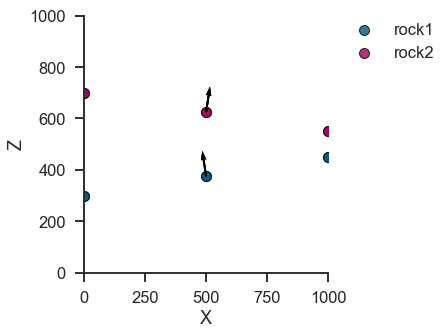

In [3]:
gp.plot.plot_data(geo_data)

In [4]:
from gempy.core.interpolator import InterpolatorWeights

In [5]:
iw = InterpolatorWeights(geo_data.surface_points, geo_data.orientations, geo_data.grid, geo_data.surfaces,
                    geo_data.series, geo_data.faults, geo_data.additional_data)

In [6]:
iw.theano_graph.input_parameters_kriging

[Position of the dips,
 Angle of every dip,
 Azimuth,
 Polarity,
 All the surface_points points at once,
 Full block matrix for faults or drift. We take 2 times len points for the faultdrift.]

In [7]:
geo_model_T = theano.OpFromGraph(iw.theano_graph.input_parameters_kriging,
                                 [iw.theano_graph.compute_weights()], inline=False,
                                 on_unused_input='warn',
                               name='geo_model')

In [8]:
iw.set_theano_shared_kriging()
iw.set_theano_shared_nuggets()
iw.set_theano_shared_structure_surfaces()

In [9]:
iw.compile_th_fn()

Compiling theano function...
Compilation Done!


In [10]:
geo_model_T(*iw.get_python_input_weights())

geo_model{inline=False}.0

In [11]:
th_f = theano.function([], geo_model_T(*iw.get_python_input_weights()))

In [12]:
th_f()

fucking b __str__ = [-1.48499838e-01 -1.48499838e-01 -1.48499838e-01  1.48499838e-01
  1.48499838e-01  1.48499838e-01 -9.09299259e-18 -9.09299259e-18
 -9.09299259e-18  9.09299259e-18  9.09299259e-18  9.09299259e-18
  9.88912432e-01  9.88912432e-01  9.88912432e-01  9.88912432e-01
  9.88912432e-01  9.88912432e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]


array([ 5.31090583e-04,  4.59888436e-04,  4.59888436e-04, -5.31090583e-04,
       -4.59888436e-04, -4.59888436e-04,  2.12407612e-14,  2.88131045e-05,
       -2.88131043e-05, -2.13219107e-14, -2.88131045e-05,  2.88131043e-05,
        5.12829519e-04,  1.18840956e-03,  1.18840956e-03,  5.12829519e-04,
        1.18840956e-03,  1.18840956e-03, -2.30899460e-03, -1.46463350e-02,
       -1.46463350e-02,  1.69553296e-02,  1.69553296e-02,  2.30899460e-03,
        1.46463350e-02,  1.46463350e-02, -1.69553296e-02, -1.69553296e-02,
       -5.08732841e-15,  5.85681185e-15,  1.19105982e+00])

In [13]:
input_sh = []
for i in iw.get_python_input_weights():
    input_sh.append(theano.shared(i))

b = geo_data.interpolator.theano_graph.input_parameters_kriging
a = geo_model_T(*b).sum()

In [14]:
th_f = theano.function(b, theano.grad(a, b)[0])

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gof/cc.py:968: UserWarning: Your g++ compiler fails to compile OpenMP code. We know this happen with some version of the EPD mingw compiler and LLVM compiler on Mac OS X. We disable openmp everywhere in Theano. To remove this warning set the theano flags `openmp` to False.
  ret += x.c_compile_args()


In [15]:
th_f(*iw.get_python_input_weights())

array([[-0.13209871,  0.01966911,  2.96308196],
       [-0.08441005, -0.04101736, -9.63237836]])

## Compiling gempy with PyMC3

In [4]:
import theano
import theano.tensor as T
#theano.config.compute_test_value = 'ignore'
#geo_data.interpolator.__init__()
path_to_data = os.pardir+"/../data/input_data/jan_models/"

geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[20,2,200], 
                        path_o = path_to_data + "model3_orientations.csv",
                        path_i = path_to_data + "model3_surface_points.csv") 
geo_data.interpolator.set_all_shared_parameters()
i = geo_data.interpolator.get_python_input_block()

Active grids: ['regular']


In [45]:
geo_model_T = theano.OpFromGraph(geo_data.interpolator.theano_graph.input_parameters_loop,
                               [geo_data.interpolator.theano_graph.covariance_matrix()], inline=False,
                                 on_unused_input='ignore',
                               name='geo_model')

In [18]:
#T.grad(geo_model_T(*geo_data.interpolator.theano_graph.input_parameters_loop)[0][0], 
#       geo_data.interpolator.theano_graph.input_parameters_loop[2])

In [19]:
geo_data.interpolator.theano_graph.input_parameters_loop[2]

Azimuth

In [20]:
geo_data.interpolator.theano_graph.len_series_i.get_value()

array([  0, 103], dtype=int32)

### Solve the weights directly

#### val

In [5]:
th_f = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                       geo_data.interpolator.theano_graph.solve_kriging(), 
                       on_unused_input='ignore',)

In [6]:
th_f(*geo_data.interpolator.get_python_input_block())

array([-2.12201235e-05, -2.12088496e-05, -1.23444328e-06, -1.13480266e-06,
       -2.59685874e-04,  2.59556938e-04,  6.12906956e-04, -1.45928754e-03,
       -1.45638968e-03, -1.96840975e-03, -1.96943904e-03,  1.39301464e-03,
        1.39494364e-03, -3.68742397e-04, -3.69160855e-04,  2.59453871e-03,
        2.39771042e-03,  2.38531589e-03, -3.18555433e-04, -3.11353415e-04,
       -4.77142788e-04, -4.82890810e-04,  2.78937821e-03,  2.79451205e-03,
        7.31763471e-04,  7.21571302e-04,  4.82752555e-05, -2.31513122e-04,
       -2.29788749e-04, -3.28751006e-03, -3.28958588e-03, -5.03259506e-03,
       -5.02885501e-03,  1.05782642e-03,  1.05176886e-03, -2.47336305e-03,
       -2.46618698e-03,  6.82953502e-04,  3.03980962e-03,  3.09670603e-03,
       -4.81352513e-04, -7.76705273e-04, -6.24135816e-04, -9.79322101e-05,
        2.70578612e-03,  2.64789648e-03,  1.19911033e-03,  1.12508142e-03,
        4.75619998e-04,  2.29835823e-03,  3.64001337e-04,  4.00945737e-04,
       -1.46446176e-03, -

#### Gradient

In [7]:
th_f_g = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                         T.grad(geo_data.interpolator.theano_graph.solve_kriging().sum(), 
                              geo_data.interpolator.theano_graph.input_parameters_loop[3]),
                         on_unused_input='ignore')

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gof/cc.py:968: UserWarning: Your g++ compiler fails to compile OpenMP code. We know this happen with some version of the EPD mingw compiler and LLVM compiler on Mac OS X. We disable openmp everywhere in Theano. To remove this warning set the theano flags `openmp` to False.
  ret += x.c_compile_args()


In [8]:
th_f_g(*geo_data.interpolator.get_python_input_block())

array([-0.1710225 ,  0.01786243])

-------

#### Gradient weights: Calling compute_a_series
#### Val

In [9]:
geo_data.interpolator.theano_graph.len_series_i[1]

Subtensor{int64}.0

In [12]:
th_f_2 = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                        geo_data.interpolator.theano_graph.compute_a_series(
    len_i_0=0, len_i_1=geo_data.interpolator.theano_graph.len_series_i[1],
    len_f_0=0, len_f_1=geo_data.interpolator.theano_graph.len_series_o[1],
    len_w_0=0, len_w_1=geo_data.interpolator.theano_graph.len_series_w[1],
    n_form_per_serie_0=0, n_form_per_serie_1=geo_data.interpolator.theano_graph.n_surfaces_per_series[1],
    u_grade_iter=3,
    compute_weight_ctr=np.array(True), compute_scalar_ctr=np.array(True), compute_block_ctr=np.array(True),
    is_finite=np.array(False), is_erosion=np.array(True), is_onlap=np.array(False),
    n_series=0,
    block_matrix=geo_data.interpolator.theano_graph.block_matrix,
    weights_vector=geo_data.interpolator.theano_graph.weights_vector,
    scalar_field_matrix=geo_data.interpolator.theano_graph.scalar_fields_matrix,
    sfai=geo_data.interpolator.theano_graph.sfai,
    mask_matrix=geo_data.interpolator.theano_graph.mask_matrix
                 ),
                         on_unused_input='ignore')



In [13]:
th_f_2(*geo_data.interpolator.get_python_input_block())[1]

array([-2.12201235e-05, -2.12088496e-05, -1.23444328e-06, -1.13480266e-06,
       -2.59685874e-04,  2.59556938e-04,  6.12906956e-04, -1.45928754e-03,
       -1.45638968e-03, -1.96840975e-03, -1.96943904e-03,  1.39301464e-03,
        1.39494364e-03, -3.68742397e-04, -3.69160855e-04,  2.59453872e-03,
        2.39771042e-03,  2.38531589e-03, -3.18555433e-04, -3.11353415e-04,
       -4.77142788e-04, -4.82890810e-04,  2.78937821e-03,  2.79451205e-03,
        7.31763471e-04,  7.21571302e-04,  4.82752555e-05, -2.31513122e-04,
       -2.29788749e-04, -3.28751006e-03, -3.28958588e-03, -5.03259506e-03,
       -5.02885501e-03,  1.05782642e-03,  1.05176886e-03, -2.47336305e-03,
       -2.46618698e-03,  6.82953502e-04,  3.03980962e-03,  3.09670603e-03,
       -4.81352513e-04, -7.76705273e-04, -6.24135816e-04, -9.79322101e-05,
        2.70578612e-03,  2.64789648e-03,  1.19911033e-03,  1.12508142e-03,
        4.75619998e-04,  2.29835823e-03,  3.64001337e-04,  4.00945737e-04,
       -1.46446176e-03, -

#### Gradient

In [15]:
th_f_g2 = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                         T.grad( geo_data.interpolator.theano_graph.compute_a_series(
    len_i_0=0, len_i_1=geo_data.interpolator.theano_graph.len_series_i[1],
    len_f_0=0, len_f_1=geo_data.interpolator.theano_graph.len_series_o[1],
    len_w_0=0, len_w_1=geo_data.interpolator.theano_graph.len_series_w[1],
    n_form_per_serie_0=0, n_form_per_serie_1=geo_data.interpolator.theano_graph.n_surfaces_per_series[1],
    u_grade_iter=3,
    compute_weight_ctr=np.array(True), compute_scalar_ctr=np.array(True), compute_block_ctr=np.array(True),
    is_finite=np.array(False), is_erosion=np.array(True), is_onlap=np.array(False),
    n_series=0,
    block_matrix=geo_data.interpolator.theano_graph.block_matrix,
    weights_vector=geo_data.interpolator.theano_graph.weights_vector,
    scalar_field_matrix=geo_data.interpolator.theano_graph.scalar_fields_matrix,
    sfai=geo_data.interpolator.theano_graph.sfai,
    mask_matrix=geo_data.interpolator.theano_graph.mask_matrix
                 )[1].sum(), 
                              geo_data.interpolator.theano_graph.input_parameters_loop[4]),
                         on_unused_input='ignore')

In [16]:
th_f_g2(*geo_data.interpolator.get_python_input_block())

array([[ 1.00168791e+00,  1.20715916e-01,  1.06777926e+01],
       [-1.19046129e+00, -4.20182945e-02,  9.69791865e+00],
       [-1.59984197e+00, -1.97829445e-01, -1.77911931e+01],
       [ 2.14774700e+00,  2.02996926e-01, -2.29954978e+01],
       [ 1.27454994e+00,  2.24536986e-01,  1.27319148e+01],
       [-1.25939456e+00, -2.27534030e-01,  1.24903611e+01],
       [-1.19842914e+00, -2.11091976e-01, -1.31154071e+01],
       [ 7.75581418e-01,  1.48345954e-01, -8.53406345e+00],
       [ 6.95879825e-01,  1.00592807e-01,  5.30609247e+00],
       [-6.53266232e-01, -8.91626367e-02,  4.98888316e+00],
       [-3.87368735e+00, -2.45243867e-01, -7.61208465e-01],
       [-1.01571650e+00,  4.37282484e-01, -6.96024447e+00],
       [-4.74696962e+00, -3.21782885e-01,  3.56250710e+01],
       [ 1.34815058e+00, -2.22989185e-01,  1.40515166e+01],
       [ 3.05135859e+00, -3.62620848e-01, -3.18542148e+01],
       [ 2.16200390e-01, -8.61799747e-02,  2.02311855e+00],
       [-1.76585709e+00,  2.90873949e-01

### Weights compute series
#### val

In [5]:
th_f_3 = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                       geo_data.interpolator.theano_graph.compute_series(), 
                       on_unused_input='ignore',)

In [8]:
th_f_3(*geo_data.interpolator.get_python_input_block())[1][-1]

fucking b __str__ = [-9.9840746e-02 -9.9840746e-02 -6.1134825e-18 -6.1134825e-18
 -9.9500343e-01  9.9500343e-01  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.

array([-2.12201235e-05, -2.12088496e-05, -1.23444328e-06, -1.13480266e-06,
       -2.59685874e-04,  2.59556938e-04,  6.12906956e-04, -1.45928754e-03,
       -1.45638968e-03, -1.96840975e-03, -1.96943904e-03,  1.39301464e-03,
        1.39494364e-03, -3.68742397e-04, -3.69160855e-04,  2.59453871e-03,
        2.39771042e-03,  2.38531589e-03, -3.18555433e-04, -3.11353415e-04,
       -4.77142788e-04, -4.82890810e-04,  2.78937821e-03,  2.79451205e-03,
        7.31763471e-04,  7.21571302e-04,  4.82752555e-05, -2.31513122e-04,
       -2.29788749e-04, -3.28751006e-03, -3.28958588e-03, -5.03259506e-03,
       -5.02885501e-03,  1.05782642e-03,  1.05176886e-03, -2.47336305e-03,
       -2.46618698e-03,  6.82953502e-04,  3.03980962e-03,  3.09670603e-03,
       -4.81352513e-04, -7.76705273e-04, -6.24135816e-04, -9.79322101e-05,
        2.70578612e-03,  2.64789648e-03,  1.19911033e-03,  1.12508142e-03,
        4.75619998e-04,  2.29835823e-03,  3.64001337e-04,  4.00945737e-04,
       -1.46446176e-03, -

#### gradient

In [7]:
theano.config.optimizer_including

'alloc_empty_to_zeros'

In [8]:
theano.config.optimizer = 'fast_compile'

In [11]:
from theano.compile.nanguardmode import NanGuardMode

th_f_g3 = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                         T.grad(geo_data.interpolator.theano_graph.compute_series()[1][-1][5] * 5, 
                              geo_data.interpolator.theano_graph.input_parameters_loop[4]),
                          # mode=NanGuardMode(nan_is_error=True),
                         on_unused_input='ignore')

In [12]:
th_f_g3(*geo_data.interpolator.get_python_input_block())

fucking b __str__ = [-9.9840746e-02 -9.9840746e-02 -6.1134825e-18 -6.1134825e-18
 -9.9500343e-01  9.9500343e-01  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.

ValueError: array must not contain infs or NaNs
Apply node that caused the error: Solve{A_structure='general', lower=True, overwrite_A=False, overwrite_b=False}(Block Covariance Matrix.T, Reshape{1}.0)
Toposort index: 863
Inputs types: [TensorType(float64, matrix), TensorType(float64, vector)]
Inputs shapes: [(112, 112), (112,)]
Inputs strides: [(8, 896), (8,)]
Inputs values: ['not shown', 'not shown']
Inputs type_num: [12, 12]
Outputs clients: [[InplaceDimShuffle{0,x}(Solve{A_structure='general', lower=True, overwrite_A=False, overwrite_b=False}.0), Subtensor{int64:int64:}(Solve{A_structure='general', lower=True, overwrite_A=False, overwrite_b=False}.0, Constant{0}, ScalarFromTensor.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gradient.py", line 1326, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gradient.py", line 1021, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gradient.py", line 1021, in <listcomp>
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gradient.py", line 1326, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gradient.py", line 1021, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gradient.py", line 1021, in <listcomp>
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gradient.py", line 1326, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gradient.py", line 1162, in access_term_cache
    new_output_grads)

Debugprint of the apply node: 
Solve{A_structure='general', lower=True, overwrite_A=False, overwrite_b=False} [id A] <TensorType(float64, vector)> ''   
 |InplaceDimShuffle{1,0} [id B] <TensorType(float64, matrix)> 'Block Covariance Matrix.T'   
 |Reshape{1} [id C] <TensorType(float64, vector)> ''   
   |if{} [id D] <TensorType(float64, vector)> ''   
   | |Vector controlling if weights must be recomputed[t] [id E] <TensorType(bool, scalar)>
   | |Elemwise{add,no_inplace} [id F] <TensorType(float64, vector)> ''   
   | | |Sum{axis=[0, 1, 2], acc_dtype=float64} [id G] <TensorType(float64, vector)> ''   
   | | | |InplaceDimShuffle{0,2,1,3} [id H] <TensorType(float64, (False, True, True, False))> ''   
   | | |   |Reshape{4} [id I] <TensorType(float64, (False, True, True, False))> ''   
   | | |     |InplaceDimShuffle{1,0} [id J] <TensorType(float64, matrix)> ''   
   | | |     | |Subtensor{int64} [id K] <TensorType(float64, matrix)> ''   
   | | |     |   |for{cpu,grad_of_Looping grid}.9 [id L] <TensorType(float64, 3D)> ''   
   | | |     |   | |Elemwise{sub,no_inplace} [id M] <TensorType(int64, scalar)> ''   
   | | |     |   | | |Subtensor{int64} [id N] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |Shape [id O] <TensorType(int64, vector)> ''   
   | | |     |   | | | | |for{cpu,Looping grid} [id P] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   |Elemwise{minimum,no_inplace} [id Q] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | |Subtensor{int64} [id R] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |Shape [id S] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | | |Subtensor{int64:int64:} [id T] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   |Join [id U] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | |TensorConstant{0} [id V] <TensorType(int8, scalar)>
   | | |     |   | | | |   | | |   | |ARange{dtype='int64'} [id W] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | | |TensorConstant{0} [id V] <TensorType(int8, scalar)>
   | | |     |   | | | |   | | |   | | |Subtensor{int64} [id X] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | | | |Shape [id Y] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | | | | |Join [id Z] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | | |   | | | |   |TensorConstant{0} [id V] <TensorType(int8, scalar)>
   | | |     |   | | | |   | | |   | | | |   |Coordinates of the grid points to interpolate_copy [id BA] <TensorType(float64, matrix)>
   | | |     |   | | | |   | | |   | | | |   |AdvancedSubtensor1 [id BB] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | | |   | | | |   | |All the surface_points points at once_copy [id BC] <TensorType(float64, matrix)>
   | | |     |   | | | |   | | |   | | | |   | |Subtensor{int64} [id BD] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | | | |   |   |Nonzero [id BE] <TensorType(int64, matrix)> ''   
   | | |     |   | | | |   | | |   | | | |   |   | |AdvancedIncSubtensor1{no_inplace,set} [id BF] <TensorType(int16, vector)> ''   
   | | |     |   | | | |   | | |   | | | |   |   |   |Alloc [id BG] <TensorType(int16, vector)> ''   
   | | |     |   | | | |   | | |   | | | |   |   |   | |TensorConstant{1} [id BH] <TensorType(int16, scalar)>
   | | |     |   | | | |   | | |   | | | |   |   |   | |Subtensor{int64} [id BI] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | | | |   |   |   |   |Shape [id BJ] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | | | |   |   |   |   | |All the surface_points points at once_copy [id BC] <TensorType(float64, matrix)>
   | | |     |   | | | |   | | |   | | | |   |   |   |   |Constant{0} [id BK] <int64>
   | | |     |   | | | |   | | |   | | | |   |   |   |TensorConstant{0} [id V] <TensorType(int8, scalar)>
   | | |     |   | | | |   | | |   | | | |   |   |   |CumOp{None, add} [id BL] <TensorType(int32, vector)> ''   
   | | |     |   | | | |   | | |   | | | |   |   |     |Join [id BM] <TensorType(int32, vector)> ''   
   | | |     |   | | | |   | | |   | | | |   |   |       |TensorConstant{0} [id V] <TensorType(int8, scalar)>
   | | |     |   | | | |   | | |   | | | |   |   |       |TensorConstant{(1,) of 0} [id BN] <TensorType(int8, vector)>
   | | |     |   | | | |   | | |   | | | |   |   |       |Elemwise{add,no_inplace} [id BO] <TensorType(int32, vector)> ''   
   | | |     |   | | | |   | | |   | | | |   |   |         |Subtensor{:int64:} [id BP] <TensorType(int32, vector)> ''   
   | | |     |   | | | |   | | |   | | | |   |   |         | |Number of points per surface used to split rest-ref_copy [id BQ] <TensorType(int32, vector)>
   | | |     |   | | | |   | | |   | | | |   |   |         | |Constant{-1} [id BR] <int64>
   | | |     |   | | | |   | | |   | | | |   |   |         |TensorConstant{(1,) of 1} [id BS] <TensorType(int8, (True,))>
   | | |     |   | | | |   | | |   | | | |   |   |Constant{0} [id BK] <int64>
   | | |     |   | | | |   | | |   | | | |   |Subtensor{int64} [id BT] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | | |   | | | |     |Subtensor{int64::} [id BU] <TensorType(float64, 3D)> ''   
   | | |     |   | | | |   | | |   | | | |     | |for{cpu,scan_fn} [id BV] <TensorType(float64, 3D)> ''   
   | | |     |   | | | |   | | |   | | | |     | | |Elemwise{minimum,no_inplace} [id BW] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | | | |     | | | |Elemwise{minimum,no_inplace} [id BX] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | | | |     | | | | |Subtensor{int64} [id BY] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | | | |     | | | | | |Shape [id BZ] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | | | |     | | | | | | |Subtensor{int64::} [id CA] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | | |   | | | |     | | | | | |   |AdvancedSubtensor1 [id CB] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | | |   | | | |     | | | | | |   | |All the surface_points points at once_copy [id BC] <TensorType(float64, matrix)>
   | | |     |   | | | |   | | |   | | | |     | | | | | |   | |CumOp{None, add} [id BL] <TensorType(int32, vector)> ''   
   | | |     |   | | | |   | | |   | | | |     | | | | | |   |Constant{0} [id BK] <int64>
   | | |     |   | | | |   | | |   | | | |     | | | | | |Constant{0} [id BK] <int64>
   | | |     |   | | | |   | | |   | | | |     | | | | |Subtensor{int64} [id CC] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | | | |     | | | |   |Shape [id CD] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | | | |     | | | |   | |Subtensor{int64:int64:} [id CE] <TensorType(int32, vector)> ''   
   | | |     |   | | | |   | | |   | | | |     | | | |   |   |CumOp{None, add} [id CF] <TensorType(int32, vector)> ''   
   | | |     |   | | | |   | | |   | | | |     | | | |   |   | |Join [id CG] <TensorType(int32, vector)> ''   
   | | |     |   | | | |   | | |   | | | |     | | | |   |   |   |TensorConstant{0} [id V] <TensorType(int8, scalar)>
   | | |     |   | | | |   | | |   | | | |     | | | |   |   |   |TensorConstant{(1,) of 0} [id BN] <TensorType(int8, vector)>
   | | |     |   | | | |   | | |   | | | |     | | | |   |   |   |Number of points per surface used to split rest-ref_copy [id BQ] <TensorType(int32, vector)>
   | | |     |   | | | |   | | |   | | | |     | | | |   |   |Constant{0} [id BK] <int64>
   | | |     |   | | | |   | | |   | | | |     | | | |   |   |Constant{-1} [id BR] <int64>
   | | |     |   | | | |   | | |   | | | |     | | | |   |Constant{0} [id BK] <int64>
   | | |     |   | | | |   | | |   | | | |     | | | |Subtensor{int64} [id CH] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | | | |     | | |   |Shape [id CI] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | | | |     | | |   | |Subtensor{int64::} [id CJ] <TensorType(int32, vector)> ''   
   | | |     |   | | | |   | | |   | | | |     | | |   |   |CumOp{None, add} [id CF] <TensorType(int32, vector)> ''   
   | | |     |   | | | |   | | |   | | | |     | | |   |   |Constant{1} [id CK] <int64>
   | | |     |   | | | |   | | |   | | | |     | | |   |Constant{0} [id BK] <int64>
   | | |     |   | | | |   | | |   | | | |     | | |Subtensor{:int64:} [id CL] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | | |   | | | |     | | | |Subtensor{int64::} [id CA] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | | |   | | | |     | | | |ScalarFromTensor [id CM] <int64> ''   
   | | |     |   | | | |   | | |   | | | |     | | |   |Elemwise{minimum,no_inplace} [id BW] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | | | |     | | |Subtensor{:int64:} [id CN] <TensorType(int32, vector)> ''   
   | | |     |   | | | |   | | |   | | | |     | | | |Subtensor{int64:int64:} [id CE] <TensorType(int32, vector)> ''   
   | | |     |   | | | |   | | |   | | | |     | | | |ScalarFromTensor [id CM] <int64> ''   
   | | |     |   | | | |   | | |   | | | |     | | |Subtensor{:int64:} [id CO] <TensorType(int32, vector)> ''   
   | | |     |   | | | |   | | |   | | | |     | | | |Subtensor{int64::} [id CJ] <TensorType(int32, vector)> ''   
   | | |     |   | | | |   | | |   | | | |     | | | |ScalarFromTensor [id CM] <int64> ''   
   | | |     |   | | | |   | | |   | | | |     | | |IncSubtensor{Set;:int64:} [id CP] <TensorType(float64, 3D)> ''   
   | | |     |   | | | |   | | |   | | | |     | |   |Alloc [id CQ] <TensorType(float64, 3D)> ''   
   | | |     |   | | | |   | | |   | | | |     | |   | |TensorConstant{0.0} [id CR] <TensorType(float64, scalar)>
   | | |     |   | | | |   | | |   | | | |     | |   | |Elemwise{add,no_inplace} [id CS] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | | | |     | |   | | |Elemwise{minimum,no_inplace} [id BW] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | | | |     | |   | | |Subtensor{int64} [id CT] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | | | |     | |   | |   |Shape [id CU] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | | | |     | |   | |   | |Rebroadcast{0} [id CV] <TensorType(float64, 3D)> ''   
   | | |     |   | | | |   | | |   | | | |     | |   | |   |   |InplaceDimShuffle{x,0,1} [id CW] <TensorType(float64, (True, False, False))> ''   
   | | |     |   | | | |   | | |   | | | |     | |   | |   |     |Alloc [id CX] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | | |   | | | |     | |   | |   |       |TensorConstant{0.0} [id CY] <TensorType(float64, scalar)>
   | | |     |   | | | |   | | |   | | | |     | |   | |   |       |Subtensor{int64} [id CZ] <TensorType(int32, scalar)> ''   
   | | |     |   | | | |   | | |   | | | |     | |   | |   |       | |CumOp{None, add} [id CF] <TensorType(int32, vector)> ''   
   | | |     |   | | | |   | | |   | | | |     | |   | |   |       | |Constant{-1} [id BR] <int64>
   | | |     |   | | | |   | | |   | | | |     | |   | |   |       |TensorConstant{3} [id DA] <TensorType(int8, scalar)>
   | | |     |   | | | |   | | |   | | | |     | |   | |   |Constant{0} [id BK] <int64>
   | | |     |   | | | |   | | |   | | | |     | |   | |Subtensor{int64} [id DB] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | | | |     | |   | | |Shape [id CU] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | | | |     | |   | | |Constant{1} [id CK] <int64>
   | | |     |   | | | |   | | |   | | | |     | |   | |Subtensor{int64} [id DC] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | | | |     | |   |   |Shape [id CU] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | | | |     | |   |   |Constant{2} [id DD] <int64>
   | | |     |   | | | |   | | |   | | | |     | |   |Rebroadcast{0} [id CV] <TensorType(float64, 3D)> ''   
   | | |     |   | | | |   | | |   | | | |     | |   |ScalarFromTensor [id DE] <int64> ''   
   | | |     |   | | | |   | | |   | | | |     | |     |Subtensor{int64} [id CT] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | | | |     | |Constant{1} [id CK] <int64>
   | | |     |   | | | |   | | |   | | | |     |Constant{-1} [id BR] <int64>
   | | |     |   | | | |   | | |   | | | |Constant{0} [id BK] <int64>
   | | |     |   | | | |   | | |   | | |Elemwise{true_div,no_inplace} [id DF] <TensorType(float64, scalar)> ''   
   | | |     |   | | | |   | | |   | |   |InplaceDimShuffle{} [id DG] <TensorType(float64, scalar)> ''   
   | | |     |   | | | |   | | |   | |   | |InplaceDimShuffle{x} [id DH] <TensorType(float64, (True,))> ''   
   | | |     |   | | | |   | | |   | |   |   |Elemwise{true_div,no_inplace} [id DI] <TensorType(float64, scalar)> ''   
   | | |     |   | | | |   | | |   | |   |     |TensorConstant{1000000000000.0} [id DJ] <TensorType(float64, scalar)>
   | | |     |   | | | |   | | |   | |   |     |Elemwise{add,no_inplace} [id DK] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | |   |       |Elemwise{add,no_inplace} [id DL] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | |   |       | |Elemwise{add,no_inplace} [id DM] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | |   |       | | |Subtensor{int64} [id DN] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | |   |       | | | |Shape [id DO] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | |   |       | | | | |Reshape{2} [id DP] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | | |   | |   |       | | | |   |InplaceDimShuffle{0,2,1,3} [id DQ] <TensorType(float64, (False, False, True, False))> ''   
   | | |     |   | | | |   | | |   | |   |       | | | |   | |Alloc [id DR] <TensorType(float64, (False, True, False, False))> ''   
   | | |     |   | | | |   | | |   | |   |       | | | |   |   |Subtensor{int32:int32:, ::} [id DS] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | | |   | |   |       | | | |   |   | |Position of the dips_copy [id DT] <TensorType(float64, matrix)>
   | | |     |   | | | |   | | |   | |   |       | | | |   |   | |ScalarFromTensor [id DU] <int32> ''   
   | | |     |   | | | |   | | |   | |   |       | | | |   |   | | |Length of foliations in every series[t] [id DV] <TensorType(int32, scalar)>
   | | |     |   | | | |   | | |   | |   |       | | | |   |   | |ScalarFromTensor [id DW] <int32> ''   
   | | |     |   | | | |   | | |   | |   |       | | | |   |   |   |Length of foliations in every series[t+1] [id DX] <TensorType(int32, scalar)>
   | | |     |   | | | |   | | |   | |   |       | | | |   |   |TensorConstant{3} [id DA] <TensorType(int8, scalar)>
   | | |     |   | | | |   | | |   | |   |       | | | |   |   |TensorConstant{1} [id DY] <TensorType(int8, scalar)>
   | | |     |   | | | |   | | |   | |   |       | | | |   |   |Subtensor{int64} [id DZ] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | |   |       | | | |   |   | |Shape [id EA] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | |   |       | | | |   |   | | |Subtensor{int32:int32:, ::} [id DS] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | | |   | |   |       | | | |   |   | |Constant{0} [id BK] <int64>
   | | |     |   | | | |   | | |   | |   |       | | | |   |   |Subtensor{int64} [id EB] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | |   |       | | | |   |     |Shape [id EA] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | |   |       | | | |   |     |Constant{1} [id CK] <int64>
   | | |     |   | | | |   | | |   | |   |       | | | |   |MakeVector{dtype='int64'} [id EC] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | |   |       | | | |     |Elemwise{mul,no_inplace} [id ED] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | |   |       | | | |     | |Subtensor{int64} [id DZ] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | |   |       | | | |     | |TensorConstant{3} [id DA] <TensorType(int8, scalar)>
   | | |     |   | | | |   | | |   | |   |       | | | |     |Elemwise{mul,no_inplace} [id EE] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | |   |       | | | |       |Subtensor{int64} [id EB] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | |   |       | | | |       |TensorConstant{1} [id DY] <TensorType(int8, scalar)>
   | | |     |   | | | |   | | |   | |   |       | | | |Constant{0} [id BK] <int64>
   | | |     |   | | | |   | | |   | |   |       | | |Subtensor{int64} [id EF] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | |   |       | |   |Shape [id EG] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | |   |       | |   | |Subtensor{int32:int32:, ::} [id EH] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | | |   | |   |       | |   |   |AdvancedSubtensor1 [id BB] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | | |   | |   |       | |   |   |ScalarFromTensor [id EI] <int32> ''   
   | | |     |   | | | |   | | |   | |   |       | |   |   | |Length of surface_points in every series[t] [id EJ] <TensorType(int32, scalar)>
   | | |     |   | | | |   | | |   | |   |       | |   |   |ScalarFromTensor [id EK] <int32> ''   
   | | |     |   | | | |   | | |   | |   |       | |   |     |Length of surface_points in every series[t+1] [id EL] <TensorType(int32, scalar)>
   | | |     |   | | | |   | | |   | |   |       | |   |Constant{0} [id BK] <int64>
   | | |     |   | | | |   | | |   | |   |       | |Grade of the universal drift[t] [id EM] <TensorType(int32, scalar)>
   | | |     |   | | | |   | | |   | |   |       |Elemwise{Cast{int32}} [id EN] <TensorType(int32, scalar)> ''   
   | | |     |   | | | |   | | |   | |   |         |Subtensor{int64} [id EO] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | |   |           |Shape [id EP] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | |   |           | |Elemwise{mul,no_inplace} [id EQ] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | | |   | |   |           |   |AdvancedSubtensor [id ER] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | | |   | |   |           |   | |block matrix[t-1] [id ES] <TensorType(float64, 3D)>
   | | |     |   | | | |   | | |   | |   |           |   | |Subtensor{int64} [id ET] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | |   |           |   | | |Nonzero [id EU] <TensorType(int64, matrix)> ''   
   | | |     |   | | | |   | | |   | |   |           |   | | | |Elemwise{Cast{int8}} [id EV] <TensorType(int8, vector)> ''   
   | | |     |   | | | |   | | |   | |   |           |   | | |   |Subtensor{::, int8} [id EW] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | |   |           |   | | |     |fault relation matrix_copy [id EX] <TensorType(int64, matrix)>
   | | |     |   | | | |   | | |   | |   |           |   | | |     |ScalarFromTensor [id EY] <int8> ''   
   | | |     |   | | | |   | | |   | |   |           |   | | |       |Elemwise{Cast{int8}} [id EZ] <TensorType(int8, scalar)> ''   
   | | |     |   | | | |   | | |   | |   |           |   | | |         |<TensorType(int32, scalar)> [id FA] <TensorType(int32, scalar)>
   | | |     |   | | | |   | | |   | |   |           |   | | |Constant{0} [id BK] <int64>
   | | |     |   | | | |   | | |   | |   |           |   | |TensorConstant{0} [id FB] <TensorType(int64, scalar)>
   | | |     |   | | | |   | | |   | |   |           |   | |SliceConstant{None, None, None} [id FC] <slice>
   | | |     |   | | | |   | | |   | |   |           |   |InplaceDimShuffle{x,x} [id FD] <TensorType(float64, (True, True))> ''   
   | | |     |   | | | |   | | |   | |   |           |     |<TensorType(float64, scalar)> [id FE] <TensorType(float64, scalar)>
   | | |     |   | | | |   | | |   | |   |           |Constant{0} [id BK] <int64>
   | | |     |   | | | |   | | |   | |   |Subtensor{int64} [id X] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   | |MakeVector{dtype='int64'} [id FF] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   |   |Subtensor{int64} [id X] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   |Constant{0} [id BK] <int64>
   | | |     |   | | | |   | | |   |Constant{-1} [id BR] <int64>
   | | |     |   | | | |   | | |Constant{0} [id BK] <int64>
   | | |     |   | | | |   | |Subtensor{int64} [id FG] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   |   |Shape [id FH] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   |   | |Subtensor{int64::} [id FI] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   |   |   |Join [id U] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   |   |   |Constant{1} [id CK] <int64>
   | | |     |   | | | |   |   |Constant{0} [id BK] <int64>
   | | |     |   | | | |   |Subtensor{:int64:} [id FJ] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | |Subtensor{int64:int64:} [id T] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | |ScalarFromTensor [id FK] <int64> ''   
   | | |     |   | | | |   |   |Elemwise{minimum,no_inplace} [id Q] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   |Subtensor{:int64:} [id FL] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | |Subtensor{int64::} [id FI] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | |ScalarFromTensor [id FK] <int64> ''   
   | | |     |   | | | |   |IncSubtensor{Set;:int64:} [id FM] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | |Alloc [id FN] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | | |TensorConstant{0.0} [id FO] <TensorType(float64, scalar)>
   | | |     |   | | | |   | | |Elemwise{add,no_inplace} [id FP] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | | |Elemwise{minimum,no_inplace} [id Q] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | | |Subtensor{int64} [id FQ] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   |Shape [id FR] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | | |   | |Rebroadcast{0} [id FS] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | | |   |   |InplaceDimShuffle{x,0} [id FT] <TensorType(float64, row)> ''   
   | | |     |   | | | |   | | |   |     |Alloc [id FU] <TensorType(float64, vector)> ''   
   | | |     |   | | | |   | | |   |       |TensorConstant{0.0} [id CY] <TensorType(float64, scalar)>
   | | |     |   | | | |   | | |   |       |Subtensor{int64} [id X] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | | |   |Constant{0} [id BK] <int64>
   | | |     |   | | | |   | | |Subtensor{int64} [id FV] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   | |   |Shape [id FR] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   | |   |Constant{1} [id CK] <int64>
   | | |     |   | | | |   | |Rebroadcast{0} [id FS] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | |ScalarFromTensor [id FW] <int64> ''   
   | | |     |   | | | |   |   |Subtensor{int64} [id FQ] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   |<TensorType(float64, scalar)> [id FX] <TensorType(float64, scalar)>
   | | |     |   | | | |   |Range_copy [id FY] <TensorType(float64, scalar)>
   | | |     |   | | | |   |Covariance at 0_copy [id FZ] <TensorType(float64, scalar)>
   | | |     |   | | | |   |Number of points per surface used to split rest-ref_copy [id BQ] <TensorType(int32, vector)>
   | | |     |   | | | |   |<TensorType(float64, scalar)> [id GA] <TensorType(float64, scalar)>
   | | |     |   | | | |   |fault relation matrix_copy [id EX] <TensorType(int64, matrix)>
   | | |     |   | | | |   |<TensorType(float64, scalar)> [id FE] <TensorType(float64, scalar)>
   | | |     |   | | | |   |Join [id Z] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   |InplaceDimShuffle{1,0} [id GB] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   | |Reshape{2} [id GC] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |   |   |InplaceDimShuffle{0,2,1,3} [id GD] <TensorType(float64, (False, True, True, False))> ''   
   | | |     |   | | | |   |   | |Alloc [id GE] <TensorType(float64, (False, True, True, False))> ''   
   | | |     |   | | | |   |   |   |Print{message='weights foo', attrs=('__str__',), global_fn=<function _print_fn at 0x7fac28e24d90>} [id GF] <TensorType(float64, vector)> ''   
   | | |     |   | | | |   |   |   | |if{} [id GG] <TensorType(float64, vector)> ''   
   | | |     |   | | | |   |   |   |   |Vector controlling if weights must be recomputed[t] [id E] <TensorType(bool, scalar)>
   | | |     |   | | | |   |   |   |   |Reshape{1} [id GH] <TensorType(float64, vector)> 'Dual Kriging parameters'   
   | | |     |   | | | |   |   |   |   |Subtensor{int32:int32:} [id GI] <TensorType(float64, vector)> ''   
   | | |     |   | | | |   |   |   |     |Weights vector[t-1] [id GJ] <TensorType(float64, vector)>
   | | |     |   | | | |   |   |   |     |ScalarFromTensor [id GK] <int32> ''   
   | | |     |   | | | |   |   |   |     | |Length of weights in every series[t] [id GL] <TensorType(int32, scalar)>
   | | |     |   | | | |   |   |   |     |ScalarFromTensor [id GM] <int32> ''   
   | | |     |   | | | |   |   |   |       |Length of weights in every series[t+1] [id GN] <TensorType(int32, scalar)>
   | | |     |   | | | |   |   |   |Subtensor{int64} [id X] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   |   |   |TensorConstant{1} [id DY] <TensorType(int8, scalar)>
   | | |     |   | | | |   |   |   |TensorConstant{1} [id DY] <TensorType(int8, scalar)>
   | | |     |   | | | |   |   |   |Subtensor{int64} [id GO] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   |   |     |Shape [id GP] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   |   |     | |Print{message='weights foo', attrs=('__str__',), global_fn=<function _print_fn at 0x7fac28e24d90>} [id GF] <TensorType(float64, vector)> ''   
   | | |     |   | | | |   |   |     |Constant{0} [id BK] <int64>
   | | |     |   | | | |   |   |MakeVector{dtype='int64'} [id GQ] <TensorType(int64, vector)> ''   
   | | |     |   | | | |   |     |Elemwise{mul,no_inplace} [id GR] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   |     | |TensorConstant{1} [id DY] <TensorType(int8, scalar)>
   | | |     |   | | | |   |     | |Subtensor{int64} [id X] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   |     |Elemwise{mul,no_inplace} [id GS] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   |       |Subtensor{int64} [id GO] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |   |       |TensorConstant{1} [id DY] <TensorType(int8, scalar)>
   | | |     |   | | | |   |Position of the dips_copy [id DT] <TensorType(float64, matrix)>
   | | |     |   | | | |   |Length of foliations in every series[t] [id DV] <TensorType(int32, scalar)>
   | | |     |   | | | |   |Length of foliations in every series[t+1] [id DX] <TensorType(int32, scalar)>
   | | |     |   | | | |   |All the surface_points points at once_copy [id BC] <TensorType(float64, matrix)>
   | | |     |   | | | |   |Length of surface_points in every series[t] [id EJ] <TensorType(int32, scalar)>
   | | |     |   | | | |   |Length of surface_points in every series[t+1] [id EL] <TensorType(int32, scalar)>
   | | |     |   | | | |   |Grade of the universal drift[t] [id EM] <TensorType(int32, scalar)>
   | | |     |   | | | |   |block matrix[t-1] [id ES] <TensorType(float64, 3D)>
   | | |     |   | | | |   |<TensorType(int32, scalar)> [id FA] <TensorType(int32, scalar)>
   | | |     |   | | | |Constant{0} [id BK] <int64>
   | | |     |   | | |TensorConstant{1} [id DY] <TensorType(int8, scalar)>
   | | |     |   | |Subtensor{:int64:} [id GT] <TensorType(int64, vector)> ''   
   | | |     |   | | |Subtensor{::int64} [id GU] <TensorType(int64, vector)> ''   
   | | |     |   | | | |Subtensor{:int64:} [id FJ] <TensorType(int64, vector)> ''   
   | | |     |   | | | |Constant{-1} [id BR] <int64>
   | | |     |   | | |ScalarFromTensor [id GV] <int64> ''   
   | | |     |   | |   |Elemwise{sub,no_inplace} [id M] <TensorType(int64, scalar)> ''   
   | | |     |   | |Subtensor{:int64:} [id GW] <TensorType(int64, vector)> ''   
   | | |     |   | | |Subtensor{::int64} [id GX] <TensorType(int64, vector)> ''   
   | | |     |   | | | |Subtensor{:int64:} [id FL] <TensorType(int64, vector)> ''   
   | | |     |   | | | |Constant{-1} [id BR] <int64>
   | | |     |   | | |ScalarFromTensor [id GV] <int64> ''   
   | | |     |   | |Subtensor{:int64:} [id GY] <TensorType(float64, matrix)> ''   
   | | |     |   | | |Subtensor{::int64} [id GZ] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |Subtensor{:int64:} [id HA] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | |for{cpu,Looping grid} [id P] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | |Constant{-1} [id BR] <int64>
   | | |     |   | | | |Constant{-1} [id BR] <int64>
   | | |     |   | | |ScalarFromTensor [id GV] <int64> ''   
   | | |     |   | |Subtensor{:int64:} [id HB] <TensorType(float64, matrix)> ''   
   | | |     |   | | |Subtensor{:int64:} [id HC] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |Subtensor{::int64} [id HD] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | |for{cpu,Looping grid} [id P] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | |Constant{-1} [id BR] <int64>
   | | |     |   | | | |Constant{-1} [id BR] <int64>
   | | |     |   | | |ScalarFromTensor [id GV] <int64> ''   
   | | |     |   | |Subtensor{::int64} [id HE] <TensorType(float64, matrix)> ''   
   | | |     |   | | |IncSubtensor{Inc;int64::} [id HF] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |Elemwise{second,no_inplace} [id HG] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | |for{cpu,Looping grid} [id P] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | |TensorConstant{(1, 1) of 0.0} [id HH] <TensorType(float64, (True, True))>
   | | |     |   | | | |IncSubtensor{Inc;int64} [id HI] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | |Elemwise{second,no_inplace} [id HJ] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | |Subtensor{int64::} [id HK] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | |for{cpu,Looping grid} [id P] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | |Constant{1} [id CK] <int64>
   | | |     |   | | | | | |TensorConstant{(1, 1) of 0.0} [id HH] <TensorType(float64, (True, True))>
   | | |     |   | | | | |if{} [id HL] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | |Vector controlling if scalar matrix must be recomputed[t] [id HM] <TensorType(bool, scalar)>
   | | |     |   | | | | | |Elemwise{add,no_inplace} [id HN] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | |Elemwise{add,no_inplace} [id HO] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | |Elemwise{add,no_inplace} [id HP] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | |Elemwise{add,no_inplace} [id HQ] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | |Elemwise{add,no_inplace} [id HR] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | |Elemwise{add,no_inplace} [id HS] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |Elemwise{mul,no_inplace} [id HT] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | | |Elemwise{eq,no_inplace} [id HU] <TensorType(bool, vector)> ''   
   | | |     |   | | | | | | | | | | | | | |InplaceDimShuffle{x} [id HV] <TensorType(float64, (True,))> ''   
   | | |     |   | | | | | | | | | | | | | | |MaxAndArgmax{axis=(0,)}.0 [id HW] <TensorType(float64, scalar)> 'max'   
   | | |     |   | | | | | | | | | | | | | |if{} [id HX] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | | |   |Vector controlling if scalar matrix must be recomputed[t] [id HM] <TensorType(bool, scalar)>
   | | |     |   | | | | | | | | | | | | |   |Subtensor{int64} [id HY] <TensorType(float64, vector)> 'Value of the potential field at every point'   
   | | |     |   | | | | | | | | | | | | |   |Subtensor{int32} [id HZ] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | | |     |Scalar matrix[t-1] [id IA] <TensorType(float64, matrix)>
   | | |     |   | | | | | | | | | | | | |     |ScalarFromTensor [id IB] <int32> ''   
   | | |     |   | | | | | | | | | | | | |       |<TensorType(int32, scalar)> [id FA] <TensorType(int32, scalar)>
   | | |     |   | | | | | | | | | | | | |InplaceDimShuffle{x} [id IC] <TensorType(float64, (True,))> ''   
   | | |     |   | | | | | | | | | | | |   |Elemwise{add,no_inplace} [id ID] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     |Elemwise{add,no_inplace} [id IE] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | |Subtensor{int64} [id IF] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | |Split{3}.0 [id IG] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | |Elemwise{add,no_inplace} [id IH] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | |IncSubtensor{Inc;int64:int64:} [id II] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | |Elemwise{second,no_inplace} [id IJ] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | |Join [id IK] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | |TensorConstant{0} [id V] <TensorType(int8, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | |MakeVector{dtype='float64'} [id IL] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Elemwise{add,no_inplace} [id IM] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | |   |MaxAndArgmax{axis=(0,)}.0 [id HW] <TensorType(float64, scalar)> 'max'   
   | | |     |   | | | | | | | | | | | |     | | | | | | | |   |Elemwise{mul,no_inplace} [id IN] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | |     |Elemwise{sub,no_inplace} [id IO] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | |     | |MaxAndArgmax{axis=(0,)}.0 [id HW] <TensorType(float64, scalar)> 'max'   
   | | |     |   | | | | | | | | | | | |     | | | | | | | |     | |Elemwise{neg,no_inplace} [id IP] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | |     |   |MaxAndArgmax{axis=(0,)}.0 [id IQ] <TensorType(float64, scalar)> 'max'   
   | | |     |   | | | | | | | | | | | |     | | | | | | | |     |TensorConstant{0.01} [id IR] <TensorType(float64, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | |AdvancedSubtensor1 [id IS] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Subtensor{int64:int64:} [id IT] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |if{} [id HX] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |ScalarFromTensor [id IU] <int64> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |Elemwise{mul,no_inplace} [id IV] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |TensorConstant{-2} [id IW] <TensorType(int8, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |Elemwise{sub,no_inplace} [id IX] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |     |Subtensor{int64} [id BI] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |     |Subtensor{int64} [id IY] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |       |Shape [id IZ] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |       | |Number of points per surface used to split rest-ref_copy [id BQ] <TensorType(int32, vector)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |       |Constant{0} [id BK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |ScalarFromTensor [id JA] <int64> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |   |Elemwise{neg,no_inplace} [id JB] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |     |Elemwise{sub,no_inplace} [id IX] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Subtensor{int32:int32:} [id JC] <TensorType(int32, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | |   |CumOp{None, add} [id JD] <TensorType(int32, vector)> 'Number of points per surfaces after rest-ref. This is used for finding the differentsurface points withing a layer.'   
   | | |     |   | | | | | | | | | | | |     | | | | | | | |   |ScalarFromTensor [id JE] <int32> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | |   | |List with the number of surfaces[t] [id JF] <TensorType(int32, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | |   |ScalarFromTensor [id JG] <int32> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | |     |List with the number of surfaces[t+1] [id JH] <TensorType(int32, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | |MakeVector{dtype='float64'} [id JI] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | |   |Elemwise{sub,no_inplace} [id JJ] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | |     |Elemwise{neg,no_inplace} [id IP] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | |     |Elemwise{mul,no_inplace} [id IN] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | |TensorConstant{(1,) of 0.0} [id JK] <TensorType(float64, (True,))>
   | | |     |   | | | | | | | | | | | |     | | | | | |IncSubtensor{Inc;:int64:} [id JL] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | |Elemwise{second,no_inplace} [id JM] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | |Subtensor{int64:int64:} [id JN] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Join [id IK] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Constant{0} [id BK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Constant{-1} [id BR] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | |TensorConstant{(1,) of 0.0} [id JK] <TensorType(float64, (True,))>
   | | |     |   | | | | | | | | | | | |     | | | | | | |Subtensor{::int64} [id JO] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | |for{cpu,grad_of_Looping compare}.4 [id JP] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Subtensor{int64} [id JQ] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |Shape [id JR] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |for{cpu,Looping compare} [id JS] <TensorType(float64, 3D)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |Elemwise{minimum,no_inplace} [id JT] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | |Elemwise{minimum,no_inplace} [id JU] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | | |Subtensor{int64} [id JV] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | | | |Shape [id JW] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | | | | |Subtensor{int64:int64:} [id JN] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | | | |Constant{0} [id BK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | | |Subtensor{int64} [id JX] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | |   |Shape [id JY] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | |   | |Subtensor{int64::} [id JZ] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | |   |   |Join [id IK] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | |   |   |Constant{1} [id CK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | |   |Constant{0} [id BK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | |Subtensor{int64} [id KA] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |Shape [id KB] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   | |Subtensor{int64::} [id KC] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   |ARange{dtype='int64'} [id KD] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | |TensorConstant{0} [id V] <TensorType(int8, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | |Subtensor{int64} [id KE] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |Shape [id KF] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | | |IncSubtensor{Set;::, int64} [id KG] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   |IncSubtensor{Set;::, int64} [id KH] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | |Reshape{2} [id KI] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | |Alloc [id KJ] <TensorType(float64, 3D)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |InplaceDimShuffle{0,1,x} [id KK] <TensorType(float64, (False, False, True))> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | | |Subtensor{::, int32:int32:} [id KL] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |   |Values that the blocks are taking_copy [id KM] <TensorType(float64, matrix)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |   |ScalarFromTensor [id JE] <int32> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |   |ScalarFromTensor [id KN] <int32> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |     |Elemwise{add,no_inplace} [id KO] <TensorType(int32, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |       |List with the number of surfaces[t+1] [id JH] <TensorType(int32, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |       |TensorConstant{1} [id DY] <TensorType(int8, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |Subtensor{int64} [id KP] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | | |Shape [id KQ] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | | | |Subtensor{::, int32:int32:} [id KL] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | | |Constant{0} [id BK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |Subtensor{int64} [id KR] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | | |Shape [id KQ] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | | |Constant{1} [id CK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |TensorConstant{2} [id KS] <TensorType(int8, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | |MakeVector{dtype='int64'} [id KT] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | |   |Subtensor{int64} [id KP] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | |   |Elemwise{mul,no_inplace} [id KU] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | |     |Subtensor{int64} [id KR] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | |     |TensorConstant{2} [id KS] <TensorType(int8, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | |TensorConstant{-1} [id KV] <TensorType(int8, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | |Constant{0} [id BK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   |TensorConstant{-1} [id KV] <TensorType(int8, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   |Constant{-1} [id BR] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |Constant{1} [id CK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   | |TensorConstant{2} [id KS] <TensorType(int8, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |   |Constant{0} [id BK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |Constant{0} [id BK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |Subtensor{:int64:} [id KW] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | |Subtensor{int64:int64:} [id JN] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | |ScalarFromTensor [id KX] <int64> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |   |Elemwise{minimum,no_inplace} [id JT] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |Subtensor{:int64:} [id KY] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | |Subtensor{int64::} [id JZ] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | |ScalarFromTensor [id KX] <int64> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |Subtensor{:int64:} [id KZ] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | |Subtensor{int64::} [id KC] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | |ScalarFromTensor [id KX] <int64> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |Elemwise{minimum,no_inplace} [id JT] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |if{} [id HX] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |Elemwise{true_div,no_inplace} [id LA] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | |TensorConstant{5000} [id LB] <TensorType(int16, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   | |Elemwise{sub,no_inplace} [id IO] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |IncSubtensor{Set;::, int64} [id KG] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |   |IncSubtensor{Set;::, int64} [id LC] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |     |IncSubtensor{Set;::, int64} [id KG] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |     |Subtensor{::, int64} [id LD] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |     | |IncSubtensor{Set;::, int64} [id KG] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |     | |Constant{1} [id CK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |     |Constant{0} [id BK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |Constant{0} [id BK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Subtensor{:int64:} [id LE] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |Subtensor{::int64} [id LF] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |Subtensor{:int64:} [id KW] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |Constant{-1} [id BR] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |ScalarFromTensor [id LG] <int64> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |   |Subtensor{int64} [id JQ] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Subtensor{:int64:} [id LH] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |Subtensor{::int64} [id LI] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |Subtensor{:int64:} [id KY] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |Constant{-1} [id BR] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |ScalarFromTensor [id LG] <int64> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Subtensor{:int64:} [id LJ] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |Subtensor{::int64} [id LK] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |Subtensor{:int64:} [id KZ] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |Constant{-1} [id BR] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |ScalarFromTensor [id LG] <int64> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Subtensor{:int64:} [id LL] <TensorType(float64, 3D)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |Subtensor{::int64} [id LM] <TensorType(float64, 3D)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |Elemwise{second} [id LN] <TensorType(float64, 3D)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | | |for{cpu,Looping compare} [id JS] <TensorType(float64, 3D)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | | |InplaceDimShuffle{x,0,1} [id LO] <TensorType(float64, (True, False, False))> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |   |if{} [id LP] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |     |Vector controlling if block matrix must be recomputed[t] [id LQ] <TensorType(bool, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |     |Subtensor{int32, ::} [id LR] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |     | |<TensorType(float64, 3D)> [id LS] <TensorType(float64, 3D)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |     | |ScalarFromTensor [id IB] <int32> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |     |Elemwise{second,no_inplace} [id LT] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |       |Sum{axis=[0], acc_dtype=float64} [id LU] <TensorType(float64, matrix)> 'The chunk of block model of a specific series'   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |       |TensorConstant{(1, 1) of 0.0} [id HH] <TensorType(float64, (True, True))>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |Constant{-1} [id BR] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |ScalarFromTensor [id LG] <int64> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Subtensor{:int64:} [id LV] <TensorType(float64, 3D)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |Subtensor{::int64} [id LW] <TensorType(float64, 3D)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |for{cpu,Looping compare} [id JS] <TensorType(float64, 3D)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |Constant{-1} [id BR] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |ScalarFromTensor [id LG] <int64> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Alloc [id LX] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |TensorConstant{0.0} [id CY] <TensorType(float64, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |Elemwise{add,no_inplace} [id LY] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |Subtensor{int64} [id JQ] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |TensorConstant{1} [id DY] <TensorType(int8, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |Subtensor{int64} [id LZ] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |   |Shape [id MA] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |   | |if{} [id HX] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |   |Constant{0} [id BK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Alloc [id MB] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |TensorConstant{0.0} [id CY] <TensorType(float64, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |Elemwise{add,no_inplace} [id LY] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Alloc [id MC] <TensorType(float64, 3D)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |TensorConstant{0.0} [id CY] <TensorType(float64, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |Elemwise{add,no_inplace} [id LY] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |Subtensor{int64} [id MD] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |Shape [id KF] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |Constant{0} [id BK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |Subtensor{int64} [id KE] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Alloc [id ME] <TensorType(float64, 3D)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |TensorConstant{0.0} [id CY] <TensorType(float64, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |Elemwise{add,no_inplace} [id LY] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |Subtensor{int64} [id MF] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |Shape [id MG] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | | |IncSubtensor{Set;::, int64} [id LC] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | | |Constant{0} [id BK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | | |Subtensor{int64} [id MH] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |   |Shape [id MG] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |   |Constant{1} [id CK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Elemwise{minimum,no_inplace} [id JT] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Elemwise{minimum,no_inplace} [id JT] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Elemwise{minimum,no_inplace} [id JT] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |if{} [id HX] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |Elemwise{true_div,no_inplace} [id LA] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |IncSubtensor{Set;::, int64} [id KG] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | | |IncSubtensor{Set;::, int64} [id LC] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | | | |Constant{-1} [id BR] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | | |ScalarFromTensor [id KX] <int64> ''   
   | | |     |   | | | | | | | | | | | |     | | | | | |Constant{0} [id BK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | | |Constant{-1} [id BR] <int64>
   | | |     |   | | | | | | | | | | | |     | | | | |IncSubtensor{Inc;int64::} [id MI] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | |   |Elemwise{second,no_inplace} [id IJ] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | |   |IncSubtensor{Inc;:int64:} [id MJ] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | |   | |Elemwise{second,no_inplace} [id MK] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | |   | | |Subtensor{int64::} [id JZ] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | |   | | |TensorConstant{(1,) of 0.0} [id JK] <TensorType(float64, (True,))>
   | | |     |   | | | | | | | | | | | |     | | | |   | |Subtensor{::int64} [id ML] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | |   | | |for{cpu,grad_of_Looping compare}.5 [id JP] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | | |   | | |Constant{-1} [id BR] <int64>
   | | |     |   | | | | | | | | | | | |     | | | |   | |ScalarFromTensor [id KX] <int64> ''   
   | | |     |   | | | | | | | | | | | |     | | | |   |Constant{1} [id CK] <int64>
   | | |     |   | | | | | | | | | | | |     | | | |TensorConstant{0} [id V] <TensorType(int8, scalar)>
   | | |     |   | | | | | | | | | | | |     | | | |MakeVector{dtype='int64'} [id MM] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | |   |Subtensor{int8} [id MN] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | |   | |Shape [id MO] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | |   | | |MakeVector{dtype='float64'} [id IL] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | |   | |Constant{0} [id MP] <int8>
   | | |     |   | | | | | | | | | | | |     | | |   |Subtensor{int8} [id MQ] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | |   | |Shape [id MR] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | |   | | |AdvancedSubtensor1 [id IS] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | |   | |Constant{0} [id MP] <int8>
   | | |     |   | | | | | | | | | | | |     | | |   |Subtensor{int8} [id MS] <TensorType(int64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     | | |     |Shape [id MT] <TensorType(int64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | |     | |MakeVector{dtype='float64'} [id JI] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     | | |     |Constant{0} [id MP] <int8>
   | | |     |   | | | | | | | | | | | |     | | |Constant{0} [id BK] <int64>
   | | |     |   | | | | | | | | | | | |     | |Elemwise{mul} [id MU] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     |   |Elemwise{add,no_inplace} [id MV] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     |   | |Subtensor{int64} [id IF] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     |   | |Elemwise{neg} [id MW] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     |   |   |Subtensor{int64} [id MX] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |     |   |     |Split{3}.2 [id IG] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |     |   |     |Constant{0} [id BK] <int64>
   | | |     |   | | | | | | | | | | | |     |   |TensorConstant{0.01} [id IR] <TensorType(float64, scalar)>
   | | |     |   | | | | | | | | | | | |     |Elemwise{true_div} [id MY] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |       |Elemwise{neg} [id MZ] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |       | |Elemwise{mul} [id NA] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |       |   |Subtensor{int64} [id NB] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |       |   | |for{cpu,grad_of_Looping compare}.1 [id JP] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | | |       |   | |Constant{-1} [id BR] <int64>
   | | |     |   | | | | | | | | | | | |       |   |TensorConstant{5000} [id LB] <TensorType(int16, scalar)>
   | | |     |   | | | | | | | | | | | |       |Elemwise{mul} [id NC] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |         |Elemwise{sub,no_inplace} [id IO] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |         |Elemwise{sub,no_inplace} [id IO] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | | |Elemwise{neg} [id ND] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | |   |Elemwise{mul,no_inplace} [id NE] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | |     |Elemwise{eq,no_inplace} [id NF] <TensorType(bool, vector)> ''   
   | | |     |   | | | | | | | | | | |     | |InplaceDimShuffle{x} [id NG] <TensorType(float64, (True,))> ''   
   | | |     |   | | | | | | | | | | |     | | |MaxAndArgmax{axis=(0,)}.0 [id IQ] <TensorType(float64, scalar)> 'max'   
   | | |     |   | | | | | | | | | | |     | |Elemwise{neg,no_inplace} [id NH] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | |     |   |if{} [id HX] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | | |     |InplaceDimShuffle{x} [id NI] <TensorType(float64, (True,))> ''   
   | | |     |   | | | | | | | | | | |       |Elemwise{neg} [id NJ] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | |         |Elemwise{add,no_inplace} [id NK] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | |           |Elemwise{add,no_inplace} [id NL] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | |           | |Elemwise{neg} [id NM] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | |           | | |Elemwise{mul} [id MU] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | |           | |Subtensor{int64} [id MX] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | |           |Elemwise{neg} [id NN] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | |             |Elemwise{true_div} [id MY] <TensorType(float64, scalar)> ''   
   | | |     |   | | | | | | | | | | |IncSubtensor{Inc;int64:int64:} [id NO] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | |   |Elemwise{second,no_inplace} [id NP] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | |   | |if{} [id HX] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | |   | |TensorConstant{(1,) of 0.0} [id JK] <TensorType(float64, (True,))>
   | | |     |   | | | | | | | | | |   |AdvancedIncSubtensor1{no_inplace,inc} [id NQ] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | |   | |Elemwise{second,no_inplace} [id NR] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | |   | | |Subtensor{int64:int64:} [id IT] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | |   | | |TensorConstant{(1,) of 0.0} [id JK] <TensorType(float64, (True,))>
   | | |     |   | | | | | | | | | |   | |Elemwise{add,no_inplace} [id NS] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | |   | | |Elemwise{add,no_inplace} [id NT] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | |   | | | |Elemwise{add,no_inplace} [id NU] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | |   | | | | |Split{3}.1 [id IG] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | |   | | | | |AdvancedSubtensor [id NV] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | |   | | | |   |<TensorType(float64, matrix)> [id NW] <TensorType(float64, matrix)>
   | | |     |   | | | | | | | | | |   | | | |   |<TensorType(int32, scalar)> [id FA] <TensorType(int32, scalar)>
   | | |     |   | | | | | | | | | |   | | | |   |Elemwise{sub,no_inplace} [id NX] <TensorType(int32, vector)> ''   
   | | |     |   | | | | | | | | | |   | | | |     |Subtensor{int32:int32:} [id NY] <TensorType(int32, vector)> ''   
   | | |     |   | | | | | | | | | |   | | | |     | |TensorConstant{[   1    2..4998 4999]} [id NZ] <TensorType(int32, vector)>
   | | |     |   | | | | | | | | | |   | | | |     | |ScalarFromTensor [id JE] <int32> ''   
   | | |     |   | | | | | | | | | |   | | | |     | |ScalarFromTensor [id JG] <int32> ''   
   | | |     |   | | | | | | | | | |   | | | |     |TensorConstant{(1,) of 1} [id BS] <TensorType(int8, (True,))>
   | | |     |   | | | | | | | | | |   | | | |Elemwise{mul,no_inplace} [id OA] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | |   | | |   |Elemwise{eq,no_inplace} [id OB] <TensorType(bool, vector)> ''   
   | | |     |   | | | | | | | | | |   | | |   | |InplaceDimShuffle{x} [id OC] <TensorType(float64, (True,))> ''   
   | | |     |   | | | | | | | | | |   | | |   | | |MaxAndArgmax{axis=(0,)}.0 [id OD] <TensorType(float64, scalar)> 'max'   
   | | |     |   | | | | | | | | | |   | | |   | |AdvancedSubtensor1 [id IS] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | |   | | |   |TensorConstant{(1,) of 0.0} [id JK] <TensorType(float64, (True,))>
   | | |     |   | | | | | | | | | |   | | |Elemwise{neg} [id OE] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | |   | |   |Elemwise{mul,no_inplace} [id OF] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | |   | |     |Elemwise{eq,no_inplace} [id OG] <TensorType(bool, vector)> ''   
   | | |     |   | | | | | | | | | |   | |     | |InplaceDimShuffle{x} [id OH] <TensorType(float64, (True,))> ''   
   | | |     |   | | | | | | | | | |   | |     | | |MaxAndArgmax{axis=(0,)}.0 [id OI] <TensorType(float64, scalar)> 'max'   
   | | |     |   | | | | | | | | | |   | |     | |Elemwise{neg,no_inplace} [id OJ] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | |   | |     |   |AdvancedSubtensor1 [id IS] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | | |   | |     |TensorConstant{(1,) of 0.0} [id JK] <TensorType(float64, (True,))>
   | | |     |   | | | | | | | | | |   | |Subtensor{int32:int32:} [id JC] <TensorType(int32, vector)> ''   
   | | |     |   | | | | | | | | | |   |ScalarFromTensor [id IU] <int64> ''   
   | | |     |   | | | | | | | | | |   |ScalarFromTensor [id JA] <int64> ''   
   | | |     |   | | | | | | | | | |Subtensor{int64} [id OK] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | | |   |for{cpu,grad_of_Looping compare}.0 [id JP] <TensorType(float64, matrix)> ''   
   | | |     |   | | | | | | | | |   |Constant{-1} [id BR] <int64>
   | | |     |   | | | | | | | | |Subtensor{int32} [id OL] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | | |   |<TensorType(float64, matrix)> [id OM] <TensorType(float64, matrix)>
   | | |     |   | | | | | | | |   |ScalarFromTensor [id IB] <int32> ''   
   | | |     |   | | | | | | | |Elemwise{second,no_inplace} [id NP] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | | |Elemwise{second,no_inplace} [id NP] <TensorType(float64, vector)> ''   
   | | |     |   | | | | | |Elemwise{second,no_inplace} [id ON] <TensorType(float64, vector)> ''   
   | | |     |   | | | | |   |Subtensor{int64} [id HY] <TensorType(float64, vector)> 'Value of the potential field at every point'   
   | | |     |   | | | | |   |TensorConstant{(1,) of 0.0} [id JK] <TensorType(float64, (True,))>
   | | |     |   | | | | |Constant{-1} [id BR] <int64>
   | | |     |   | | | |Constant{1} [id CK] <int64>
   | | |     |   | | |Constant{-1} [id BR] <int64>
   | | |     |   | |Alloc [id OO] <TensorType(float64, vector)> ''   
   | | |     |   | | |TensorConstant{0.0} [id CY] <TensorType(float64, scalar)>
   | | |     |   | | |Elemwise{add,no_inplace} [id OP] <TensorType(int64, scalar)> ''   
   | | |     |   | |   |Elemwise{sub,no_inplace} [id M] <TensorType(int64, scalar)> ''   
   | | |     |   | |   |TensorConstant{1} [id DY] <TensorType(int8, scalar)>
   | | |     |   | |Alloc [id OO] <TensorType(float64, vector)> ''   
   | | |     |   | |Alloc [id OO] <TensorType(float64, vector)> ''   
   | | |     |   | |Alloc [id OQ] <TensorType(int32, matrix)> ''   
   | | |     |   | | |TensorConstant{0} [id OR] <TensorType(int32, scalar)>
   | | |     |   | | |Elemwise{add,no_inplace} [id OP] <TensorType(int64, scalar)> ''   
   | | |     |   | | |Subtensor{int64} [id IY] <TensorType(int64, scalar)> ''   
   | | |     |   | |Alloc [id OO] <TensorType(float64, vector)> ''   
   | | |     |   | |Alloc [id OS] <TensorType(int64, 3D)> ''   
   | | |     |   | | |TensorConstant{0} [id FB] <TensorType(int64, scalar)>
   | | |     |   | | |Elemwise{add,no_inplace} [id OP] <TensorType(int64, scalar)> ''   
   | | |     |   | | |Subtensor{int64} [id OT] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |Shape [id OU] <TensorType(int64, vector)> ''   
   | | |     |   | | | | |fault relation matrix_copy [id EX] <TensorType(int64, matrix)>
   | | |     |   | | | |Constant{0} [id BK] <int64>
   | | |     |   | | |Subtensor{int64} [id OV] <TensorType(int64, scalar)> ''   
   | | |     |   | |   |Shape [id OU] <TensorType(int64, vector)> ''   
   | | |     |   | |   |Constant{1} [id CK] <int64>
   | | |     |   | |Alloc [id OO] <TensorType(float64, vector)> ''   
   | | |     |   | |Alloc [id OW] <TensorType(float64, 3D)> ''   
   | | |     |   | | |TensorConstant{0.0} [id CY] <TensorType(float64, scalar)>
   | | |     |   | | |Elemwise{add,no_inplace} [id OP] <TensorType(int64, scalar)> ''   
   | | |     |   | | |Subtensor{int64} [id X] <TensorType(int64, scalar)> ''   
   | | |     |   | | |Subtensor{int64} [id OX] <TensorType(int64, scalar)> ''   
   | | |     |   | |   |Shape [id Y] <TensorType(int64, vector)> ''   
   | | |     |   | |   |Constant{1} [id CK] <int64>
   | | |     |   | |Alloc [id OY] <TensorType(float64, 3D)> ''   
   | | |     |   | | |TensorConstant{0.0} [id CY] <TensorType(float64, scalar)>
   | | |     |   | | |Elemwise{add,no_inplace} [id OP] <TensorType(int64, scalar)> ''   
   | | |     |   | | |Subtensor{int64} [id OZ] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |Shape [id PA] <TensorType(int64, vector)> ''   
   | | |     |   | | | | |InplaceDimShuffle{1,0} [id GB] <TensorType(float64, matrix)> ''   
   | | |     |   | | | |Constant{0} [id BK] <int64>
   | | |     |   | | |Subtensor{int64} [id PB] <TensorType(int64, scalar)> ''   
   | | |     |   | |   |Shape [id PA] <TensorType(int64, vector)> ''   
   | | |     |   | |   |Constant{1} [id CK] <int64>
   | | |     |   | |Alloc [id PC] <TensorType(float64, 3D)> ''   
   | | |     |   | | |TensorConstant{0.0} [id CY] <TensorType(float64, scalar)>
   | | |     |   | | |Elemwise{add,no_inplace} [id OP] <TensorType(int64, scalar)> ''   
   | | |     |   | | |Subtensor{int64} [id PD] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |Shape [id PE] <TensorType(int64, vector)> ''   
   | | |     |   | | | | |Position of the dips_copy [id DT] <TensorType(float64, matrix)>
   | | |     |   | | | |Constant{0} [id BK] <int64>
   | | |     |   | | |Subtensor{int64} [id PF] <TensorType(int64, scalar)> ''   
   | | |     |   | |   |Shape [id PE] <TensorType(int64, vector)> ''   
   | | |     |   | |   |Constant{1} [id CK] <int64>
   | | |     |   | |Alloc [id PG] <TensorType(int32, vector)> ''   
   | | |     |   | | |TensorConstant{0} [id OR] <TensorType(int32, scalar)>
   | | |     |   | | |Elemwise{add,no_inplace} [id OP] <TensorType(int64, scalar)> ''   
   | | |     |   | |Alloc [id PG] <TensorType(int32, vector)> ''   
   | | |     |   | |Alloc [id PH] <TensorType(float64, 3D)> ''   
   | | |     |   | | |TensorConstant{0.0} [id CY] <TensorType(float64, scalar)>
   | | |     |   | | |Elemwise{add,no_inplace} [id OP] <TensorType(int64, scalar)> ''   
   | | |     |   | | |Subtensor{int64} [id BI] <TensorType(int64, scalar)> ''   
   | | |     |   | | |Subtensor{int64} [id PI] <TensorType(int64, scalar)> ''   
   | | |     |   | |   |Shape [id BJ] <TensorType(int64, vector)> ''   
   | | |     |   | |   |Constant{1} [id CK] <int64>
   | | |     |   | |Alloc [id PG] <TensorType(int32, vector)> ''   
   | | |     |   | |Alloc [id PG] <TensorType(int32, vector)> ''   
   | | |     |   | |Alloc [id PG] <TensorType(int32, vector)> ''   
   | | |     |   | |Alloc [id PJ] <TensorType(float64, 4D)> ''   
   | | |     |   | | |TensorConstant{0.0} [id CY] <TensorType(float64, scalar)>
   | | |     |   | | |Elemwise{add,no_inplace} [id OP] <TensorType(int64, scalar)> ''   
   | | |     |   | | |Subtensor{int64} [id PK] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |Shape [id PL] <TensorType(int64, vector)> ''   
   | | |     |   | | | | |block matrix[t-1] [id ES] <TensorType(float64, 3D)>
   | | |     |   | | | |Constant{0} [id BK] <int64>
   | | |     |   | | |Subtensor{int64} [id PM] <TensorType(int64, scalar)> ''   
   | | |     |   | | | |Shape [id PL] <TensorType(int64, vector)> ''   
   | | |     |   | | | |Constant{1} [id CK] <int64>
   | | |     |   | | |Subtensor{int64} [id PN] <TensorType(int64, scalar)> ''   
   | | |     |   | |   |Shape [id PL] <TensorType(int64, vector)> ''   
   | | |     |   | |   |Constant{2} [id DD] <int64>
   | | |     |   | |Alloc [id PG] <TensorType(int32, vector)> ''   
   | | |     |   | |Elemwise{minimum,no_inplace} [id Q] <TensorType(int64, scalar)> ''   
   | | |     |   | |Elemwise{minimum,no_inplace} [id Q] <TensorType(int64, scalar)> ''   
   | | |     |   | |<TensorType(float64, scalar)> [id FX] <TensorType(float64, scalar)>
   | | |     |   | |Range_copy [id FY] <TensorType(float64, scalar)>
   | | |     |   | |Covariance at 0_copy [id FZ] <TensorType(float64, scalar)>
   | | |     |   | |Number of points per surface used to split rest-ref_copy [id BQ] <TensorType(int32, vector)>
   | | |     |   | |<TensorType(float64, scalar)> [id GA] <TensorType(float64, scalar)>
   | | |     |   | |fault relation matrix_copy [id EX] <TensorType(int64, matrix)>
   | | |     |   | |<TensorType(float64, scalar)> [id FE] <TensorType(float64, scalar)>
   | | |     |   | |Join [id Z] <TensorType(float64, matrix)> ''   
   | | |     |   | |InplaceDimShuffle{1,0} [id GB] <TensorType(float64, matrix)> ''   
   | | |     |   | |Position of the dips_copy [id DT] <TensorType(float64, matrix)>
   | | |     |   | |Length of foliations in every series[t] [id DV] <TensorType(int32, scalar)>
   | | |     |   | |Length of foliations in every series[t+1] [id DX] <TensorType(int32, scalar)>
   | | |     |   | |All the surface_points points at once_copy [id BC] <TensorType(float64, matrix)>
   | | |     |   | |Length of surface_points in every series[t] [id EJ] <TensorType(int32, scalar)>
   | | |     |   | |Length of surface_points in every series[t+1] [id EL] <TensorType(int32, scalar)>
   | | |     |   | |Grade of the universal drift[t] [id EM] <TensorType(int32, scalar)>
   | | |     |   | |block matrix[t-1] [id ES] <TensorType(float64, 3D)>
   | | |     |   | |<TensorType(int32, scalar)> [id FA] <TensorType(int32, scalar)>
   | | |     |   |Constant{-1} [id BR] <int64>
   | | |     |Shape [id PO] <TensorType(int64, vector)> ''   
   | | |       |InplaceDimShuffle{0,2,1,3} [id GD] <TensorType(float64, (False, True, True, False))> ''   
   | | |Subtensor{int32:int32:} [id PP] <TensorType(float64, vector)> ''   
   | |   |<TensorType(float64, vector)> [id PQ] <TensorType(float64, vector)>
   | |   |ScalarFromTensor [id GK] <int32> ''   
   | |   |ScalarFromTensor [id GM] <int32> ''   
   | |Elemwise{second,no_inplace} [id PR] <TensorType(float64, vector)> ''   
   |   |Reshape{1} [id GH] <TensorType(float64, vector)> 'Dual Kriging parameters'   
   |   |TensorConstant{(1,) of 0.0} [id JK] <TensorType(float64, (True,))>
   |Shape [id PS] <TensorType(int64, vector)> ''   
     |Solve{A_structure='general', lower=False, overwrite_A=False, overwrite_b=False} [id PT] <TensorType(float64, vector)> ''   
       |IncSubtensor{Set;int64::, int64:int64:} [id PU] <TensorType(float64, matrix)> 'Block Covariance Matrix'   
       |Print{message='fucking b', attrs=('__str__',), global_fn=<function _print_fn at 0x7fac28e24d90>} [id PV] <TensorType(float64, vector)> ''   
         |IncSubtensor{Set;int64:int64:} [id PW] <TensorType(float64, vector)> 'b vector'   

Inner graphs of the scan ops:

for{cpu,grad_of_Looping grid}.9 [id L] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id PX] <TensorType(float64, scalar)> ''   
 > |Elemwise{add,no_inplace} [id PY] <TensorType(float64, scalar)> ''   
 > | |Elemwise{add,no_inplace} [id PZ] <TensorType(float64, scalar)> ''   
 > | | |InplaceDimShuffle{} [id QA] <TensorType(float64, scalar)> ''   
 > | | | |InplaceDimShuffle{x,x} [id QB] <TensorType(float64, (True, True))> ''   
 > | | |   |Sum{axis=[0, 1], acc_dtype=float64} [id QC] <TensorType(float64, scalar)> ''   
 > | | |     |Elemwise{mul} [id QD] <TensorType(float64, matrix)> ''   
 > | | |       |Elemwise{mul} [id QE] <TensorType(float64, matrix)> ''   
 > | | |       | |Elemwise{second} [id QF] <TensorType(float64, matrix)> ''   
 > | | |       | | |Elemwise{mul,no_inplace} [id QG] <TensorType(float64, matrix)> ''   
 > | | |       | | | |Elemwise{mul,no_inplace} [id QH] <TensorType(float64, matrix)> ''   
 > | | |       | | | | |Subtensor{:int64:} [id QI] <TensorType(float64, matrix)> ''   
 > | | |       | | | | | |Subtensor{::, int64:int64:} [id QJ] <TensorType(float64, matrix)> ''   
 > | | |       | | | | | | |<TensorType(float64, matrix)> [id QK] <TensorType(float64, matrix)> -> [id GB]
 > | | |       | | | | | | |ScalarFromTensor [id QL] <int64> ''   
 > | | |       | | | | | | | |<TensorType(int64, scalar)> [id QM] <TensorType(int64, scalar)> -> [id GT]
 > | | |       | | | | | | |ScalarFromTensor [id QN] <int64> ''   
 > | | |       | | | | | |   |<TensorType(int64, scalar)> [id QO] <TensorType(int64, scalar)> -> [id GW]
 > | | |       | | | | | |ScalarFromTensor [id QP] <int64> ''   
 > | | |       | | | | |   |Subtensor{int64} [id QQ] <TensorType(int64, scalar)> ''   
 > | | |       | | | | |     |Shape [id QR] <TensorType(int64, vector)> ''   
 > | | |       | | | | |     | |Reshape{2} [id QS] <TensorType(float64, matrix)> ''   
 > | | |       | | | | |     |   |InplaceDimShuffle{0,2,1,3} [id QT] <TensorType(float64, (False, False, True, False))> ''   
 > | | |       | | | | |     |   | |Alloc [id QU] <TensorType(float64, (False, True, False, False))> ''   
 > | | |       | | | | |     |   |   |Subtensor{int32:int32:, ::} [id QV] <TensorType(float64, matrix)> ''   
 > | | |       | | | | |     |   |   | |Position of the dips_copy [id QW] <TensorType(float64, matrix)> -> [id DT]
 > | | |       | | | | |     |   |   | |ScalarFromTensor [id QX] <int32> ''   
 > | | |       | | | | |     |   |   | | |Length of foliations in every series[t]_copy [id QY] <TensorType(int32, scalar)> -> [id DV]
 > | | |       | | | | |     |   |   | |ScalarFromTensor [id QZ] <int32> ''   
 > | | |       | | | | |     |   |   |   |Length of foliations in every series[t+1]_copy [id RA] <TensorType(int32, scalar)> -> [id DX]
 > | | |       | | | | |     |   |   |TensorConstant{3} [id RB] <TensorType(int8, scalar)>
 > | | |       | | | | |     |   |   |TensorConstant{1} [id RC] <TensorType(int8, scalar)>
 > | | |       | | | | |     |   |   |Subtensor{int64} [id RD] <TensorType(int64, scalar)> ''   
 > | | |       | | | | |     |   |   | |Shape [id RE] <TensorType(int64, vector)> ''   
 > | | |       | | | | |     |   |   | | |Subtensor{int32:int32:, ::} [id QV] <TensorType(float64, matrix)> ''   
 > | | |       | | | | |     |   |   | |Constant{0} [id RF] <int64>
 > | | |       | | | | |     |   |   |Subtensor{int64} [id RG] <TensorType(int64, scalar)> ''   
 > | | |       | | | | |     |   |     |Shape [id RE] <TensorType(int64, vector)> ''   
 > | | |       | | | | |     |   |     |Constant{1} [id RH] <int64>
 > | | |       | | | | |     |   |MakeVector{dtype='int64'} [id RI] <TensorType(int64, vector)> ''   
 > | | |       | | | | |     |     |Elemwise{mul,no_inplace} [id RJ] <TensorType(int64, scalar)> ''   
 > | | |       | | | | |     |     | |Subtensor{int64} [id RD] <TensorType(int64, scalar)> ''   
 > | | |       | | | | |     |     | |TensorConstant{3} [id RB] <TensorType(int8, scalar)>
 > | | |       | | | | |     |     |Elemwise{mul,no_inplace} [id RK] <TensorType(int64, scalar)> ''   
 > | | |       | | | | |     |       |Subtensor{int64} [id RG] <TensorType(int64, scalar)> ''   
 > | | |       | | | | |     |       |TensorConstant{1} [id RC] <TensorType(int8, scalar)>
 > | | |       | | | | |     |Constant{0} [id RF] <int64>
 > | | |       | | | | |InplaceDimShuffle{x,x} [id RL] <TensorType(float64, (True, True))> ''   
 > | | |       | | | |   |<TensorType(float64, scalar)> [id RM] <TensorType(float64, scalar)> -> [id FX]
 > | | |       | | | |Elemwise{mul,no_inplace} [id RN] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |Elemwise{mul,no_inplace} [id RO] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |Elemwise{neg,no_inplace} [id RP] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | | |Join [id RQ] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |   |TensorConstant{0} [id RR] <TensorType(int8, scalar)>
 > | | |       | | |   | |   |InplaceDimShuffle{1,0} [id RS] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |   | |Elemwise{sub,no_inplace} [id RT] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |   |   |InplaceDimShuffle{x,0} [id RU] <TensorType(float64, row)> ''   
 > | | |       | | |   | |   |   | |Subtensor{::, int64} [id RV] <TensorType(float64, vector)> ''   
 > | | |       | | |   | |   |   |   |Subtensor{int32:int32:, ::} [id QV] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |   |   |   |Constant{0} [id RF] <int64>
 > | | |       | | |   | |   |   |Reshape{2} [id RW] <TensorType(float64, col)> ''   
 > | | |       | | |   | |   |     |Subtensor{::, int64} [id RX] <TensorType(float64, vector)> ''   
 > | | |       | | |   | |   |     | |Subtensor{int64:int64:} [id RY] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |   |     | | |<TensorType(float64, matrix)> [id RZ] <TensorType(float64, matrix)> -> [id Z]
 > | | |       | | |   | |   |     | | |ScalarFromTensor [id QL] <int64> ''   
 > | | |       | | |   | |   |     | | |ScalarFromTensor [id QN] <int64> ''   
 > | | |       | | |   | |   |     | |Constant{0} [id RF] <int64>
 > | | |       | | |   | |   |     |MakeVector{dtype='int64'} [id SA] <TensorType(int64, vector)> ''   
 > | | |       | | |   | |   |       |Subtensor{int64} [id SB] <TensorType(int64, scalar)> ''   
 > | | |       | | |   | |   |       | |Shape [id SC] <TensorType(int64, vector)> ''   
 > | | |       | | |   | |   |       | | |Subtensor{::, int64} [id RX] <TensorType(float64, vector)> ''   
 > | | |       | | |   | |   |       | |Constant{0} [id RF] <int64>
 > | | |       | | |   | |   |       |TensorConstant{1} [id SD] <TensorType(int64, scalar)>
 > | | |       | | |   | |   |InplaceDimShuffle{1,0} [id SE] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |   | |Elemwise{sub,no_inplace} [id SF] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |   |   |InplaceDimShuffle{x,0} [id SG] <TensorType(float64, row)> ''   
 > | | |       | | |   | |   |   | |Subtensor{::, int64} [id SH] <TensorType(float64, vector)> ''   
 > | | |       | | |   | |   |   |   |Subtensor{int32:int32:, ::} [id QV] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |   |   |   |Constant{1} [id RH] <int64>
 > | | |       | | |   | |   |   |Reshape{2} [id SI] <TensorType(float64, col)> ''   
 > | | |       | | |   | |   |     |Subtensor{::, int64} [id SJ] <TensorType(float64, vector)> ''   
 > | | |       | | |   | |   |     | |Subtensor{int64:int64:} [id RY] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |   |     | |Constant{1} [id RH] <int64>
 > | | |       | | |   | |   |     |MakeVector{dtype='int64'} [id SK] <TensorType(int64, vector)> ''   
 > | | |       | | |   | |   |       |Subtensor{int64} [id SL] <TensorType(int64, scalar)> ''   
 > | | |       | | |   | |   |       | |Shape [id SM] <TensorType(int64, vector)> ''   
 > | | |       | | |   | |   |       | | |Subtensor{::, int64} [id SJ] <TensorType(float64, vector)> ''   
 > | | |       | | |   | |   |       | |Constant{0} [id RF] <int64>
 > | | |       | | |   | |   |       |TensorConstant{1} [id SD] <TensorType(int64, scalar)>
 > | | |       | | |   | |   |InplaceDimShuffle{1,0} [id SN] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |     |Elemwise{sub,no_inplace} [id SO] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |       |InplaceDimShuffle{x,0} [id SP] <TensorType(float64, row)> ''   
 > | | |       | | |   | |       | |Subtensor{::, int64} [id SQ] <TensorType(float64, vector)> ''   
 > | | |       | | |   | |       |   |Subtensor{int32:int32:, ::} [id QV] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |       |   |Constant{2} [id SR] <int64>
 > | | |       | | |   | |       |Reshape{2} [id SS] <TensorType(float64, col)> ''   
 > | | |       | | |   | |         |Subtensor{::, int64} [id ST] <TensorType(float64, vector)> ''   
 > | | |       | | |   | |         | |Subtensor{int64:int64:} [id RY] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |         | |Constant{2} [id SR] <int64>
 > | | |       | | |   | |         |MakeVector{dtype='int64'} [id SU] <TensorType(int64, vector)> ''   
 > | | |       | | |   | |           |Subtensor{int64} [id SV] <TensorType(int64, scalar)> ''   
 > | | |       | | |   | |           | |Shape [id SW] <TensorType(int64, vector)> ''   
 > | | |       | | |   | |           | | |Subtensor{::, int64} [id ST] <TensorType(float64, vector)> ''   
 > | | |       | | |   | |           | |Constant{0} [id RF] <int64>
 > | | |       | | |   | |           |TensorConstant{1} [id SD] <TensorType(int64, scalar)>
 > | | |       | | |   | |Elemwise{lt,no_inplace} [id SX] <TensorType(bool, matrix)> ''   
 > | | |       | | |   |   |Elemwise{sqrt,no_inplace} [id SY] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   | |Elemwise{maximum,no_inplace} [id SZ] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   |Elemwise{sub,no_inplace} [id TA] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   | |Elemwise{add,no_inplace} [id TB] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   | | |Reshape{2} [id TC] <TensorType(float64, col)> ''   
 > | | |       | | |   |   |   | | | |Sum{axis=[1], acc_dtype=float64} [id TD] <TensorType(float64, vector)> ''   
 > | | |       | | |   |   |   | | | | |Elemwise{pow,no_inplace} [id TE] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   | | | |   |Reshape{2} [id QS] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   | | | |   |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | | |       | | |   |   |   | | | |MakeVector{dtype='int64'} [id TG] <TensorType(int64, vector)> ''   
 > | | |       | | |   |   |   | | |   |Subtensor{int64} [id QQ] <TensorType(int64, scalar)> ''   
 > | | |       | | |   |   |   | | |   |TensorConstant{1} [id SD] <TensorType(int64, scalar)>
 > | | |       | | |   |   |   | | |Reshape{2} [id TH] <TensorType(float64, row)> ''   
 > | | |       | | |   |   |   | |   |Sum{axis=[1], acc_dtype=float64} [id TI] <TensorType(float64, vector)> ''   
 > | | |       | | |   |   |   | |   | |Elemwise{pow,no_inplace} [id TJ] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   | |   |   |Subtensor{int64:int64:} [id RY] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   | |   |   |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | | |       | | |   |   |   | |   |MakeVector{dtype='int64'} [id TK] <TensorType(int64, vector)> ''   
 > | | |       | | |   |   |   | |     |TensorConstant{1} [id SD] <TensorType(int64, scalar)>
 > | | |       | | |   |   |   | |     |Subtensor{int64} [id TL] <TensorType(int64, scalar)> ''   
 > | | |       | | |   |   |   | |       |Shape [id TM] <TensorType(int64, vector)> ''   
 > | | |       | | |   |   |   | |       | |Subtensor{int64:int64:} [id RY] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   | |       |Constant{0} [id RF] <int64>
 > | | |       | | |   |   |   | |Elemwise{mul,no_inplace} [id TN] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   |   |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | | |       | | |   |   |   |   |Dot22 [id TO] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   |     |Reshape{2} [id QS] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   |     |InplaceDimShuffle{1,0} [id TP] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   |       |Subtensor{int64:int64:} [id RY] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   |TensorConstant{(1, 1) of 1e-12} [id TQ] <TensorType(float64, (True, True))>
 > | | |       | | |   |   |InplaceDimShuffle{x,x} [id TR] <TensorType(float64, (True, True))> ''   
 > | | |       | | |   |     |Range_copy [id TS] <TensorType(float64, scalar)> -> [id FY]
 > | | |       | | |   |Elemwise{mul,no_inplace} [id TT] <TensorType(float64, matrix)> ''   
 > | | |       | | |     |InplaceDimShuffle{x,x} [id TU] <TensorType(float64, (True, True))> ''   
 > | | |       | | |     | |Elemwise{neg,no_inplace} [id TV] <TensorType(float64, scalar)> ''   
 > | | |       | | |     |   |Covariance at 0_copy [id TW] <TensorType(float64, scalar)> -> [id FZ]
 > | | |       | | |     |Elemwise{add,no_inplace} [id TX] <TensorType(float64, matrix)> ''   
 > | | |       | | |       |Elemwise{sub,no_inplace} [id TY] <TensorType(float64, matrix)> ''   
 > | | |       | | |       | |Elemwise{add,no_inplace} [id TZ] <TensorType(float64, matrix)> ''   
 > | | |       | | |       | | |InplaceDimShuffle{x,x} [id UA] <TensorType(float64, (True, True))> ''   
 > | | |       | | |       | | | |Elemwise{true_div,no_inplace} [id UB] <TensorType(float64, scalar)> ''   
 > | | |       | | |       | | |   |TensorConstant{-14} [id UC] <TensorType(int8, scalar)>
 > | | |       | | |       | | |   |Elemwise{pow,no_inplace} [id UD] <TensorType(float64, scalar)> ''   
 > | | |       | | |       | | |     |Range_copy [id TS] <TensorType(float64, scalar)> -> [id FY]
 > | | |       | | |       | | |     |TensorConstant{2} [id UE] <TensorType(int8, scalar)>
 > | | |       | | |       | | |Elemwise{true_div,no_inplace} [id UF] <TensorType(float64, matrix)> ''   
 > | | |       | | |       | |   |Elemwise{mul,no_inplace} [id UG] <TensorType(float64, matrix)> ''   
 > | | |       | | |       | |   | |TensorConstant{(1, 1) of 26.25} [id UH] <TensorType(float32, (True, True))>
 > | | |       | | |       | |   | |Elemwise{sqrt,no_inplace} [id SY] <TensorType(float64, matrix)> ''   
 > | | |       | | |       | |   |InplaceDimShuffle{x,x} [id UI] <TensorType(float64, (True, True))> ''   
 > | | |       | | |       | |     |Elemwise{pow,no_inplace} [id UJ] <TensorType(float64, scalar)> ''   
 > | | |       | | |       | |       |Range_copy [id TS] <TensorType(float64, scalar)> -> [id FY]
 > | | |       | | |       | |       |TensorConstant{3} [id RB] <TensorType(int8, scalar)>
 > | | |       | | |       | |Elemwise{true_div,no_inplace} [id UK] <TensorType(float64, matrix)> ''   
 > | | |       | | |       |   |Elemwise{mul,no_inplace} [id UL] <TensorType(float64, matrix)> ''   
 > | | |       | | |       |   | |TensorConstant{(1, 1) of 17.5} [id UM] <TensorType(float32, (True, True))>
 > | | |       | | |       |   | |Elemwise{pow,no_inplace} [id UN] <TensorType(float64, matrix)> ''   
 > | | |       | | |       |   |   |Elemwise{sqrt,no_inplace} [id SY] <TensorType(float64, matrix)> ''   
 > | | |       | | |       |   |   |TensorConstant{(1, 1) of 3} [id UO] <TensorType(int8, (True, True))>
 > | | |       | | |       |   |InplaceDimShuffle{x,x} [id UP] <TensorType(float64, (True, True))> ''   
 > | | |       | | |       |     |Elemwise{pow,no_inplace} [id UQ] <TensorType(float64, scalar)> ''   
 > | | |       | | |       |       |Range_copy [id TS] <TensorType(float64, scalar)> -> [id FY]
 > | | |       | | |       |       |TensorConstant{5} [id UR] <TensorType(int8, scalar)>
 > | | |       | | |       |Elemwise{true_div,no_inplace} [id US] <TensorType(float64, matrix)> ''   
 > | | |       | | |         |Elemwise{mul,no_inplace} [id UT] <TensorType(float64, matrix)> ''   
 > | | |       | | |         | |TensorConstant{(1, 1) of 5.25} [id UU] <TensorType(float32, (True, True))>
 > | | |       | | |         | |Elemwise{pow,no_inplace} [id UV] <TensorType(float64, matrix)> ''   
 > | | |       | | |         |   |Elemwise{sqrt,no_inplace} [id SY] <TensorType(float64, matrix)> ''   
 > | | |       | | |         |   |TensorConstant{(1, 1) of 5} [id UW] <TensorType(int8, (True, True))>
 > | | |       | | |         |InplaceDimShuffle{x,x} [id UX] <TensorType(float64, (True, True))> ''   
 > | | |       | | |           |Elemwise{pow,no_inplace} [id UY] <TensorType(float64, scalar)> ''   
 > | | |       | | |             |Range_copy [id TS] <TensorType(float64, scalar)> -> [id FY]
 > | | |       | | |             |TensorConstant{7} [id UZ] <TensorType(int8, scalar)>
 > | | |       | | |InplaceDimShuffle{x,0} [id VA] <TensorType(float64, row)> ''   
 > | | |       | |   |Subtensor{int64:int64:} [id VB] <TensorType(float64, vector)> ''   
 > | | |       | |     |<TensorType(float64, vector)> [id VC] <TensorType(float64, vector)> -> [id HE]
 > | | |       | |     |ScalarFromTensor [id QL] <int64> ''   
 > | | |       | |     |ScalarFromTensor [id QN] <int64> ''   
 > | | |       | |Elemwise{mul,no_inplace} [id RN] <TensorType(float64, matrix)> ''   
 > | | |       |Subtensor{:int64:} [id QI] <TensorType(float64, matrix)> ''   
 > | | |InplaceDimShuffle{} [id VD] <TensorType(float64, scalar)> ''   
 > | |   |InplaceDimShuffle{x,x} [id VE] <TensorType(float64, (True, True))> ''   
 > | |     |Sum{axis=[0, 1], acc_dtype=float64} [id VF] <TensorType(float64, scalar)> ''   
 > | |       |Elemwise{mul} [id VG] <TensorType(float64, matrix)> ''   
 > | |         |Elemwise{mul} [id VH] <TensorType(float64, matrix)> ''   
 > | |         | |Elemwise{mul} [id VI] <TensorType(float64, matrix)> ''   
 > | |         | | |Elemwise{second} [id VJ] <TensorType(float64, matrix)> ''   
 > | |         | | | |Elemwise{mul,no_inplace} [id VK] <TensorType(float64, matrix)> ''   
 > | |         | | | | |Elemwise{mul,no_inplace} [id VL] <TensorType(float64, matrix)> ''   
 > | |         | | | | | |Elemwise{mul,no_inplace} [id VM] <TensorType(float64, matrix)> ''   
 > | |         | | | | | | |Subtensor{int64:int64:} [id VN] <TensorType(float64, matrix)> ''   
 > | |         | | | | | | | |Subtensor{::, int64:int64:} [id QJ] <TensorType(float64, matrix)> ''   
 > | |         | | | | | | | |ScalarFromTensor [id VO] <int64> ''   
 > | |         | | | | | | | | |Elemwise{add,no_inplace} [id VP] <TensorType(int64, scalar)> ''   
 > | |         | | | | | | | |   |Subtensor{int64} [id QQ] <TensorType(int64, scalar)> ''   
 > | |         | | | | | | | |   |Subtensor{int64} [id VQ] <TensorType(int64, scalar)> ''   
 > | |         | | | | | | | |     |Shape [id VR] <TensorType(int64, vector)> ''   
 > | |         | | | | | | | |     | |Subtensor{int32:int32:, ::} [id VS] <TensorType(float64, matrix)> ''   
 > | |         | | | | | | | |     |   |AdvancedSubtensor1 [id VT] <TensorType(float64, matrix)> ''   
 > | |         | | | | | | | |     |   | |All the surface_points points at once_copy [id VU] <TensorType(float64, matrix)> -> [id BC]
 > | |         | | | | | | | |     |   | |Subtensor{int64} [id VV] <TensorType(int64, vector)> ''   
 > | |         | | | | | | | |     |   |   |Nonzero [id VW] <TensorType(int64, matrix)> ''   
 > | |         | | | | | | | |     |   |   | |AdvancedIncSubtensor1{no_inplace,set} [id VX] <TensorType(int16, vector)> ''   
 > | |         | | | | | | | |     |   |   |   |Alloc [id VY] <TensorType(int16, vector)> ''   
 > | |         | | | | | | | |     |   |   |   | |TensorConstant{1} [id VZ] <TensorType(int16, scalar)>
 > | |         | | | | | | | |     |   |   |   | |Subtensor{int64} [id WA] <TensorType(int64, scalar)> ''   
 > | |         | | | | | | | |     |   |   |   |   |Shape [id WB] <TensorType(int64, vector)> ''   
 > | |         | | | | | | | |     |   |   |   |   | |All the surface_points points at once_copy [id VU] <TensorType(float64, matrix)> -> [id BC]
 > | |         | | | | | | | |     |   |   |   |   |Constant{0} [id RF] <int64>
 > | |         | | | | | | | |     |   |   |   |TensorConstant{0} [id RR] <TensorType(int8, scalar)>
 > | |         | | | | | | | |     |   |   |   |CumOp{None, add} [id WC] <TensorType(int32, vector)> ''   
 > | |         | | | | | | | |     |   |   |     |Join [id WD] <TensorType(int32, vector)> ''   
 > | |         | | | | | | | |     |   |   |       |TensorConstant{0} [id RR] <TensorType(int8, scalar)>
 > | |         | | | | | | | |     |   |   |       |TensorConstant{(1,) of 0} [id WE] <TensorType(int8, vector)>
 > | |         | | | | | | | |     |   |   |       |Elemwise{add,no_inplace} [id WF] <TensorType(int32, vector)> ''   
 > | |         | | | | | | | |     |   |   |         |Subtensor{:int64:} [id WG] <TensorType(int32, vector)> ''   
 > | |         | | | | | | | |     |   |   |         | |Number of points per surface used to split rest-ref_copy [id WH] <TensorType(int32, vector)> -> [id BQ]
 > | |         | | | | | | | |     |   |   |         | |Constant{-1} [id WI] <int64>
 > | |         | | | | | | | |     |   |   |         |TensorConstant{(1,) of 1} [id WJ] <TensorType(int8, (True,))>
 > | |         | | | | | | | |     |   |   |Constant{0} [id RF] <int64>
 > | |         | | | | | | | |     |   |ScalarFromTensor [id WK] <int32> ''   
 > | |         | | | | | | | |     |   | |Length of surface_points in every series[t]_copy [id WL] <TensorType(int32, scalar)> -> [id EJ]
 > | |         | | | | | | | |     |   |ScalarFromTensor [id WM] <int32> ''   
 > | |         | | | | | | | |     |     |Length of surface_points in every series[t+1]_copy [id WN] <TensorType(int32, scalar)> -> [id EL]
 > | |         | | | | | | | |     |Constant{0} [id RF] <int64>
 > | |         | | | | | | | |ScalarFromTensor [id WO] <int64> ''   
 > | |         | | | | | | |   |Elemwise{add,no_inplace} [id WP] <TensorType(int64, scalar)> ''   
 > | |         | | | | | | |     |Elemwise{add,no_inplace} [id VP] <TensorType(int64, scalar)> ''   
 > | |         | | | | | | |     |Grade of the universal drift[t]_copy [id WQ] <TensorType(int32, scalar)> -> [id EM]
 > | |         | | | | | | |InplaceDimShuffle{x,x} [id RL] <TensorType(float64, (True, True))> ''   
 > | |         | | | | | |InplaceDimShuffle{1,0} [id WR] <TensorType(float64, matrix)> ''   
 > | |         | | | | |   |Reshape{2} [id WS] <TensorType(float64, matrix)> ''   
 > | |         | | | | |     |InplaceDimShuffle{0,2,1,3} [id WT] <TensorType(float64, (False, True, True, False))> ''   
 > | |         | | | | |     | |Alloc [id WU] <TensorType(float64, (False, True, True, False))> ''   
 > | |         | | | | |     |   |Subtensor{:int32:} [id WV] <TensorType(float64, vector)> ''   
 > | |         | | | | |     |   | |IncSubtensor{Set;:int64:} [id WW] <TensorType(float64, vector)> ''   
 > | |         | | | | |     |   | | |Reshape{1} [id WX] <TensorType(float64, vector)> ''   
 > | |         | | | | |     |   | | | |InplaceDimShuffle{0,1} [id WY] <TensorType(float64, col)> ''   
 > | |         | | | | |     |   | | | | |Alloc [id WZ] <TensorType(float64, col)> ''   
 > | |         | | | | |     |   | | | |   |<TensorType(float64, scalar)> [id RM] <TensorType(float64, scalar)> -> [id FX]
 > | |         | | | | |     |   | | | |   |TensorConstant{9} [id XA] <TensorType(int8, scalar)>
 > | |         | | | | |     |   | | | |   |TensorConstant{1} [id RC] <TensorType(int8, scalar)>
 > | |         | | | | |     |   | | | |TensorConstant{(1,) of 9} [id XB] <TensorType(int64, (True,))>
 > | |         | | | | |     |   | | |TensorConstant{1} [id RC] <TensorType(int8, scalar)>
 > | |         | | | | |     |   | | |Constant{3} [id XC] <int64>
 > | |         | | | | |     |   | |ScalarFromTensor [id XD] <int32> ''   
 > | |         | | | | |     |   |   |Grade of the universal drift[t]_copy [id WQ] <TensorType(int32, scalar)> -> [id EM]
 > | |         | | | | |     |   |Subtensor{int64} [id TL] <TensorType(int64, scalar)> ''   
 > | |         | | | | |     |   |TensorConstant{1} [id RC] <TensorType(int8, scalar)>
 > | |         | | | | |     |   |TensorConstant{1} [id RC] <TensorType(int8, scalar)>
 > | |         | | | | |     |   |Subtensor{int64} [id XE] <TensorType(int64, scalar)> ''   
 > | |         | | | | |     |     |Shape [id XF] <TensorType(int64, vector)> ''   
 > | |         | | | | |     |     | |Subtensor{:int32:} [id WV] <TensorType(float64, vector)> ''   
 > | |         | | | | |     |     |Constant{0} [id RF] <int64>
 > | |         | | | | |     |MakeVector{dtype='int64'} [id XG] <TensorType(int64, vector)> ''   
 > | |         | | | | |       |Elemwise{mul,no_inplace} [id XH] <TensorType(int64, scalar)> ''   
 > | |         | | | | |       | |TensorConstant{1} [id RC] <TensorType(int8, scalar)>
 > | |         | | | | |       | |Subtensor{int64} [id TL] <TensorType(int64, scalar)> ''   
 > | |         | | | | |       |Elemwise{mul,no_inplace} [id XI] <TensorType(int64, scalar)> ''   
 > | |         | | | | |         |Subtensor{int64} [id XE] <TensorType(int64, scalar)> ''   
 > | |         | | | | |         |TensorConstant{1} [id RC] <TensorType(int8, scalar)>
 > | |         | | | | |Subtensor{:int32:} [id XJ] <TensorType(float64, matrix)> ''   
 > | |         | | | |   |InplaceDimShuffle{1,0} [id XK] <TensorType(float64, matrix)> ''   
 > | |         | | | |   | |Join [id XL] <TensorType(float64, matrix)> ''   
 > | |         | | | |   |   |TensorConstant{1} [id RC] <TensorType(int8, scalar)>
 > | |         | | | |   |   |Subtensor{int64:int64:} [id RY] <TensorType(float64, matrix)> ''   
 > | |         | | | |   |   |Elemwise{pow,no_inplace} [id TJ] <TensorType(float64, matrix)> ''   
 > | |         | | | |   |   |Join [id XM] <TensorType(float64, matrix)> ''   
 > | |         | | | |   |     |TensorConstant{1} [id RC] <TensorType(int8, scalar)>
 > | |         | | | |   |     |InplaceDimShuffle{0,x} [id XN] <TensorType(float64, col)> ''   
 > | |         | | | |   |     | |Elemwise{mul,no_inplace} [id XO] <TensorType(float64, vector)> ''   
 > | |         | | | |   |     |   |Subtensor{::, int64} [id RX] <TensorType(float64, vector)> ''   
 > | |         | | | |   |     |   |Subtensor{::, int64} [id SJ] <TensorType(float64, vector)> ''   
 > | |         | | | |   |     |InplaceDimShuffle{0,x} [id XP] <TensorType(float64, col)> ''   
 > | |         | | | |   |     | |Elemwise{mul,no_inplace} [id XQ] <TensorType(float64, vector)> ''   
 > | |         | | | |   |     |   |Subtensor{::, int64} [id RX] <TensorType(float64, vector)> ''   
 > | |         | | | |   |     |   |Subtensor{::, int64} [id ST] <TensorType(float64, vector)> ''   
 > | |         | | | |   |     |InplaceDimShuffle{0,x} [id XR] <TensorType(float64, col)> ''   
 > | |         | | | |   |       |Elemwise{mul,no_inplace} [id XS] <TensorType(float64, vector)> ''   
 > | |         | | | |   |         |Subtensor{::, int64} [id SJ] <TensorType(float64, vector)> ''   
 > | |         | | | |   |         |Subtensor{::, int64} [id ST] <TensorType(float64, vector)> ''   
 > | |         | | | |   |ScalarFromTensor [id XD] <int32> ''   
 > | |         | | | |InplaceDimShuffle{x,0} [id VA] <TensorType(float64, row)> ''   
 > | |         | | |Subtensor{:int32:} [id XJ] <TensorType(float64, matrix)> ''   
 > | |         | |InplaceDimShuffle{1,0} [id WR] <TensorType(float64, matrix)> ''   
 > | |         |Subtensor{int64:int64:} [id VN] <TensorType(float64, matrix)> ''   
 > | |Sum{axis=[0, 1], acc_dtype=float64} [id XT] <TensorType(float64, scalar)> ''   
 > |   |InplaceDimShuffle{0,1} [id XU] <TensorType(float64, col)> ''   
 > |     |Reshape{2} [id XV] <TensorType(float64, col)> ''   
 > |       |IncSubtensor{Set;:int64:} [id XW] <TensorType(float64, vector)> ''   
 > |       | |IncSubtensor{Inc;:int32:} [id XX] <TensorType(float64, vector)> ''   
 > |       | | |Elemwise{second,no_inplace} [id XY] <TensorType(float64, vector)> ''   
 > |       | | | |IncSubtensor{Set;:int64:} [id WW] <TensorType(float64, vector)> ''   
 > |       | | | |TensorConstant{(1,) of 0.0} [id XZ] <TensorType(float64, (True,))>
 > |       | | |Sum{axis=[0, 1, 2], acc_dtype=float64} [id YA] <TensorType(float64, vector)> ''   
 > |       | | | |InplaceDimShuffle{0,2,1,3} [id YB] <TensorType(float64, (False, True, True, False))> ''   
 > |       | | |   |Reshape{4} [id YC] <TensorType(float64, (False, True, True, False))> ''   
 > |       | | |     |InplaceDimShuffle{1,0} [id YD] <TensorType(float64, matrix)> ''   
 > |       | | |     | |Elemwise{mul} [id YE] <TensorType(float64, matrix)> ''   
 > |       | | |     |   |Elemwise{mul} [id VI] <TensorType(float64, matrix)> ''   
 > |       | | |     |   |Elemwise{mul,no_inplace} [id VM] <TensorType(float64, matrix)> ''   
 > |       | | |     |Shape [id YF] <TensorType(int64, vector)> ''   
 > |       | | |       |InplaceDimShuffle{0,2,1,3} [id WT] <TensorType(float64, (False, True, True, False))> ''   
 > |       | | |ScalarFromTensor [id XD] <int32> ''   
 > |       | |TensorConstant{0} [id RR] <TensorType(int8, scalar)>
 > |       | |Constant{3} [id XC] <int64>
 > |       |Shape [id YG] <TensorType(int64, vector)> ''   
 > |         |InplaceDimShuffle{0,1} [id WY] <TensorType(float64, col)> ''   
 > |<TensorType(float64, scalar)> [id YH] <TensorType(float64, scalar)> -> [id OO]
 >Elemwise{add,no_inplace} [id YI] <TensorType(float64, scalar)> ''   
 > |Elemwise{add,no_inplace} [id YJ] <TensorType(float64, scalar)> ''   
 > | |Elemwise{add,no_inplace} [id YK] <TensorType(float64, scalar)> ''   
 > | | |Elemwise{add,no_inplace} [id YL] <TensorType(float64, scalar)> ''   
 > | | | |Elemwise{add,no_inplace} [id YM] <TensorType(float64, scalar)> ''   
 > | | | | |Elemwise{add,no_inplace} [id YN] <TensorType(float64, scalar)> ''   
 > | | | | | |Elemwise{add,no_inplace} [id YO] <TensorType(float64, scalar)> ''   
 > | | | | | | |Elemwise{add,no_inplace} [id YP] <TensorType(float64, scalar)> ''   
 > | | | | | | | |Elemwise{add,no_inplace} [id YQ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | |Elemwise{add,no_inplace} [id YR] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | |Elemwise{add,no_inplace} [id YS] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | |Elemwise{add,no_inplace} [id YT] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | |Elemwise{add,no_inplace} [id YU] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |Elemwise{add,no_inplace} [id YV] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id YW] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | |TensorConstant{0.0} [id YX] <TensorType(float64, scalar)>
 > | | | | | | | | | | | | | | |Elemwise{mul} [id YY] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   |Elemwise{mul} [id YZ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   | |Elemwise{true_div} [id ZA] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   | | |Elemwise{neg} [id ZB] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   | | | |Elemwise{mul} [id ZC] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   | | |   |InplaceDimShuffle{} [id ZD] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   | | |   | |InplaceDimShuffle{x,x} [id ZE] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | |   | | |   |   |Sum{axis=[0, 1], acc_dtype=float64} [id ZF] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   | | |   |     |Elemwise{mul} [id ZG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |   | | |   |       |Elemwise{mul} [id ZH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |   | | |   |       | |Elemwise{mul} [id ZI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |   | | |   |       | | |Elemwise{second} [id QF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |   | | |   |       | | |Elemwise{mul,no_inplace} [id QH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |   | | |   |       | |Elemwise{mul,no_inplace} [id RO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |   | | |   |       |InplaceDimShuffle{x,x} [id TU] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | |   | | |   |TensorConstant{-14} [id UC] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | |   | | |Elemwise{mul} [id ZJ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   | |   |Elemwise{pow,no_inplace} [id UD] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   | |   |Elemwise{pow,no_inplace} [id UD] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   | |TensorConstant{2} [id UE] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | |   |Elemwise{pow} [id ZK] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     |Range_copy [id TS] <TensorType(float64, scalar)> -> [id FY]
 > | | | | | | | | | | | | | |     |TensorConstant{1} [id RC] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | |Elemwise{mul} [id ZL] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |   |Elemwise{mul} [id ZM] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |   | |InplaceDimShuffle{} [id ZN] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |   | | |InplaceDimShuffle{x,x} [id ZO] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | |   | |   |Sum{axis=[0, 1], acc_dtype=float64} [id ZP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |   | |     |Elemwise{true_div} [id ZQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |   | |       |Elemwise{neg} [id ZR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |   | |       | |Elemwise{mul} [id ZS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |   | |       |   |Elemwise{mul} [id ZG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |   | |       |   |Elemwise{mul,no_inplace} [id UG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |   | |       |Elemwise{mul} [id ZT] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | |   | |         |InplaceDimShuffle{x,x} [id UI] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | |   | |         |InplaceDimShuffle{x,x} [id UI] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | |   | |TensorConstant{3} [id RB] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | |   |Elemwise{pow,no_inplace} [id UD] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |Elemwise{mul} [id ZU] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | |   |Elemwise{mul} [id ZV] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | |   | |InplaceDimShuffle{} [id ZW] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | |   | | |InplaceDimShuffle{x,x} [id ZX] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | |   | |   |Sum{axis=[0, 1], acc_dtype=float64} [id ZY] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | |   | |     |Elemwise{true_div} [id ZZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |   | |       |Elemwise{neg} [id BAA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |   | |       | |Elemwise{mul} [id BAB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |   | |       |   |Elemwise{neg} [id BAC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |   | |       |   | |Elemwise{mul} [id ZG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |   | |       |   |Elemwise{mul,no_inplace} [id UL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |   | |       |Elemwise{mul} [id BAD] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | |   | |         |InplaceDimShuffle{x,x} [id UP] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | |   | |         |InplaceDimShuffle{x,x} [id UP] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | |   | |TensorConstant{5} [id UR] <TensorType(int8, scalar)>
 > | | | | | | | | | | | |   |Elemwise{pow} [id BAE] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | |     |Range_copy [id TS] <TensorType(float64, scalar)> -> [id FY]
 > | | | | | | | | | | | |     |TensorConstant{4} [id BAF] <TensorType(int8, scalar)>
 > | | | | | | | | | | | |Elemwise{mul} [id BAG] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | |   |Elemwise{mul} [id BAH] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | |   | |InplaceDimShuffle{} [id BAI] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | |   | | |InplaceDimShuffle{x,x} [id BAJ] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | |   | |   |Sum{axis=[0, 1], acc_dtype=float64} [id BAK] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | |   | |     |Elemwise{true_div} [id BAL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |   | |       |Elemwise{neg} [id BAM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |   | |       | |Elemwise{mul} [id BAN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |   | |       |   |Elemwise{mul} [id ZG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |   | |       |   |Elemwise{mul,no_inplace} [id UT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |   | |       |Elemwise{mul} [id BAO] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | |   | |         |InplaceDimShuffle{x,x} [id UX] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | |   | |         |InplaceDimShuffle{x,x} [id UX] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | |   | |TensorConstant{7} [id UZ] <TensorType(int8, scalar)>
 > | | | | | | | | | | |   |Elemwise{pow} [id BAP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | |     |Range_copy [id TS] <TensorType(float64, scalar)> -> [id FY]
 > | | | | | | | | | | |     |TensorConstant{6} [id BAQ] <TensorType(int8, scalar)>
 > | | | | | | | | | | |TensorConstant{0.0} [id YX] <TensorType(float64, scalar)>
 > | | | | | | | | | |InplaceDimShuffle{} [id BAR] <TensorType(float64, scalar)> ''   
 > | | | | | | | | |   |InplaceDimShuffle{x,x} [id BAS] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id BAT] <TensorType(float64, scalar)> ''   
 > | | | | | | | | |       |Elemwise{true_div} [id BAU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |Elemwise{neg} [id BAV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         | |Elemwise{mul} [id BAW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   |Elemwise{mul} [id BAX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | |Elemwise{mul} [id BAY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | |Elemwise{mul} [id BAZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |Elemwise{neg} [id BBA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | | |Elemwise{mul} [id BBB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   |Elemwise{mul} [id BBC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | |Elemwise{mul} [id BBD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | |Elemwise{second} [id BBE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |Elemwise{mul,no_inplace} [id BBF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | | |Elemwise{neg,no_inplace} [id BBG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | | | |Subtensor{int64:int64:, ::} [id BBH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | | |   |Subtensor{::, int64:int64:} [id QJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | | |   |ScalarFromTensor [id QP] <int64> ''   
 > | | | | | | | | |         |   | | | |   | | | | |   |ScalarFromTensor [id VO] <int64> ''   
 > | | | | | | | | |         |   | | | |   | | | | |Elemwise{mul,no_inplace} [id BBI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |   |InplaceDimShuffle{x,x} [id BBJ] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |         |   | | | |   | | | |   | |Elemwise{mul,no_inplace} [id BBK] <TensorType(float64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |   |   |Covariance at 0_copy [id TW] <TensorType(float64, scalar)> -> [id FZ]
 > | | | | | | | | |         |   | | | |   | | | |   |   |<TensorType(float64, scalar)> [id BBL] <TensorType(float64, scalar)> -> [id GA]
 > | | | | | | | | |         |   | | | |   | | | |   |Elemwise{sub,no_inplace} [id BBM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |Elemwise{mul,no_inplace} [id BBN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | |Elemwise{lt,no_inplace} [id BBO] <TensorType(bool, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |Elemwise{sqrt,no_inplace} [id BBP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | | |Elemwise{maximum,no_inplace} [id BBQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   |Elemwise{sub,no_inplace} [id BBR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | |Elemwise{add,no_inplace} [id BBS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | | |Reshape{2} [id BBT] <TensorType(float64, col)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | | | |Sum{axis=[1], acc_dtype=float64} [id BBU] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | | | | |Elemwise{pow,no_inplace} [id BBV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | | | |   |Subtensor{int32:int32:, ::} [id VS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | | | |   |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | | | |MakeVector{dtype='int64'} [id BBW] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | | |   |Subtensor{int64} [id VQ] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | | |   |TensorConstant{1} [id SD] <TensorType(int64, scalar)>
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | | |Reshape{2} [id TH] <TensorType(float64, row)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | |Elemwise{mul,no_inplace} [id BBX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   |   |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     | | |   |   |Dot22 [id BBY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   |     |Subtensor{int32:int32:, ::} [id VS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   |     |InplaceDimShuffle{1,0} [id TP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   |TensorConstant{(1, 1) of 1e-12} [id TQ] <TensorType(float64, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     | | |InplaceDimShuffle{x,x} [id TR] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | |Elemwise{add,no_inplace} [id BBZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   |Elemwise{sub,no_inplace} [id BCA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | |Elemwise{add,no_inplace} [id BCB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | | |Elemwise{sub,no_inplace} [id BCC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | | | |TensorConstant{(1, 1) of 1} [id BCD] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     |   | | | |Elemwise{mul,no_inplace} [id BCE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | | |   |TensorConstant{(1, 1) of 7} [id BCF] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     |   | | |   |Elemwise{pow,no_inplace} [id BCG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | | |     |Elemwise{true_div,no_inplace} [id BCH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | | |     | |Elemwise{sqrt,no_inplace} [id BBP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | | |     | |InplaceDimShuffle{x,x} [id TR] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | | |     |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     |   | | |Elemwise{mul,no_inplace} [id BCI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | |   |TensorConstant{(1, 1) of 8.75} [id BCJ] <TensorType(float32, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     |   | |   |Elemwise{pow,no_inplace} [id BCK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | |     |Elemwise{true_div,no_inplace} [id BCH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | |     |TensorConstant{(1, 1) of 3} [id UO] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     |   | |Elemwise{mul,no_inplace} [id BCL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   |   |TensorConstant{(1, 1) of 3.5} [id BCM] <TensorType(float32, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     |   |   |Elemwise{pow,no_inplace} [id BCN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   |     |Elemwise{true_div,no_inplace} [id BCH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   |     |TensorConstant{(1, 1) of 5} [id UW] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     |   |Elemwise{mul,no_inplace} [id BCO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |     |TensorConstant{(1, 1) of 0.75} [id BCP] <TensorType(float32, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     |     |Elemwise{pow,no_inplace} [id BCQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |       |Elemwise{true_div,no_inplace} [id BCH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |       |TensorConstant{(1, 1) of 7} [id BCF] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     |Elemwise{mul,no_inplace} [id BCR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       |Elemwise{lt,no_inplace} [id BCS] <TensorType(bool, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |Elemwise{sqrt,no_inplace} [id BCT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | | |Elemwise{maximum,no_inplace} [id BCU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   |Elemwise{sub,no_inplace} [id BCV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | |Elemwise{add,no_inplace} [id BCW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | |Reshape{2} [id BCX] <TensorType(float64, col)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |Sum{axis=[1], acc_dtype=float64} [id BCY] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | | |Elemwise{pow,no_inplace} [id BCZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   |Subtensor{int32:int32:, ::} [id BDA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | |Subtensor{int64} [id BDB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | |Subtensor{int64::} [id BDC] <TensorType(float64, 3D)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |for{cpu,scan_fn} [id BDD] <TensorType(float64, 3D)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |Elemwise{minimum,no_inplace} [id BDE] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |Elemwise{minimum,no_inplace} [id BDF] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | | |Subtensor{int64} [id BDG] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | | | |Shape [id BDH] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | | | | |Subtensor{int64::} [id BDI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | | | |   |AdvancedSubtensor1 [id BDJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | | | |   | |All the surface_points points at once_copy [id VU] <TensorType(float64, matrix)> -> [id BC]
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | | | |   | |CumOp{None, add} [id WC] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | | | |   |Constant{0} [id RF] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | | | |Constant{0} [id RF] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | | |Subtensor{int64} [id BDK] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   |Shape [id BDL] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   | |Subtensor{int64:int64:} [id BDM] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   |   |CumOp{None, add} [id BDN] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   |   | |Join [id BDO] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   |   |   |TensorConstant{0} [id RR] <TensorType(int8, scalar)>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   |   |   |TensorConstant{(1,) of 0} [id WE] <TensorType(int8, vector)>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   |   |   |Number of points per surface used to split rest-ref_copy [id WH] <TensorType(int32, vector)> -> [id BQ]
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   |   |Constant{0} [id RF] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   |   |Constant{-1} [id WI] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   |Constant{0} [id RF] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |Subtensor{int64} [id BDP] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |   |Shape [id BDQ] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |   | |Subtensor{int64::} [id BDR] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |   |   |CumOp{None, add} [id BDN] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |   |   |Constant{1} [id RH] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |   |Constant{0} [id RF] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |Subtensor{:int64:} [id BDS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |Subtensor{int64::} [id BDI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |ScalarFromTensor [id BDT] <int64> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |   |Elemwise{minimum,no_inplace} [id BDE] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |Subtensor{:int64:} [id BDU] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |Subtensor{int64:int64:} [id BDM] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |ScalarFromTensor [id BDT] <int64> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |Subtensor{:int64:} [id BDV] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |Subtensor{int64::} [id BDR] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |ScalarFromTensor [id BDT] <int64> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |IncSubtensor{Set;:int64:} [id BDW] <TensorType(float64, 3D)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   |Alloc [id BDX] <TensorType(float64, 3D)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |TensorConstant{0.0} [id BDY] <TensorType(float64, scalar)>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |Elemwise{add,no_inplace} [id BDZ] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | | |Elemwise{minimum,no_inplace} [id BDE] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | | |Subtensor{int64} [id BEA] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   |Shape [id BEB] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   | |Rebroadcast{0} [id BEC] <TensorType(float64, 3D)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   |   |InplaceDimShuffle{x,0,1} [id BED] <TensorType(float64, (True, False, False))> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   |     |Alloc [id BEE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   |       |TensorConstant{0.0} [id YX] <TensorType(float64, scalar)>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   |       |Subtensor{int64} [id BEF] <TensorType(int32, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   |       | |CumOp{None, add} [id BDN] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   |       | |Constant{-1} [id WI] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   |       |TensorConstant{3} [id RB] <TensorType(int8, scalar)>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   |Constant{0} [id RF] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |Subtensor{int64} [id BEG] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | | |Shape [id BEB] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | | |Constant{1} [id RH] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |Subtensor{int64} [id BEH] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   |   |Shape [id BEB] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   |   |Constant{2} [id SR] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   |Rebroadcast{0} [id BEC] <TensorType(float64, 3D)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   |ScalarFromTensor [id BEI] <int64> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |     |Subtensor{int64} [id BEA] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |Constant{1} [id RH] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | |Constant{-1} [id WI] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | |ScalarFromTensor [id WK] <int32> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | |ScalarFromTensor [id WM] <int32> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |MakeVector{dtype='int64'} [id BEJ] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | |   |Subtensor{int64} [id BEK] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | |   | |Shape [id BEL] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | |   | | |Subtensor{int32:int32:, ::} [id BDA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | |   | |Constant{0} [id RF] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | |   |TensorConstant{1} [id SD] <TensorType(int64, scalar)>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | |Reshape{2} [id TH] <TensorType(float64, row)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | |Elemwise{mul,no_inplace} [id BEM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   |   |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |       | |   |   |Dot22 [id BEN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   |     |Subtensor{int32:int32:, ::} [id BDA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   |     |InplaceDimShuffle{1,0} [id TP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   |TensorConstant{(1, 1) of 1e-12} [id TQ] <TensorType(float64, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |       | |InplaceDimShuffle{x,x} [id TR] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |         |   | | | |   | | | |       |Elemwise{add,no_inplace} [id BEO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         |Elemwise{sub,no_inplace} [id BEP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | |Elemwise{add,no_inplace} [id BEQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | | |Elemwise{sub,no_inplace} [id BER] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | | | |TensorConstant{(1, 1) of 1} [id BCD] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |         | | | |Elemwise{mul,no_inplace} [id BES] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | | |   |TensorConstant{(1, 1) of 7} [id BCF] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |         | | |   |Elemwise{pow,no_inplace} [id BET] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | | |     |Elemwise{true_div,no_inplace} [id BEU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | | |     | |Elemwise{sqrt,no_inplace} [id BCT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | | |     | |InplaceDimShuffle{x,x} [id TR] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | | |     |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |         | | |Elemwise{mul,no_inplace} [id BEV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | |   |TensorConstant{(1, 1) of 8.75} [id BCJ] <TensorType(float32, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |         | |   |Elemwise{pow,no_inplace} [id BEW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | |     |Elemwise{true_div,no_inplace} [id BEU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | |     |TensorConstant{(1, 1) of 3} [id UO] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |         | |Elemwise{mul,no_inplace} [id BEX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         |   |TensorConstant{(1, 1) of 3.5} [id BCM] <TensorType(float32, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |         |   |Elemwise{pow,no_inplace} [id BEY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         |     |Elemwise{true_div,no_inplace} [id BEU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         |     |TensorConstant{(1, 1) of 5} [id UW] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |         |Elemwise{mul,no_inplace} [id BEZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |           |TensorConstant{(1, 1) of 0.75} [id BCP] <TensorType(float32, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |           |Elemwise{pow,no_inplace} [id BFA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |             |Elemwise{true_div,no_inplace} [id BEU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |             |TensorConstant{(1, 1) of 7} [id BCF] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |InplaceDimShuffle{x,0} [id VA] <TensorType(float64, row)> ''   
 > | | | | | | | | |         |   | | | |   | | |Elemwise{neg,no_inplace} [id BBG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | |InplaceDimShuffle{x,x} [id BBJ] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |         |   | | | |   |Elemwise{lt,no_inplace} [id BBO] <TensorType(bool, matrix)> ''   
 > | | | | | | | | |         |   | | | |TensorConstant{(1, 1) of 7} [id BCF] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | |Elemwise{pow} [id BFB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   |   |Elemwise{true_div,no_inplace} [id BCH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   |   |TensorConstant{(1, 1) of 1} [id BCD] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   |Elemwise{sqrt,no_inplace} [id BBP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |Elemwise{mul} [id BFC] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |           |InplaceDimShuffle{x,x} [id TR] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |           |InplaceDimShuffle{x,x} [id TR] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |InplaceDimShuffle{} [id BFD] <TensorType(float64, scalar)> ''   
 > | | | | | | | |   |InplaceDimShuffle{x,x} [id BFE] <TensorType(float64, (True, True))> ''   
 > | | | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id BFF] <TensorType(float64, scalar)> ''   
 > | | | | | | | |       |Elemwise{true_div} [id BFG] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |Elemwise{neg} [id BFH] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         | |Elemwise{mul} [id BFI] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   |Elemwise{mul} [id BFJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   | |Elemwise{mul} [id BFK] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   | | |Elemwise{mul} [id BFL] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   | | | |Elemwise{mul} [id BBB] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   | | | |TensorConstant{(1, 1) of 8.75} [id BCJ] <TensorType(float32, (True, True))>
 > | | | | | | | |         |   | | |TensorConstant{(1, 1) of 3} [id UO] <TensorType(int8, (True, True))>
 > | | | | | | | |         |   | |Elemwise{pow,no_inplace} [id BCG] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   |Elemwise{sqrt,no_inplace} [id BBP] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |Elemwise{mul} [id BFC] <TensorType(float64, (True, True))> ''   
 > | | | | | | | |InplaceDimShuffle{} [id BFM] <TensorType(float64, scalar)> ''   
 > | | | | | | |   |InplaceDimShuffle{x,x} [id BFN] <TensorType(float64, (True, True))> ''   
 > | | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id BFO] <TensorType(float64, scalar)> ''   
 > | | | | | | |       |Elemwise{true_div} [id BFP] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |Elemwise{neg} [id BFQ] <TensorType(float64, matrix)> ''   
 > | | | | | | |         | |Elemwise{mul} [id BFR] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   |Elemwise{mul} [id BFS] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   | |Elemwise{mul} [id BFT] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   | | |Elemwise{mul} [id BFU] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   | | | |Elemwise{neg} [id BBA] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   | | | |TensorConstant{(1, 1) of 3.5} [id BCM] <TensorType(float32, (True, True))>
 > | | | | | | |         |   | | |TensorConstant{(1, 1) of 5} [id UW] <TensorType(int8, (True, True))>
 > | | | | | | |         |   | |Elemwise{pow} [id BFV] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   |   |Elemwise{true_div,no_inplace} [id BCH] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   |   |TensorConstant{(1, 1) of 4} [id BFW] <TensorType(int8, (True, True))>
 > | | | | | | |         |   |Elemwise{sqrt,no_inplace} [id BBP] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |Elemwise{mul} [id BFC] <TensorType(float64, (True, True))> ''   
 > | | | | | | |InplaceDimShuffle{} [id BFX] <TensorType(float64, scalar)> ''   
 > | | | | | |   |InplaceDimShuffle{x,x} [id BFY] <TensorType(float64, (True, True))> ''   
 > | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id BFZ] <TensorType(float64, scalar)> ''   
 > | | | | | |       |Elemwise{true_div} [id BGA] <TensorType(float64, matrix)> ''   
 > | | | | | |         |Elemwise{neg} [id BGB] <TensorType(float64, matrix)> ''   
 > | | | | | |         | |Elemwise{mul} [id BGC] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   |Elemwise{mul} [id BGD] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   | |Elemwise{mul} [id BGE] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   | | |Elemwise{mul} [id BGF] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   | | | |Elemwise{mul} [id BBB] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   | | | |TensorConstant{(1, 1) of 0.75} [id BCP] <TensorType(float32, (True, True))>
 > | | | | | |         |   | | |TensorConstant{(1, 1) of 7} [id BCF] <TensorType(int8, (True, True))>
 > | | | | | |         |   | |Elemwise{pow} [id BGG] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   |   |Elemwise{true_div,no_inplace} [id BCH] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   |   |TensorConstant{(1, 1) of 6} [id BGH] <TensorType(int8, (True, True))>
 > | | | | | |         |   |Elemwise{sqrt,no_inplace} [id BBP] <TensorType(float64, matrix)> ''   
 > | | | | | |         |Elemwise{mul} [id BFC] <TensorType(float64, (True, True))> ''   
 > | | | | | |TensorConstant{0.0} [id YX] <TensorType(float64, scalar)>
 > | | | | |InplaceDimShuffle{} [id BGI] <TensorType(float64, scalar)> ''   
 > | | | |   |InplaceDimShuffle{x,x} [id BGJ] <TensorType(float64, (True, True))> ''   
 > | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id BGK] <TensorType(float64, scalar)> ''   
 > | | | |       |Elemwise{true_div} [id BGL] <TensorType(float64, matrix)> ''   
 > | | | |         |Elemwise{neg} [id BGM] <TensorType(float64, matrix)> ''   
 > | | | |         | |Elemwise{mul} [id BGN] <TensorType(float64, matrix)> ''   
 > | | | |         |   |Elemwise{mul} [id BGO] <TensorType(float64, matrix)> ''   
 > | | | |         |   | |Elemwise{mul} [id BGP] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | |Elemwise{mul} [id BGQ] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |Elemwise{neg} [id BGR] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | | |Elemwise{mul} [id BGS] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |   |Elemwise{neg} [id BGT] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |   | |Elemwise{mul} [id BBC] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |   |Elemwise{lt,no_inplace} [id BCS] <TensorType(bool, matrix)> ''   
 > | | | |         |   | | | |TensorConstant{(1, 1) of 7} [id BCF] <TensorType(int8, (True, True))>
 > | | | |         |   | | |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | | | |         |   | |Elemwise{pow} [id BGU] <TensorType(float64, matrix)> ''   
 > | | | |         |   |   |Elemwise{true_div,no_inplace} [id BEU] <TensorType(float64, matrix)> ''   
 > | | | |         |   |   |TensorConstant{(1, 1) of 1} [id BCD] <TensorType(int8, (True, True))>
 > | | | |         |   |Elemwise{sqrt,no_inplace} [id BCT] <TensorType(float64, matrix)> ''   
 > | | | |         |Elemwise{mul} [id BFC] <TensorType(float64, (True, True))> ''   
 > | | | |InplaceDimShuffle{} [id BGV] <TensorType(float64, scalar)> ''   
 > | | |   |InplaceDimShuffle{x,x} [id BGW] <TensorType(float64, (True, True))> ''   
 > | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id BGX] <TensorType(float64, scalar)> ''   
 > | | |       |Elemwise{true_div} [id BGY] <TensorType(float64, matrix)> ''   
 > | | |         |Elemwise{neg} [id BGZ] <TensorType(float64, matrix)> ''   
 > | | |         | |Elemwise{mul} [id BHA] <TensorType(float64, matrix)> ''   
 > | | |         |   |Elemwise{mul} [id BHB] <TensorType(float64, matrix)> ''   
 > | | |         |   | |Elemwise{mul} [id BHC] <TensorType(float64, matrix)> ''   
 > | | |         |   | | |Elemwise{mul} [id BHD] <TensorType(float64, matrix)> ''   
 > | | |         |   | | | |Elemwise{mul} [id BGS] <TensorType(float64, matrix)> ''   
 > | | |         |   | | | |TensorConstant{(1, 1) of 8.75} [id BCJ] <TensorType(float32, (True, True))>
 > | | |         |   | | |TensorConstant{(1, 1) of 3} [id UO] <TensorType(int8, (True, True))>
 > | | |         |   | |Elemwise{pow,no_inplace} [id BET] <TensorType(float64, matrix)> ''   
 > | | |         |   |Elemwise{sqrt,no_inplace} [id BCT] <TensorType(float64, matrix)> ''   
 > | | |         |Elemwise{mul} [id BFC] <TensorType(float64, (True, True))> ''   
 > | | |InplaceDimShuffle{} [id BHE] <TensorType(float64, scalar)> ''   
 > | |   |InplaceDimShuffle{x,x} [id BHF] <TensorType(float64, (True, True))> ''   
 > | |     |Sum{axis=[0, 1], acc_dtype=float64} [id BHG] <TensorType(float64, scalar)> ''   
 > | |       |Elemwise{true_div} [id BHH] <TensorType(float64, matrix)> ''   
 > | |         |Elemwise{neg} [id BHI] <TensorType(float64, matrix)> ''   
 > | |         | |Elemwise{mul} [id BHJ] <TensorType(float64, matrix)> ''   
 > | |         |   |Elemwise{mul} [id BHK] <TensorType(float64, matrix)> ''   
 > | |         |   | |Elemwise{mul} [id BHL] <TensorType(float64, matrix)> ''   
 > | |         |   | | |Elemwise{mul} [id BHM] <TensorType(float64, matrix)> ''   
 > | |         |   | | | |Elemwise{neg} [id BGR] <TensorType(float64, matrix)> ''   
 > | |         |   | | | |TensorConstant{(1, 1) of 3.5} [id BCM] <TensorType(float32, (True, True))>
 > | |         |   | | |TensorConstant{(1, 1) of 5} [id UW] <TensorType(int8, (True, True))>
 > | |         |   | |Elemwise{pow} [id BHN] <TensorType(float64, matrix)> ''   
 > | |         |   |   |Elemwise{true_div,no_inplace} [id BEU] <TensorType(float64, matrix)> ''   
 > | |         |   |   |TensorConstant{(1, 1) of 4} [id BFW] <TensorType(int8, (True, True))>
 > | |         |   |Elemwise{sqrt,no_inplace} [id BCT] <TensorType(float64, matrix)> ''   
 > | |         |Elemwise{mul} [id BFC] <TensorType(float64, (True, True))> ''   
 > | |InplaceDimShuffle{} [id BHO] <TensorType(float64, scalar)> ''   
 > |   |InplaceDimShuffle{x,x} [id BHP] <TensorType(float64, (True, True))> ''   
 > |     |Sum{axis=[0, 1], acc_dtype=float64} [id BHQ] <TensorType(float64, scalar)> ''   
 > |       |Elemwise{true_div} [id BHR] <TensorType(float64, matrix)> ''   
 > |         |Elemwise{neg} [id BHS] <TensorType(float64, matrix)> ''   
 > |         | |Elemwise{mul} [id BHT] <TensorType(float64, matrix)> ''   
 > |         |   |Elemwise{mul} [id BHU] <TensorType(float64, matrix)> ''   
 > |         |   | |Elemwise{mul} [id BHV] <TensorType(float64, matrix)> ''   
 > |         |   | | |Elemwise{mul} [id BHW] <TensorType(float64, matrix)> ''   
 > |         |   | | | |Elemwise{mul} [id BGS] <TensorType(float64, matrix)> ''   
 > |         |   | | | |TensorConstant{(1, 1) of 0.75} [id BCP] <TensorType(float32, (True, True))>
 > |         |   | | |TensorConstant{(1, 1) of 7} [id BCF] <TensorType(int8, (True, True))>
 > |         |   | |Elemwise{pow} [id BHX] <TensorType(float64, matrix)> ''   
 > |         |   |   |Elemwise{true_div,no_inplace} [id BEU] <TensorType(float64, matrix)> ''   
 > |         |   |   |TensorConstant{(1, 1) of 6} [id BGH] <TensorType(int8, (True, True))>
 > |         |   |Elemwise{sqrt,no_inplace} [id BCT] <TensorType(float64, matrix)> ''   
 > |         |Elemwise{mul} [id BFC] <TensorType(float64, (True, True))> ''   
 > |<TensorType(float64, scalar)> [id BHY] <TensorType(float64, scalar)> -> [id OO]
 >Elemwise{add,no_inplace} [id BHZ] <TensorType(float64, scalar)> ''   
 > |Elemwise{add,no_inplace} [id BIA] <TensorType(float64, scalar)> ''   
 > | |Elemwise{neg} [id BIB] <TensorType(float64, scalar)> ''   
 > | | |InplaceDimShuffle{} [id BIC] <TensorType(float64, scalar)> ''   
 > | |   |InplaceDimShuffle{x,x} [id BID] <TensorType(float64, (True, True))> ''   
 > | |     |Sum{axis=[0, 1], acc_dtype=float64} [id BIE] <TensorType(float64, scalar)> ''   
 > | |       |Elemwise{mul} [id BIF] <TensorType(float64, matrix)> ''   
 > | |         |Elemwise{mul} [id ZH] <TensorType(float64, matrix)> ''   
 > | |         |Elemwise{add,no_inplace} [id TX] <TensorType(float64, matrix)> ''   
 > | |Elemwise{mul} [id BIG] <TensorType(float64, scalar)> ''   
 > |   |InplaceDimShuffle{} [id BIH] <TensorType(float64, scalar)> ''   
 > |   | |InplaceDimShuffle{x,x} [id BII] <TensorType(float64, (True, True))> ''   
 > |   |   |Sum{axis=[0, 1], acc_dtype=float64} [id BIJ] <TensorType(float64, scalar)> ''   
 > |   |     |Elemwise{mul} [id BIK] <TensorType(float64, matrix)> ''   
 > |   |       |Elemwise{mul} [id BBD] <TensorType(float64, matrix)> ''   
 > |   |       |Elemwise{sub,no_inplace} [id BBM] <TensorType(float64, matrix)> ''   
 > |   |<TensorType(float64, scalar)> [id BBL] <TensorType(float64, scalar)> -> [id GA]
 > |<TensorType(float64, scalar)> [id BIL] <TensorType(float64, scalar)> -> [id OO]
 >Elemwise{add,no_inplace} [id BIM] <TensorType(int32, vector)> ''   
 > |Elemwise{second,no_inplace} [id BIN] <TensorType(int32, vector)> ''   
 > | |Number of points per surface used to split rest-ref_copy [id WH] <TensorType(int32, vector)> -> [id BQ]
 > | |TensorConstant{(1,) of 0} [id BIO] <TensorType(int32, (True,))>
 > |<TensorType(int32, vector)> [id BIP] <TensorType(int32, vector)> -> [id OQ]
 >Elemwise{add,no_inplace} [id BIQ] <TensorType(float64, scalar)> ''   
 > |Elemwise{mul} [id BIR] <TensorType(float64, scalar)> ''   
 > | |InplaceDimShuffle{} [id BIH] <TensorType(float64, scalar)> ''   
 > | |Covariance at 0_copy [id TW] <TensorType(float64, scalar)> -> [id FZ]
 > |<TensorType(float64, scalar)> [id BIS] <TensorType(float64, scalar)> -> [id OO]
 >Elemwise{add,no_inplace} [id BIT] <TensorType(int64, matrix)> ''   
 > |Elemwise{second,no_inplace} [id BIU] <TensorType(int64, matrix)> ''   
 > | |fault relation matrix_copy [id BIV] <TensorType(int64, matrix)> -> [id EX]
 > | |TensorConstant{(1, 1) of 0} [id BIW] <TensorType(int64, (True, True))>
 > |<TensorType(int64, matrix)> [id BIX] <TensorType(int64, matrix)> -> [id OS]
 >Elemwise{add,no_inplace} [id BIY] <TensorType(float64, scalar)> ''   
 > |InplaceDimShuffle{} [id BIZ] <TensorType(float64, scalar)> ''   
 > | |InplaceDimShuffle{x,x} [id BJA] <TensorType(float64, (True, True))> ''   
 > |   |Sum{axis=[0, 1], acc_dtype=float64} [id BJB] <TensorType(float64, scalar)> ''   
 > |     |Elemwise{mul} [id BJC] <TensorType(float64, matrix)> ''   
 > |       |IncSubtensor{Inc;::, int64:int64:} [id BJD] <TensorType(float64, matrix)> ''   
 > |       | |Elemwise{second,no_inplace} [id BJE] <TensorType(float64, matrix)> ''   
 > |       | | |Elemwise{mul,no_inplace} [id BJF] <TensorType(float64, matrix)> ''   
 > |       | | | |AdvancedSubtensor [id BJG] <TensorType(float64, matrix)> ''   
 > |       | | | | |block matrix[t-1]_copy [id BJH] <TensorType(float64, 3D)> -> [id ES]
 > |       | | | | |Subtensor{int64} [id BJI] <TensorType(int64, vector)> ''   
 > |       | | | | | |Nonzero [id BJJ] <TensorType(int64, matrix)> ''   
 > |       | | | | | | |Elemwise{Cast{int8}} [id BJK] <TensorType(int8, vector)> ''   
 > |       | | | | | |   |Subtensor{::, int8} [id BJL] <TensorType(int64, vector)> ''   
 > |       | | | | | |     |fault relation matrix_copy [id BIV] <TensorType(int64, matrix)> -> [id EX]
 > |       | | | | | |     |ScalarFromTensor [id BJM] <int8> ''   
 > |       | | | | | |       |Elemwise{Cast{int8}} [id BJN] <TensorType(int8, scalar)> ''   
 > |       | | | | | |         |<TensorType(int32, scalar)> [id BJO] <TensorType(int32, scalar)> -> [id FA]
 > |       | | | | | |Constant{0} [id RF] <int64>
 > |       | | | | |TensorConstant{0} [id BJP] <TensorType(int64, scalar)>
 > |       | | | | |SliceConstant{None, None, None} [id BJQ] <slice>
 > |       | | | |InplaceDimShuffle{x,x} [id BJR] <TensorType(float64, (True, True))> ''   
 > |       | | |   |<TensorType(float64, scalar)> [id BJS] <TensorType(float64, scalar)> -> [id FE]
 > |       | | |TensorConstant{(1, 1) of 0.0} [id BJT] <TensorType(float64, (True, True))>
 > |       | |Elemwise{mul} [id BJU] <TensorType(float64, matrix)> ''   
 > |       | | |Elemwise{second} [id BJV] <TensorType(float64, matrix)> ''   
 > |       | | | |Elemwise{mul,no_inplace} [id BJW] <TensorType(float64, matrix)> ''   
 > |       | | | | |Subtensor{int64::, ::} [id BJX] <TensorType(float64, matrix)> ''   
 > |       | | | | | |Subtensor{::, int64:int64:} [id QJ] <TensorType(float64, matrix)> ''   
 > |       | | | | | |ScalarFromTensor [id WO] <int64> ''   
 > |       | | | | |Subtensor{::, int64:int64:} [id BJY] <TensorType(float64, matrix)> ''   
 > |       | | | |   |Elemwise{mul,no_inplace} [id BJF] <TensorType(float64, matrix)> ''   
 > |       | | | |   |ScalarFromTensor [id QL] <int64> ''   
 > |       | | | |   |ScalarFromTensor [id QN] <int64> ''   
 > |       | | | |InplaceDimShuffle{x,0} [id VA] <TensorType(float64, row)> ''   
 > |       | | |Subtensor{int64::, ::} [id BJX] <TensorType(float64, matrix)> ''   
 > |       | |ScalarFromTensor [id QL] <int64> ''   
 > |       | |ScalarFromTensor [id QN] <int64> ''   
 > |       |AdvancedSubtensor [id BJG] <TensorType(float64, matrix)> ''   
 > |<TensorType(float64, scalar)> [id BJZ] <TensorType(float64, scalar)> -> [id OO]
 >Elemwise{add,no_inplace} [id BKA] <TensorType(float64, matrix)> ''   
 > |Elemwise{add,no_inplace} [id BKB] <TensorType(float64, matrix)> ''   
 > | |Elemwise{add,no_inplace} [id BKC] <TensorType(float64, matrix)> ''   
 > | | |IncSubtensor{Inc;int64:int64:} [id BKD] <TensorType(float64, matrix)> ''   
 > | | | |Elemwise{second,no_inplace} [id BKE] <TensorType(float64, matrix)> ''   
 > | | | | |<TensorType(float64, matrix)> [id RZ] <TensorType(float64, matrix)> -> [id Z]
 > | | | | |TensorConstant{(1, 1) of 0.0} [id BJT] <TensorType(float64, (True, True))>
 > | | | |Elemwise{add,no_inplace} [id BKF] <TensorType(float64, matrix)> ''   
 > | | | | |Elemwise{add,no_inplace} [id BKG] <TensorType(float64, matrix)> ''   
 > | | | | | |Elemwise{add,no_inplace} [id BKH] <TensorType(float64, matrix)> ''   
 > | | | | | | |Elemwise{add,no_inplace} [id BKI] <TensorType(float64, matrix)> ''   
 > | | | | | | | |IncSubtensor{Inc;::, int64} [id BKJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |Elemwise{second,no_inplace} [id BKK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |Subtensor{int64:int64:} [id RY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |TensorConstant{(1, 1) of 0.0} [id BJT] <TensorType(float64, (True, True))>
 > | | | | | | | | |Reshape{1} [id BKL] <TensorType(float64, vector)> ''   
 > | | | | | | | | | |InplaceDimShuffle{0,x} [id BKM] <TensorType(float64, col)> ''   
 > | | | | | | | | | | |Sum{axis=[1], acc_dtype=float64} [id BKN] <TensorType(float64, vector)> ''   
 > | | | | | | | | | |   |Elemwise{neg} [id BKO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |     |InplaceDimShuffle{1,0} [id BKP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |       |Split{3}.0 [id BKQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |         |Elemwise{neg} [id BKR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |         | |Elemwise{mul} [id BKS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |         |   |Elemwise{mul} [id BKT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |         |   | |Elemwise{mul} [id ZI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |         |   | |Elemwise{mul,no_inplace} [id TT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |         |   |Elemwise{lt,no_inplace} [id SX] <TensorType(bool, matrix)> ''   
 > | | | | | | | | | |         |TensorConstant{0} [id RR] <TensorType(int8, scalar)>
 > | | | | | | | | | |         |MakeVector{dtype='int64'} [id BKU] <TensorType(int64, vector)> ''   
 > | | | | | | | | | |           |Subtensor{int8} [id BKV] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | |           | |Shape [id BKW] <TensorType(int64, vector)> ''   
 > | | | | | | | | | |           | | |InplaceDimShuffle{1,0} [id RS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |           | |Constant{0} [id BKX] <int8>
 > | | | | | | | | | |           |Subtensor{int8} [id BKY] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | |           | |Shape [id BKZ] <TensorType(int64, vector)> ''   
 > | | | | | | | | | |           | | |InplaceDimShuffle{1,0} [id SE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |           | |Constant{0} [id BKX] <int8>
 > | | | | | | | | | |           |Subtensor{int8} [id BLA] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | |             |Shape [id BLB] <TensorType(int64, vector)> ''   
 > | | | | | | | | | |             | |InplaceDimShuffle{1,0} [id SN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |             |Constant{0} [id BKX] <int8>
 > | | | | | | | | | |Shape [id SC] <TensorType(int64, vector)> ''   
 > | | | | | | | | |Constant{0} [id RF] <int64>
 > | | | | | | | |IncSubtensor{Inc;::, int64} [id BLC] <TensorType(float64, matrix)> ''   
 > | | | | | | |   |Elemwise{second,no_inplace} [id BKK] <TensorType(float64, matrix)> ''   
 > | | | | | | |   |Reshape{1} [id BLD] <TensorType(float64, vector)> ''   
 > | | | | | | |   | |InplaceDimShuffle{0,x} [id BLE] <TensorType(float64, col)> ''   
 > | | | | | | |   | | |Sum{axis=[1], acc_dtype=float64} [id BLF] <TensorType(float64, vector)> ''   
 > | | | | | | |   | |   |Elemwise{neg} [id BLG] <TensorType(float64, matrix)> ''   
 > | | | | | | |   | |     |InplaceDimShuffle{1,0} [id BLH] <TensorType(float64, matrix)> ''   
 > | | | | | | |   | |       |Split{3}.1 [id BKQ] <TensorType(float64, matrix)> ''   
 > | | | | | | |   | |Shape [id SM] <TensorType(int64, vector)> ''   
 > | | | | | | |   |Constant{1} [id RH] <int64>
 > | | | | | | |IncSubtensor{Inc;::, int64} [id BLI] <TensorType(float64, matrix)> ''   
 > | | | | | |   |Elemwise{second,no_inplace} [id BKK] <TensorType(float64, matrix)> ''   
 > | | | | | |   |Reshape{1} [id BLJ] <TensorType(float64, vector)> ''   
 > | | | | | |   | |InplaceDimShuffle{0,x} [id BLK] <TensorType(float64, col)> ''   
 > | | | | | |   | | |Sum{axis=[1], acc_dtype=float64} [id BLL] <TensorType(float64, vector)> ''   
 > | | | | | |   | |   |Elemwise{neg} [id BLM] <TensorType(float64, matrix)> ''   
 > | | | | | |   | |     |InplaceDimShuffle{1,0} [id BLN] <TensorType(float64, matrix)> ''   
 > | | | | | |   | |       |Split{3}.2 [id BKQ] <TensorType(float64, matrix)> ''   
 > | | | | | |   | |Shape [id SW] <TensorType(int64, vector)> ''   
 > | | | | | |   |Constant{2} [id SR] <int64>
 > | | | | | |Elemwise{mul} [id BLO] <TensorType(float64, matrix)> ''   
 > | | | | |   |Elemwise{mul} [id BLP] <TensorType(float64, matrix)> ''   
 > | | | | |   | |Elemwise{second} [id BLQ] <TensorType(float64, matrix)> ''   
 > | | | | |   | | |Elemwise{pow,no_inplace} [id TJ] <TensorType(float64, matrix)> ''   
 > | | | | |   | | |InplaceDimShuffle{0,x} [id BLR] <TensorType(float64, col)> ''   
 > | | | | |   | |   |Reshape{1} [id BLS] <TensorType(float64, vector)> ''   
 > | | | | |   | |     |InplaceDimShuffle{x,0} [id BLT] <TensorType(float64, row)> ''   
 > | | | | |   | |     | |Sum{axis=[0], acc_dtype=float64} [id BLU] <TensorType(float64, vector)> ''   
 > | | | | |   | |     |   |Elemwise{mul} [id BLV] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |     |Elemwise{EQ} [id BLW] <TensorType(bool, matrix)> ''   
 > | | | | |   | |     |     | |Elemwise{maximum,no_inplace} [id SZ] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |     | |Elemwise{sub,no_inplace} [id TA] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |     |Elemwise{true_div} [id BLX] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       |Elemwise{mul} [id BLY] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | |Elemwise{add,no_inplace} [id BLZ] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | |Elemwise{add,no_inplace} [id BMA] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | | |Elemwise{add,no_inplace} [id BMB] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | | | |Elemwise{second,no_inplace} [id BMC] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | | | | |Elemwise{sqrt,no_inplace} [id SY] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | | | | |TensorConstant{(1, 1) of 0.0} [id BJT] <TensorType(float64, (True, True))>
 > | | | | |   | |     |       | | | | |Elemwise{mul} [id BMD] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | | |   |Elemwise{true_div} [id BME] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | | |   | |Elemwise{mul} [id ZG] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | | |   | |InplaceDimShuffle{x,x} [id UI] <TensorType(float64, (True, True))> ''   
 > | | | | |   | |     |       | | | |   |TensorConstant{(1, 1) of 26.25} [id UH] <TensorType(float32, (True, True))>
 > | | | | |   | |     |       | | | |Elemwise{mul} [id BMF] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | |   |Elemwise{mul} [id BMG] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | |   | |Elemwise{mul} [id BMH] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | |   | | |Elemwise{true_div} [id BMI] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | |   | | | |Elemwise{neg} [id BAC] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | |   | | | |InplaceDimShuffle{x,x} [id UP] <TensorType(float64, (True, True))> ''   
 > | | | | |   | |     |       | | |   | | |TensorConstant{(1, 1) of 17.5} [id UM] <TensorType(float32, (True, True))>
 > | | | | |   | |     |       | | |   | |TensorConstant{(1, 1) of 3} [id UO] <TensorType(int8, (True, True))>
 > | | | | |   | |     |       | | |   |Elemwise{pow} [id BMJ] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | |     |Elemwise{sqrt,no_inplace} [id SY] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | |     |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | | | | |   | |     |       | | |Elemwise{mul} [id BMK] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | |   |Elemwise{mul} [id BML] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | |   | |Elemwise{mul} [id BMM] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | |   | | |Elemwise{true_div} [id BMN] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | |   | | | |Elemwise{mul} [id ZG] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | |   | | | |InplaceDimShuffle{x,x} [id UX] <TensorType(float64, (True, True))> ''   
 > | | | | |   | |     |       | |   | | |TensorConstant{(1, 1) of 5.25} [id UU] <TensorType(float32, (True, True))>
 > | | | | |   | |     |       | |   | |TensorConstant{(1, 1) of 5} [id UW] <TensorType(int8, (True, True))>
 > | | | | |   | |     |       | |   |Elemwise{pow} [id BMO] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | |     |Elemwise{sqrt,no_inplace} [id SY] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | |     |TensorConstant{(1, 1) of 4} [id BFW] <TensorType(int8, (True, True))>
 > | | | | |   | |     |       | |TensorConstant{(1, 1) of 0.5} [id BMP] <TensorType(float32, (True, True))>
 > | | | | |   | |     |       |Elemwise{sqrt,no_inplace} [id SY] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |Shape [id BMQ] <TensorType(int64, vector)> ''   
 > | | | | |   | |       |Sum{axis=[1], acc_dtype=float64} [id TI] <TensorType(float64, vector)> ''   
 > | | | | |   | |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | | | | |   |Elemwise{pow} [id BMR] <TensorType(float64, matrix)> ''   
 > | | | | |     |Subtensor{int64:int64:} [id RY] <TensorType(float64, matrix)> ''   
 > | | | | |     |TensorConstant{(1, 1) of 1} [id BCD] <TensorType(int8, (True, True))>
 > | | | | |InplaceDimShuffle{1,0} [id BMS] <TensorType(float64, matrix)> ''   
 > | | | |   |Dot22 [id BMT] <TensorType(float64, matrix)> ''   
 > | | | |     |InplaceDimShuffle{1,0} [id BMU] <TensorType(float64, matrix)> ''   
 > | | | |     | |Reshape{2} [id QS] <TensorType(float64, matrix)> ''   
 > | | | |     |Elemwise{mul} [id BMV] <TensorType(float64, matrix)> ''   
 > | | | |       |Elemwise{neg} [id BMW] <TensorType(float64, matrix)> ''   
 > | | | |       | |Elemwise{mul} [id BLV] <TensorType(float64, matrix)> ''   
 > | | | |       |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | | | |ScalarFromTensor [id QL] <int64> ''   
 > | | | |ScalarFromTensor [id QN] <int64> ''   
 > | | |IncSubtensor{Inc;int64:int64:} [id BMX] <TensorType(float64, matrix)> ''   
 > | |   |Elemwise{second,no_inplace} [id BKE] <TensorType(float64, matrix)> ''   
 > | |   |Elemwise{add,no_inplace} [id BMY] <TensorType(float64, matrix)> ''   
 > | |   | |Elemwise{add,no_inplace} [id BMZ] <TensorType(float64, matrix)> ''   
 > | |   | | |Elemwise{add,no_inplace} [id BNA] <TensorType(float64, matrix)> ''   
 > | |   | | | |Elemwise{mul} [id BNB] <TensorType(float64, matrix)> ''   
 > | |   | | | | |Elemwise{mul} [id BNC] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |Elemwise{second} [id BND] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | |Elemwise{pow,no_inplace} [id TJ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | |InplaceDimShuffle{0,x} [id BNE] <TensorType(float64, col)> ''   
 > | |   | | | | | |   |Reshape{1} [id BNF] <TensorType(float64, vector)> ''   
 > | |   | | | | | |     |InplaceDimShuffle{x,0} [id BNG] <TensorType(float64, row)> ''   
 > | |   | | | | | |     | |Sum{axis=[0], acc_dtype=float64} [id BNH] <TensorType(float64, vector)> ''   
 > | |   | | | | | |     |   |Elemwise{mul} [id BNI] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |     |Elemwise{EQ} [id BNJ] <TensorType(bool, matrix)> ''   
 > | |   | | | | | |     |     | |Elemwise{maximum,no_inplace} [id BBQ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |     | |Elemwise{sub,no_inplace} [id BBR] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |     |Elemwise{true_div} [id BNK] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       |Elemwise{mul} [id BNL] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | |Elemwise{add,no_inplace} [id BNM] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | |Elemwise{add,no_inplace} [id BNN] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | | |Elemwise{add,no_inplace} [id BNO] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | | | |Elemwise{add,no_inplace} [id BNP] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | | | | |Elemwise{second,no_inplace} [id BNQ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | | | | | |Elemwise{sqrt,no_inplace} [id BBP] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | | | | | |TensorConstant{(1, 1) of 0.0} [id BJT] <TensorType(float64, (True, True))>
 > | |   | | | | | |     |       | | | | | |Elemwise{true_div} [id BNR] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | | | |   |Elemwise{mul} [id BAX] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | | | |   |InplaceDimShuffle{x,x} [id TR] <TensorType(float64, (True, True))> ''   
 > | |   | | | | | |     |       | | | | |Elemwise{true_div} [id BNS] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | | |   |Elemwise{mul} [id BFJ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | | |   |InplaceDimShuffle{x,x} [id TR] <TensorType(float64, (True, True))> ''   
 > | |   | | | | | |     |       | | | |Elemwise{true_div} [id BNT] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | |   |Elemwise{mul} [id BFS] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | |   |InplaceDimShuffle{x,x} [id TR] <TensorType(float64, (True, True))> ''   
 > | |   | | | | | |     |       | | |Elemwise{true_div} [id BNU] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | |   |Elemwise{mul} [id BGD] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | |   |InplaceDimShuffle{x,x} [id TR] <TensorType(float64, (True, True))> ''   
 > | |   | | | | | |     |       | |TensorConstant{(1, 1) of 0.5} [id BMP] <TensorType(float32, (True, True))>
 > | |   | | | | | |     |       |Elemwise{sqrt,no_inplace} [id BBP] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |Shape [id BMQ] <TensorType(int64, vector)> ''   
 > | |   | | | | | |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | |   | | | | |Elemwise{pow} [id BMR] <TensorType(float64, matrix)> ''   
 > | |   | | | |InplaceDimShuffle{1,0} [id BNV] <TensorType(float64, matrix)> ''   
 > | |   | | |   |Dot22 [id BNW] <TensorType(float64, matrix)> ''   
 > | |   | | |     |InplaceDimShuffle{1,0} [id BNX] <TensorType(float64, matrix)> ''   
 > | |   | | |     | |Subtensor{int32:int32:, ::} [id VS] <TensorType(float64, matrix)> ''   
 > | |   | | |     |Elemwise{mul} [id BNY] <TensorType(float64, matrix)> ''   
 > | |   | | |       |Elemwise{neg} [id BNZ] <TensorType(float64, matrix)> ''   
 > | |   | | |       | |Elemwise{mul} [id BNI] <TensorType(float64, matrix)> ''   
 > | |   | | |       |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | |   | | |Elemwise{mul} [id BOA] <TensorType(float64, matrix)> ''   
 > | |   | |   |Elemwise{mul} [id BOB] <TensorType(float64, matrix)> ''   
 > | |   | |   | |Elemwise{second} [id BOC] <TensorType(float64, matrix)> ''   
 > | |   | |   | | |Elemwise{pow,no_inplace} [id TJ] <TensorType(float64, matrix)> ''   
 > | |   | |   | | |InplaceDimShuffle{0,x} [id BOD] <TensorType(float64, col)> ''   
 > | |   | |   | |   |Reshape{1} [id BOE] <TensorType(float64, vector)> ''   
 > | |   | |   | |     |InplaceDimShuffle{x,0} [id BOF] <TensorType(float64, row)> ''   
 > | |   | |   | |     | |Sum{axis=[0], acc_dtype=float64} [id BOG] <TensorType(float64, vector)> ''   
 > | |   | |   | |     |   |Elemwise{mul} [id BOH] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |     |Elemwise{EQ} [id BOI] <TensorType(bool, matrix)> ''   
 > | |   | |   | |     |     | |Elemwise{maximum,no_inplace} [id BCU] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |     | |Elemwise{sub,no_inplace} [id BCV] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |     |Elemwise{true_div} [id BOJ] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       |Elemwise{mul} [id BOK] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | |Elemwise{add,no_inplace} [id BOL] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | |Elemwise{add,no_inplace} [id BOM] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | | |Elemwise{add,no_inplace} [id BON] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | | | |Elemwise{add,no_inplace} [id BOO] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | | | | |Elemwise{second,no_inplace} [id BOP] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | | | | | |Elemwise{sqrt,no_inplace} [id BCT] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | | | | | |TensorConstant{(1, 1) of 0.0} [id BJT] <TensorType(float64, (True, True))>
 > | |   | |   | |     |       | | | | | |Elemwise{true_div} [id BOQ] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | | | |   |Elemwise{mul} [id BGO] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | | | |   |InplaceDimShuffle{x,x} [id TR] <TensorType(float64, (True, True))> ''   
 > | |   | |   | |     |       | | | | |Elemwise{true_div} [id BOR] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | | |   |Elemwise{mul} [id BHB] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | | |   |InplaceDimShuffle{x,x} [id TR] <TensorType(float64, (True, True))> ''   
 > | |   | |   | |     |       | | | |Elemwise{true_div} [id BOS] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | |   |Elemwise{mul} [id BHK] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | |   |InplaceDimShuffle{x,x} [id TR] <TensorType(float64, (True, True))> ''   
 > | |   | |   | |     |       | | |Elemwise{true_div} [id BOT] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | |   |Elemwise{mul} [id BHU] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | |   |InplaceDimShuffle{x,x} [id TR] <TensorType(float64, (True, True))> ''   
 > | |   | |   | |     |       | |TensorConstant{(1, 1) of 0.5} [id BMP] <TensorType(float32, (True, True))>
 > | |   | |   | |     |       |Elemwise{sqrt,no_inplace} [id BCT] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |Shape [id BMQ] <TensorType(int64, vector)> ''   
 > | |   | |   | |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | |   | |   |Elemwise{pow} [id BMR] <TensorType(float64, matrix)> ''   
 > | |   | |InplaceDimShuffle{1,0} [id BOU] <TensorType(float64, matrix)> ''   
 > | |   |   |Dot22 [id BOV] <TensorType(float64, matrix)> ''   
 > | |   |     |InplaceDimShuffle{1,0} [id BOW] <TensorType(float64, matrix)> ''   
 > | |   |     | |Subtensor{int32:int32:, ::} [id BDA] <TensorType(float64, matrix)> ''   
 > | |   |     |Elemwise{mul} [id BOX] <TensorType(float64, matrix)> ''   
 > | |   |       |Elemwise{neg} [id BOY] <TensorType(float64, matrix)> ''   
 > | |   |       | |Elemwise{mul} [id BOH] <TensorType(float64, matrix)> ''   
 > | |   |       |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | |   |ScalarFromTensor [id QL] <int64> ''   
 > | |   |ScalarFromTensor [id QN] <int64> ''   
 > | |IncSubtensor{Inc;int64:int64:} [id BOZ] <TensorType(float64, matrix)> ''   
 > |   |Elemwise{second,no_inplace} [id BKE] <TensorType(float64, matrix)> ''   
 > |   |Elemwise{add,no_inplace} [id BPA] <TensorType(float64, matrix)> ''   
 > |   | |Elemwise{add,no_inplace} [id BPB] <TensorType(float64, matrix)> ''   
 > |   | | |Elemwise{add,no_inplace} [id BPC] <TensorType(float64, matrix)> ''   
 > |   | | | |Elemwise{add,no_inplace} [id BPD] <TensorType(float64, matrix)> ''   
 > |   | | | | |Elemwise{add,no_inplace} [id BPE] <TensorType(float64, matrix)> ''   
 > |   | | | | | |Elemwise{add,no_inplace} [id BPF] <TensorType(float64, matrix)> ''   
 > |   | | | | | | |Elemwise{add,no_inplace} [id BPG] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | |Split{3}.0 [id BPH] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |InplaceDimShuffle{1,0} [id BPI] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | |IncSubtensor{Inc;:int32:} [id BPJ] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |   |Elemwise{second,no_inplace} [id BPK] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |   | |InplaceDimShuffle{1,0} [id XK] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |   | |TensorConstant{(1, 1) of 0.0} [id BJT] <TensorType(float64, (True, True))>
 > |   | | | | | | | | |   |Elemwise{mul} [id BPL] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |   | |Elemwise{second} [id VJ] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |   | |Elemwise{mul,no_inplace} [id VL] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |   |ScalarFromTensor [id XD] <int32> ''   
 > |   | | | | | | | | |TensorConstant{1} [id RC] <TensorType(int8, scalar)>
 > |   | | | | | | | | |MakeVector{dtype='int64'} [id BPM] <TensorType(int64, vector)> ''   
 > |   | | | | | | | |   |Subtensor{int8} [id BPN] <TensorType(int64, scalar)> ''   
 > |   | | | | | | | |   | |Shape [id TM] <TensorType(int64, vector)> ''   
 > |   | | | | | | | |   | |Constant{1} [id BPO] <int8>
 > |   | | | | | | | |   |Subtensor{int8} [id BPP] <TensorType(int64, scalar)> ''   
 > |   | | | | | | | |   | |Shape [id BPQ] <TensorType(int64, vector)> ''   
 > |   | | | | | | | |   | | |Elemwise{pow,no_inplace} [id TJ] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | |   | |Constant{1} [id BPO] <int8>
 > |   | | | | | | | |   |Subtensor{int8} [id BPR] <TensorType(int64, scalar)> ''   
 > |   | | | | | | | |     |Shape [id BPS] <TensorType(int64, vector)> ''   
 > |   | | | | | | | |     | |Join [id XM] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | |     |Constant{1} [id BPO] <int8>
 > |   | | | | | | | |Elemwise{mul} [id BPT] <TensorType(float64, matrix)> ''   
 > |   | | | | | | |   |Elemwise{mul} [id BPU] <TensorType(float64, matrix)> ''   
 > |   | | | | | | |   | |Split{3}.1 [id BPH] <TensorType(float64, matrix)> ''   
 > |   | | | | | | |   | |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > |   | | | | | | |   |Elemwise{pow} [id BMR] <TensorType(float64, matrix)> ''   
 > |   | | | | | | |IncSubtensor{Inc;::, int64} [id BPV] <TensorType(float64, matrix)> ''   
 > |   | | | | | |   |Elemwise{second,no_inplace} [id BKK] <TensorType(float64, matrix)> ''   
 > |   | | | | | |   |Elemwise{mul} [id BPW] <TensorType(float64, vector)> ''   
 > |   | | | | | |   | |InplaceDimShuffle{0} [id BPX] <TensorType(float64, vector)> ''   
 > |   | | | | | |   | | |Rebroadcast{?,1} [id BPY] <TensorType(float64, col)> ''   
 > |   | | | | | |   | |   |Split{3}.0 [id BPZ] <TensorType(float64, matrix)> ''   
 > |   | | | | | |   | |     |Split{3}.2 [id BPH] <TensorType(float64, matrix)> ''   
 > |   | | | | | |   | |     |TensorConstant{1} [id RC] <TensorType(int8, scalar)>
 > |   | | | | | |   | |     |MakeVector{dtype='int64'} [id BQA] <TensorType(int64, vector)> ''   
 > |   | | | | | |   | |       |Subtensor{int8} [id BQB] <TensorType(int64, scalar)> ''   
 > |   | | | | | |   | |       | |Shape [id BQC] <TensorType(int64, vector)> ''   
 > |   | | | | | |   | |       | | |InplaceDimShuffle{0,x} [id XN] <TensorType(float64, col)> ''   
 > |   | | | | | |   | |       | |Constant{1} [id BPO] <int8>
 > |   | | | | | |   | |       |Subtensor{int8} [id BQD] <TensorType(int64, scalar)> ''   
 > |   | | | | | |   | |       | |Shape [id BQE] <TensorType(int64, vector)> ''   
 > |   | | | | | |   | |       | | |InplaceDimShuffle{0,x} [id XP] <TensorType(float64, col)> ''   
 > |   | | | | | |   | |       | |Constant{1} [id BPO] <int8>
 > |   | | | | | |   | |       |Subtensor{int8} [id BQF] <TensorType(int64, scalar)> ''   
 > |   | | | | | |   | |         |Shape [id BQG] <TensorType(int64, vector)> ''   
 > |   | | | | | |   | |         | |InplaceDimShuffle{0,x} [id XR] <TensorType(float64, col)> ''   
 > |   | | | | | |   | |         |Constant{1} [id BPO] <int8>
 > |   | | | | | |   | |Subtensor{::, int64} [id SJ] <TensorType(float64, vector)> ''   
 > |   | | | | | |   |Constant{0} [id RF] <int64>
 > |   | | | | | |IncSubtensor{Inc;::, int64} [id BQH] <TensorType(float64, matrix)> ''   
 > |   | | | | |   |Elemwise{second,no_inplace} [id BKK] <TensorType(float64, matrix)> ''   
 > |   | | | | |   |Elemwise{mul} [id BQI] <TensorType(float64, vector)> ''   
 > |   | | | | |   | |InplaceDimShuffle{0} [id BPX] <TensorType(float64, vector)> ''   
 > |   | | | | |   | |Subtensor{::, int64} [id RX] <TensorType(float64, vector)> ''   
 > |   | | | | |   |Constant{1} [id RH] <int64>
 > |   | | | | |IncSubtensor{Inc;::, int64} [id BQJ] <TensorType(float64, matrix)> ''   
 > |   | | | |   |Elemwise{second,no_inplace} [id BKK] <TensorType(float64, matrix)> ''   
 > |   | | | |   |Elemwise{mul} [id BQK] <TensorType(float64, vector)> ''   
 > |   | | | |   | |InplaceDimShuffle{0} [id BQL] <TensorType(float64, vector)> ''   
 > |   | | | |   | | |Rebroadcast{?,1} [id BQM] <TensorType(float64, col)> ''   
 > |   | | | |   | |   |Split{3}.1 [id BPZ] <TensorType(float64, matrix)> ''   
 > |   | | | |   | |Subtensor{::, int64} [id ST] <TensorType(float64, vector)> ''   
 > |   | | | |   |Constant{0} [id RF] <int64>
 > |   | | | |IncSubtensor{Inc;::, int64} [id BQN] <TensorType(float64, matrix)> ''   
 > |   | | |   |Elemwise{second,no_inplace} [id BKK] <TensorType(float64, matrix)> ''   
 > |   | | |   |Elemwise{mul} [id BQO] <TensorType(float64, vector)> ''   
 > |   | | |   | |InplaceDimShuffle{0} [id BQL] <TensorType(float64, vector)> ''   
 > |   | | |   | |Subtensor{::, int64} [id RX] <TensorType(float64, vector)> ''   
 > |   | | |   |Constant{2} [id SR] <int64>
 > |   | | |IncSubtensor{Inc;::, int64} [id BQP] <TensorType(float64, matrix)> ''   
 > |   | |   |Elemwise{second,no_inplace} [id BKK] <TensorType(float64, matrix)> ''   
 > |   | |   |Elemwise{mul} [id BQQ] <TensorType(float64, vector)> ''   
 > |   | |   | |InplaceDimShuffle{0} [id BQR] <TensorType(float64, vector)> ''   
 > |   | |   | | |Rebroadcast{?,1} [id BQS] <TensorType(float64, col)> ''   
 > |   | |   | |   |Split{3}.2 [id BPZ] <TensorType(float64, matrix)> ''   
 > |   | |   | |Subtensor{::, int64} [id ST] <TensorType(float64, vector)> ''   
 > |   | |   |Constant{1} [id RH] <int64>
 > |   | |IncSubtensor{Inc;::, int64} [id BQT] <TensorType(float64, matrix)> ''   
 > |   |   |Elemwise{second,no_inplace} [id BKK] <TensorType(float64, matrix)> ''   
 > |   |   |Elemwise{mul} [id BQU] <TensorType(float64, vector)> ''   
 > |   |   | |InplaceDimShuffle{0} [id BQR] <TensorType(float64, vector)> ''   
 > |   |   | |Subtensor{::, int64} [id SJ] <TensorType(float64, vector)> ''   
 > |   |   |Constant{2} [id SR] <int64>
 > |   |ScalarFromTensor [id QL] <int64> ''   
 > |   |ScalarFromTensor [id QN] <int64> ''   
 > |<TensorType(float64, matrix)> [id BQV] <TensorType(float64, matrix)> -> [id OW]
 >Elemwise{add,no_inplace} [id BQW] <TensorType(float64, matrix)> ''   
 > |Elemwise{add,no_inplace} [id BQX] <TensorType(float64, matrix)> ''   
 > | |Elemwise{add,no_inplace} [id BQY] <TensorType(float64, matrix)> ''   
 > | | |Elemwise{add,no_inplace} [id BQZ] <TensorType(float64, matrix)> ''   
 > | | | |IncSubtensor{Inc;::, int64:int64:} [id BRA] <TensorType(float64, matrix)> ''   
 > | | | | |Elemwise{second,no_inplace} [id BRB] <TensorType(float64, matrix)> ''   
 > | | | | | |<TensorType(float64, matrix)> [id QK] <TensorType(float64, matrix)> -> [id GB]
 > | | | | | |TensorConstant{(1, 1) of 0.0} [id BJT] <TensorType(float64, (True, True))>
 > | | | | |IncSubtensor{Inc;:int64:} [id BRC] <TensorType(float64, matrix)> ''   
 > | | | | | |Elemwise{second,no_inplace} [id BRD] <TensorType(float64, matrix)> ''   
 > | | | | | | |Subtensor{::, int64:int64:} [id QJ] <TensorType(float64, matrix)> ''   
 > | | | | | | |TensorConstant{(1, 1) of 0.0} [id BJT] <TensorType(float64, (True, True))>
 > | | | | | |Elemwise{mul} [id BRE] <TensorType(float64, matrix)> ''   
 > | | | | | | |Elemwise{mul} [id QE] <TensorType(float64, matrix)> ''   
 > | | | | | | |InplaceDimShuffle{x,x} [id RL] <TensorType(float64, (True, True))> ''   
 > | | | | | |ScalarFromTensor [id QP] <int64> ''   
 > | | | | |ScalarFromTensor [id QL] <int64> ''   
 > | | | | |ScalarFromTensor [id QN] <int64> ''   
 > | | | |IncSubtensor{Inc;::, int64:int64:} [id BRF] <TensorType(float64, matrix)> ''   
 > | | |   |Elemwise{second,no_inplace} [id BRB] <TensorType(float64, matrix)> ''   
 > | | |   |IncSubtensor{Inc;int64:int64:, ::} [id BRG] <TensorType(float64, matrix)> ''   
 > | | |   | |Elemwise{second,no_inplace} [id BRD] <TensorType(float64, matrix)> ''   
 > | | |   | |Elemwise{neg} [id BRH] <TensorType(float64, matrix)> ''   
 > | | |   | | |Elemwise{mul} [id BRI] <TensorType(float64, matrix)> ''   
 > | | |   | |   |Elemwise{second} [id BBE] <TensorType(float64, matrix)> ''   
 > | | |   | |   |Elemwise{mul,no_inplace} [id BBI] <TensorType(float64, matrix)> ''   
 > | | |   | |ScalarFromTensor [id QP] <int64> ''   
 > | | |   | |ScalarFromTensor [id VO] <int64> ''   
 > | | |   |ScalarFromTensor [id QL] <int64> ''   
 > | | |   |ScalarFromTensor [id QN] <int64> ''   
 > | | |IncSubtensor{Inc;::, int64:int64:} [id BRJ] <TensorType(float64, matrix)> ''   
 > | |   |Elemwise{second,no_inplace} [id BRB] <TensorType(float64, matrix)> ''   
 > | |   |IncSubtensor{Inc;int64:int64:} [id BRK] <TensorType(float64, matrix)> ''   
 > | |   | |Elemwise{second,no_inplace} [id BRD] <TensorType(float64, matrix)> ''   
 > | |   | |Elemwise{mul} [id BRL] <TensorType(float64, matrix)> ''   
 > | |   | | |Elemwise{mul} [id VH] <TensorType(float64, matrix)> ''   
 > | |   | | |InplaceDimShuffle{x,x} [id RL] <TensorType(float64, (True, True))> ''   
 > | |   | |ScalarFromTensor [id VO] <int64> ''   
 > | |   | |ScalarFromTensor [id WO] <int64> ''   
 > | |   |ScalarFromTensor [id QL] <int64> ''   
 > | |   |ScalarFromTensor [id QN] <int64> ''   
 > | |IncSubtensor{Inc;::, int64:int64:} [id BRM] <TensorType(float64, matrix)> ''   
 > |   |Elemwise{second,no_inplace} [id BRB] <TensorType(float64, matrix)> ''   
 > |   |IncSubtensor{Inc;int64::, ::} [id BRN] <TensorType(float64, matrix)> ''   
 > |   | |Elemwise{second,no_inplace} [id BRD] <TensorType(float64, matrix)> ''   
 > |   | |Elemwise{mul} [id BRO] <TensorType(float64, matrix)> ''   
 > |   | | |Elemwise{second} [id BJV] <TensorType(float64, matrix)> ''   
 > |   | | |Subtensor{::, int64:int64:} [id BJY] <TensorType(float64, matrix)> ''   
 > |   | |ScalarFromTensor [id WO] <int64> ''   
 > |   |ScalarFromTensor [id QL] <int64> ''   
 > |   |ScalarFromTensor [id QN] <int64> ''   
 > |<TensorType(float64, matrix)> [id BRP] <TensorType(float64, matrix)> -> [id OY]
 >Elemwise{add,no_inplace} [id BRQ] <TensorType(float64, matrix)> ''   
 > |IncSubtensor{Inc;int32:int32:, ::} [id BRR] <TensorType(float64, matrix)> ''   
 > | |Elemwise{second,no_inplace} [id BRS] <TensorType(float64, matrix)> ''   
 > | | |Position of the dips_copy [id QW] <TensorType(float64, matrix)> -> [id DT]
 > | | |TensorConstant{(1, 1) of 0.0} [id BJT] <TensorType(float64, (True, True))>
 > | |Elemwise{add,no_inplace} [id BRT] <TensorType(float64, matrix)> ''   
 > | | |Elemwise{add,no_inplace} [id BRU] <TensorType(float64, matrix)> ''   
 > | | | |Elemwise{add,no_inplace} [id BRV] <TensorType(float64, matrix)> ''   
 > | | | | |IncSubtensor{Inc;::, int64} [id BRW] <TensorType(float64, matrix)> ''   
 > | | | | | |Elemwise{second,no_inplace} [id BRX] <TensorType(float64, matrix)> ''   
 > | | | | | | |Subtensor{int32:int32:, ::} [id QV] <TensorType(float64, matrix)> ''   
 > | | | | | | |TensorConstant{(1, 1) of 0.0} [id BJT] <TensorType(float64, (True, True))>
 > | | | | | |InplaceDimShuffle{1} [id BRY] <TensorType(float64, vector)> ''   
 > | | | | | | |InplaceDimShuffle{x,0} [id BRZ] <TensorType(float64, row)> ''   
 > | | | | | |   |Sum{axis=[0], acc_dtype=float64} [id BSA] <TensorType(float64, vector)> ''   
 > | | | | | |     |InplaceDimShuffle{1,0} [id BKP] <TensorType(float64, matrix)> ''   
 > | | | | | |Constant{0} [id RF] <int64>
 > | | | | |IncSubtensor{Inc;::, int64} [id BSB] <TensorType(float64, matrix)> ''   
 > | | | |   |Elemwise{second,no_inplace} [id BRX] <TensorType(float64, matrix)> ''   
 > | | | |   |InplaceDimShuffle{1} [id BSC] <TensorType(float64, vector)> ''   
 > | | | |   | |InplaceDimShuffle{x,0} [id BSD] <TensorType(float64, row)> ''   
 > | | | |   |   |Sum{axis=[0], acc_dtype=float64} [id BSE] <TensorType(float64, vector)> ''   
 > | | | |   |     |InplaceDimShuffle{1,0} [id BLH] <TensorType(float64, matrix)> ''   
 > | | | |   |Constant{1} [id RH] <int64>
 > | | | |IncSubtensor{Inc;::, int64} [id BSF] <TensorType(float64, matrix)> ''   
 > | | |   |Elemwise{second,no_inplace} [id BRX] <TensorType(float64, matrix)> ''   
 > | | |   |InplaceDimShuffle{1} [id BSG] <TensorType(float64, vector)> ''   
 > | | |   | |InplaceDimShuffle{x,0} [id BSH] <TensorType(float64, row)> ''   
 > | | |   |   |Sum{axis=[0], acc_dtype=float64} [id BSI] <TensorType(float64, vector)> ''   
 > | | |   |     |InplaceDimShuffle{1,0} [id BLN] <TensorType(float64, matrix)> ''   
 > | | |   |Constant{2} [id SR] <int64>
 > | | |Sum{axis=[0, 1], acc_dtype=float64} [id BSJ] <TensorType(float64, matrix)> ''   
 > | |   |InplaceDimShuffle{0,2,1,3} [id BSK] <TensorType(float64, (False, True, False, False))> ''   
 > | |     |Reshape{4} [id BSL] <TensorType(float64, (False, False, True, False))> ''   
 > | |       |Elemwise{add,no_inplace} [id BSM] <TensorType(float64, matrix)> ''   
 > | |       | |Elemwise{mul} [id BSN] <TensorType(float64, matrix)> ''   
 > | |       | | |Elemwise{mul} [id BSO] <TensorType(float64, matrix)> ''   
 > | |       | | | |Elemwise{second} [id BSP] <TensorType(float64, matrix)> ''   
 > | |       | | | | |Elemwise{pow,no_inplace} [id TE] <TensorType(float64, matrix)> ''   
 > | |       | | | | |InplaceDimShuffle{0,x} [id BSQ] <TensorType(float64, col)> ''   
 > | |       | | | |   |Reshape{1} [id BSR] <TensorType(float64, vector)> ''   
 > | |       | | | |     |InplaceDimShuffle{0,x} [id BSS] <TensorType(float64, col)> ''   
 > | |       | | | |     | |Sum{axis=[1], acc_dtype=float64} [id BST] <TensorType(float64, vector)> ''   
 > | |       | | | |     |   |Elemwise{mul} [id BLV] <TensorType(float64, matrix)> ''   
 > | |       | | | |     |Shape [id BSU] <TensorType(int64, vector)> ''   
 > | |       | | | |       |Sum{axis=[1], acc_dtype=float64} [id TD] <TensorType(float64, vector)> ''   
 > | |       | | | |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | |       | | |Elemwise{pow} [id BSV] <TensorType(float64, matrix)> ''   
 > | |       | |   |Reshape{2} [id QS] <TensorType(float64, matrix)> ''   
 > | |       | |   |TensorConstant{(1, 1) of 1} [id BCD] <TensorType(int8, (True, True))>
 > | |       | |Dot22 [id BSW] <TensorType(float64, matrix)> ''   
 > | |       |   |Elemwise{mul} [id BMV] <TensorType(float64, matrix)> ''   
 > | |       |   |InplaceDimShuffle{1,0} [id BSX] <TensorType(float64, matrix)> ''   
 > | |       |     |InplaceDimShuffle{1,0} [id TP] <TensorType(float64, matrix)> ''   
 > | |       |Shape [id BSY] <TensorType(int64, vector)> ''   
 > | |         |InplaceDimShuffle{0,2,1,3} [id QT] <TensorType(float64, (False, False, True, False))> ''   
 > | |ScalarFromTensor [id QX] <int32> ''   
 > | |ScalarFromTensor [id QZ] <int32> ''   
 > |<TensorType(float64, matrix)> [id BSZ] <TensorType(float64, matrix)> -> [id PC]
 >Elemwise{add,no_inplace} [id BTA] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id BTB] <TensorType(int32, scalar)>
 > |<TensorType(int32, scalar)> [id BTC] <TensorType(int32, scalar)> -> [id PG]
 >Elemwise{add,no_inplace} [id BTD] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id BTB] <TensorType(int32, scalar)>
 > |<TensorType(int32, scalar)> [id BTE] <TensorType(int32, scalar)> -> [id PG]
 >Elemwise{add,no_inplace} [id BTF] <TensorType(float64, matrix)> ''   
 > |Elemwise{add,no_inplace} [id BTG] <TensorType(float64, matrix)> ''   
 > | |AdvancedIncSubtensor1{no_inplace,inc} [id BTH] <TensorType(float64, matrix)> ''   
 > | | |Elemwise{second,no_inplace} [id BTI] <TensorType(float64, matrix)> ''   
 > | | | |All the surface_points points at once_copy [id VU] <TensorType(float64, matrix)> -> [id BC]
 > | | | |TensorConstant{(1, 1) of 0.0} [id BJT] <TensorType(float64, (True, True))>
 > | | |IncSubtensor{Inc;int32:int32:, ::} [id BTJ] <TensorType(float64, matrix)> ''   
 > | | | |Elemwise{second,no_inplace} [id BTK] <TensorType(float64, matrix)> ''   
 > | | | | |AdvancedSubtensor1 [id VT] <TensorType(float64, matrix)> ''   
 > | | | | |TensorConstant{(1, 1) of 0.0} [id BJT] <TensorType(float64, (True, True))>
 > | | | |Elemwise{add,no_inplace} [id BTL] <TensorType(float64, matrix)> ''   
 > | | | | |Elemwise{mul} [id BTM] <TensorType(float64, matrix)> ''   
 > | | | | | |Elemwise{mul} [id BTN] <TensorType(float64, matrix)> ''   
 > | | | | | | |Elemwise{second} [id BTO] <TensorType(float64, matrix)> ''   
 > | | | | | | | |Elemwise{pow,no_inplace} [id BBV] <TensorType(float64, matrix)> ''   
 > | | | | | | | |InplaceDimShuffle{0,x} [id BTP] <TensorType(float64, col)> ''   
 > | | | | | | |   |Reshape{1} [id BTQ] <TensorType(float64, vector)> ''   
 > | | | | | | |     |InplaceDimShuffle{0,x} [id BTR] <TensorType(float64, col)> ''   
 > | | | | | | |     | |Sum{axis=[1], acc_dtype=float64} [id BTS] <TensorType(float64, vector)> ''   
 > | | | | | | |     |   |Elemwise{mul} [id BNI] <TensorType(float64, matrix)> ''   
 > | | | | | | |     |Shape [id BTT] <TensorType(int64, vector)> ''   
 > | | | | | | |       |Sum{axis=[1], acc_dtype=float64} [id BBU] <TensorType(float64, vector)> ''   
 > | | | | | | |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > | | | | | |Elemwise{pow} [id BTU] <TensorType(float64, matrix)> ''   
 > | | | | |   |Subtensor{int32:int32:, ::} [id VS] <TensorType(float64, matrix)> ''   
 > | | | | |   |TensorConstant{(1, 1) of 1} [id BCD] <TensorType(int8, (True, True))>
 > | | | | |Dot22 [id BTV] <TensorType(float64, matrix)> ''   
 > | | | |   |Elemwise{mul} [id BNY] <TensorType(float64, matrix)> ''   
 > | | | |   |InplaceDimShuffle{1,0} [id BSX] <TensorType(float64, matrix)> ''   
 > | | | |ScalarFromTensor [id WK] <int32> ''   
 > | | | |ScalarFromTensor [id WM] <int32> ''   
 > | | |Subtensor{int64} [id VV] <TensorType(int64, vector)> ''   
 > | |AdvancedIncSubtensor1{no_inplace,inc} [id BTW] <TensorType(float64, matrix)> ''   
 > |   |Elemwise{second,no_inplace} [id BTI] <TensorType(float64, matrix)> ''   
 > |   |IncSubtensor{Inc;int64::} [id BTX] <TensorType(float64, matrix)> ''   
 > |   | |Elemwise{second,no_inplace} [id BTY] <TensorType(float64, matrix)> ''   
 > |   | | |AdvancedSubtensor1 [id BDJ] <TensorType(float64, matrix)> ''   
 > |   | | |TensorConstant{(1, 1) of 0.0} [id BJT] <TensorType(float64, (True, True))>
 > |   | |IncSubtensor{Inc;:int64:} [id BTZ] <TensorType(float64, matrix)> ''   
 > |   | | |Elemwise{second,no_inplace} [id BUA] <TensorType(float64, matrix)> ''   
 > |   | | | |Subtensor{int64::} [id BDI] <TensorType(float64, matrix)> ''   
 > |   | | | |TensorConstant{(1, 1) of 0.0} [id BJT] <TensorType(float64, (True, True))>
 > |   | | |Subtensor{::int64} [id BUB] <TensorType(float64, matrix)> ''   
 > |   | | | |for{cpu,grad_of_scan_fn}.1 [id BUC] <TensorType(float64, matrix)> ''   
 > |   | | | | |Elemwise{sub,no_inplace} [id BUD] <TensorType(int64, scalar)> ''   
 > |   | | | | | |Subtensor{int64} [id BUE] <TensorType(int64, scalar)> ''   
 > |   | | | | | | |Shape [id BUF] <TensorType(int64, vector)> ''   
 > |   | | | | | | | |for{cpu,scan_fn} [id BDD] <TensorType(float64, 3D)> ''   
 > |   | | | | | | |Constant{0} [id RF] <int64>
 > |   | | | | | |TensorConstant{1} [id RC] <TensorType(int8, scalar)>
 > |   | | | | |Subtensor{:int64:} [id BUG] <TensorType(float64, matrix)> ''   
 > |   | | | | | |Subtensor{::int64} [id BUH] <TensorType(float64, matrix)> ''   
 > |   | | | | | | |Subtensor{:int64:} [id BDS] <TensorType(float64, matrix)> ''   
 > |   | | | | | | |Constant{-1} [id WI] <int64>
 > |   | | | | | |ScalarFromTensor [id BUI] <int64> ''   
 > |   | | | | |   |Elemwise{sub,no_inplace} [id BUD] <TensorType(int64, scalar)> ''   
 > |   | | | | |Subtensor{:int64:} [id BUJ] <TensorType(int32, vector)> ''   
 > |   | | | | | |Subtensor{::int64} [id BUK] <TensorType(int32, vector)> ''   
 > |   | | | | | | |Subtensor{:int64:} [id BDU] <TensorType(int32, vector)> ''   
 > |   | | | | | | |Constant{-1} [id WI] <int64>
 > |   | | | | | |ScalarFromTensor [id BUI] <int64> ''   
 > |   | | | | |Subtensor{:int64:} [id BUL] <TensorType(int32, vector)> ''   
 > |   | | | | | |Subtensor{::int64} [id BUM] <TensorType(int32, vector)> ''   
 > |   | | | | | | |Subtensor{:int64:} [id BDV] <TensorType(int32, vector)> ''   
 > |   | | | | | | |Constant{-1} [id WI] <int64>
 > |   | | | | | |ScalarFromTensor [id BUI] <int64> ''   
 > |   | | | | |Subtensor{:int64:} [id BUN] <TensorType(float64, 3D)> ''   
 > |   | | | | | |Subtensor{::int64} [id BUO] <TensorType(float64, 3D)> ''   
 > |   | | | | | | |Subtensor{:int64:} [id BUP] <TensorType(float64, 3D)> ''   
 > |   | | | | | | | |for{cpu,scan_fn} [id BDD] <TensorType(float64, 3D)> ''   
 > |   | | | | | | | |Constant{-1} [id WI] <int64>
 > |   | | | | | | |Constant{-1} [id WI] <int64>
 > |   | | | | | |ScalarFromTensor [id BUI] <int64> ''   
 > |   | | | | |Subtensor{:int64:} [id BUQ] <TensorType(float64, 3D)> ''   
 > |   | | | | | |Subtensor{:int64:} [id BUR] <TensorType(float64, 3D)> ''   
 > |   | | | | | | |Subtensor{::int64} [id BUS] <TensorType(float64, 3D)> ''   
 > |   | | | | | | | |for{cpu,scan_fn} [id BDD] <TensorType(float64, 3D)> ''   
 > |   | | | | | | | |Constant{-1} [id WI] <int64>
 > |   | | | | | | |Constant{-1} [id WI] <int64>
 > |   | | | | | |ScalarFromTensor [id BUI] <int64> ''   
 > |   | | | | |Subtensor{::int64} [id BUT] <TensorType(float64, 3D)> ''   
 > |   | | | | | |IncSubtensor{Inc;int64::} [id BUU] <TensorType(float64, 3D)> ''   
 > |   | | | | | | |Elemwise{second,no_inplace} [id BUV] <TensorType(float64, 3D)> ''   
 > |   | | | | | | | |for{cpu,scan_fn} [id BDD] <TensorType(float64, 3D)> ''   
 > |   | | | | | | | |TensorConstant{(1, 1, 1) of 0.0} [id BUW] <TensorType(float64, (True, True, True))>
 > |   | | | | | | |IncSubtensor{Inc;int64} [id BUX] <TensorType(float64, 3D)> ''   
 > |   | | | | | | | |Elemwise{second,no_inplace} [id BUY] <TensorType(float64, 3D)> ''   
 > |   | | | | | | | | |Subtensor{int64::} [id BDC] <TensorType(float64, 3D)> ''   
 > |   | | | | | | | | |TensorConstant{(1, 1, 1) of 0.0} [id BUW] <TensorType(float64, (True, True, True))>
 > |   | | | | | | | |IncSubtensor{Inc;int32:int32:, ::} [id BUZ] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |Elemwise{second,no_inplace} [id BVA] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | |Subtensor{int64} [id BDB] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | |TensorConstant{(1, 1) of 0.0} [id BJT] <TensorType(float64, (True, True))>
 > |   | | | | | | | | |Elemwise{add,no_inplace} [id BVB] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | |Elemwise{mul} [id BVC] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | | |Elemwise{mul} [id BVD] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | | | |Elemwise{second} [id BVE] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | | | | |Elemwise{pow,no_inplace} [id BCZ] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | | | | |InplaceDimShuffle{0,x} [id BVF] <TensorType(float64, col)> ''   
 > |   | | | | | | | | | | | |   |Reshape{1} [id BVG] <TensorType(float64, vector)> ''   
 > |   | | | | | | | | | | | |     |InplaceDimShuffle{0,x} [id BVH] <TensorType(float64, col)> ''   
 > |   | | | | | | | | | | | |     | |Sum{axis=[1], acc_dtype=float64} [id BVI] <TensorType(float64, vector)> ''   
 > |   | | | | | | | | | | | |     |   |Elemwise{mul} [id BOH] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | | | |     |Shape [id BVJ] <TensorType(int64, vector)> ''   
 > |   | | | | | | | | | | | |       |Sum{axis=[1], acc_dtype=float64} [id BCY] <TensorType(float64, vector)> ''   
 > |   | | | | | | | | | | | |TensorConstant{(1, 1) of 2} [id TF] <TensorType(int8, (True, True))>
 > |   | | | | | | | | | | |Elemwise{pow} [id BVK] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | |   |Subtensor{int32:int32:, ::} [id BDA] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | |   |TensorConstant{(1, 1) of 1} [id BCD] <TensorType(int8, (True, True))>
 > |   | | | | | | | | | |Dot22 [id BVL] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |   |Elemwise{mul} [id BOX] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |   |InplaceDimShuffle{1,0} [id BSX] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |ScalarFromTensor [id WK] <int32> ''   
 > |   | | | | | | | | |ScalarFromTensor [id WM] <int32> ''   
 > |   | | | | | | | |Constant{-1} [id WI] <int64>
 > |   | | | | | | |Constant{1} [id RH] <int64>
 > |   | | | | | |Constant{-1} [id WI] <int64>
 > |   | | | | |Elemwise{minimum,no_inplace} [id BDE] <TensorType(int64, scalar)> ''   
 > |   | | | | |Elemwise{minimum,no_inplace} [id BDE] <TensorType(int64, scalar)> ''   
 > |   | | | | |Elemwise{minimum,no_inplace} [id BDE] <TensorType(int64, scalar)> ''   
 > |   | | | |Constant{-1} [id WI] <int64>
 > |   | | |ScalarFromTensor [id BDT] <int64> ''   
 > |   | |Constant{0} [id RF] <int64>
 > |   |CumOp{None, add} [id WC] <TensorType(int32, vector)> ''   
 > |<TensorType(float64, matrix)> [id BVM] <TensorType(float64, matrix)> -> [id PH]
 >Elemwise{add,no_inplace} [id BVN] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id BTB] <TensorType(int32, scalar)>
 > |<TensorType(int32, scalar)> [id BVO] <TensorType(int32, scalar)> -> [id PG]
 >Elemwise{add,no_inplace} [id BVP] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id BTB] <TensorType(int32, scalar)>
 > |<TensorType(int32, scalar)> [id BVQ] <TensorType(int32, scalar)> -> [id PG]
 >Elemwise{add,no_inplace} [id BVR] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id BTB] <TensorType(int32, scalar)>
 > |<TensorType(int32, scalar)> [id BVS] <TensorType(int32, scalar)> -> [id PG]
 >Elemwise{add,no_inplace} [id BVT] <TensorType(float64, 3D)> ''   
 > |AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=False} [id BVU] <TensorType(float64, 3D)> ''   
 > | |Elemwise{second,no_inplace} [id BVV] <TensorType(float64, 3D)> ''   
 > | | |block matrix[t-1]_copy [id BJH] <TensorType(float64, 3D)> -> [id ES]
 > | | |TensorConstant{(1, 1, 1) of 0.0} [id BUW] <TensorType(float64, (True, True, True))>
 > | |Elemwise{mul} [id BVW] <TensorType(float64, matrix)> ''   
 > | | |IncSubtensor{Inc;::, int64:int64:} [id BJD] <TensorType(float64, matrix)> ''   
 > | | |InplaceDimShuffle{x,x} [id BJR] <TensorType(float64, (True, True))> ''   
 > | |Subtensor{int64} [id BJI] <TensorType(int64, vector)> ''   
 > | |TensorConstant{0} [id BJP] <TensorType(int64, scalar)>
 > | |SliceConstant{None, None, None} [id BJQ] <slice>
 > |<TensorType(float64, 3D)> [id BVX] <TensorType(float64, 3D)> -> [id PJ]
 >Elemwise{add,no_inplace} [id BVY] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id BTB] <TensorType(int32, scalar)>
 > |<TensorType(int32, scalar)> [id BVZ] <TensorType(int32, scalar)> -> [id PG]
 >ViewOp [id BWA] <TensorType(int64, scalar)> ''   
 > |TensorConstant{0} [id BJP] <TensorType(int64, scalar)>
 >ViewOp [id BWB] <TensorType(int64, scalar)> ''   
 > |TensorConstant{0} [id BJP] <TensorType(int64, scalar)>
 >Elemwise{add,no_inplace} [id BWC] <TensorType(float64, vector)> ''   
 > |IncSubtensor{Set;int64:int64:} [id BWD] <TensorType(float64, vector)> ''   
 > | |<TensorType(float64, vector)> [id VC] <TensorType(float64, vector)> -> [id HE]
 > | |Elemwise{second,no_inplace} [id BWE] <TensorType(float64, vector)> ''   
 > | | |Elemwise{add,no_inplace} [id BWF] <TensorType(float64, vector)> ''   
 > | | | |Elemwise{add,no_inplace} [id BWG] <TensorType(float64, vector)> ''   
 > | | | | |Elemwise{add,no_inplace} [id BWH] <TensorType(float64, vector)> ''   
 > | | | | | |Sum{axis=[0], acc_dtype=float64} [id BWI] <TensorType(float64, vector)> 'Contribution of the foliations to the potential field at every point of the grid'   
 > | | | | | |Sum{axis=[0], acc_dtype=float64} [id BWJ] <TensorType(float64, vector)> 'Contribution of the surface_points to the potential field at every point of the grid'   
 > | | | | |Sum{axis=[0], acc_dtype=float64} [id BWK] <TensorType(float64, vector)> 'Contribution of the universal drift to the potential field at every point of the grid'   
 > | | | |Sum{axis=[0], acc_dtype=float64} [id BWL] <TensorType(float64, vector)> 'Faults contribution'   
 > | | |TensorConstant{(1,) of 0.0} [id XZ] <TensorType(float64, (True,))>
 > | |ScalarFromTensor [id QL] <int64> ''   
 > | |ScalarFromTensor [id QN] <int64> ''   
 > |<TensorType(float64, vector)> [id BWM] <TensorType(float64, vector)> -> [id HE]

for{cpu,Looping grid} [id P] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int64:int64:} [id BWN] <TensorType(float64, vector)> ''   
 > |<TensorType(float64, vector)> [id BWO] <TensorType(float64, vector)> -> [id FM]
 > |Elemwise{add,no_inplace} [id BWP] <TensorType(float64, vector)> ''   
 > | |Elemwise{add,no_inplace} [id BWQ] <TensorType(float64, vector)> ''   
 > | | |Elemwise{add,no_inplace} [id BWR] <TensorType(float64, vector)> ''   
 > | | | |Sum{axis=[0], acc_dtype=float64} [id BWS] <TensorType(float64, vector)> 'Contribution of the foliations to the potential field at every point of the grid'   
 > | | | |Sum{axis=[0], acc_dtype=float64} [id BWT] <TensorType(float64, vector)> 'Contribution of the surface_points to the potential field at every point of the grid'   
 > | | |Sum{axis=[0], acc_dtype=float64} [id BWU] <TensorType(float64, vector)> 'Contribution of the universal drift to the potential field at every point of the grid'   
 > | |Sum{axis=[0], acc_dtype=float64} [id BWV] <TensorType(float64, vector)> 'Faults contribution'   
 > |ScalarFromTensor [id BWW] <int64> ''   
 > | |<TensorType(int64, scalar)> [id BWX] <TensorType(int64, scalar)> -> [id FJ]
 > |ScalarFromTensor [id BWY] <int64> ''   
 >   |<TensorType(int64, scalar)> [id BWZ] <TensorType(int64, scalar)> -> [id FL]

for{cpu,scan_fn} [id BV] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id BXA] <TensorType(float64, matrix)> ''   
 > |<TensorType(float64, matrix)> [id BXB] <TensorType(float64, matrix)> -> [id CP]
 > |Alloc [id BXC] <TensorType(float64, matrix)> ''   
 > | |<TensorType(float64, vector)> [id BXD] <TensorType(float64, vector)> -> [id CL]
 > | |Elemwise{sub,no_inplace} [id BXE] <TensorType(int32, scalar)> ''   
 > | | |<TensorType(int32, scalar)> [id BXF] <TensorType(int32, scalar)> -> [id CO]
 > | | |<TensorType(int32, scalar)> [id BXG] <TensorType(int32, scalar)> -> [id CN]
 > | |TensorConstant{3} [id BXH] <TensorType(int8, scalar)>
 > |ScalarFromTensor [id BXI] <int32> ''   
 > | |<TensorType(int32, scalar)> [id BXG] <TensorType(int32, scalar)> -> [id CN]
 > |ScalarFromTensor [id BXJ] <int32> ''   
 >   |<TensorType(int32, scalar)> [id BXF] <TensorType(int32, scalar)> -> [id CO]

for{cpu,Looping grid} [id P] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int64:int64:} [id BWN] <TensorType(float64, vector)> ''   

for{cpu,Looping grid} [id P] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int64:int64:} [id BWN] <TensorType(float64, vector)> ''   

for{cpu,Looping grid} [id P] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int64:int64:} [id BWN] <TensorType(float64, vector)> ''   

for{cpu,Looping grid} [id P] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int64:int64:} [id BWN] <TensorType(float64, vector)> ''   

for{cpu,grad_of_Looping compare}.4 [id JP] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id BXK] <TensorType(float64, vector)> ''   
 > |Elemwise{add,no_inplace} [id BXL] <TensorType(float64, vector)> ''   
 > | |Elemwise{mul} [id BXM] <TensorType(float64, vector)> ''   
 > | | |Elemwise{mul} [id BXN] <TensorType(float64, vector)> ''   
 > | | | |InplaceDimShuffle{1} [id BXO] <TensorType(float64, vector)> ''   
 > | | | | |InplaceDimShuffle{x,0} [id BXP] <TensorType(float64, row)> ''   
 > | | | |   |Sum{axis=[0], acc_dtype=float64} [id BXQ] <TensorType(float64, vector)> ''   
 > | | | |     |Elemwise{true_div} [id BXR] <TensorType(float64, matrix)> ''   
 > | | | |       |Elemwise{neg} [id BXS] <TensorType(float64, matrix)> ''   
 > | | | |       | |Elemwise{mul} [id BXT] <TensorType(float64, matrix)> ''   
 > | | | |       |   |<TensorType(float64, matrix)> [id BXU] <TensorType(float64, matrix)> -> [id LL]
 > | | | |       |   |Elemwise{neg,no_inplace} [id BXV] <TensorType(float64, col)> ''   
 > | | | |       |     |Reshape{2} [id BXW] <TensorType(float64, col)> ''   
 > | | | |       |       |Subtensor{::, int64:int64:} [id BXX] <TensorType(float64, matrix)> ''   
 > | | | |       |       | |<TensorType(float64, matrix)> [id BXY] <TensorType(float64, matrix)> -> [id KG]
 > | | | |       |       | |ScalarFromTensor [id BXZ] <int64> ''   
 > | | | |       |       | | |<TensorType(int64, scalar)> [id BYA] <TensorType(int64, scalar)> -> [id LJ]
 > | | | |       |       | |ScalarFromTensor [id BYB] <int64> ''   
 > | | | |       |       |   |Elemwise{add,no_inplace} [id BYC] <TensorType(int64, scalar)> ''   
 > | | | |       |       |     |<TensorType(int64, scalar)> [id BYA] <TensorType(int64, scalar)> -> [id LJ]
 > | | | |       |       |     |TensorConstant{1} [id BYD] <TensorType(int8, scalar)>
 > | | | |       |       |TensorConstant{[-1  1]} [id BYE] <TensorType(int64, vector)>
 > | | | |       |Elemwise{mul} [id BYF] <TensorType(float64, row)> ''   
 > | | | |         |InplaceDimShuffle{x,0} [id BYG] <TensorType(float64, row)> ''   
 > | | | |         | |Elemwise{add,no_inplace} [id BYH] <TensorType(float64, vector)> ''   
 > | | | |         |   |TensorConstant{(1,) of 1} [id BYI] <TensorType(int8, (True,))>
 > | | | |         |   |Elemwise{exp} [id BYJ] <TensorType(float64, vector)> ''   
 > | | | |         |     |Elemwise{mul,no_inplace} [id BYK] <TensorType(float64, vector)> ''   
 > | | | |         |       |InplaceDimShuffle{x} [id BYL] <TensorType(float64, (True,))> ''   
 > | | | |         |       | |Elemwise{neg,no_inplace} [id BYM] <TensorType(float64, scalar)> ''   
 > | | | |         |       |   |<TensorType(float64, scalar)> [id BYN] <TensorType(float64, scalar)> -> [id LA]
 > | | | |         |       |Elemwise{sub,no_inplace} [id BYO] <TensorType(float64, vector)> ''   
 > | | | |         |         |<TensorType(float64, vector)> [id BYP] <TensorType(float64, vector)> -> [id HX]
 > | | | |         |         |InplaceDimShuffle{x} [id BYQ] <TensorType(float64, (True,))> ''   
 > | | | |         |           |<TensorType(float64, scalar)> [id BYR] <TensorType(float64, scalar)> -> [id LE]
 > | | | |         |InplaceDimShuffle{x,0} [id BYG] <TensorType(float64, row)> ''   
 > | | | |Elemwise{exp} [id BYJ] <TensorType(float64, vector)> ''   
 > | | |InplaceDimShuffle{x} [id BYL] <TensorType(float64, (True,))> ''   
 > | |Elemwise{mul} [id BYS] <TensorType(float64, vector)> ''   
 > |   |Elemwise{mul} [id BYT] <TensorType(float64, vector)> ''   
 > |   | |InplaceDimShuffle{1} [id BYU] <TensorType(float64, vector)> ''   
 > |   | | |InplaceDimShuffle{x,0} [id BYV] <TensorType(float64, row)> ''   
 > |   | |   |Sum{axis=[0], acc_dtype=float64} [id BYW] <TensorType(float64, vector)> ''   
 > |   | |     |Elemwise{true_div} [id BYX] <TensorType(float64, matrix)> ''   
 > |   | |       |Elemwise{neg} [id BYY] <TensorType(float64, matrix)> ''   
 > |   | |       | |Elemwise{mul} [id BYZ] <TensorType(float64, matrix)> ''   
 > |   | |       |   |Elemwise{neg} [id BZA] <TensorType(float64, matrix)> ''   
 > |   | |       |   | |<TensorType(float64, matrix)> [id BXU] <TensorType(float64, matrix)> -> [id LL]
 > |   | |       |   |Reshape{2} [id BZB] <TensorType(float64, col)> ''   
 > |   | |       |     |Subtensor{::, int64:int64:} [id BZC] <TensorType(float64, matrix)> ''   
 > |   | |       |     | |<TensorType(float64, matrix)> [id BXY] <TensorType(float64, matrix)> -> [id KG]
 > |   | |       |     | |ScalarFromTensor [id BYB] <int64> ''   
 > |   | |       |     | |ScalarFromTensor [id BZD] <int64> ''   
 > |   | |       |     |   |Elemwise{add,no_inplace} [id BZE] <TensorType(int64, scalar)> ''   
 > |   | |       |     |     |<TensorType(int64, scalar)> [id BYA] <TensorType(int64, scalar)> -> [id LJ]
 > |   | |       |     |     |TensorConstant{2} [id BZF] <TensorType(int8, scalar)>
 > |   | |       |     |TensorConstant{[-1  1]} [id BYE] <TensorType(int64, vector)>
 > |   | |       |Elemwise{mul} [id BZG] <TensorType(float64, row)> ''   
 > |   | |         |InplaceDimShuffle{x,0} [id BZH] <TensorType(float64, row)> ''   
 > |   | |         | |Elemwise{add,no_inplace} [id BZI] <TensorType(float64, vector)> ''   
 > |   | |         |   |TensorConstant{(1,) of 1} [id BYI] <TensorType(int8, (True,))>
 > |   | |         |   |Elemwise{exp} [id BZJ] <TensorType(float64, vector)> ''   
 > |   | |         |     |Elemwise{mul,no_inplace} [id BZK] <TensorType(float64, vector)> ''   
 > |   | |         |       |InplaceDimShuffle{x} [id BZL] <TensorType(float64, (True,))> ''   
 > |   | |         |       | |<TensorType(float64, scalar)> [id BYN] <TensorType(float64, scalar)> -> [id LA]
 > |   | |         |       |Elemwise{sub,no_inplace} [id BZM] <TensorType(float64, vector)> ''   
 > |   | |         |         |<TensorType(float64, vector)> [id BYP] <TensorType(float64, vector)> -> [id HX]
 > |   | |         |         |InplaceDimShuffle{x} [id BZN] <TensorType(float64, (True,))> ''   
 > |   | |         |           |<TensorType(float64, scalar)> [id BZO] <TensorType(float64, scalar)> -> [id LH]
 > |   | |         |InplaceDimShuffle{x,0} [id BZH] <TensorType(float64, row)> ''   
 > |   | |Elemwise{exp} [id BZJ] <TensorType(float64, vector)> ''   
 > |   |InplaceDimShuffle{x} [id BZL] <TensorType(float64, (True,))> ''   
 > |<TensorType(float64, vector)> [id BZP] <TensorType(float64, vector)> -> [id LX]
 >Elemwise{add,no_inplace} [id BZQ] <TensorType(float64, scalar)> ''   
 > |Elemwise{add,no_inplace} [id BZR] <TensorType(float64, scalar)> ''   
 > | |Elemwise{neg} [id BZS] <TensorType(float64, scalar)> ''   
 > | | |InplaceDimShuffle{} [id BZT] <TensorType(float64, scalar)> ''   
 > | |   |InplaceDimShuffle{x} [id BZU] <TensorType(float64, (True,))> ''   
 > | |     |Sum{axis=[0], acc_dtype=float64} [id BZV] <TensorType(float64, scalar)> ''   
 > | |       |Elemwise{mul} [id BZW] <TensorType(float64, vector)> ''   
 > | |         |Elemwise{mul} [id BXN] <TensorType(float64, vector)> ''   
 > | |         |Elemwise{sub,no_inplace} [id BYO] <TensorType(float64, vector)> ''   
 > | |InplaceDimShuffle{} [id BZX] <TensorType(float64, scalar)> ''   
 > |   |InplaceDimShuffle{x} [id BZY] <TensorType(float64, (True,))> ''   
 > |     |Sum{axis=[0], acc_dtype=float64} [id BZZ] <TensorType(float64, scalar)> ''   
 > |       |Elemwise{mul} [id CAA] <TensorType(float64, vector)> ''   
 > |         |Elemwise{mul} [id BYT] <TensorType(float64, vector)> ''   
 > |         |Elemwise{sub,no_inplace} [id BZM] <TensorType(float64, vector)> ''   
 > |<TensorType(float64, scalar)> [id CAB] <TensorType(float64, scalar)> -> [id MB]
 >Elemwise{add,no_inplace} [id CAC] <TensorType(float64, matrix)> ''   
 > |Elemwise{add,no_inplace} [id CAD] <TensorType(float64, matrix)> ''   
 > | |IncSubtensor{Inc;::, int64:int64:} [id CAE] <TensorType(float64, matrix)> ''   
 > | | |Elemwise{second,no_inplace} [id CAF] <TensorType(float64, matrix)> ''   
 > | | | |<TensorType(float64, matrix)> [id BXY] <TensorType(float64, matrix)> -> [id KG]
 > | | | |TensorConstant{(1, 1) of 0.0} [id CAG] <TensorType(float64, (True, True))>
 > | | |Reshape{2} [id CAH] <TensorType(float64, matrix)> ''   
 > | | | |Elemwise{neg} [id CAI] <TensorType(float64, col)> ''   
 > | | | | |InplaceDimShuffle{0,x} [id CAJ] <TensorType(float64, col)> ''   
 > | | | |   |Sum{axis=[1], acc_dtype=float64} [id CAK] <TensorType(float64, vector)> ''   
 > | | | |     |Elemwise{true_div} [id CAL] <TensorType(float64, matrix)> ''   
 > | | | |       |<TensorType(float64, matrix)> [id BXU] <TensorType(float64, matrix)> -> [id LL]
 > | | | |       |InplaceDimShuffle{x,0} [id BYG] <TensorType(float64, row)> ''   
 > | | | |Shape [id CAM] <TensorType(int64, vector)> ''   
 > | | |   |Subtensor{::, int64:int64:} [id BXX] <TensorType(float64, matrix)> ''   
 > | | |ScalarFromTensor [id BXZ] <int64> ''   
 > | | |ScalarFromTensor [id BYB] <int64> ''   
 > | |IncSubtensor{Inc;::, int64:int64:} [id CAN] <TensorType(float64, matrix)> ''   
 > |   |Elemwise{second,no_inplace} [id CAF] <TensorType(float64, matrix)> ''   
 > |   |Reshape{2} [id CAO] <TensorType(float64, matrix)> ''   
 > |   | |InplaceDimShuffle{0,x} [id CAP] <TensorType(float64, col)> ''   
 > |   | | |Sum{axis=[1], acc_dtype=float64} [id CAQ] <TensorType(float64, vector)> ''   
 > |   | |   |Elemwise{true_div} [id CAR] <TensorType(float64, matrix)> ''   
 > |   | |     |Elemwise{neg} [id BZA] <TensorType(float64, matrix)> ''   
 > |   | |     |InplaceDimShuffle{x,0} [id BZH] <TensorType(float64, row)> ''   
 > |   | |Shape [id CAS] <TensorType(int64, vector)> ''   
 > |   |   |Subtensor{::, int64:int64:} [id BZC] <TensorType(float64, matrix)> ''   
 > |   |ScalarFromTensor [id BYB] <int64> ''   
 > |   |ScalarFromTensor [id BZD] <int64> ''   
 > |<TensorType(float64, matrix)> [id CAT] <TensorType(float64, matrix)> -> [id MC]
 >Elemwise{add,no_inplace} [id CAU] <TensorType(float64, matrix)> ''   
 > |IncSubtensor{Inc;::, int64:int64:} [id CAV] <TensorType(float64, matrix)> ''   
 > | |Elemwise{second,no_inplace} [id CAW] <TensorType(float64, matrix)> ''   
 > | | |<TensorType(float64, matrix)> [id CAX] <TensorType(float64, matrix)> -> [id LC]
 > | | |TensorConstant{(1, 1) of 0.0} [id CAG] <TensorType(float64, (True, True))>
 > | |Reshape{2} [id CAY] <TensorType(float64, matrix)> ''   
 > | | |InplaceDimShuffle{0,x} [id CAZ] <TensorType(float64, col)> ''   
 > | | | |Sum{axis=[1], acc_dtype=float64} [id CBA] <TensorType(float64, vector)> ''   
 > | | |   |<TensorType(float64, matrix)> [id BXU] <TensorType(float64, matrix)> -> [id LL]
 > | | |Shape [id CBB] <TensorType(int64, vector)> ''   
 > | |   |Subtensor{::, int64:int64:} [id CBC] <TensorType(float64, matrix)> ''   
 > | |     |<TensorType(float64, matrix)> [id CAX] <TensorType(float64, matrix)> -> [id LC]
 > | |     |ScalarFromTensor [id BXZ] <int64> ''   
 > | |     |ScalarFromTensor [id BYB] <int64> ''   
 > | |ScalarFromTensor [id BXZ] <int64> ''   
 > | |ScalarFromTensor [id BYB] <int64> ''   
 > |<TensorType(float64, matrix)> [id CBD] <TensorType(float64, matrix)> -> [id ME]
 >InplaceDimShuffle{} [id CBE] <TensorType(float64, scalar)> ''   
 > |InplaceDimShuffle{x} [id CBF] <TensorType(float64, (True,))> ''   
 >   |Sum{axis=[0], acc_dtype=float64} [id CBG] <TensorType(float64, scalar)> ''   
 >     |Elemwise{neg} [id CBH] <TensorType(float64, vector)> ''   
 >       |Elemwise{mul} [id BXM] <TensorType(float64, vector)> ''   
 >InplaceDimShuffle{} [id CBI] <TensorType(float64, scalar)> ''   
 > |InplaceDimShuffle{x} [id CBJ] <TensorType(float64, (True,))> ''   
 >   |Sum{axis=[0], acc_dtype=float64} [id CBK] <TensorType(float64, scalar)> ''   
 >     |Elemwise{neg} [id CBL] <TensorType(float64, vector)> ''   
 >       |Elemwise{mul} [id BYS] <TensorType(float64, vector)> ''   
 >ViewOp [id CBM] <TensorType(int64, scalar)> ''   
 > |TensorConstant{0} [id CBN] <TensorType(int64, scalar)>

for{cpu,Looping compare} [id JS] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id CBO] <TensorType(float64, matrix)> ''   
 > |Elemwise{sub,no_inplace} [id CBP] <TensorType(float64, matrix)> ''   
 > | |Elemwise{true_div,no_inplace} [id CBQ] <TensorType(float64, matrix)> ''   
 > | | |Elemwise{neg,no_inplace} [id CBR] <TensorType(float64, col)> ''   
 > | | | |Reshape{2} [id CBS] <TensorType(float64, col)> ''   
 > | | |   |Subtensor{::, int64:int64:} [id CBT] <TensorType(float64, matrix)> ''   
 > | | |   | |<TensorType(float64, matrix)> [id CBU] <TensorType(float64, matrix)> -> [id KG]
 > | | |   | |ScalarFromTensor [id CBV] <int64> ''   
 > | | |   | | |<TensorType(int64, scalar)> [id CBW] <TensorType(int64, scalar)> -> [id KZ]
 > | | |   | |ScalarFromTensor [id CBX] <int64> ''   
 > | | |   |   |Elemwise{add,no_inplace} [id CBY] <TensorType(int64, scalar)> ''   
 > | | |   |     |<TensorType(int64, scalar)> [id CBW] <TensorType(int64, scalar)> -> [id KZ]
 > | | |   |     |TensorConstant{1} [id CBZ] <TensorType(int8, scalar)>
 > | | |   |TensorConstant{[-1  1]} [id CCA] <TensorType(int64, vector)>
 > | | |InplaceDimShuffle{x,0} [id CCB] <TensorType(float64, row)> ''   
 > | |   |Elemwise{add,no_inplace} [id CCC] <TensorType(float64, vector)> ''   
 > | |     |TensorConstant{(1,) of 1} [id CCD] <TensorType(int8, (True,))>
 > | |     |Elemwise{exp,no_inplace} [id CCE] <TensorType(float64, vector)> ''   
 > | |       |Elemwise{mul,no_inplace} [id CCF] <TensorType(float64, vector)> ''   
 > | |         |InplaceDimShuffle{x} [id CCG] <TensorType(float64, (True,))> ''   
 > | |         | |Elemwise{neg,no_inplace} [id CCH] <TensorType(float64, scalar)> ''   
 > | |         |   |<TensorType(float64, scalar)> [id CCI] <TensorType(float64, scalar)> -> [id LA]
 > | |         |Elemwise{sub,no_inplace} [id CCJ] <TensorType(float64, vector)> ''   
 > | |           |<TensorType(float64, vector)> [id CCK] <TensorType(float64, vector)> -> [id HX]
 > | |           |InplaceDimShuffle{x} [id CCL] <TensorType(float64, (True,))> ''   
 > | |             |<TensorType(float64, scalar)> [id CCM] <TensorType(float64, scalar)> -> [id KW]
 > | |Elemwise{true_div,no_inplace} [id CCN] <TensorType(float64, matrix)> ''   
 > |   |Reshape{2} [id CCO] <TensorType(float64, col)> ''   
 > |   | |Subtensor{::, int64:int64:} [id CCP] <TensorType(float64, matrix)> ''   
 > |   | | |<TensorType(float64, matrix)> [id CBU] <TensorType(float64, matrix)> -> [id KG]
 > |   | | |ScalarFromTensor [id CBX] <int64> ''   
 > |   | | |ScalarFromTensor [id CCQ] <int64> ''   
 > |   | |   |Elemwise{add,no_inplace} [id CCR] <TensorType(int64, scalar)> ''   
 > |   | |     |<TensorType(int64, scalar)> [id CBW] <TensorType(int64, scalar)> -> [id KZ]
 > |   | |     |TensorConstant{2} [id CCS] <TensorType(int8, scalar)>
 > |   | |TensorConstant{[-1  1]} [id CCA] <TensorType(int64, vector)>
 > |   |InplaceDimShuffle{x,0} [id CCT] <TensorType(float64, row)> ''   
 > |     |Elemwise{add,no_inplace} [id CCU] <TensorType(float64, vector)> ''   
 > |       |TensorConstant{(1,) of 1} [id CCD] <TensorType(int8, (True,))>
 > |       |Elemwise{exp,no_inplace} [id CCV] <TensorType(float64, vector)> ''   
 > |         |Elemwise{mul,no_inplace} [id CCW] <TensorType(float64, vector)> ''   
 > |           |InplaceDimShuffle{x} [id CCX] <TensorType(float64, (True,))> ''   
 > |           | |<TensorType(float64, scalar)> [id CCI] <TensorType(float64, scalar)> -> [id LA]
 > |           |Elemwise{sub,no_inplace} [id CCY] <TensorType(float64, vector)> ''   
 > |             |<TensorType(float64, vector)> [id CCK] <TensorType(float64, vector)> -> [id HX]
 > |             |InplaceDimShuffle{x} [id CCZ] <TensorType(float64, (True,))> ''   
 > |               |<TensorType(float64, scalar)> [id CDA] <TensorType(float64, scalar)> -> [id KY]
 > |Reshape{2} [id CDB] <TensorType(float64, col)> ''   
 >   |Subtensor{::, int64:int64:} [id CDC] <TensorType(float64, matrix)> ''   
 >   | |<TensorType(float64, matrix)> [id CDD] <TensorType(float64, matrix)> -> [id LC]
 >   | |ScalarFromTensor [id CBV] <int64> ''   
 >   | |ScalarFromTensor [id CBX] <int64> ''   
 >   |TensorConstant{[-1  1]} [id CCA] <TensorType(int64, vector)>

for{cpu,Looping compare} [id JS] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id CBO] <TensorType(float64, matrix)> ''   

for{cpu,Looping compare} [id JS] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id CBO] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping compare}.5 [id JP] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id BXK] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id BZQ] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CAC] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CAU] <TensorType(float64, matrix)> ''   
 >InplaceDimShuffle{} [id CBE] <TensorType(float64, scalar)> ''   
 >InplaceDimShuffle{} [id CBI] <TensorType(float64, scalar)> ''   
 >ViewOp [id CBM] <TensorType(int64, scalar)> ''   

for{cpu,grad_of_Looping compare}.1 [id JP] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id BXK] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id BZQ] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CAC] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CAU] <TensorType(float64, matrix)> ''   
 >InplaceDimShuffle{} [id CBE] <TensorType(float64, scalar)> ''   
 >InplaceDimShuffle{} [id CBI] <TensorType(float64, scalar)> ''   
 >ViewOp [id CBM] <TensorType(int64, scalar)> ''   

for{cpu,grad_of_Looping compare}.0 [id JP] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id BXK] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id BZQ] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CAC] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CAU] <TensorType(float64, matrix)> ''   
 >InplaceDimShuffle{} [id CBE] <TensorType(float64, scalar)> ''   
 >InplaceDimShuffle{} [id CBI] <TensorType(float64, scalar)> ''   
 >ViewOp [id CBM] <TensorType(int64, scalar)> ''   

for{cpu,scan_fn} [id BDD] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id BXA] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_scan_fn}.1 [id BUC] <TensorType(float64, matrix)> ''   
 >Sum{axis=[0], acc_dtype=float64} [id CDE] <TensorType(float64, vector)> ''   
 > |Subtensor{int32:int32:} [id CDF] <TensorType(float64, matrix)> ''   
 >   |<TensorType(float64, matrix)> [id CDG] <TensorType(float64, matrix)> -> [id BUT]
 >   |ScalarFromTensor [id CDH] <int32> ''   
 >   | |<TensorType(int32, scalar)> [id CDI] <TensorType(int32, scalar)> -> [id BUJ]
 >   |ScalarFromTensor [id CDJ] <int32> ''   
 >     |<TensorType(int32, scalar)> [id CDK] <TensorType(int32, scalar)> -> [id BUL]
 >ViewOp [id CDL] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id CDM] <TensorType(int32, scalar)>
 >ViewOp [id CDN] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id CDM] <TensorType(int32, scalar)>
 >Elemwise{add,no_inplace} [id CDO] <TensorType(float64, matrix)> ''   
 > |IncSubtensor{Set;int32:int32:} [id CDP] <TensorType(float64, matrix)> ''   
 > | |<TensorType(float64, matrix)> [id CDG] <TensorType(float64, matrix)> -> [id BUT]
 > | |Elemwise{second,no_inplace} [id CDQ] <TensorType(float64, matrix)> ''   
 > | | |Alloc [id CDR] <TensorType(float64, matrix)> ''   
 > | | | |<TensorType(float64, vector)> [id CDS] <TensorType(float64, vector)> -> [id BUG]
 > | | | |Elemwise{sub,no_inplace} [id CDT] <TensorType(int32, scalar)> ''   
 > | | | | |<TensorType(int32, scalar)> [id CDK] <TensorType(int32, scalar)> -> [id BUL]
 > | | | | |<TensorType(int32, scalar)> [id CDI] <TensorType(int32, scalar)> -> [id BUJ]
 > | | | |TensorConstant{3} [id CDU] <TensorType(int8, scalar)>
 > | | |TensorConstant{(1, 1) of 0.0} [id CDV] <TensorType(float64, (True, True))>
 > | |ScalarFromTensor [id CDH] <int32> ''   
 > | |ScalarFromTensor [id CDJ] <int32> ''   
 > |<TensorType(float64, matrix)> [id CDW] <TensorType(float64, matrix)> -> [id BUT]

for{cpu,scan_fn} [id BDD] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id BXA] <TensorType(float64, matrix)> ''   

for{cpu,scan_fn} [id BDD] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id BXA] <TensorType(float64, matrix)> ''   

for{cpu,scan_fn} [id BDD] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id BXA] <TensorType(float64, matrix)> ''   

for{cpu,scan_fn} [id BDD] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id BXA] <TensorType(float64, matrix)> ''   

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.
Apply node that caused the error: for{cpu,grad_of_Looping}(Elemwise{sub,no_inplace}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Alloc.0, Subtensor{::int64}.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0, Number of points per surface used to split rest-ref, fault relation matrix, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, Range, Covariance at 0, <TensorType(float64, scalar)>, Nugget effect of gradients, Nugget effect of scalar, <TensorType(bool, vector)>, Coordinates of the grid points to interpolate, All the surface_points points at once, Position of the dips, Angle of every dip, Azimuth, Polarity, Values that the blocks are taking)
Toposort index: 269
Inputs types: [TensorType(int64, scalar), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(bool, vector), TensorType(bool, vector), TensorType(bool, vector), TensorType(int32, vector), TensorType(int64, vector), TensorType(int64, vector), TensorType(int32, vector), TensorType(float64, 4D), TensorType(float64, matrix), TensorType(float64, 3D), TensorType(float64, 3D), TensorType(bool, 3D), TensorType(float64, 4D), TensorType(float64, matrix), TensorType(float64, 3D), TensorType(float64, 3D), TensorType(bool, 3D), TensorType(float64, 4D), TensorType(float64, matrix), TensorType(float64, 3D), TensorType(float64, 3D), TensorType(float64, 3D), TensorType(int32, matrix), TensorType(int64, 3D), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, 3D), TensorType(float64, 3D), TensorType(float64, 3D), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, 3D), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int32, vector), TensorType(int64, matrix), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, vector), TensorType(float64, vector), TensorType(bool, vector), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, matrix)]
Inputs shapes: [(), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1, 1, 1, 8206), (1, 112), (1, 1, 8206), (1, 1, 2), (1, 1, 8206), (1, 1, 1, 8206), (1, 112), (1, 1, 8206), (1, 1, 2), (1, 1, 8206), (2, 1, 1, 8206), (2, 112), (2, 1, 8206), (2, 1, 2), (2, 1, 8206), (2, 2), (2, 2, 2), (2,), (2,), (2,), (2,), (2,), (2, 6), (2, 105), (2, 2), (2, 8000, 3), (2, 105, 3), (2, 2, 3), (2, 2), (2, 2), (2, 2), (2, 1, 3), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (2,), (2, 2), (), (), (), (), (), (6,), (105,), (2,), (8000, 3), (105, 3), (2, 3), (2,), (2,), (2,), (1, 3)]
Inputs strides: [(), (-4,), (-4,), (-4,), (-4,), (-4,), (-4,), (-4,), (-4,), (-4,), (-1,), (-1,), (-1,), (-4,), (-8,), (-8,), (-4,), (-65648, 65648, 65648, 8), (-896, 8), (-65648, 65648, 8), (-16, 16, 8), (-8206, 8206, 1), (-65648, 65648, 65648, 8), (-896, 8), (-65648, 65648, 8), (-16, 16, 8), (-8206, 8206, 1), (65648, 65648, 65648, 8), (-896, 8), (65648, 65648, 8), (16, 16, 8), (65648, 65648, 8), (8, 4), (32, 16, 8), (8,), (8,), (8,), (8,), (8,), (48, 8), (840, 8), (16, 8), (192000, 24, 8), (2520, 24, 8), (48, 24, 8), (16, 8), (16, 8), (16, 8), (24, 24, 8), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (4,), (8, 16), (), (), (), (), (), (8,), (8,), (1,), (24, 8), (8, 840), (8, 16), (8,), (8,), (8,), (24, 8)]
Inputs values: [array(1), array([0], dtype=int32), array([103], dtype=int32), array([0], dtype=int32), array([2], dtype=int32), array([0], dtype=int32), array([112], dtype=int32), array([0], dtype=int32), array([2], dtype=int32), array([3], dtype=int32), array([ True]), array([ True]), array([ True]), array([0], dtype=int32), array([0]), array([0]), array([0], dtype=int32), 'not shown', 'not shown', 'not shown', array([[[0., 0.]]]), 'not shown', 'not shown', 'not shown', 'not shown', array([[[-0.14601079, -0.13640556]]]), 'not shown', 'not shown', 'not shown', 'not shown', array([[[0., 0.]],

       [[0., 0.]]]), 'not shown', array([[0, 0],
       [0, 0]], dtype=int32), 'not shown', array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), 'not shown', 'not shown', array([[0., 0.],
       [0., 0.]]), 'not shown', 'not shown', 'not shown', array([[0., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 0.]]), 'not shown', array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array([54, 49], dtype=int32), array([[0, 0],
       [0, 0]]), array(10.), array(2.), array(0.08660254), array(3.57142857), array(4.), 'not shown', 'not shown', array([False, False]), 'not shown', 'not shown', 'not shown', array([185.73, 354.27]), array([90., 90.]), array([1., 1.]), array([[1., 2., 3.]])]
Inputs type_num: [7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 5, 7, 7, 5, 12, 12, 12, 12, 0, 12, 12, 12, 12, 0, 12, 12, 12, 12, 12, 5, 7, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 12, 12, 12, 12, 12, 12, 12, 0, 12, 12, 12, 12, 12, 12, 12]
Outputs clients: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [Subtensor{int64}(for{cpu,grad_of_Looping}.16, Constant{-1})], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/anaconda3/envs/gempy/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/anaconda3/envs/gempy/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-1603a2ab6ba5>", line 5, in <module>
    geo_data.interpolator.theano_graph.input_parameters_loop[4]),
  File "/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gradient.py", line 605, in grad
    grad_dict, wrt, cost_name)
  File "/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gradient.py", line 1371, in _populate_grad_dict
    rval = [access_grad_cache(elem) for elem in wrt]
  File "/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gradient.py", line 1371, in <listcomp>
    rval = [access_grad_cache(elem) for elem in wrt]
  File "/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gradient.py", line 1326, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gradient.py", line 1162, in access_term_cache
    new_output_grads)

Debugprint of the apply node: 
for{cpu,grad_of_Looping}.0 [id A] <TensorType(float64, 4D)> ''   
 |Elemwise{sub,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | |Subtensor{int64} [id C] <TensorType(int64, scalar)> ''   
 | | |Shape [id D] <TensorType(int64, vector)> ''   
 | | | |for{cpu,Looping}.0 [id E] <TensorType(float64, 4D)> ''   
 | | |   |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 | | |   | |Elemwise{minimum,no_inplace} [id G] <TensorType(int64, scalar)> ''   
 | | |   | | |Elemwise{minimum,no_inplace} [id H] <TensorType(int64, scalar)> ''   
 | | |   | | | |Elemwise{minimum,no_inplace} [id I] <TensorType(int64, scalar)> ''   
 | | |   | | | | |Elemwise{minimum,no_inplace} [id J] <TensorType(int64, scalar)> ''   
 | | |   | | | | | |Elemwise{minimum,no_inplace} [id K] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | |Elemwise{minimum,no_inplace} [id L] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | | |Elemwise{minimum,no_inplace} [id M] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | | | |Elemwise{minimum,no_inplace} [id N] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | | | | |Elemwise{minimum,no_inplace} [id O] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | | | | | |Elemwise{minimum,no_inplace} [id P] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | | | | | | |Elemwise{minimum,no_inplace} [id Q] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | | | | | | | |Elemwise{minimum,no_inplace} [id R] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | | | | | | | | |Elemwise{minimum,no_inplace} [id S] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | | | | | | | | | |Elemwise{minimum,no_inplace} [id T] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | | | | | | | | | | |Subtensor{int64} [id U] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | | | | | | | | | | | |Shape [id V] <TensorType(int64, vector)> ''   
 | | |   | | | | | | | | | | | | | | | | | |Subtensor{int64:int64:} [id W] <TensorType(int32, vector)> 'Length of surface_points in every series[0:-1]'   
 | | |   | | | | | | | | | | | | | | | | |Constant{0} [id X] <int64>
 | | |   | | | | | | | | | | | | | | | |Subtensor{int64} [id Y] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | | | | | | | | | |   |Shape [id Z] <TensorType(int64, vector)> ''   
 | | |   | | | | | | | | | | | | | | |   | |Subtensor{int64::} [id BA] <TensorType(int32, vector)> 'Length of surface_points in every series[1:]'   
 | | |   | | | | | | | | | | | | | | |   |Constant{0} [id X] <int64>
 | | |   | | | | | | | | | | | | | | |Subtensor{int64} [id BB] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | | | | | | | | |   |Shape [id BC] <TensorType(int64, vector)> ''   
 | | |   | | | | | | | | | | | | | |   | |Subtensor{int64:int64:} [id BD] <TensorType(int32, vector)> 'Length of foliations in every series[0:-1]'   
 | | |   | | | | | | | | | | | | | |   |Constant{0} [id X] <int64>
 | | |   | | | | | | | | | | | | | |Subtensor{int64} [id BE] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | | | | | | | |   |Shape [id BF] <TensorType(int64, vector)> ''   
 | | |   | | | | | | | | | | | | |   | |Subtensor{int64::} [id BG] <TensorType(int32, vector)> 'Length of foliations in every series[1:]'   
 | | |   | | | | | | | | | | | | |   |Constant{0} [id X] <int64>
 | | |   | | | | | | | | | | | | |Subtensor{int64} [id BH] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | | | | | | |   |Shape [id BI] <TensorType(int64, vector)> ''   
 | | |   | | | | | | | | | | | |   | |Subtensor{int64:int64:} [id BJ] <TensorType(int32, vector)> 'Length of weights in every series[0:-1]'   
 | | |   | | | | | | | | | | | |   |Constant{0} [id X] <int64>
 | | |   | | | | | | | | | | | |Subtensor{int64} [id BK] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | | | | | |   |Shape [id BL] <TensorType(int64, vector)> ''   
 | | |   | | | | | | | | | | |   | |Subtensor{int64::} [id BM] <TensorType(int32, vector)> 'Length of weights in every series[1:]'   
 | | |   | | | | | | | | | | |   |Constant{0} [id X] <int64>
 | | |   | | | | | | | | | | |Subtensor{int64} [id BN] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | | | | |   |Shape [id BO] <TensorType(int64, vector)> ''   
 | | |   | | | | | | | | | |   | |Subtensor{int64:int64:} [id BP] <TensorType(int32, vector)> 'List with the number of surfaces[0:-1]'   
 | | |   | | | | | | | | | |   |Constant{0} [id X] <int64>
 | | |   | | | | | | | | | |Subtensor{int64} [id BQ] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | | | |   |Shape [id BR] <TensorType(int64, vector)> ''   
 | | |   | | | | | | | | |   | |Subtensor{int64::} [id BS] <TensorType(int32, vector)> 'List with the number of surfaces[1:]'   
 | | |   | | | | | | | | |   |Constant{0} [id X] <int64>
 | | |   | | | | | | | | |Subtensor{int64} [id BT] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | | |   |Shape [id BU] <TensorType(int64, vector)> ''   
 | | |   | | | | | | | |   | |Subtensor{int64::} [id BV] <TensorType(int32, vector)> 'Grade of the universal drift[0:]'   
 | | |   | | | | | | | |   |Constant{0} [id X] <int64>
 | | |   | | | | | | | |Subtensor{int64} [id BW] <TensorType(int64, scalar)> ''   
 | | |   | | | | | | |   |Shape [id BX] <TensorType(int64, vector)> ''   
 | | |   | | | | | | |   | |Subtensor{int64::} [id BY] <TensorType(bool, vector)> 'Vector controlling if weights must be recomputed[0:]'   
 | | |   | | | | | | |   |Constant{0} [id X] <int64>
 | | |   | | | | | | |Subtensor{int64} [id BZ] <TensorType(int64, scalar)> ''   
 | | |   | | | | | |   |Shape [id CA] <TensorType(int64, vector)> ''   
 | | |   | | | | | |   | |Subtensor{int64::} [id CB] <TensorType(bool, vector)> 'Vector controlling if scalar matrix must be recomputed[0:]'   
 | | |   | | | | | |   |Constant{0} [id X] <int64>
 | | |   | | | | | |Subtensor{int64} [id CC] <TensorType(int64, scalar)> ''   
 | | |   | | | | |   |Shape [id CD] <TensorType(int64, vector)> ''   
 | | |   | | | | |   | |Subtensor{int64::} [id CE] <TensorType(bool, vector)> 'Vector controlling if block matrix must be recomputed[0:]'   
 | | |   | | | | |   |Constant{0} [id X] <int64>
 | | |   | | | | |Subtensor{int64} [id CF] <TensorType(int64, scalar)> ''   
 | | |   | | | |   |Shape [id CG] <TensorType(int64, vector)> ''   
 | | |   | | | |   | |Subtensor{int64::} [id CH] <TensorType(int32, vector)> 'The series (fault) is finite[0:]'   
 | | |   | | | |   |Constant{0} [id X] <int64>
 | | |   | | | |Subtensor{int64} [id CI] <TensorType(int64, scalar)> ''   
 | | |   | | |   |Shape [id CJ] <TensorType(int64, vector)> ''   
 | | |   | | |   | |Subtensor{int64::} [id CK] <TensorType(int64, vector)> ''   
 | | |   | | |   |   |<TensorType(int64, vector)> [id CL] <TensorType(int64, vector)>
 | | |   | | |   |   |Constant{0} [id X] <int64>
 | | |   | | |   |Constant{0} [id X] <int64>
 | | |   | | |Subtensor{int64} [id CM] <TensorType(int64, scalar)> ''   
 | | |   | |   |Shape [id CN] <TensorType(int64, vector)> ''   
 | | |   | |   | |Subtensor{int64::} [id CO] <TensorType(int64, vector)> ''   
 | | |   | |   |   |<TensorType(int64, vector)> [id CP] <TensorType(int64, vector)>
 | | |   | |   |   |Constant{0} [id X] <int64>
 | | |   | |   |Constant{0} [id X] <int64>
 | | |   | |TensorConstant{5000} [id CQ] <TensorType(int64, scalar)>
 | | |   |Subtensor{:int64:} [id CR] <TensorType(int32, vector)> ''   
 | | |   | |Subtensor{int64:int64:} [id W] <TensorType(int32, vector)> 'Length of surface_points in every series[0:-1]'   
 | | |   | |ScalarFromTensor [id CS] <int64> ''   
 | | |   |   |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 | | |   |Subtensor{:int64:} [id CT] <TensorType(int32, vector)> ''   
 | | |   | |Subtensor{int64::} [id BA] <TensorType(int32, vector)> 'Length of surface_points in every series[1:]'   
 | | |   | |ScalarFromTensor [id CS] <int64> ''   
 | | |   |Subtensor{:int64:} [id CU] <TensorType(int32, vector)> ''   
 | | |   | |Subtensor{int64:int64:} [id BD] <TensorType(int32, vector)> 'Length of foliations in every series[0:-1]'   
 | | |   | |ScalarFromTensor [id CS] <int64> ''   
 | | |   |Subtensor{:int64:} [id CV] <TensorType(int32, vector)> ''   
 | | |   | |Subtensor{int64::} [id BG] <TensorType(int32, vector)> 'Length of foliations in every series[1:]'   
 | | |   | |ScalarFromTensor [id CS] <int64> ''   
 | | |   |Subtensor{:int64:} [id CW] <TensorType(int32, vector)> ''   
 | | |   | |Subtensor{int64:int64:} [id BJ] <TensorType(int32, vector)> 'Length of weights in every series[0:-1]'   
 | | |   | |ScalarFromTensor [id CS] <int64> ''   
 | | |   |Subtensor{:int64:} [id CX] <TensorType(int32, vector)> ''   
 | | |   | |Subtensor{int64::} [id BM] <TensorType(int32, vector)> 'Length of weights in every series[1:]'   
 | | |   | |ScalarFromTensor [id CS] <int64> ''   
 | | |   |Subtensor{:int64:} [id CY] <TensorType(int32, vector)> ''   
 | | |   | |Subtensor{int64:int64:} [id BP] <TensorType(int32, vector)> 'List with the number of surfaces[0:-1]'   
 | | |   | |ScalarFromTensor [id CS] <int64> ''   
 | | |   |Subtensor{:int64:} [id CZ] <TensorType(int32, vector)> ''   
 | | |   | |Subtensor{int64::} [id BS] <TensorType(int32, vector)> 'List with the number of surfaces[1:]'   
 | | |   | |ScalarFromTensor [id CS] <int64> ''   
 | | |   |Subtensor{:int64:} [id DA] <TensorType(int32, vector)> ''   
 | | |   | |Subtensor{int64::} [id BV] <TensorType(int32, vector)> 'Grade of the universal drift[0:]'   
 | | |   | |ScalarFromTensor [id CS] <int64> ''   
 | | |   |Subtensor{:int64:} [id DB] <TensorType(bool, vector)> ''   
 | | |   | |Subtensor{int64::} [id BY] <TensorType(bool, vector)> 'Vector controlling if weights must be recomputed[0:]'   
 | | |   | |ScalarFromTensor [id CS] <int64> ''   
 | | |   |Subtensor{:int64:} [id DC] <TensorType(bool, vector)> ''   
 | | |   | |Subtensor{int64::} [id CB] <TensorType(bool, vector)> 'Vector controlling if scalar matrix must be recomputed[0:]'   
 | | |   | |ScalarFromTensor [id CS] <int64> ''   
 | | |   |Subtensor{:int64:} [id DD] <TensorType(bool, vector)> ''   
 | | |   | |Subtensor{int64::} [id CE] <TensorType(bool, vector)> 'Vector controlling if block matrix must be recomputed[0:]'   
 | | |   | |ScalarFromTensor [id CS] <int64> ''   
 | | |   |Subtensor{:int64:} [id DE] <TensorType(int32, vector)> ''   
 | | |   | |Subtensor{int64::} [id CH] <TensorType(int32, vector)> 'The series (fault) is finite[0:]'   
 | | |   | |ScalarFromTensor [id CS] <int64> ''   
 | | |   |Subtensor{:int64:} [id DF] <TensorType(int64, vector)> ''   
 | | |   | |Subtensor{int64::} [id CK] <TensorType(int64, vector)> ''   
 | | |   | |ScalarFromTensor [id CS] <int64> ''   
 | | |   |Subtensor{:int64:} [id DG] <TensorType(int64, vector)> ''   
 | | |   | |Subtensor{int64::} [id CO] <TensorType(int64, vector)> ''   
 | | |   | |ScalarFromTensor [id CS] <int64> ''   
 | | |   |Subtensor{:int64:} [id DH] <TensorType(int32, vector)> ''   
 | | |   | |TensorConstant{[   0    1..4998 4999]} [id DI] <TensorType(int32, vector)>
 | | |   | |ScalarFromTensor [id CS] <int64> ''   
 | | |   |IncSubtensor{Set;:int64:} [id DJ] <TensorType(float64, 4D)> ''   
 | | |   | |Alloc [id DK] <TensorType(float64, 4D)> ''   
 | | |   | | |TensorConstant{0.0} [id DL] <TensorType(float64, scalar)>
 | | |   | | |Elemwise{add,no_inplace} [id DM] <TensorType(int64, scalar)> ''   
 | | |   | | | |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 | | |   | | | |Subtensor{int64} [id DN] <TensorType(int64, scalar)> ''   
 | | |   | | |   |Shape [id DO] <TensorType(int64, vector)> ''   
 | | |   | | |   | |Rebroadcast{0} [id DP] <TensorType(float64, 4D)> ''   
 | | |   | | |   |   |InplaceDimShuffle{x,0,1,2} [id DQ] <TensorType(float64, (True, False, False, False))> ''   
 | | |   | | |   |     |block matrix [id DR] <TensorType(float64, 3D)>
 | | |   | | |   |Constant{0} [id X] <int64>
 | | |   | | |Subtensor{int64} [id DS] <TensorType(int64, scalar)> ''   
 | | |   | | | |Shape [id DO] <TensorType(int64, vector)> ''   
 | | |   | | | |Constant{1} [id DT] <int64>
 | | |   | | |Subtensor{int64} [id DU] <TensorType(int64, scalar)> ''   
 | | |   | | | |Shape [id DO] <TensorType(int64, vector)> ''   
 | | |   | | | |Constant{2} [id DV] <int64>
 | | |   | | |Subtensor{int64} [id DW] <TensorType(int64, scalar)> ''   
 | | |   | |   |Shape [id DO] <TensorType(int64, vector)> ''   
 | | |   | |   |Constant{3} [id DX] <int64>
 | | |   | |Rebroadcast{0} [id DP] <TensorType(float64, 4D)> ''   
 | | |   | |ScalarFromTensor [id DY] <int64> ''   
 | | |   |   |Subtensor{int64} [id DN] <TensorType(int64, scalar)> ''   
 | | |   |IncSubtensor{Set;:int64:} [id DZ] <TensorType(float64, matrix)> ''   
 | | |   | |Alloc [id EA] <TensorType(float64, matrix)> ''   
 | | |   | | |TensorConstant{0.0} [id EB] <TensorType(float64, scalar)>
 | | |   | | |Elemwise{add,no_inplace} [id EC] <TensorType(int64, scalar)> ''   
 | | |   | | | |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 | | |   | | | |Subtensor{int64} [id ED] <TensorType(int64, scalar)> ''   
 | | |   | | |   |Shape [id EE] <TensorType(int64, vector)> ''   
 | | |   | | |   | |Rebroadcast{0} [id EF] <TensorType(float64, matrix)> ''   
 | | |   | | |   |   |InplaceDimShuffle{x,0} [id EG] <TensorType(float64, row)> ''   
 | | |   | | |   |     |Weights vector [id EH] <TensorType(float64, vector)>
 | | |   | | |   |Constant{0} [id X] <int64>
 | | |   | | |Subtensor{int64} [id EI] <TensorType(int64, scalar)> ''   
 | | |   | |   |Shape [id EE] <TensorType(int64, vector)> ''   
 | | |   | |   |Constant{1} [id DT] <int64>
 | | |   | |Rebroadcast{0} [id EF] <TensorType(float64, matrix)> ''   
 | | |   | |ScalarFromTensor [id EJ] <int64> ''   
 | | |   |   |Subtensor{int64} [id ED] <TensorType(int64, scalar)> ''   
 | | |   |IncSubtensor{Set;:int64:} [id EK] <TensorType(float64, 3D)> ''   
 | | |   | |Alloc [id EL] <TensorType(float64, 3D)> ''   
 | | |   | | |TensorConstant{0.0} [id EM] <TensorType(float64, scalar)>
 | | |   | | |Elemwise{add,no_inplace} [id EN] <TensorType(int64, scalar)> ''   
 | | |   | | | |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 | | |   | | | |Subtensor{int64} [id EO] <TensorType(int64, scalar)> ''   
 | | |   | | |   |Shape [id EP] <TensorType(int64, vector)> ''   
 | | |   | | |   | |Rebroadcast{0} [id EQ] <TensorType(float64, 3D)> ''   
 | | |   | | |   |   |InplaceDimShuffle{x,0,1} [id ER] <TensorType(float64, (True, False, False))> ''   
 | | |   | | |   |     |Scalar matrix [id ES] <TensorType(float64, matrix)>
 | | |   | | |   |Constant{0} [id X] <int64>
 | | |   | | |Subtensor{int64} [id ET] <TensorType(int64, scalar)> ''   
 | | |   | | | |Shape [id EP] <TensorType(int64, vector)> ''   
 | | |   | | | |Constant{1} [id DT] <int64>
 | | |   | | |Subtensor{int64} [id EU] <TensorType(int64, scalar)> ''   
 | | |   | |   |Shape [id EP] <TensorType(int64, vector)> ''   
 | | |   | |   |Constant{2} [id DV] <int64>
 | | |   | |Rebroadcast{0} [id EQ] <TensorType(float64, 3D)> ''   
 | | |   | |ScalarFromTensor [id EV] <int64> ''   
 | | |   |   |Subtensor{int64} [id EO] <TensorType(int64, scalar)> ''   
 | | |   |IncSubtensor{Set;:int64:} [id EW] <TensorType(float64, 3D)> ''   
 | | |   | |Alloc [id EX] <TensorType(float64, 3D)> ''   
 | | |   | | |TensorConstant{0.0} [id EY] <TensorType(float64, scalar)>
 | | |   | | |Elemwise{add,no_inplace} [id EZ] <TensorType(int64, scalar)> ''   
 | | |   | | | |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 | | |   | | | |Subtensor{int64} [id FA] <TensorType(int64, scalar)> ''   
 | | |   | | |   |Shape [id FB] <TensorType(int64, vector)> ''   
 | | |   | | |   | |Rebroadcast{0} [id FC] <TensorType(float64, 3D)> ''   
 | | |   | | |   |   |InplaceDimShuffle{x,0,1} [id FD] <TensorType(float64, (True, False, False))> ''   
 | | |   | | |   |     |Alloc [id FE] <TensorType(float64, matrix)> ''   
 | | |   | | |   |       |TensorConstant{0.0} [id FF] <TensorType(float64, scalar)>
 | | |   | | |   |       |Subtensor{int64} [id FG] <TensorType(int64, scalar)> ''   
 | | |   | | |   |       | |Shape [id FH] <TensorType(int64, vector)> ''   
 | | |   | | |   |       | | |<TensorType(int64, vector)> [id CL] <TensorType(int64, vector)>
 | | |   | | |   |       | |Constant{0} [id X] <int64>
 | | |   | | |   |       |Subtensor{int64} [id FI] <TensorType(int32, scalar)> ''   
 | | |   | | |   |         |List with the number of surfaces [id FJ] <TensorType(int32, vector)>
 | | |   | | |   |         |Constant{-1} [id FK] <int64>
 | | |   | | |   |Constant{0} [id X] <int64>
 | | |   | | |Subtensor{int64} [id FL] <TensorType(int64, scalar)> ''   
 | | |   | | | |Shape [id FB] <TensorType(int64, vector)> ''   
 | | |   | | | |Constant{1} [id DT] <int64>
 | | |   | | |Subtensor{int64} [id FM] <TensorType(int64, scalar)> ''   
 | | |   | |   |Shape [id FB] <TensorType(int64, vector)> ''   
 | | |   | |   |Constant{2} [id DV] <int64>
 | | |   | |Rebroadcast{0} [id FC] <TensorType(float64, 3D)> ''   
 | | |   | |ScalarFromTensor [id FN] <int64> ''   
 | | |   |   |Subtensor{int64} [id FA] <TensorType(int64, scalar)> ''   
 | | |   |IncSubtensor{Set;:int64:} [id FO] <TensorType(bool, 3D)> ''   
 | | |   | |Alloc [id FP] <TensorType(bool, 3D)> ''   
 | | |   | | |TensorConstant{False} [id FQ] <TensorType(bool, scalar)>
 | | |   | | |Elemwise{add,no_inplace} [id FR] <TensorType(int64, scalar)> ''   
 | | |   | | | |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 | | |   | | | |Subtensor{int64} [id FS] <TensorType(int64, scalar)> ''   
 | | |   | | |   |Shape [id FT] <TensorType(int64, vector)> ''   
 | | |   | | |   | |Rebroadcast{0} [id FU] <TensorType(bool, 3D)> ''   
 | | |   | | |   |   |InplaceDimShuffle{x,0,1} [id FV] <TensorType(bool, (True, False, False))> ''   
 | | |   | | |   |     |mask matrix [id FW] <TensorType(bool, matrix)>
 | | |   | | |   |Constant{0} [id X] <int64>
 | | |   | | |Subtensor{int64} [id FX] <TensorType(int64, scalar)> ''   
 | | |   | | | |Shape [id FT] <TensorType(int64, vector)> ''   
 | | |   | | | |Constant{1} [id DT] <int64>
 | | |   | | |Subtensor{int64} [id FY] <TensorType(int64, scalar)> ''   
 | | |   | |   |Shape [id FT] <TensorType(int64, vector)> ''   
 | | |   | |   |Constant{2} [id DV] <int64>
 | | |   | |Rebroadcast{0} [id FU] <TensorType(bool, 3D)> ''   
 | | |   | |ScalarFromTensor [id FZ] <int64> ''   
 | | |   |   |Subtensor{int64} [id FS] <TensorType(int64, scalar)> ''   
 | | |   |Number of points per surface used to split rest-ref [id GA] <TensorType(int32, vector)>
 | | |   |fault relation matrix [id GB] <TensorType(int64, matrix)>
 | | |   |<TensorType(float64, scalar)> [id GC] <TensorType(float64, scalar)>
 | | |   |<TensorType(float64, scalar)> [id GD] <TensorType(float64, scalar)>
 | | |   |Range [id GE] <TensorType(float64, scalar)>
 | | |   |Covariance at 0 [id GF] <TensorType(float64, scalar)>
 | | |   |<TensorType(float64, scalar)> [id GG] <TensorType(float64, scalar)>
 | | |   |Nugget effect of gradients [id GH] <TensorType(float64, vector)>
 | | |   |Nugget effect of scalar [id GI] <TensorType(float64, vector)>
 | | |   |<TensorType(bool, vector)> [id GJ] <TensorType(bool, vector)>
 | | |   |Coordinates of the grid points to interpolate [id GK] <TensorType(float64, matrix)>
 | | |   |All the surface_points points at once [id GL] <TensorType(float64, matrix)>
 | | |   |Position of the dips [id GM] <TensorType(float64, matrix)>
 | | |   |Angle of every dip [id GN] <TensorType(float64, vector)>
 | | |   |Azimuth [id GO] <TensorType(float64, vector)>
 | | |   |Polarity [id GP] <TensorType(float64, vector)>
 | | |   |Values that the blocks are taking [id GQ] <TensorType(float64, matrix)>
 | | |Constant{0} [id X] <int64>
 | |TensorConstant{1} [id GR] <TensorType(int8, scalar)>
 |Subtensor{:int64:} [id GS] <TensorType(int32, vector)> ''   
 | |Subtensor{::int64} [id GT] <TensorType(int32, vector)> ''   
 | | |Subtensor{:int64:} [id CR] <TensorType(int32, vector)> ''   
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |   |Elemwise{sub,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 |Subtensor{:int64:} [id GV] <TensorType(int32, vector)> ''   
 | |Subtensor{::int64} [id GW] <TensorType(int32, vector)> ''   
 | | |Subtensor{:int64:} [id CT] <TensorType(int32, vector)> ''   
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id GX] <TensorType(int32, vector)> ''   
 | |Subtensor{::int64} [id GY] <TensorType(int32, vector)> ''   
 | | |Subtensor{:int64:} [id CU] <TensorType(int32, vector)> ''   
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id GZ] <TensorType(int32, vector)> ''   
 | |Subtensor{::int64} [id HA] <TensorType(int32, vector)> ''   
 | | |Subtensor{:int64:} [id CV] <TensorType(int32, vector)> ''   
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id HB] <TensorType(int32, vector)> ''   
 | |Subtensor{::int64} [id HC] <TensorType(int32, vector)> ''   
 | | |Subtensor{:int64:} [id CW] <TensorType(int32, vector)> ''   
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id HD] <TensorType(int32, vector)> ''   
 | |Subtensor{::int64} [id HE] <TensorType(int32, vector)> ''   
 | | |Subtensor{:int64:} [id CX] <TensorType(int32, vector)> ''   
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id HF] <TensorType(int32, vector)> ''   
 | |Subtensor{::int64} [id HG] <TensorType(int32, vector)> ''   
 | | |Subtensor{:int64:} [id CY] <TensorType(int32, vector)> ''   
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id HH] <TensorType(int32, vector)> ''   
 | |Subtensor{::int64} [id HI] <TensorType(int32, vector)> ''   
 | | |Subtensor{:int64:} [id CZ] <TensorType(int32, vector)> ''   
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id HJ] <TensorType(int32, vector)> ''   
 | |Subtensor{::int64} [id HK] <TensorType(int32, vector)> ''   
 | | |Subtensor{:int64:} [id DA] <TensorType(int32, vector)> ''   
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id HL] <TensorType(bool, vector)> ''   
 | |Subtensor{::int64} [id HM] <TensorType(bool, vector)> ''   
 | | |Subtensor{:int64:} [id DB] <TensorType(bool, vector)> ''   
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id HN] <TensorType(bool, vector)> ''   
 | |Subtensor{::int64} [id HO] <TensorType(bool, vector)> ''   
 | | |Subtensor{:int64:} [id DC] <TensorType(bool, vector)> ''   
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id HP] <TensorType(bool, vector)> ''   
 | |Subtensor{::int64} [id HQ] <TensorType(bool, vector)> ''   
 | | |Subtensor{:int64:} [id DD] <TensorType(bool, vector)> ''   
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id HR] <TensorType(int32, vector)> ''   
 | |Subtensor{::int64} [id HS] <TensorType(int32, vector)> ''   
 | | |Subtensor{:int64:} [id DE] <TensorType(int32, vector)> ''   
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id HT] <TensorType(int64, vector)> ''   
 | |Subtensor{::int64} [id HU] <TensorType(int64, vector)> ''   
 | | |Subtensor{:int64:} [id DF] <TensorType(int64, vector)> ''   
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id HV] <TensorType(int64, vector)> ''   
 | |Subtensor{::int64} [id HW] <TensorType(int64, vector)> ''   
 | | |Subtensor{:int64:} [id DG] <TensorType(int64, vector)> ''   
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id HX] <TensorType(int32, vector)> ''   
 | |Subtensor{::int64} [id HY] <TensorType(int32, vector)> ''   
 | | |Subtensor{:int64:} [id DH] <TensorType(int32, vector)> ''   
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id HZ] <TensorType(float64, 4D)> ''   
 | |Subtensor{::int64} [id IA] <TensorType(float64, 4D)> ''   
 | | |Subtensor{:int64:} [id IB] <TensorType(float64, 4D)> ''   
 | | | |for{cpu,Looping}.0 [id E] <TensorType(float64, 4D)> ''   
 | | | |Constant{-1} [id FK] <int64>
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id IC] <TensorType(float64, matrix)> ''   
 | |Subtensor{::int64} [id ID] <TensorType(float64, matrix)> ''   
 | | |Subtensor{:int64:} [id IE] <TensorType(float64, matrix)> ''   
 | | | |for{cpu,Looping}.1 [id E] <TensorType(float64, matrix)> ''   
 | | | |Constant{-1} [id FK] <int64>
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id IF] <TensorType(float64, 3D)> ''   
 | |Subtensor{::int64} [id IG] <TensorType(float64, 3D)> ''   
 | | |Subtensor{:int64:} [id IH] <TensorType(float64, 3D)> ''   
 | | | |for{cpu,Looping}.2 [id E] <TensorType(float64, 3D)> ''   
 | | | |Constant{-1} [id FK] <int64>
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id II] <TensorType(float64, 3D)> ''   
 | |Subtensor{::int64} [id IJ] <TensorType(float64, 3D)> ''   
 | | |Subtensor{:int64:} [id IK] <TensorType(float64, 3D)> ''   
 | | | |for{cpu,Looping}.3 [id E] <TensorType(float64, 3D)> ''   
 | | | |Constant{-1} [id FK] <int64>
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id IL] <TensorType(bool, 3D)> ''   
 | |Subtensor{::int64} [id IM] <TensorType(bool, 3D)> ''   
 | | |Subtensor{:int64:} [id IN] <TensorType(bool, 3D)> ''   
 | | | |for{cpu,Looping}.4 [id E] <TensorType(bool, 3D)> ''   
 | | | |Constant{-1} [id FK] <int64>
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id IO] <TensorType(float64, 4D)> ''   
 | |Subtensor{:int64:} [id IP] <TensorType(float64, 4D)> ''   
 | | |Subtensor{::int64} [id IQ] <TensorType(float64, 4D)> ''   
 | | | |for{cpu,Looping}.0 [id E] <TensorType(float64, 4D)> ''   
 | | | |Constant{-1} [id FK] <int64>
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id IR] <TensorType(float64, matrix)> ''   
 | |Subtensor{:int64:} [id IS] <TensorType(float64, matrix)> ''   
 | | |Subtensor{::int64} [id IT] <TensorType(float64, matrix)> ''   
 | | | |for{cpu,Looping}.1 [id E] <TensorType(float64, matrix)> ''   
 | | | |Constant{-1} [id FK] <int64>
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id IU] <TensorType(float64, 3D)> ''   
 | |Subtensor{:int64:} [id IV] <TensorType(float64, 3D)> ''   
 | | |Subtensor{::int64} [id IW] <TensorType(float64, 3D)> ''   
 | | | |for{cpu,Looping}.2 [id E] <TensorType(float64, 3D)> ''   
 | | | |Constant{-1} [id FK] <int64>
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id IX] <TensorType(float64, 3D)> ''   
 | |Subtensor{:int64:} [id IY] <TensorType(float64, 3D)> ''   
 | | |Subtensor{::int64} [id IZ] <TensorType(float64, 3D)> ''   
 | | | |for{cpu,Looping}.3 [id E] <TensorType(float64, 3D)> ''   
 | | | |Constant{-1} [id FK] <int64>
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Subtensor{:int64:} [id JA] <TensorType(bool, 3D)> ''   
 | |Subtensor{:int64:} [id JB] <TensorType(bool, 3D)> ''   
 | | |Subtensor{::int64} [id JC] <TensorType(bool, 3D)> ''   
 | | | |for{cpu,Looping}.4 [id E] <TensorType(bool, 3D)> ''   
 | | | |Constant{-1} [id FK] <int64>
 | | |Constant{-1} [id FK] <int64>
 | |ScalarFromTensor [id GU] <int64> ''   
 |Alloc [id JD] <TensorType(float64, 4D)> ''   
 | |TensorConstant{0.0} [id FF] <TensorType(float64, scalar)>
 | |Subtensor{int64} [id C] <TensorType(int64, scalar)> ''   
 | |Subtensor{int64} [id JE] <TensorType(int64, scalar)> ''   
 | | |Shape [id D] <TensorType(int64, vector)> ''   
 | | |Constant{1} [id DT] <int64>
 | |Subtensor{int64} [id JF] <TensorType(int64, scalar)> ''   
 | | |Shape [id D] <TensorType(int64, vector)> ''   
 | | |Constant{2} [id DV] <int64>
 | |Subtensor{int64} [id JG] <TensorType(int64, scalar)> ''   
 |   |Shape [id D] <TensorType(int64, vector)> ''   
 |   |Constant{3} [id DX] <int64>
 |Subtensor{::int64} [id JH] <TensorType(float64, matrix)> ''   
 | |IncSubtensor{Inc;int64::} [id JI] <TensorType(float64, matrix)> ''   
 | | |Elemwise{second,no_inplace} [id JJ] <TensorType(float64, matrix)> ''   
 | | | |for{cpu,Looping}.1 [id E] <TensorType(float64, matrix)> ''   
 | | | |TensorConstant{(1, 1) of 0.0} [id JK] <TensorType(float64, (True, True))>
 | | |IncSubtensor{Inc;int64} [id JL] <TensorType(float64, matrix)> ''   
 | | | |Elemwise{second,no_inplace} [id JM] <TensorType(float64, matrix)> ''   
 | | | | |Subtensor{int64::} [id JN] <TensorType(float64, matrix)> ''   
 | | | | | |for{cpu,Looping}.1 [id E] <TensorType(float64, matrix)> ''   
 | | | | | |Constant{1} [id DT] <int64>
 | | | | |TensorConstant{(1, 1) of 0.0} [id JK] <TensorType(float64, (True, True))>
 | | | |IncSubtensor{Inc;int64} [id JO] <TensorType(float64, vector)> ''   
 | | | | |Elemwise{second,no_inplace} [id JP] <TensorType(float64, vector)> ''   
 | | | | | |Subtensor{int64} [id JQ] <TensorType(float64, vector)> ''   
 | | | | | | |Subtensor{int64::} [id JN] <TensorType(float64, matrix)> ''   
 | | | | | | |Constant{-1} [id FK] <int64>
 | | | | | |TensorConstant{(1,) of 0.0} [id JR] <TensorType(float64, (True,))>
 | | | | |TensorConstant{5.0} [id JS] <TensorType(float64, scalar)>
 | | | | |Constant{5} [id JT] <int64>
 | | | |Constant{-1} [id FK] <int64>
 | | |Constant{1} [id DT] <int64>
 | |Constant{-1} [id FK] <int64>
 |Alloc [id JU] <TensorType(float64, 3D)> ''   
 | |TensorConstant{0.0} [id FF] <TensorType(float64, scalar)>
 | |Subtensor{int64} [id JV] <TensorType(int64, scalar)> ''   
 | | |Shape [id JW] <TensorType(int64, vector)> ''   
 | | | |for{cpu,Looping}.2 [id E] <TensorType(float64, 3D)> ''   
 | | |Constant{0} [id X] <int64>
 | |Subtensor{int64} [id JX] <TensorType(int64, scalar)> ''   
 | | |Shape [id JW] <TensorType(int64, vector)> ''   
 | | |Constant{1} [id DT] <int64>
 | |Subtensor{int64} [id JY] <TensorType(int64, scalar)> ''   
 |   |Shape [id JW] <TensorType(int64, vector)> ''   
 |   |Constant{2} [id DV] <int64>
 |Alloc [id JZ] <TensorType(float64, 3D)> ''   
 | |TensorConstant{0.0} [id FF] <TensorType(float64, scalar)>
 | |Subtensor{int64} [id KA] <TensorType(int64, scalar)> ''   
 | | |Shape [id KB] <TensorType(int64, vector)> ''   
 | | | |for{cpu,Looping}.3 [id E] <TensorType(float64, 3D)> ''   
 | | |Constant{0} [id X] <int64>
 | |Subtensor{int64} [id KC] <TensorType(int64, scalar)> ''   
 | | |Shape [id KB] <TensorType(int64, vector)> ''   
 | | |Constant{1} [id DT] <int64>
 | |Subtensor{int64} [id KD] <TensorType(int64, scalar)> ''   
 |   |Shape [id KB] <TensorType(int64, vector)> ''   
 |   |Constant{2} [id DV] <int64>
 |Alloc [id KE] <TensorType(float64, 3D)> ''   
 | |TensorConstant{0.0} [id FF] <TensorType(float64, scalar)>
 | |Subtensor{int64} [id KF] <TensorType(int64, scalar)> ''   
 | | |Shape [id KG] <TensorType(int64, vector)> ''   
 | | | |for{cpu,Looping}.4 [id E] <TensorType(bool, 3D)> ''   
 | | |Constant{0} [id X] <int64>
 | |Subtensor{int64} [id KH] <TensorType(int64, scalar)> ''   
 | | |Shape [id KG] <TensorType(int64, vector)> ''   
 | | |Constant{1} [id DT] <int64>
 | |Subtensor{int64} [id KI] <TensorType(int64, scalar)> ''   
 |   |Shape [id KG] <TensorType(int64, vector)> ''   
 |   |Constant{2} [id DV] <int64>
 |Alloc [id KJ] <TensorType(int32, matrix)> ''   
 | |TensorConstant{0} [id KK] <TensorType(int32, scalar)>
 | |Elemwise{add,no_inplace} [id KL] <TensorType(int64, scalar)> ''   
 | | |Elemwise{sub,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | |TensorConstant{1} [id GR] <TensorType(int8, scalar)>
 | |Subtensor{int64} [id KM] <TensorType(int64, scalar)> ''   
 |   |Shape [id KN] <TensorType(int64, vector)> ''   
 |   | |Number of points per surface used to split rest-ref [id GA] <TensorType(int32, vector)>
 |   |Constant{0} [id X] <int64>
 |Alloc [id KO] <TensorType(int64, 3D)> ''   
 | |TensorConstant{0} [id KP] <TensorType(int64, scalar)>
 | |Elemwise{add,no_inplace} [id KL] <TensorType(int64, scalar)> ''   
 | |Subtensor{int64} [id KQ] <TensorType(int64, scalar)> ''   
 | | |Shape [id KR] <TensorType(int64, vector)> ''   
 | | | |fault relation matrix [id GB] <TensorType(int64, matrix)>
 | | |Constant{0} [id X] <int64>
 | |Subtensor{int64} [id KS] <TensorType(int64, scalar)> ''   
 |   |Shape [id KR] <TensorType(int64, vector)> ''   
 |   |Constant{1} [id DT] <int64>
 |Alloc [id KT] <TensorType(float64, vector)> ''   
 | |TensorConstant{0.0} [id FF] <TensorType(float64, scalar)>
 | |Elemwise{add,no_inplace} [id KL] <TensorType(int64, scalar)> ''   
 |Alloc [id KT] <TensorType(float64, vector)> ''   
 |Alloc [id KT] <TensorType(float64, vector)> ''   
 |Alloc [id KT] <TensorType(float64, vector)> ''   
 |Alloc [id KT] <TensorType(float64, vector)> ''   
 |Alloc [id KU] <TensorType(float64, matrix)> ''   
 | |TensorConstant{0.0} [id FF] <TensorType(float64, scalar)>
 | |Elemwise{add,no_inplace} [id KL] <TensorType(int64, scalar)> ''   
 | |Subtensor{int64} [id KV] <TensorType(int64, scalar)> ''   
 |   |Shape [id KW] <TensorType(int64, vector)> ''   
 |   | |Nugget effect of gradients [id GH] <TensorType(float64, vector)>
 |   |Constant{0} [id X] <int64>
 |Alloc [id KX] <TensorType(float64, matrix)> ''   
 | |TensorConstant{0.0} [id FF] <TensorType(float64, scalar)>
 | |Elemwise{add,no_inplace} [id KL] <TensorType(int64, scalar)> ''   
 | |Subtensor{int64} [id KY] <TensorType(int64, scalar)> ''   
 |   |Shape [id KZ] <TensorType(int64, vector)> ''   
 |   | |Nugget effect of scalar [id GI] <TensorType(float64, vector)>
 |   |Constant{0} [id X] <int64>
 |Alloc [id LA] <TensorType(float64, matrix)> ''   
 | |TensorConstant{0.0} [id FF] <TensorType(float64, scalar)>
 | |Elemwise{add,no_inplace} [id KL] <TensorType(int64, scalar)> ''   
 | |Subtensor{int64} [id LB] <TensorType(int64, scalar)> ''   
 |   |Shape [id LC] <TensorType(int64, vector)> ''   
 |   | |<TensorType(bool, vector)> [id GJ] <TensorType(bool, vector)>
 |   |Constant{0} [id X] <int64>
 |Alloc [id LD] <TensorType(float64, 3D)> ''   
 | |TensorConstant{0.0} [id FF] <TensorType(float64, scalar)>
 | |Elemwise{add,no_inplace} [id KL] <TensorType(int64, scalar)> ''   
 | |Subtensor{int64} [id LE] <TensorType(int64, scalar)> ''   
 | | |Shape [id LF] <TensorType(int64, vector)> ''   
 | | | |Coordinates of the grid points to interpolate [id GK] <TensorType(float64, matrix)>
 | | |Constant{0} [id X] <int64>
 | |Subtensor{int64} [id LG] <TensorType(int64, scalar)> ''   
 |   |Shape [id LF] <TensorType(int64, vector)> ''   
 |   |Constant{1} [id DT] <int64>
 |Alloc [id LH] <TensorType(float64, 3D)> ''   
 | |TensorConstant{0.0} [id FF] <TensorType(float64, scalar)>
 | |Elemwise{add,no_inplace} [id KL] <TensorType(int64, scalar)> ''   
 | |Subtensor{int64} [id LI] <TensorType(int64, scalar)> ''   
 | | |Shape [id LJ] <TensorType(int64, vector)> ''   
 | | | |All the surface_points points at once [id GL] <TensorType(float64, matrix)>
 | | |Constant{0} [id X] <int64>
 | |Subtensor{int64} [id LK] <TensorType(int64, scalar)> ''   
 |   |Shape [id LJ] <TensorType(int64, vector)> ''   
 |   |Constant{1} [id DT] <int64>
 |Alloc [id LL] <TensorType(float64, 3D)> ''   
 | |TensorConstant{0.0} [id FF] <TensorType(float64, scalar)>
 | |Elemwise{add,no_inplace} [id KL] <TensorType(int64, scalar)> ''   
 | |Subtensor{int64} [id LM] <TensorType(int64, scalar)> ''   
 | | |Shape [id LN] <TensorType(int64, vector)> ''   
 | | | |Position of the dips [id GM] <TensorType(float64, matrix)>
 | | |Constant{0} [id X] <int64>
 | |Subtensor{int64} [id LO] <TensorType(int64, scalar)> ''   
 |   |Shape [id LN] <TensorType(int64, vector)> ''   
 |   |Constant{1} [id DT] <int64>
 |Alloc [id LP] <TensorType(float64, matrix)> ''   
 | |TensorConstant{0.0} [id FF] <TensorType(float64, scalar)>
 | |Elemwise{add,no_inplace} [id KL] <TensorType(int64, scalar)> ''   
 | |Subtensor{int64} [id LQ] <TensorType(int64, scalar)> ''   
 |   |Shape [id LR] <TensorType(int64, vector)> ''   
 |   | |Angle of every dip [id GN] <TensorType(float64, vector)>
 |   |Constant{0} [id X] <int64>
 |Alloc [id LS] <TensorType(float64, matrix)> ''   
 | |TensorConstant{0.0} [id FF] <TensorType(float64, scalar)>
 | |Elemwise{add,no_inplace} [id KL] <TensorType(int64, scalar)> ''   
 | |Subtensor{int64} [id LT] <TensorType(int64, scalar)> ''   
 |   |Shape [id LU] <TensorType(int64, vector)> ''   
 |   | |Azimuth [id GO] <TensorType(float64, vector)>
 |   |Constant{0} [id X] <int64>
 |Alloc [id LV] <TensorType(float64, matrix)> ''   
 | |TensorConstant{0.0} [id FF] <TensorType(float64, scalar)>
 | |Elemwise{add,no_inplace} [id KL] <TensorType(int64, scalar)> ''   
 | |Subtensor{int64} [id LW] <TensorType(int64, scalar)> ''   
 |   |Shape [id LX] <TensorType(int64, vector)> ''   
 |   | |Polarity [id GP] <TensorType(float64, vector)>
 |   |Constant{0} [id X] <int64>
 |Alloc [id LY] <TensorType(float64, 3D)> ''   
 | |TensorConstant{0.0} [id FF] <TensorType(float64, scalar)>
 | |Elemwise{add,no_inplace} [id KL] <TensorType(int64, scalar)> ''   
 | |Subtensor{int64} [id LZ] <TensorType(int64, scalar)> ''   
 | | |Shape [id MA] <TensorType(int64, vector)> ''   
 | | | |Values that the blocks are taking [id GQ] <TensorType(float64, matrix)>
 | | |Constant{0} [id X] <int64>
 | |Subtensor{int64} [id MB] <TensorType(int64, scalar)> ''   
 |   |Shape [id MA] <TensorType(int64, vector)> ''   
 |   |Constant{1} [id DT] <int64>
 |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 |Number of points per surface used to split rest-ref [id GA] <TensorType(int32, vector)>
 |fault relation matrix [id GB] <TensorType(int64, matrix)>
 |<TensorType(float64, scalar)> [id GC] <TensorType(float64, scalar)>
 |<TensorType(float64, scalar)> [id GD] <TensorType(float64, scalar)>
 |Range [id GE] <TensorType(float64, scalar)>
 |Covariance at 0 [id GF] <TensorType(float64, scalar)>
 |<TensorType(float64, scalar)> [id GG] <TensorType(float64, scalar)>
 |Nugget effect of gradients [id GH] <TensorType(float64, vector)>
 |Nugget effect of scalar [id GI] <TensorType(float64, vector)>
 |<TensorType(bool, vector)> [id GJ] <TensorType(bool, vector)>
 |Coordinates of the grid points to interpolate [id GK] <TensorType(float64, matrix)>
 |All the surface_points points at once [id GL] <TensorType(float64, matrix)>
 |Position of the dips [id GM] <TensorType(float64, matrix)>
 |Angle of every dip [id GN] <TensorType(float64, vector)>
 |Azimuth [id GO] <TensorType(float64, vector)>
 |Polarity [id GP] <TensorType(float64, vector)>
 |Values that the blocks are taking [id GQ] <TensorType(float64, matrix)>
for{cpu,grad_of_Looping}.1 [id A] <TensorType(float64, matrix)> ''   
for{cpu,grad_of_Looping}.2 [id A] <TensorType(float64, 3D)> ''   
for{cpu,grad_of_Looping}.3 [id A] <TensorType(float64, 3D)> ''   
for{cpu,grad_of_Looping}.4 [id A] <TensorType(float64, 3D)> ''   
for{cpu,grad_of_Looping}.5 [id A] <TensorType(int32, matrix)> ''   
for{cpu,grad_of_Looping}.6 [id A] <TensorType(int64, 3D)> ''   
for{cpu,grad_of_Looping}.7 [id A] <TensorType(float64, vector)> ''   
for{cpu,grad_of_Looping}.8 [id A] <TensorType(float64, vector)> ''   
for{cpu,grad_of_Looping}.9 [id A] <TensorType(float64, vector)> ''   
for{cpu,grad_of_Looping}.10 [id A] <TensorType(float64, vector)> ''   
for{cpu,grad_of_Looping}.11 [id A] <TensorType(float64, vector)> ''   
for{cpu,grad_of_Looping}.12 [id A] <TensorType(float64, matrix)> ''   
for{cpu,grad_of_Looping}.13 [id A] <TensorType(float64, matrix)> ''   
for{cpu,grad_of_Looping}.14 [id A] <TensorType(float64, matrix)> ''   
for{cpu,grad_of_Looping}.15 [id A] <TensorType(float64, 3D)> ''   
for{cpu,grad_of_Looping}.16 [id A] <TensorType(float64, 3D)> ''   
for{cpu,grad_of_Looping}.17 [id A] <TensorType(float64, 3D)> ''   
for{cpu,grad_of_Looping}.18 [id A] <TensorType(float64, matrix)> ''   
for{cpu,grad_of_Looping}.19 [id A] <TensorType(float64, matrix)> ''   
for{cpu,grad_of_Looping}.20 [id A] <TensorType(float64, matrix)> ''   
for{cpu,grad_of_Looping}.21 [id A] <TensorType(float64, 3D)> ''   
for{cpu,grad_of_Looping}.22 [id A] <TensorType(int32, vector)> ''   
for{cpu,grad_of_Looping}.23 [id A] <TensorType(int32, vector)> ''   
for{cpu,grad_of_Looping}.24 [id A] <TensorType(int32, vector)> ''   
for{cpu,grad_of_Looping}.25 [id A] <TensorType(int32, vector)> ''   
for{cpu,grad_of_Looping}.26 [id A] <TensorType(int32, vector)> ''   
for{cpu,grad_of_Looping}.27 [id A] <TensorType(int32, vector)> ''   
for{cpu,grad_of_Looping}.28 [id A] <TensorType(int32, vector)> ''   
for{cpu,grad_of_Looping}.29 [id A] <TensorType(int32, vector)> ''   
for{cpu,grad_of_Looping}.30 [id A] <TensorType(int32, vector)> ''   
for{cpu,grad_of_Looping}.31 [id A] <TensorType(float64, vector)> ''   
for{cpu,grad_of_Looping}.32 [id A] <TensorType(float64, vector)> ''   
for{cpu,grad_of_Looping}.33 [id A] <TensorType(float64, vector)> ''   
for{cpu,grad_of_Looping}.34 [id A] <TensorType(int32, vector)> ''   
for{cpu,grad_of_Looping}.35 [id A] <TensorType(float64, vector)> ''   
for{cpu,grad_of_Looping}.36 [id A] <TensorType(float64, vector)> ''   
for{cpu,grad_of_Looping}.37 [id A] <TensorType(int32, vector)> ''   

Inner graphs of the scan ops:

for{cpu,grad_of_Looping}.0 [id A] <TensorType(float64, 4D)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 > |Elemwise{second,no_inplace} [id MD] <TensorType(int32, vector)> ''   
 > | |Number of points per surface used to split rest-ref_copy [id ME] <TensorType(int32, vector)> -> [id GA]
 > | |TensorConstant{(1,) of 0} [id MF] <TensorType(int32, (True,))>
 > |<TensorType(int32, vector)> [id MG] <TensorType(int32, vector)> -> [id KJ]
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 > |Elemwise{second,no_inplace} [id MI] <TensorType(int64, matrix)> ''   
 > | |fault relation matrix_copy [id MJ] <TensorType(int64, matrix)> -> [id GB]
 > | |TensorConstant{(1, 1) of 0} [id MK] <TensorType(int64, (True, True))>
 > |<TensorType(int64, matrix)> [id ML] <TensorType(int64, matrix)> -> [id KO]
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 > |Elemwise{add,no_inplace} [id MN] <TensorType(float64, scalar)> ''   
 > | |Subtensor{int64} [id MO] <TensorType(float64, scalar)> ''   
 > | | |for{cpu,grad_of_Looping grid}.7 [id MP] <TensorType(float64, vector)> ''   
 > | | | |Elemwise{sub,no_inplace} [id MQ] <TensorType(int64, scalar)> ''   
 > | | | | |Subtensor{int64} [id MR] <TensorType(int64, scalar)> ''   
 > | | | | | |Shape [id MS] <TensorType(int64, vector)> ''   
 > | | | | | | |for{cpu,Looping grid} [id MT] <TensorType(float64, matrix)> ''   
 > | | | | | |   |Elemwise{minimum,no_inplace} [id MU] <TensorType(int64, scalar)> ''   
 > | | | | | |   | |Subtensor{int64} [id MV] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |Shape [id MW] <TensorType(int64, vector)> ''   
 > | | | | | |   | | | |Subtensor{int64:int64:} [id MX] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   |Join [id MY] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | | | | | |   | | |   | |ARange{dtype='int64'} [id NA] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | | |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | | | | | |   | | |   | | |Subtensor{int64} [id NB] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | | | |Shape [id NC] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | | | | |Join [id ND] <TensorType(float64, matrix)> ''   
 > | | | | | |   | | |   | | | |   |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | | | | | |   | | |   | | | |   |Coordinates of the grid points to interpolate_copy [id NE] <TensorType(float64, matrix)> -> [id GK]
 > | | | | | |   | | |   | | | |   |AdvancedSubtensor1 [id NF] <TensorType(float64, matrix)> ''   
 > | | | | | |   | | |   | | | |   | |All the surface_points points at once_copy [id NG] <TensorType(float64, matrix)> -> [id GL]
 > | | | | | |   | | |   | | | |   | |Subtensor{int64} [id NH] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | | | |   |   |Nonzero [id NI] <TensorType(int64, matrix)> ''   
 > | | | | | |   | | |   | | | |   |   | |AdvancedIncSubtensor1{no_inplace,set} [id NJ] <TensorType(int16, vector)> ''   
 > | | | | | |   | | |   | | | |   |   |   |Alloc [id NK] <TensorType(int16, vector)> ''   
 > | | | | | |   | | |   | | | |   |   |   | |TensorConstant{1} [id NL] <TensorType(int16, scalar)>
 > | | | | | |   | | |   | | | |   |   |   | |Subtensor{int64} [id NM] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | | | |   |   |   |   |Shape [id NN] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | | | |   |   |   |   | |All the surface_points points at once_copy [id NG] <TensorType(float64, matrix)> -> [id GL]
 > | | | | | |   | | |   | | | |   |   |   |   |Constant{0} [id NO] <int64>
 > | | | | | |   | | |   | | | |   |   |   |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | | | | | |   | | |   | | | |   |   |   |CumOp{None, add} [id NP] <TensorType(int32, vector)> ''   
 > | | | | | |   | | |   | | | |   |   |     |Join [id NQ] <TensorType(int32, vector)> ''   
 > | | | | | |   | | |   | | | |   |   |       |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | | | | | |   | | |   | | | |   |   |       |TensorConstant{(1,) of 0} [id NR] <TensorType(int8, vector)>
 > | | | | | |   | | |   | | | |   |   |       |Elemwise{add,no_inplace} [id NS] <TensorType(int32, vector)> ''   
 > | | | | | |   | | |   | | | |   |   |         |Subtensor{:int64:} [id NT] <TensorType(int32, vector)> ''   
 > | | | | | |   | | |   | | | |   |   |         | |Number of points per surface used to split rest-ref_copy [id ME] <TensorType(int32, vector)> -> [id GA]
 > | | | | | |   | | |   | | | |   |   |         | |Constant{-1} [id NU] <int64>
 > | | | | | |   | | |   | | | |   |   |         |TensorConstant{(1,) of 1} [id NV] <TensorType(int8, (True,))>
 > | | | | | |   | | |   | | | |   |   |Constant{0} [id NO] <int64>
 > | | | | | |   | | |   | | | |   |Subtensor{int64} [id NW] <TensorType(float64, matrix)> ''   
 > | | | | | |   | | |   | | | |     |Subtensor{int64::} [id NX] <TensorType(float64, 3D)> ''   
 > | | | | | |   | | |   | | | |     | |for{cpu,scan_fn} [id NY] <TensorType(float64, 3D)> ''   
 > | | | | | |   | | |   | | | |     | | |Elemwise{minimum,no_inplace} [id NZ] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | | | |     | | | |Elemwise{minimum,no_inplace} [id OA] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | | | |     | | | | |Subtensor{int64} [id OB] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | | | |     | | | | | |Shape [id OC] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | | | |     | | | | | | |Subtensor{int64::} [id OD] <TensorType(float64, matrix)> ''   
 > | | | | | |   | | |   | | | |     | | | | | |   |AdvancedSubtensor1 [id OE] <TensorType(float64, matrix)> ''   
 > | | | | | |   | | |   | | | |     | | | | | |   | |All the surface_points points at once_copy [id NG] <TensorType(float64, matrix)> -> [id GL]
 > | | | | | |   | | |   | | | |     | | | | | |   | |CumOp{None, add} [id NP] <TensorType(int32, vector)> ''   
 > | | | | | |   | | |   | | | |     | | | | | |   |Constant{0} [id NO] <int64>
 > | | | | | |   | | |   | | | |     | | | | | |Constant{0} [id NO] <int64>
 > | | | | | |   | | |   | | | |     | | | | |Subtensor{int64} [id OF] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | | | |     | | | |   |Shape [id OG] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | | | |     | | | |   | |Subtensor{int64:int64:} [id OH] <TensorType(int32, vector)> ''   
 > | | | | | |   | | |   | | | |     | | | |   |   |CumOp{None, add} [id OI] <TensorType(int32, vector)> ''   
 > | | | | | |   | | |   | | | |     | | | |   |   | |Join [id OJ] <TensorType(int32, vector)> ''   
 > | | | | | |   | | |   | | | |     | | | |   |   |   |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | | | | | |   | | |   | | | |     | | | |   |   |   |TensorConstant{(1,) of 0} [id NR] <TensorType(int8, vector)>
 > | | | | | |   | | |   | | | |     | | | |   |   |   |Number of points per surface used to split rest-ref_copy [id ME] <TensorType(int32, vector)> -> [id GA]
 > | | | | | |   | | |   | | | |     | | | |   |   |Constant{0} [id NO] <int64>
 > | | | | | |   | | |   | | | |     | | | |   |   |Constant{-1} [id NU] <int64>
 > | | | | | |   | | |   | | | |     | | | |   |Constant{0} [id NO] <int64>
 > | | | | | |   | | |   | | | |     | | | |Subtensor{int64} [id OK] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | | | |     | | |   |Shape [id OL] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | | | |     | | |   | |Subtensor{int64::} [id OM] <TensorType(int32, vector)> ''   
 > | | | | | |   | | |   | | | |     | | |   |   |CumOp{None, add} [id OI] <TensorType(int32, vector)> ''   
 > | | | | | |   | | |   | | | |     | | |   |   |Constant{1} [id ON] <int64>
 > | | | | | |   | | |   | | | |     | | |   |Constant{0} [id NO] <int64>
 > | | | | | |   | | |   | | | |     | | |Subtensor{:int64:} [id OO] <TensorType(float64, matrix)> ''   
 > | | | | | |   | | |   | | | |     | | | |Subtensor{int64::} [id OD] <TensorType(float64, matrix)> ''   
 > | | | | | |   | | |   | | | |     | | | |ScalarFromTensor [id OP] <int64> ''   
 > | | | | | |   | | |   | | | |     | | |   |Elemwise{minimum,no_inplace} [id NZ] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | | | |     | | |Subtensor{:int64:} [id OQ] <TensorType(int32, vector)> ''   
 > | | | | | |   | | |   | | | |     | | | |Subtensor{int64:int64:} [id OH] <TensorType(int32, vector)> ''   
 > | | | | | |   | | |   | | | |     | | | |ScalarFromTensor [id OP] <int64> ''   
 > | | | | | |   | | |   | | | |     | | |Subtensor{:int64:} [id OR] <TensorType(int32, vector)> ''   
 > | | | | | |   | | |   | | | |     | | | |Subtensor{int64::} [id OM] <TensorType(int32, vector)> ''   
 > | | | | | |   | | |   | | | |     | | | |ScalarFromTensor [id OP] <int64> ''   
 > | | | | | |   | | |   | | | |     | | |IncSubtensor{Set;:int64:} [id OS] <TensorType(float64, 3D)> ''   
 > | | | | | |   | | |   | | | |     | |   |Alloc [id OT] <TensorType(float64, 3D)> ''   
 > | | | | | |   | | |   | | | |     | |   | |TensorConstant{0.0} [id OU] <TensorType(float64, scalar)>
 > | | | | | |   | | |   | | | |     | |   | |Elemwise{add,no_inplace} [id OV] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | | | |     | |   | | |Elemwise{minimum,no_inplace} [id NZ] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | | | |     | |   | | |Subtensor{int64} [id OW] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | | | |     | |   | |   |Shape [id OX] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | | | |     | |   | |   | |Rebroadcast{0} [id OY] <TensorType(float64, 3D)> ''   
 > | | | | | |   | | |   | | | |     | |   | |   |   |InplaceDimShuffle{x,0,1} [id OZ] <TensorType(float64, (True, False, False))> ''   
 > | | | | | |   | | |   | | | |     | |   | |   |     |Alloc [id PA] <TensorType(float64, matrix)> ''   
 > | | | | | |   | | |   | | | |     | |   | |   |       |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | | |   | | |   | | | |     | |   | |   |       |Subtensor{int64} [id PC] <TensorType(int32, scalar)> ''   
 > | | | | | |   | | |   | | | |     | |   | |   |       | |CumOp{None, add} [id OI] <TensorType(int32, vector)> ''   
 > | | | | | |   | | |   | | | |     | |   | |   |       | |Constant{-1} [id NU] <int64>
 > | | | | | |   | | |   | | | |     | |   | |   |       |TensorConstant{3} [id PD] <TensorType(int8, scalar)>
 > | | | | | |   | | |   | | | |     | |   | |   |Constant{0} [id NO] <int64>
 > | | | | | |   | | |   | | | |     | |   | |Subtensor{int64} [id PE] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | | | |     | |   | | |Shape [id OX] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | | | |     | |   | | |Constant{1} [id ON] <int64>
 > | | | | | |   | | |   | | | |     | |   | |Subtensor{int64} [id PF] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | | | |     | |   |   |Shape [id OX] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | | | |     | |   |   |Constant{2} [id PG] <int64>
 > | | | | | |   | | |   | | | |     | |   |Rebroadcast{0} [id OY] <TensorType(float64, 3D)> ''   
 > | | | | | |   | | |   | | | |     | |   |ScalarFromTensor [id PH] <int64> ''   
 > | | | | | |   | | |   | | | |     | |     |Subtensor{int64} [id OW] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | | | |     | |Constant{1} [id ON] <int64>
 > | | | | | |   | | |   | | | |     |Constant{-1} [id NU] <int64>
 > | | | | | |   | | |   | | | |Constant{0} [id NO] <int64>
 > | | | | | |   | | |   | | |Elemwise{true_div,no_inplace} [id PI] <TensorType(float64, scalar)> ''   
 > | | | | | |   | | |   | |   |InplaceDimShuffle{} [id PJ] <TensorType(float64, scalar)> ''   
 > | | | | | |   | | |   | |   | |InplaceDimShuffle{x} [id PK] <TensorType(float64, (True,))> ''   
 > | | | | | |   | | |   | |   |   |Elemwise{true_div,no_inplace} [id PL] <TensorType(float64, scalar)> ''   
 > | | | | | |   | | |   | |   |     |TensorConstant{1000000000000.0} [id PM] <TensorType(float64, scalar)>
 > | | | | | |   | | |   | |   |     |Elemwise{add,no_inplace} [id PN] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | |   |       |Elemwise{add,no_inplace} [id PO] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | |   |       | |Elemwise{add,no_inplace} [id PP] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | |   |       | | |Subtensor{int64} [id PQ] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | |   |       | | | |Shape [id PR] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | |   |       | | | | |Reshape{2} [id PS] <TensorType(float64, matrix)> ''   
 > | | | | | |   | | |   | |   |       | | | |   |InplaceDimShuffle{0,2,1,3} [id PT] <TensorType(float64, (False, False, True, False))> ''   
 > | | | | | |   | | |   | |   |       | | | |   | |Alloc [id PU] <TensorType(float64, (False, True, False, False))> ''   
 > | | | | | |   | | |   | |   |       | | | |   |   |Subtensor{int32:int32:, ::} [id PV] <TensorType(float64, matrix)> ''   
 > | | | | | |   | | |   | |   |       | | | |   |   | |Position of the dips_copy [id PW] <TensorType(float64, matrix)> -> [id GM]
 > | | | | | |   | | |   | |   |       | | | |   |   | |ScalarFromTensor [id PX] <int32> ''   
 > | | | | | |   | | |   | |   |       | | | |   |   | | |Length of foliations in every series[t] [id PY] <TensorType(int32, scalar)> -> [id GX]
 > | | | | | |   | | |   | |   |       | | | |   |   | |ScalarFromTensor [id PZ] <int32> ''   
 > | | | | | |   | | |   | |   |       | | | |   |   |   |Length of foliations in every series[t+1] [id QA] <TensorType(int32, scalar)> -> [id GZ]
 > | | | | | |   | | |   | |   |       | | | |   |   |TensorConstant{3} [id PD] <TensorType(int8, scalar)>
 > | | | | | |   | | |   | |   |       | | | |   |   |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | |   | | |   | |   |       | | | |   |   |Subtensor{int64} [id QC] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | |   |       | | | |   |   | |Shape [id QD] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | |   |       | | | |   |   | | |Subtensor{int32:int32:, ::} [id PV] <TensorType(float64, matrix)> ''   
 > | | | | | |   | | |   | |   |       | | | |   |   | |Constant{0} [id NO] <int64>
 > | | | | | |   | | |   | |   |       | | | |   |   |Subtensor{int64} [id QE] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | |   |       | | | |   |     |Shape [id QD] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | |   |       | | | |   |     |Constant{1} [id ON] <int64>
 > | | | | | |   | | |   | |   |       | | | |   |MakeVector{dtype='int64'} [id QF] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | |   |       | | | |     |Elemwise{mul,no_inplace} [id QG] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | |   |       | | | |     | |Subtensor{int64} [id QC] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | |   |       | | | |     | |TensorConstant{3} [id PD] <TensorType(int8, scalar)>
 > | | | | | |   | | |   | |   |       | | | |     |Elemwise{mul,no_inplace} [id QH] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | |   |       | | | |       |Subtensor{int64} [id QE] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | |   |       | | | |       |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | |   | | |   | |   |       | | | |Constant{0} [id NO] <int64>
 > | | | | | |   | | |   | |   |       | | |Subtensor{int64} [id QI] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | |   |       | |   |Shape [id QJ] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | |   |       | |   | |Subtensor{int32:int32:, ::} [id QK] <TensorType(float64, matrix)> ''   
 > | | | | | |   | | |   | |   |       | |   |   |AdvancedSubtensor1 [id NF] <TensorType(float64, matrix)> ''   
 > | | | | | |   | | |   | |   |       | |   |   |ScalarFromTensor [id QL] <int32> ''   
 > | | | | | |   | | |   | |   |       | |   |   | |Length of surface_points in every series[t] [id QM] <TensorType(int32, scalar)> -> [id GS]
 > | | | | | |   | | |   | |   |       | |   |   |ScalarFromTensor [id QN] <int32> ''   
 > | | | | | |   | | |   | |   |       | |   |     |Length of surface_points in every series[t+1] [id QO] <TensorType(int32, scalar)> -> [id GV]
 > | | | | | |   | | |   | |   |       | |   |Constant{0} [id NO] <int64>
 > | | | | | |   | | |   | |   |       | |Grade of the universal drift[t] [id QP] <TensorType(int32, scalar)> -> [id HJ]
 > | | | | | |   | | |   | |   |       |Elemwise{Cast{int32}} [id QQ] <TensorType(int32, scalar)> ''   
 > | | | | | |   | | |   | |   |         |Subtensor{int64} [id QR] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | |   |           |Shape [id QS] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | |   |           | |Elemwise{mul,no_inplace} [id QT] <TensorType(float64, matrix)> ''   
 > | | | | | |   | | |   | |   |           |   |AdvancedSubtensor [id QU] <TensorType(float64, matrix)> ''   
 > | | | | | |   | | |   | |   |           |   | |block matrix[t-1] [id QV] <TensorType(float64, 3D)> -> [id HZ]
 > | | | | | |   | | |   | |   |           |   | |Subtensor{int64} [id QW] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | |   |           |   | | |Nonzero [id QX] <TensorType(int64, matrix)> ''   
 > | | | | | |   | | |   | |   |           |   | | | |Elemwise{Cast{int8}} [id QY] <TensorType(int8, vector)> ''   
 > | | | | | |   | | |   | |   |           |   | | |   |Subtensor{::, int8} [id QZ] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | |   |           |   | | |     |fault relation matrix_copy [id MJ] <TensorType(int64, matrix)> -> [id GB]
 > | | | | | |   | | |   | |   |           |   | | |     |ScalarFromTensor [id RA] <int8> ''   
 > | | | | | |   | | |   | |   |           |   | | |       |Elemwise{Cast{int8}} [id RB] <TensorType(int8, scalar)> ''   
 > | | | | | |   | | |   | |   |           |   | | |         |<TensorType(int32, scalar)> [id RC] <TensorType(int32, scalar)> -> [id HX]
 > | | | | | |   | | |   | |   |           |   | | |Constant{0} [id NO] <int64>
 > | | | | | |   | | |   | |   |           |   | |TensorConstant{0} [id RD] <TensorType(int64, scalar)>
 > | | | | | |   | | |   | |   |           |   | |SliceConstant{None, None, None} [id RE] <slice>
 > | | | | | |   | | |   | |   |           |   |InplaceDimShuffle{x,x} [id RF] <TensorType(float64, (True, True))> ''   
 > | | | | | |   | | |   | |   |           |     |<TensorType(float64, scalar)> [id RG] <TensorType(float64, scalar)> -> [id GC]
 > | | | | | |   | | |   | |   |           |Constant{0} [id NO] <int64>
 > | | | | | |   | | |   | |   |Subtensor{int64} [id NB] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   | |MakeVector{dtype='int64'} [id RH] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   |   |Subtensor{int64} [id NB] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   |Constant{0} [id NO] <int64>
 > | | | | | |   | | |   |Constant{-1} [id NU] <int64>
 > | | | | | |   | | |Constant{0} [id NO] <int64>
 > | | | | | |   | |Subtensor{int64} [id RI] <TensorType(int64, scalar)> ''   
 > | | | | | |   |   |Shape [id RJ] <TensorType(int64, vector)> ''   
 > | | | | | |   |   | |Subtensor{int64::} [id RK] <TensorType(int64, vector)> ''   
 > | | | | | |   |   |   |Join [id MY] <TensorType(int64, vector)> ''   
 > | | | | | |   |   |   |Constant{1} [id ON] <int64>
 > | | | | | |   |   |Constant{0} [id NO] <int64>
 > | | | | | |   |Subtensor{:int64:} [id RL] <TensorType(int64, vector)> ''   
 > | | | | | |   | |Subtensor{int64:int64:} [id MX] <TensorType(int64, vector)> ''   
 > | | | | | |   | |ScalarFromTensor [id RM] <int64> ''   
 > | | | | | |   |   |Elemwise{minimum,no_inplace} [id MU] <TensorType(int64, scalar)> ''   
 > | | | | | |   |Subtensor{:int64:} [id RN] <TensorType(int64, vector)> ''   
 > | | | | | |   | |Subtensor{int64::} [id RK] <TensorType(int64, vector)> ''   
 > | | | | | |   | |ScalarFromTensor [id RM] <int64> ''   
 > | | | | | |   |IncSubtensor{Set;:int64:} [id RO] <TensorType(float64, matrix)> ''   
 > | | | | | |   | |Alloc [id RP] <TensorType(float64, matrix)> ''   
 > | | | | | |   | | |TensorConstant{0.0} [id RQ] <TensorType(float64, scalar)>
 > | | | | | |   | | |Elemwise{add,no_inplace} [id RR] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | | |Elemwise{minimum,no_inplace} [id MU] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | | |Subtensor{int64} [id RS] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   |Shape [id RT] <TensorType(int64, vector)> ''   
 > | | | | | |   | | |   | |Rebroadcast{0} [id RU] <TensorType(float64, matrix)> ''   
 > | | | | | |   | | |   |   |InplaceDimShuffle{x,0} [id RV] <TensorType(float64, row)> ''   
 > | | | | | |   | | |   |     |Alloc [id RW] <TensorType(float64, vector)> ''   
 > | | | | | |   | | |   |       |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | | |   | | |   |       |Subtensor{int64} [id NB] <TensorType(int64, scalar)> ''   
 > | | | | | |   | | |   |Constant{0} [id NO] <int64>
 > | | | | | |   | | |Subtensor{int64} [id RX] <TensorType(int64, scalar)> ''   
 > | | | | | |   | |   |Shape [id RT] <TensorType(int64, vector)> ''   
 > | | | | | |   | |   |Constant{1} [id ON] <int64>
 > | | | | | |   | |Rebroadcast{0} [id RU] <TensorType(float64, matrix)> ''   
 > | | | | | |   | |ScalarFromTensor [id RY] <int64> ''   
 > | | | | | |   |   |Subtensor{int64} [id RS] <TensorType(int64, scalar)> ''   
 > | | | | | |   |<TensorType(float64, scalar)> [id RZ] <TensorType(float64, scalar)> -> [id GD]
 > | | | | | |   |Range_copy [id SA] <TensorType(float64, scalar)> -> [id GE]
 > | | | | | |   |Covariance at 0_copy [id SB] <TensorType(float64, scalar)> -> [id GF]
 > | | | | | |   |Number of points per surface used to split rest-ref_copy [id ME] <TensorType(int32, vector)> -> [id GA]
 > | | | | | |   |<TensorType(float64, scalar)> [id SC] <TensorType(float64, scalar)> -> [id GG]
 > | | | | | |   |fault relation matrix_copy [id MJ] <TensorType(int64, matrix)> -> [id GB]
 > | | | | | |   |<TensorType(float64, scalar)> [id RG] <TensorType(float64, scalar)> -> [id GC]
 > | | | | | |   |Join [id ND] <TensorType(float64, matrix)> ''   
 > | | | | | |   |InplaceDimShuffle{1,0} [id SD] <TensorType(float64, matrix)> ''   
 > | | | | | |   | |Reshape{2} [id SE] <TensorType(float64, matrix)> ''   
 > | | | | | |   |   |InplaceDimShuffle{0,2,1,3} [id SF] <TensorType(float64, (False, True, True, False))> ''   
 > | | | | | |   |   | |Alloc [id SG] <TensorType(float64, (False, True, True, False))> ''   
 > | | | | | |   |   |   |Print{message='weights foo', attrs=('__str__',), global_fn=<function _print_fn at 0x7fac28e24d90>} [id SH] <TensorType(float64, vector)> ''   
 > | | | | | |   |   |   | |if{} [id SI] <TensorType(float64, vector)> ''   
 > | | | | | |   |   |   |   |Vector controlling if weights must be recomputed[t] [id SJ] <TensorType(bool, scalar)> -> [id HL]
 > | | | | | |   |   |   |   |Reshape{1} [id SK] <TensorType(float64, vector)> 'Dual Kriging parameters'   
 > | | | | | |   |   |   |   |Subtensor{int32:int32:} [id SL] <TensorType(float64, vector)> ''   
 > | | | | | |   |   |   |     |Weights vector[t-1] [id SM] <TensorType(float64, vector)> -> [id IC]
 > | | | | | |   |   |   |     |ScalarFromTensor [id SN] <int32> ''   
 > | | | | | |   |   |   |     | |Length of weights in every series[t] [id SO] <TensorType(int32, scalar)> -> [id HB]
 > | | | | | |   |   |   |     |ScalarFromTensor [id SP] <int32> ''   
 > | | | | | |   |   |   |       |Length of weights in every series[t+1] [id SQ] <TensorType(int32, scalar)> -> [id HD]
 > | | | | | |   |   |   |Subtensor{int64} [id NB] <TensorType(int64, scalar)> ''   
 > | | | | | |   |   |   |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | |   |   |   |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | |   |   |   |Subtensor{int64} [id SR] <TensorType(int64, scalar)> ''   
 > | | | | | |   |   |     |Shape [id SS] <TensorType(int64, vector)> ''   
 > | | | | | |   |   |     | |Print{message='weights foo', attrs=('__str__',), global_fn=<function _print_fn at 0x7fac28e24d90>} [id SH] <TensorType(float64, vector)> ''   
 > | | | | | |   |   |     |Constant{0} [id NO] <int64>
 > | | | | | |   |   |MakeVector{dtype='int64'} [id ST] <TensorType(int64, vector)> ''   
 > | | | | | |   |     |Elemwise{mul,no_inplace} [id SU] <TensorType(int64, scalar)> ''   
 > | | | | | |   |     | |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | |   |     | |Subtensor{int64} [id NB] <TensorType(int64, scalar)> ''   
 > | | | | | |   |     |Elemwise{mul,no_inplace} [id SV] <TensorType(int64, scalar)> ''   
 > | | | | | |   |       |Subtensor{int64} [id SR] <TensorType(int64, scalar)> ''   
 > | | | | | |   |       |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | |   |Position of the dips_copy [id PW] <TensorType(float64, matrix)> -> [id GM]
 > | | | | | |   |Length of foliations in every series[t] [id PY] <TensorType(int32, scalar)> -> [id GX]
 > | | | | | |   |Length of foliations in every series[t+1] [id QA] <TensorType(int32, scalar)> -> [id GZ]
 > | | | | | |   |All the surface_points points at once_copy [id NG] <TensorType(float64, matrix)> -> [id GL]
 > | | | | | |   |Length of surface_points in every series[t] [id QM] <TensorType(int32, scalar)> -> [id GS]
 > | | | | | |   |Length of surface_points in every series[t+1] [id QO] <TensorType(int32, scalar)> -> [id GV]
 > | | | | | |   |Grade of the universal drift[t] [id QP] <TensorType(int32, scalar)> -> [id HJ]
 > | | | | | |   |block matrix[t-1] [id QV] <TensorType(float64, 3D)> -> [id HZ]
 > | | | | | |   |<TensorType(int32, scalar)> [id RC] <TensorType(int32, scalar)> -> [id HX]
 > | | | | | |Constant{0} [id NO] <int64>
 > | | | | |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | |Subtensor{:int64:} [id SW] <TensorType(int64, vector)> ''   
 > | | | | |Subtensor{::int64} [id SX] <TensorType(int64, vector)> ''   
 > | | | | | |Subtensor{:int64:} [id RL] <TensorType(int64, vector)> ''   
 > | | | | | |Constant{-1} [id NU] <int64>
 > | | | | |ScalarFromTensor [id SY] <int64> ''   
 > | | | |   |Elemwise{sub,no_inplace} [id MQ] <TensorType(int64, scalar)> ''   
 > | | | |Subtensor{:int64:} [id SZ] <TensorType(int64, vector)> ''   
 > | | | | |Subtensor{::int64} [id TA] <TensorType(int64, vector)> ''   
 > | | | | | |Subtensor{:int64:} [id RN] <TensorType(int64, vector)> ''   
 > | | | | | |Constant{-1} [id NU] <int64>
 > | | | | |ScalarFromTensor [id SY] <int64> ''   
 > | | | |Subtensor{:int64:} [id TB] <TensorType(float64, matrix)> ''   
 > | | | | |Subtensor{::int64} [id TC] <TensorType(float64, matrix)> ''   
 > | | | | | |Subtensor{:int64:} [id TD] <TensorType(float64, matrix)> ''   
 > | | | | | | |for{cpu,Looping grid} [id MT] <TensorType(float64, matrix)> ''   
 > | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | |Constant{-1} [id NU] <int64>
 > | | | | |ScalarFromTensor [id SY] <int64> ''   
 > | | | |Subtensor{:int64:} [id TE] <TensorType(float64, matrix)> ''   
 > | | | | |Subtensor{:int64:} [id TF] <TensorType(float64, matrix)> ''   
 > | | | | | |Subtensor{::int64} [id TG] <TensorType(float64, matrix)> ''   
 > | | | | | | |for{cpu,Looping grid} [id MT] <TensorType(float64, matrix)> ''   
 > | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | |Constant{-1} [id NU] <int64>
 > | | | | |ScalarFromTensor [id SY] <int64> ''   
 > | | | |Subtensor{::int64} [id TH] <TensorType(float64, matrix)> ''   
 > | | | | |IncSubtensor{Inc;int64::} [id TI] <TensorType(float64, matrix)> ''   
 > | | | | | |Elemwise{second,no_inplace} [id TJ] <TensorType(float64, matrix)> ''   
 > | | | | | | |for{cpu,Looping grid} [id MT] <TensorType(float64, matrix)> ''   
 > | | | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | | | |IncSubtensor{Inc;int64} [id TL] <TensorType(float64, matrix)> ''   
 > | | | | | | |Elemwise{second,no_inplace} [id TM] <TensorType(float64, matrix)> ''   
 > | | | | | | | |Subtensor{int64::} [id TN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |for{cpu,Looping grid} [id MT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |Constant{1} [id ON] <int64>
 > | | | | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | | | | |if{} [id TO] <TensorType(float64, vector)> ''   
 > | | | | | | | |Vector controlling if scalar matrix must be recomputed[t] [id TP] <TensorType(bool, scalar)> -> [id HN]
 > | | | | | | | |Elemwise{add,no_inplace} [id TQ] <TensorType(float64, vector)> ''   
 > | | | | | | | | |Elemwise{add,no_inplace} [id TR] <TensorType(float64, vector)> ''   
 > | | | | | | | | | |Elemwise{add,no_inplace} [id TS] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | |Elemwise{add,no_inplace} [id TT] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |Elemwise{add,no_inplace} [id TU] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | |Elemwise{add,no_inplace} [id TV] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |Elemwise{mul,no_inplace} [id TW] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | |Elemwise{eq,no_inplace} [id TX] <TensorType(bool, vector)> ''   
 > | | | | | | | | | | | | | | | |InplaceDimShuffle{x} [id TY] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | | | | | | | |MaxAndArgmax{axis=(0,)}.0 [id TZ] <TensorType(float64, scalar)> 'max'   
 > | | | | | | | | | | | | | | | |if{} [id UA] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | |   |Vector controlling if scalar matrix must be recomputed[t] [id TP] <TensorType(bool, scalar)> -> [id HN]
 > | | | | | | | | | | | | | | |   |Subtensor{int64} [id UB] <TensorType(float64, vector)> 'Value of the potential field at every point'   
 > | | | | | | | | | | | | | | |   |Subtensor{int32} [id UC] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | |     |Scalar matrix[t-1] [id UD] <TensorType(float64, matrix)> -> [id IF]
 > | | | | | | | | | | | | | | |     |ScalarFromTensor [id UE] <int32> ''   
 > | | | | | | | | | | | | | | |       |<TensorType(int32, scalar)> [id RC] <TensorType(int32, scalar)> -> [id HX]
 > | | | | | | | | | | | | | | |InplaceDimShuffle{x} [id UF] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | | | | |   |Elemwise{add,no_inplace} [id UG] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     |Elemwise{add,no_inplace} [id UH] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     | |Subtensor{int64} [id UI] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | |Split{3}.0 [id UJ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | |Elemwise{add,no_inplace} [id UK] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | |IncSubtensor{Inc;int64:int64:} [id UL] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | |Elemwise{second,no_inplace} [id UM] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | |Join [id UN] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | |     | | | | | | | |MakeVector{dtype='float64'} [id UO] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |Elemwise{add,no_inplace} [id UP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | |   |MaxAndArgmax{axis=(0,)}.0 [id TZ] <TensorType(float64, scalar)> 'max'   
 > | | | | | | | | | | | | | |     | | | | | | | |   |Elemwise{mul,no_inplace} [id UQ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | |     |Elemwise{sub,no_inplace} [id UR] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | |     | |MaxAndArgmax{axis=(0,)}.0 [id TZ] <TensorType(float64, scalar)> 'max'   
 > | | | | | | | | | | | | | |     | | | | | | | |     | |Elemwise{neg,no_inplace} [id US] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | |     |   |MaxAndArgmax{axis=(0,)}.0 [id UT] <TensorType(float64, scalar)> 'max'   
 > | | | | | | | | | | | | | |     | | | | | | | |     |TensorConstant{0.01} [id UU] <TensorType(float64, scalar)>
 > | | | | | | | | | | | | | |     | | | | | | | |AdvancedSubtensor1 [id UV] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |Subtensor{int64:int64:} [id UW] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |if{} [id UA] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |ScalarFromTensor [id UX] <int64> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |Elemwise{mul,no_inplace} [id UY] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |TensorConstant{-2} [id UZ] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |Elemwise{sub,no_inplace} [id VA] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |     |Subtensor{int64} [id NM] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |     |Subtensor{int64} [id VB] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |       |Shape [id VC] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |       | |Number of points per surface used to split rest-ref_copy [id ME] <TensorType(int32, vector)> -> [id GA]
 > | | | | | | | | | | | | | |     | | | | | | | | | |       |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |ScalarFromTensor [id VD] <int64> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |   |Elemwise{neg,no_inplace} [id VE] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |     |Elemwise{sub,no_inplace} [id VA] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |Subtensor{int32:int32:} [id VF] <TensorType(int32, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | |   |CumOp{None, add} [id VG] <TensorType(int32, vector)> 'Number of points per surfaces after rest-ref. This is used for finding the differentsurface points withing a layer.'   
 > | | | | | | | | | | | | | |     | | | | | | | |   |ScalarFromTensor [id VH] <int32> ''   
 > | | | | | | | | | | | | | |     | | | | | | | |   | |List with the number of surfaces[t] [id VI] <TensorType(int32, scalar)> -> [id HF]
 > | | | | | | | | | | | | | |     | | | | | | | |   |ScalarFromTensor [id VJ] <int32> ''   
 > | | | | | | | | | | | | | |     | | | | | | | |     |List with the number of surfaces[t+1] [id VK] <TensorType(int32, scalar)> -> [id HH]
 > | | | | | | | | | | | | | |     | | | | | | | |MakeVector{dtype='float64'} [id VL] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | |   |Elemwise{sub,no_inplace} [id VM] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | |     |Elemwise{neg,no_inplace} [id US] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | |     |Elemwise{mul,no_inplace} [id UQ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | | | | | | | | | | | | |     | | | | | |IncSubtensor{Inc;:int64:} [id VO] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | |Elemwise{second,no_inplace} [id VP] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | |Subtensor{int64:int64:} [id VQ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |Join [id UN] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | | | | | | | | | | | | |     | | | | | | |Subtensor{::int64} [id VR] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | |for{cpu,grad_of_Looping compare}.4 [id VS] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |Subtensor{int64} [id VT] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |Shape [id VU] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |for{cpu,Looping compare} [id VV] <TensorType(float64, 3D)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |Elemwise{minimum,no_inplace} [id VW] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | |Elemwise{minimum,no_inplace} [id VX] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | | |Subtensor{int64} [id VY] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | | | |Shape [id VZ] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | | | | |Subtensor{int64:int64:} [id VQ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | | | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | | |Subtensor{int64} [id WA] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | |   |Shape [id WB] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | |   | |Subtensor{int64::} [id WC] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | |   |   |Join [id UN] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | |   |   |Constant{1} [id ON] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | |   |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | |Subtensor{int64} [id WD] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |Shape [id WE] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   | |Subtensor{int64::} [id WF] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   |ARange{dtype='int64'} [id WG] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | |Subtensor{int64} [id WH] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |Shape [id WI] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | | |IncSubtensor{Set;::, int64} [id WJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   |IncSubtensor{Set;::, int64} [id WK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | |Reshape{2} [id WL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | |Alloc [id WM] <TensorType(float64, 3D)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |InplaceDimShuffle{0,1,x} [id WN] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | | |Subtensor{::, int32:int32:} [id WO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |   |Values that the blocks are taking_copy [id WP] <TensorType(float64, matrix)> -> [id GQ]
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |   |ScalarFromTensor [id VH] <int32> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |   |ScalarFromTensor [id WQ] <int32> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |     |Elemwise{add,no_inplace} [id WR] <TensorType(int32, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |       |List with the number of surfaces[t+1] [id VK] <TensorType(int32, scalar)> -> [id HH]
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |       |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |Subtensor{int64} [id WS] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | | |Shape [id WT] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | | | |Subtensor{::, int32:int32:} [id WO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |Subtensor{int64} [id WU] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | | |Shape [id WT] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | | |Constant{1} [id ON] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | | |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | | |MakeVector{dtype='int64'} [id WW] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | |   |Subtensor{int64} [id WS] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | |   |Elemwise{mul,no_inplace} [id WX] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | |     |Subtensor{int64} [id WU] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | |     |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | |TensorConstant{-1} [id WY] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   |TensorConstant{-1} [id WY] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |   |Constant{-1} [id NU] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | | |Constant{1} [id ON] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   | |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |   |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |Subtensor{:int64:} [id WZ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | |Subtensor{int64:int64:} [id VQ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | |ScalarFromTensor [id XA] <int64> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |   |Elemwise{minimum,no_inplace} [id VW] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |Subtensor{:int64:} [id XB] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | |Subtensor{int64::} [id WC] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | |ScalarFromTensor [id XA] <int64> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |Subtensor{:int64:} [id XC] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | |Subtensor{int64::} [id WF] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | |ScalarFromTensor [id XA] <int64> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |Elemwise{minimum,no_inplace} [id VW] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |if{} [id UA] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |Elemwise{true_div,no_inplace} [id XD] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | |TensorConstant{5000} [id XE] <TensorType(int16, scalar)>
 > | | | | | | | | | | | | | |     | | | | | | | | | |   | |Elemwise{sub,no_inplace} [id UR] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |IncSubtensor{Set;::, int64} [id WJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |   |IncSubtensor{Set;::, int64} [id XF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |     |IncSubtensor{Set;::, int64} [id WJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |     |Subtensor{::, int64} [id XG] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |     | |IncSubtensor{Set;::, int64} [id WJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |     | |Constant{1} [id ON] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |     |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | |Subtensor{:int64:} [id XH] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |Subtensor{::int64} [id XI] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |Subtensor{:int64:} [id WZ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |ScalarFromTensor [id XJ] <int64> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |   |Subtensor{int64} [id VT] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |Subtensor{:int64:} [id XK] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |Subtensor{::int64} [id XL] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |Subtensor{:int64:} [id XB] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |ScalarFromTensor [id XJ] <int64> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |Subtensor{:int64:} [id XM] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |Subtensor{::int64} [id XN] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |Subtensor{:int64:} [id XC] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |ScalarFromTensor [id XJ] <int64> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |Subtensor{:int64:} [id XO] <TensorType(float64, 3D)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |Subtensor{::int64} [id XP] <TensorType(float64, 3D)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |Elemwise{second} [id XQ] <TensorType(float64, 3D)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | | |for{cpu,Looping compare} [id VV] <TensorType(float64, 3D)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | | |InplaceDimShuffle{x,0,1} [id XR] <TensorType(float64, (True, False, False))> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |   |if{} [id XS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |     |Vector controlling if block matrix must be recomputed[t] [id XT] <TensorType(bool, scalar)> -> [id HP]
 > | | | | | | | | | | | | | |     | | | | | | | | | | |     |Subtensor{int32, ::} [id XU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |     | |<TensorType(float64, 3D)> [id XV] <TensorType(float64, 3D)> -> [id JD]
 > | | | | | | | | | | | | | |     | | | | | | | | | | |     | |ScalarFromTensor [id UE] <int32> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |     |Elemwise{second,no_inplace} [id XW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |       |Sum{axis=[0], acc_dtype=float64} [id XX] <TensorType(float64, matrix)> 'The chunk of block model of a specific series'   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |       |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | | | | | | | | | | | |     | | | | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |ScalarFromTensor [id XJ] <int64> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |Subtensor{:int64:} [id XY] <TensorType(float64, 3D)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |Subtensor{::int64} [id XZ] <TensorType(float64, 3D)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |for{cpu,Looping compare} [id VV] <TensorType(float64, 3D)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |ScalarFromTensor [id XJ] <int64> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |Alloc [id YA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | | | | | | | | | | |     | | | | | | | | | |Elemwise{add,no_inplace} [id YB] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |Subtensor{int64} [id VT] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | |     | | | | | | | | | |Subtensor{int64} [id YC] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |   |Shape [id YD] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |   | |if{} [id UA] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |   |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | |Alloc [id YE] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | | | | | | | | | | |     | | | | | | | | | |Elemwise{add,no_inplace} [id YB] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |Alloc [id YF] <TensorType(float64, 3D)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | | | | | | | | | | |     | | | | | | | | | |Elemwise{add,no_inplace} [id YB] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |Subtensor{int64} [id YG] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |Shape [id WI] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |Subtensor{int64} [id WH] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |Alloc [id YH] <TensorType(float64, 3D)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | | | | | | | | | | |     | | | | | | | | | |Elemwise{add,no_inplace} [id YB] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | |Subtensor{int64} [id YI] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |Shape [id YJ] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | | |IncSubtensor{Set;::, int64} [id XF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | | | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | | |Subtensor{int64} [id YK] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |   |Shape [id YJ] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |   |Constant{1} [id ON] <int64>
 > | | | | | | | | | | | | | |     | | | | | | | | |Elemwise{minimum,no_inplace} [id VW] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |Elemwise{minimum,no_inplace} [id VW] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |Elemwise{minimum,no_inplace} [id VW] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |if{} [id UA] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |Elemwise{true_div,no_inplace} [id XD] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |IncSubtensor{Set;::, int64} [id WJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | | |IncSubtensor{Set;::, int64} [id XF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |     | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | | | | | | | |     | | | | | | |ScalarFromTensor [id XA] <int64> ''   
 > | | | | | | | | | | | | | |     | | | | | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | |     | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | | | | | | | |     | | | | |IncSubtensor{Inc;int64::} [id YL] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | |   |Elemwise{second,no_inplace} [id UM] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | |   |IncSubtensor{Inc;:int64:} [id YM] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | |   | |Elemwise{second,no_inplace} [id YN] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | |   | | |Subtensor{int64::} [id WC] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | |   | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | | | | | | | | | | | | |     | | | |   | |Subtensor{::int64} [id YO] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | |   | | |for{cpu,grad_of_Looping compare}.5 [id VS] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | | |   | | |Constant{-1} [id NU] <int64>
 > | | | | | | | | | | | | | |     | | | |   | |ScalarFromTensor [id XA] <int64> ''   
 > | | | | | | | | | | | | | |     | | | |   |Constant{1} [id ON] <int64>
 > | | | | | | | | | | | | | |     | | | |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | |     | | | |MakeVector{dtype='int64'} [id YP] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | |   |Subtensor{int8} [id YQ] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | |   | |Shape [id YR] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | |   | | |MakeVector{dtype='float64'} [id UO] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | |   | |Constant{0} [id YS] <int8>
 > | | | | | | | | | | | | | |     | | |   |Subtensor{int8} [id YT] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | |   | |Shape [id YU] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | |   | | |AdvancedSubtensor1 [id UV] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | |   | |Constant{0} [id YS] <int8>
 > | | | | | | | | | | | | | |     | | |   |Subtensor{int8} [id YV] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |     | | |     |Shape [id YW] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |     | | |     | |MakeVector{dtype='float64'} [id VL] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     | | |     |Constant{0} [id YS] <int8>
 > | | | | | | | | | | | | | |     | | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | |     | |Elemwise{mul} [id YX] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     |   |Elemwise{add,no_inplace} [id YY] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     |   | |Subtensor{int64} [id UI] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     |   | |Elemwise{neg} [id YZ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     |   |   |Subtensor{int64} [id ZA] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     |   |     |Split{3}.2 [id UJ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |     |   |     |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | |     |   |TensorConstant{0.01} [id UU] <TensorType(float64, scalar)>
 > | | | | | | | | | | | | | |     |Elemwise{true_div} [id ZB] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |       |Elemwise{neg} [id ZC] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |       | |Elemwise{mul} [id ZD] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |       |   |Subtensor{int64} [id ZE] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |       |   | |for{cpu,grad_of_Looping compare}.1 [id VS] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |       |   | |Constant{-1} [id NU] <int64>
 > | | | | | | | | | | | | | |       |   |TensorConstant{5000} [id XE] <TensorType(int16, scalar)>
 > | | | | | | | | | | | | | |       |Elemwise{mul} [id ZF] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |         |Elemwise{sub,no_inplace} [id UR] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |         |Elemwise{sub,no_inplace} [id UR] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |Elemwise{neg} [id ZG] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | |   |Elemwise{mul,no_inplace} [id ZH] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | |     |Elemwise{eq,no_inplace} [id ZI] <TensorType(bool, vector)> ''   
 > | | | | | | | | | | | | |     | |InplaceDimShuffle{x} [id ZJ] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | | | |     | | |MaxAndArgmax{axis=(0,)}.0 [id UT] <TensorType(float64, scalar)> 'max'   
 > | | | | | | | | | | | | |     | |Elemwise{neg,no_inplace} [id ZK] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | |     |   |if{} [id UA] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | |     |InplaceDimShuffle{x} [id ZL] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | | | |       |Elemwise{neg} [id ZM] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |         |Elemwise{add,no_inplace} [id ZN] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |           |Elemwise{add,no_inplace} [id ZO] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |           | |Elemwise{neg} [id ZP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |           | | |Elemwise{mul} [id YX] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |           | |Subtensor{int64} [id ZA] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |           |Elemwise{neg} [id ZQ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |             |Elemwise{true_div} [id ZB] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |IncSubtensor{Inc;int64:int64:} [id ZR] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id ZS] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   | |if{} [id UA] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | | | | | | | | | | |   |AdvancedIncSubtensor1{no_inplace,inc} [id ZT] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   | |Elemwise{second,no_inplace} [id ZU] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   | | |Subtensor{int64:int64:} [id UW] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | | | | | | | | | | |   | |Elemwise{add,no_inplace} [id ZV] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   | | |Elemwise{add,no_inplace} [id ZW] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   | | | |Elemwise{add,no_inplace} [id ZX] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   | | | | |Split{3}.1 [id UJ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   | | | | |AdvancedSubtensor [id ZY] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   | | | |   |<TensorType(float64, matrix)> [id ZZ] <TensorType(float64, matrix)> -> [id JZ]
 > | | | | | | | | | | | |   | | | |   |<TensorType(int32, scalar)> [id RC] <TensorType(int32, scalar)> -> [id HX]
 > | | | | | | | | | | | |   | | | |   |Elemwise{sub,no_inplace} [id BAA] <TensorType(int32, vector)> ''   
 > | | | | | | | | | | | |   | | | |     |Subtensor{int32:int32:} [id BAB] <TensorType(int32, vector)> ''   
 > | | | | | | | | | | | |   | | | |     | |TensorConstant{[   1    2..4998 4999]} [id BAC] <TensorType(int32, vector)>
 > | | | | | | | | | | | |   | | | |     | |ScalarFromTensor [id VH] <int32> ''   
 > | | | | | | | | | | | |   | | | |     | |ScalarFromTensor [id VJ] <int32> ''   
 > | | | | | | | | | | | |   | | | |     |TensorConstant{(1,) of 1} [id NV] <TensorType(int8, (True,))>
 > | | | | | | | | | | | |   | | | |Elemwise{mul,no_inplace} [id BAD] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   | | |   |Elemwise{eq,no_inplace} [id BAE] <TensorType(bool, vector)> ''   
 > | | | | | | | | | | | |   | | |   | |InplaceDimShuffle{x} [id BAF] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | | |   | | |   | | |MaxAndArgmax{axis=(0,)}.0 [id BAG] <TensorType(float64, scalar)> 'max'   
 > | | | | | | | | | | | |   | | |   | |AdvancedSubtensor1 [id UV] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   | | |   |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | | | | | | | | | | |   | | |Elemwise{neg} [id BAH] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   | |   |Elemwise{mul,no_inplace} [id BAI] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   | |     |Elemwise{eq,no_inplace} [id BAJ] <TensorType(bool, vector)> ''   
 > | | | | | | | | | | | |   | |     | |InplaceDimShuffle{x} [id BAK] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | | |   | |     | | |MaxAndArgmax{axis=(0,)}.0 [id BAL] <TensorType(float64, scalar)> 'max'   
 > | | | | | | | | | | | |   | |     | |Elemwise{neg,no_inplace} [id BAM] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   | |     |   |AdvancedSubtensor1 [id UV] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   | |     |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | | | | | | | | | | |   | |Subtensor{int32:int32:} [id VF] <TensorType(int32, vector)> ''   
 > | | | | | | | | | | | |   |ScalarFromTensor [id UX] <int64> ''   
 > | | | | | | | | | | | |   |ScalarFromTensor [id VD] <int64> ''   
 > | | | | | | | | | | | |Subtensor{int64} [id BAN] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | |   |for{cpu,grad_of_Looping compare}.0 [id VS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |   |Constant{-1} [id NU] <int64>
 > | | | | | | | | | | |Subtensor{int32} [id BAO] <TensorType(float64, vector)> ''   
 > | | | | | | | | | |   |<TensorType(float64, matrix)> [id BAP] <TensorType(float64, matrix)> -> [id JU]
 > | | | | | | | | | |   |ScalarFromTensor [id UE] <int32> ''   
 > | | | | | | | | | |Elemwise{second,no_inplace} [id ZS] <TensorType(float64, vector)> ''   
 > | | | | | | | | |Elemwise{second,no_inplace} [id ZS] <TensorType(float64, vector)> ''   
 > | | | | | | | |Elemwise{second,no_inplace} [id BAQ] <TensorType(float64, vector)> ''   
 > | | | | | | |   |Subtensor{int64} [id UB] <TensorType(float64, vector)> 'Value of the potential field at every point'   
 > | | | | | | |   |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | |Constant{1} [id ON] <int64>
 > | | | | |Constant{-1} [id NU] <int64>
 > | | | |Alloc [id BAR] <TensorType(float64, vector)> ''   
 > | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | |Elemwise{add,no_inplace} [id BAS] <TensorType(int64, scalar)> ''   
 > | | | |   |Elemwise{sub,no_inplace} [id MQ] <TensorType(int64, scalar)> ''   
 > | | | |   |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | |Alloc [id BAR] <TensorType(float64, vector)> ''   
 > | | | |Alloc [id BAR] <TensorType(float64, vector)> ''   
 > | | | |Alloc [id BAT] <TensorType(int32, matrix)> ''   
 > | | | | |TensorConstant{0} [id BAU] <TensorType(int32, scalar)>
 > | | | | |Elemwise{add,no_inplace} [id BAS] <TensorType(int64, scalar)> ''   
 > | | | | |Subtensor{int64} [id VB] <TensorType(int64, scalar)> ''   
 > | | | |Alloc [id BAR] <TensorType(float64, vector)> ''   
 > | | | |Alloc [id BAV] <TensorType(int64, 3D)> ''   
 > | | | | |TensorConstant{0} [id RD] <TensorType(int64, scalar)>
 > | | | | |Elemwise{add,no_inplace} [id BAS] <TensorType(int64, scalar)> ''   
 > | | | | |Subtensor{int64} [id BAW] <TensorType(int64, scalar)> ''   
 > | | | | | |Shape [id BAX] <TensorType(int64, vector)> ''   
 > | | | | | | |fault relation matrix_copy [id MJ] <TensorType(int64, matrix)> -> [id GB]
 > | | | | | |Constant{0} [id NO] <int64>
 > | | | | |Subtensor{int64} [id BAY] <TensorType(int64, scalar)> ''   
 > | | | |   |Shape [id BAX] <TensorType(int64, vector)> ''   
 > | | | |   |Constant{1} [id ON] <int64>
 > | | | |Alloc [id BAR] <TensorType(float64, vector)> ''   
 > | | | |Alloc [id BAZ] <TensorType(float64, 3D)> ''   
 > | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | |Elemwise{add,no_inplace} [id BAS] <TensorType(int64, scalar)> ''   
 > | | | | |Subtensor{int64} [id NB] <TensorType(int64, scalar)> ''   
 > | | | | |Subtensor{int64} [id BBA] <TensorType(int64, scalar)> ''   
 > | | | |   |Shape [id NC] <TensorType(int64, vector)> ''   
 > | | | |   |Constant{1} [id ON] <int64>
 > | | | |Alloc [id BBB] <TensorType(float64, 3D)> ''   
 > | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | |Elemwise{add,no_inplace} [id BAS] <TensorType(int64, scalar)> ''   
 > | | | | |Subtensor{int64} [id BBC] <TensorType(int64, scalar)> ''   
 > | | | | | |Shape [id BBD] <TensorType(int64, vector)> ''   
 > | | | | | | |InplaceDimShuffle{1,0} [id SD] <TensorType(float64, matrix)> ''   
 > | | | | | |Constant{0} [id NO] <int64>
 > | | | | |Subtensor{int64} [id BBE] <TensorType(int64, scalar)> ''   
 > | | | |   |Shape [id BBD] <TensorType(int64, vector)> ''   
 > | | | |   |Constant{1} [id ON] <int64>
 > | | | |Alloc [id BBF] <TensorType(float64, 3D)> ''   
 > | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | |Elemwise{add,no_inplace} [id BAS] <TensorType(int64, scalar)> ''   
 > | | | | |Subtensor{int64} [id BBG] <TensorType(int64, scalar)> ''   
 > | | | | | |Shape [id BBH] <TensorType(int64, vector)> ''   
 > | | | | | | |Position of the dips_copy [id PW] <TensorType(float64, matrix)> -> [id GM]
 > | | | | | |Constant{0} [id NO] <int64>
 > | | | | |Subtensor{int64} [id BBI] <TensorType(int64, scalar)> ''   
 > | | | |   |Shape [id BBH] <TensorType(int64, vector)> ''   
 > | | | |   |Constant{1} [id ON] <int64>
 > | | | |Alloc [id BBJ] <TensorType(int32, vector)> ''   
 > | | | | |TensorConstant{0} [id BAU] <TensorType(int32, scalar)>
 > | | | | |Elemwise{add,no_inplace} [id BAS] <TensorType(int64, scalar)> ''   
 > | | | |Alloc [id BBJ] <TensorType(int32, vector)> ''   
 > | | | |Alloc [id BBK] <TensorType(float64, 3D)> ''   
 > | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | |Elemwise{add,no_inplace} [id BAS] <TensorType(int64, scalar)> ''   
 > | | | | |Subtensor{int64} [id NM] <TensorType(int64, scalar)> ''   
 > | | | | |Subtensor{int64} [id BBL] <TensorType(int64, scalar)> ''   
 > | | | |   |Shape [id NN] <TensorType(int64, vector)> ''   
 > | | | |   |Constant{1} [id ON] <int64>
 > | | | |Alloc [id BBJ] <TensorType(int32, vector)> ''   
 > | | | |Alloc [id BBJ] <TensorType(int32, vector)> ''   
 > | | | |Alloc [id BBJ] <TensorType(int32, vector)> ''   
 > | | | |Alloc [id BBM] <TensorType(float64, 4D)> ''   
 > | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | |Elemwise{add,no_inplace} [id BAS] <TensorType(int64, scalar)> ''   
 > | | | | |Subtensor{int64} [id BBN] <TensorType(int64, scalar)> ''   
 > | | | | | |Shape [id BBO] <TensorType(int64, vector)> ''   
 > | | | | | | |block matrix[t-1] [id QV] <TensorType(float64, 3D)> -> [id HZ]
 > | | | | | |Constant{0} [id NO] <int64>
 > | | | | |Subtensor{int64} [id BBP] <TensorType(int64, scalar)> ''   
 > | | | | | |Shape [id BBO] <TensorType(int64, vector)> ''   
 > | | | | | |Constant{1} [id ON] <int64>
 > | | | | |Subtensor{int64} [id BBQ] <TensorType(int64, scalar)> ''   
 > | | | |   |Shape [id BBO] <TensorType(int64, vector)> ''   
 > | | | |   |Constant{2} [id PG] <int64>
 > | | | |Alloc [id BBJ] <TensorType(int32, vector)> ''   
 > | | | |Elemwise{minimum,no_inplace} [id MU] <TensorType(int64, scalar)> ''   
 > | | | |Elemwise{minimum,no_inplace} [id MU] <TensorType(int64, scalar)> ''   
 > | | | |<TensorType(float64, scalar)> [id RZ] <TensorType(float64, scalar)> -> [id GD]
 > | | | |Range_copy [id SA] <TensorType(float64, scalar)> -> [id GE]
 > | | | |Covariance at 0_copy [id SB] <TensorType(float64, scalar)> -> [id GF]
 > | | | |Number of points per surface used to split rest-ref_copy [id ME] <TensorType(int32, vector)> -> [id GA]
 > | | | |<TensorType(float64, scalar)> [id SC] <TensorType(float64, scalar)> -> [id GG]
 > | | | |fault relation matrix_copy [id MJ] <TensorType(int64, matrix)> -> [id GB]
 > | | | |<TensorType(float64, scalar)> [id RG] <TensorType(float64, scalar)> -> [id GC]
 > | | | |Join [id ND] <TensorType(float64, matrix)> ''   
 > | | | |InplaceDimShuffle{1,0} [id SD] <TensorType(float64, matrix)> ''   
 > | | | |Position of the dips_copy [id PW] <TensorType(float64, matrix)> -> [id GM]
 > | | | |Length of foliations in every series[t] [id PY] <TensorType(int32, scalar)> -> [id GX]
 > | | | |Length of foliations in every series[t+1] [id QA] <TensorType(int32, scalar)> -> [id GZ]
 > | | | |All the surface_points points at once_copy [id NG] <TensorType(float64, matrix)> -> [id GL]
 > | | | |Length of surface_points in every series[t] [id QM] <TensorType(int32, scalar)> -> [id GS]
 > | | | |Length of surface_points in every series[t+1] [id QO] <TensorType(int32, scalar)> -> [id GV]
 > | | | |Grade of the universal drift[t] [id QP] <TensorType(int32, scalar)> -> [id HJ]
 > | | | |block matrix[t-1] [id QV] <TensorType(float64, 3D)> -> [id HZ]
 > | | | |<TensorType(int32, scalar)> [id RC] <TensorType(int32, scalar)> -> [id HX]
 > | | |Constant{-1} [id NU] <int64>
 > | |InplaceDimShuffle{} [id BBR] <TensorType(float64, scalar)> ''   
 > |   |InplaceDimShuffle{x,x} [id BBS] <TensorType(float64, (True, True))> ''   
 > |     |Sum{axis=[0, 1], acc_dtype=float64} [id BBT] <TensorType(float64, scalar)> ''   
 > |       |Elemwise{mul} [id BBU] <TensorType(float64, matrix)> ''   
 > |         |Elemwise{add,no_inplace} [id BBV] <TensorType(float64, matrix)> ''   
 > |         | |IncSubtensor{Inc;::, int64:int64:} [id BBW] <TensorType(float64, matrix)> ''   
 > |         | | |Elemwise{second,no_inplace} [id BBX] <TensorType(float64, matrix)> ''   
 > |         | | | |Elemwise{mul,no_inplace} [id QT] <TensorType(float64, matrix)> ''   
 > |         | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > |         | | |Elemwise{add,no_inplace} [id BBY] <TensorType(float64, matrix)> ''   
 > |         | | | |InplaceDimShuffle{1,0} [id BBZ] <TensorType(float64, matrix)> ''   
 > |         | | | | |Subtensor{int64:int64:, int64::} [id BCA] <TensorType(float64, matrix)> ''   
 > |         | | | |   |IncSubtensor{Set;int64:int64:, int64:int64:} [id BCB] <TensorType(float64, matrix)> ''   
 > |         | | | |   | |IncSubtensor{Set;int64:int64:, int64:int64:} [id BCC] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | |IncSubtensor{Set;int64::, int64:int64:} [id BCD] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | |IncSubtensor{Set;int64::, int64:int64:} [id BCE] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | | |Elemwise{neg,no_inplace} [id BCF] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | | | |Dot22 [id BCG] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | | |   |InplaceDimShuffle{0,x} [id BCH] <TensorType(float64, col)> ''   
 > |         | | | |   | | | | |   | |Solve{A_structure='general', lower=True, overwrite_A=False, overwrite_b=False} [id BCI] <TensorType(float64, vector)> ''   
 > |         | | | |   | | | | |   |   |InplaceDimShuffle{1,0} [id BCJ] <TensorType(float64, matrix)> 'Block Covariance Matrix.T'   
 > |         | | | |   | | | | |   |   |Reshape{1} [id BCK] <TensorType(float64, vector)> ''   
 > |         | | | |   | | | | |   |     |if{} [id BCL] <TensorType(float64, vector)> ''   
 > |         | | | |   | | | | |   |     | |Vector controlling if weights must be recomputed[t] [id SJ] <TensorType(bool, scalar)> -> [id HL]
 > |         | | | |   | | | | |   |     | |Elemwise{add,no_inplace} [id BCM] <TensorType(float64, vector)> ''   
 > |         | | | |   | | | | |   |     | | |Sum{axis=[0, 1, 2], acc_dtype=float64} [id BCN] <TensorType(float64, vector)> ''   
 > |         | | | |   | | | | |   |     | | | |InplaceDimShuffle{0,2,1,3} [id BCO] <TensorType(float64, (False, True, True, False))> ''   
 > |         | | | |   | | | | |   |     | | |   |Reshape{4} [id BCP] <TensorType(float64, (False, True, True, False))> ''   
 > |         | | | |   | | | | |   |     | | |     |InplaceDimShuffle{1,0} [id BCQ] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | | |   |     | | |     | |Subtensor{int64} [id BCR] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | | |   |     | | |     |   |for{cpu,grad_of_Looping grid}.9 [id MP] <TensorType(float64, 3D)> ''   
 > |         | | | |   | | | | |   |     | | |     |   |Constant{-1} [id NU] <int64>
 > |         | | | |   | | | | |   |     | | |     |Shape [id BCS] <TensorType(int64, vector)> ''   
 > |         | | | |   | | | | |   |     | | |       |InplaceDimShuffle{0,2,1,3} [id SF] <TensorType(float64, (False, True, True, False))> ''   
 > |         | | | |   | | | | |   |     | | |Subtensor{int32:int32:} [id BCT] <TensorType(float64, vector)> ''   
 > |         | | | |   | | | | |   |     | |   |<TensorType(float64, vector)> [id BCU] <TensorType(float64, vector)> -> [id JH]
 > |         | | | |   | | | | |   |     | |   |ScalarFromTensor [id SN] <int32> ''   
 > |         | | | |   | | | | |   |     | |   |ScalarFromTensor [id SP] <int32> ''   
 > |         | | | |   | | | | |   |     | |Elemwise{second,no_inplace} [id BCV] <TensorType(float64, vector)> ''   
 > |         | | | |   | | | | |   |     |   |Reshape{1} [id SK] <TensorType(float64, vector)> 'Dual Kriging parameters'   
 > |         | | | |   | | | | |   |     |   |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > |         | | | |   | | | | |   |     |Shape [id BCW] <TensorType(int64, vector)> ''   
 > |         | | | |   | | | | |   |       |Solve{A_structure='general', lower=False, overwrite_A=False, overwrite_b=False} [id BCX] <TensorType(float64, vector)> ''   
 > |         | | | |   | | | | |   |         |IncSubtensor{Set;int64::, int64:int64:} [id BCY] <TensorType(float64, matrix)> 'Block Covariance Matrix'   
 > |         | | | |   | | | | |   |         |Print{message='fucking b', attrs=('__str__',), global_fn=<function _print_fn at 0x7fac28e24d90>} [id BCZ] <TensorType(float64, vector)> ''   
 > |         | | | |   | | | | |   |           |IncSubtensor{Set;int64:int64:} [id BDA] <TensorType(float64, vector)> 'b vector'   
 > |         | | | |   | | | | |   |InplaceDimShuffle{x,0} [id BDB] <TensorType(float64, row)> ''   
 > |         | | | |   | | | | |     |Solve{A_structure='general', lower=False, overwrite_A=False, overwrite_b=False} [id BCX] <TensorType(float64, vector)> ''   
 > |         | | | |   | | | | |Elemwise{second,no_inplace} [id BDC] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | | | |Elemwise{add,no_inplace} [id BDD] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | | | | |Elemwise{sub,no_inplace} [id BDE] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | | | | | |Subtensor{::, int64:int64:} [id BDF] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | | | | | | |Elemwise{mul,no_inplace} [id QT] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | | | | | | |ScalarFromTensor [id BDG] <int64> ''   
 > |         | | | |   | | | | | | | | | |Elemwise{add,no_inplace} [id BDH] <TensorType(int64, scalar)> ''   
 > |         | | | |   | | | | | | | | |   |Elemwise{add,no_inplace} [id BDI] <TensorType(int64, scalar)> ''   
 > |         | | | |   | | | | | | | | |   | |Elemwise{sub,no_inplace} [id BDJ] <TensorType(int64, scalar)> ''   
 > |         | | | |   | | | | | | | | |   | | |Subtensor{int64} [id BDK] <TensorType(int64, scalar)> ''   
 > |         | | | |   | | | | | | | | |   | | | |Shape [id QS] <TensorType(int64, vector)> ''   
 > |         | | | |   | | | | | | | | |   | | | |Constant{1} [id ON] <int64>
 > |         | | | |   | | | | | | | | |   | | |Elemwise{mul,no_inplace} [id BDL] <TensorType(int64, scalar)> ''   
 > |         | | | |   | | | | | | | | |   | |   |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > |         | | | |   | | | | | | | | |   | |   |Elemwise{sub,no_inplace} [id VA] <TensorType(int64, scalar)> ''   
 > |         | | | |   | | | | | | | | |   | |Elemwise{sub,no_inplace} [id VA] <TensorType(int64, scalar)> ''   
 > |         | | | |   | | | | | | | | |   |Length of surface_points in every series[t] [id QM] <TensorType(int32, scalar)> -> [id GS]
 > |         | | | |   | | | | | | | | |ScalarFromTensor [id BDM] <int64> ''   
 > |         | | | |   | | | | | | | |   |Elemwise{add,no_inplace} [id BDN] <TensorType(int64, scalar)> ''   
 > |         | | | |   | | | | | | | |     |Elemwise{add,no_inplace} [id BDI] <TensorType(int64, scalar)> ''   
 > |         | | | |   | | | | | | | |     |Length of surface_points in every series[t+1] [id QO] <TensorType(int32, scalar)> -> [id GV]
 > |         | | | |   | | | | | | | |Subtensor{::, int64:int64:} [id BDO] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | | | | |   |Elemwise{mul,no_inplace} [id QT] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | | | | |   |ScalarFromTensor [id BDP] <int64> ''   
 > |         | | | |   | | | | | | |   | |Elemwise{add,no_inplace} [id BDQ] <TensorType(int64, scalar)> ''   
 > |         | | | |   | | | | | | |   |   |Elemwise{sub,no_inplace} [id BDJ] <TensorType(int64, scalar)> ''   
 > |         | | | |   | | | | | | |   |   |Length of surface_points in every series[t] [id QM] <TensorType(int32, scalar)> -> [id GS]
 > |         | | | |   | | | | | | |   |ScalarFromTensor [id BDR] <int64> ''   
 > |         | | | |   | | | | | | |     |Elemwise{add,no_inplace} [id BDS] <TensorType(int64, scalar)> ''   
 > |         | | | |   | | | | | | |       |Elemwise{sub,no_inplace} [id BDJ] <TensorType(int64, scalar)> ''   
 > |         | | | |   | | | | | | |       |Length of surface_points in every series[t+1] [id QO] <TensorType(int32, scalar)> -> [id GV]
 > |         | | | |   | | | | | | |TensorConstant{(1, 1) of 0.0001} [id BDT] <TensorType(float64, (True, True))>
 > |         | | | |   | | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > |         | | | |   | | | | |ScalarFromTensor [id BDU] <int64> ''   
 > |         | | | |   | | | | | |Elemwise{add,no_inplace} [id PO] <TensorType(int64, scalar)> ''   
 > |         | | | |   | | | | |ScalarFromTensor [id BDV] <int64> ''   
 > |         | | | |   | | | | | |Subtensor{int64} [id PQ] <TensorType(int64, scalar)> ''   
 > |         | | | |   | | | | |ScalarFromTensor [id BDW] <int64> ''   
 > |         | | | |   | | | |   |Elemwise{add,no_inplace} [id PP] <TensorType(int64, scalar)> ''   
 > |         | | | |   | | | |Elemwise{second,no_inplace} [id BDX] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | | |Elemwise{add,no_inplace} [id BDY] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | | | |Alloc [id BDZ] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > |         | | | |   | | | | | | |Elemwise{Cast{int32}} [id QQ] <TensorType(int32, scalar)> ''   
 > |         | | | |   | | | | | | |Subtensor{int64} [id PQ] <TensorType(int64, scalar)> ''   
 > |         | | | |   | | | | | |TensorConstant{(1, 1) of 0.0001} [id BDT] <TensorType(float64, (True, True))>
 > |         | | | |   | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > |         | | | |   | | | |ScalarFromTensor [id BDU] <int64> ''   
 > |         | | | |   | | | |Constant{0} [id NO] <int64>
 > |         | | | |   | | | |ScalarFromTensor [id BDV] <int64> ''   
 > |         | | | |   | | |Elemwise{second,no_inplace} [id BEA] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | |InplaceDimShuffle{1,0} [id BEB] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | | |Subtensor{::, :int32:} [id BEC] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | |   |Elemwise{neg,no_inplace} [id BED] <TensorType(float64, matrix)> 'Drift surface_points'   
 > |         | | | |   | | | |   |ScalarFromTensor [id BEE] <int32> ''   
 > |         | | | |   | | | |     |Grade of the universal drift[t] [id QP] <TensorType(int32, scalar)> -> [id HJ]
 > |         | | | |   | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > |         | | | |   | | |ScalarFromTensor [id BDW] <int64> ''   
 > |         | | | |   | | |ScalarFromTensor [id BDU] <int64> ''   
 > |         | | | |   | | |ScalarFromTensor [id BDV] <int64> ''   
 > |         | | | |   | | |ScalarFromTensor [id BDW] <int64> ''   
 > |         | | | |   | |Elemwise{second,no_inplace} [id BEF] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | |InplaceDimShuffle{1,0} [id BEG] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | | |Subtensor{::, :int32:} [id BEH] <TensorType(float64, matrix)> ''   
 > |         | | | |   | | |   |IncSubtensor{Set;int64:int64:, int64} [id BEI] <TensorType(float64, matrix)> 'Drift foliations'   
 > |         | | | |   | | |   |ScalarFromTensor [id BEE] <int32> ''   
 > |         | | | |   | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > |         | | | |   | |ScalarFromTensor [id BDW] <int64> ''   
 > |         | | | |   | |ScalarFromTensor [id BDU] <int64> ''   
 > |         | | | |   | |Constant{0} [id NO] <int64>
 > |         | | | |   | |ScalarFromTensor [id BDV] <int64> ''   
 > |         | | | |   |ScalarFromTensor [id BDV] <int64> ''   
 > |         | | | |   |ScalarFromTensor [id BDW] <int64> ''   
 > |         | | | |   |ScalarFromTensor [id BDU] <int64> ''   
 > |         | | | |Subtensor{int64::, int64:int64:} [id BEJ] <TensorType(float64, matrix)> ''   
 > |         | | |   |Elemwise{neg,no_inplace} [id BCF] <TensorType(float64, matrix)> ''   
 > |         | | |   |ScalarFromTensor [id BDU] <int64> ''   
 > |         | | |   |ScalarFromTensor [id BDV] <int64> ''   
 > |         | | |   |ScalarFromTensor [id BDW] <int64> ''   
 > |         | | |ScalarFromTensor [id BDG] <int64> ''   
 > |         | | |ScalarFromTensor [id BDM] <int64> ''   
 > |         | |IncSubtensor{Inc;::, int64:int64:} [id BEK] <TensorType(float64, matrix)> ''   
 > |         |   |Elemwise{second,no_inplace} [id BBX] <TensorType(float64, matrix)> ''   
 > |         |   |Elemwise{neg} [id BEL] <TensorType(float64, matrix)> ''   
 > |         |   | |Elemwise{add,no_inplace} [id BBY] <TensorType(float64, matrix)> ''   
 > |         |   |ScalarFromTensor [id BDP] <int64> ''   
 > |         |   |ScalarFromTensor [id BDR] <int64> ''   
 > |         |AdvancedSubtensor [id QU] <TensorType(float64, matrix)> ''   
 > |<TensorType(float64, scalar)> [id BEM] <TensorType(float64, scalar)> -> [id KT]
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 > |Elemwise{add,no_inplace} [id BEO] <TensorType(float64, scalar)> ''   
 > | |Elemwise{add,no_inplace} [id BEP] <TensorType(float64, scalar)> ''   
 > | | |Elemwise{add,no_inplace} [id BEQ] <TensorType(float64, scalar)> ''   
 > | | | |Elemwise{add,no_inplace} [id BER] <TensorType(float64, scalar)> ''   
 > | | | | |Elemwise{add,no_inplace} [id BES] <TensorType(float64, scalar)> ''   
 > | | | | | |Elemwise{add,no_inplace} [id BET] <TensorType(float64, scalar)> ''   
 > | | | | | | |Elemwise{add,no_inplace} [id BEU] <TensorType(float64, scalar)> ''   
 > | | | | | | | |Elemwise{add,no_inplace} [id BEV] <TensorType(float64, scalar)> ''   
 > | | | | | | | | |Elemwise{add,no_inplace} [id BEW] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | |Elemwise{add,no_inplace} [id BEX] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | |Elemwise{add,no_inplace} [id BEY] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | |Elemwise{add,no_inplace} [id BEZ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BFA] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BFB] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BFC] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BFD] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BFE] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BFF] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BFG] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | |Subtensor{int64} [id BFH] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | |for{cpu,grad_of_Looping grid}.1 [id MP] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | | | | | | | | | | | | | |InplaceDimShuffle{} [id BFI] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |   |InplaceDimShuffle{x,x} [id BFJ] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id BFK] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |       |Elemwise{mul} [id BFL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |Elemwise{add,no_inplace} [id BFM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |InplaceDimShuffle{1,0} [id BFN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | | |Subtensor{int64:int64:, int64:int64:} [id BFO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   |IncSubtensor{Set;int64:int64:, int64:int64:} [id BFP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | |IncSubtensor{Set;int64:int64:, int64::} [id BFQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | |IncSubtensor{Set;int64:int64:, int64:int64:} [id BFR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | |IncSubtensor{Set;int64:int64:, int64:int64:} [id BFS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | |IncSubtensor{Set;int64:int64:, int64:int64:} [id BFT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | | |IncSubtensor{Set;int64:int64:, int64::} [id BFU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | | | |IncSubtensor{Set;int64:int64:, int64:int64:} [id BCB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | | | |Elemwise{second,no_inplace} [id BFV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | | | | |InplaceDimShuffle{1,0} [id BFW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | | | | | |Elemwise{add,no_inplace} [id BDD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | | | |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | | | |ScalarFromTensor [id BDW] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | | | |ScalarFromTensor [id BDU] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | | |Elemwise{second,no_inplace} [id BFX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | | | |Subtensor{::, :int32:} [id BEC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | | |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | | |ScalarFromTensor [id BDW] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | | |ScalarFromTensor [id BDW] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | | |ScalarFromTensor [id BDU] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | |Elemwise{second,no_inplace} [id BFY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | | |Elemwise{add,no_inplace} [id BFZ] <TensorType(float64, matrix)> 'Covariance SurfacePoints'   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | |ScalarFromTensor [id BDW] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | |ScalarFromTensor [id BDW] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | |Elemwise{second,no_inplace} [id BGA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | |Elemwise{mul,no_inplace} [id BGB] <TensorType(float64, matrix)> 'Covariance gradient interface'   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | | | | | | | | | | | | | | | | |         | |   | | | |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | |ScalarFromTensor [id BDW] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | |         | |   | | | |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | |Elemwise{second,no_inplace} [id BGC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | |InplaceDimShuffle{1,0} [id BGD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | | |Elemwise{add,no_inplace} [id BDY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | | | | | | | | | | | | | | | | |         | |   | | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | |         | |   | | |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | |ScalarFromTensor [id BDU] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | |Elemwise{second,no_inplace} [id BGE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | |Subtensor{::, :int32:} [id BEH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | | | | | | | | | | | | | | | | |         | |   | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | |         | |   | |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | |ScalarFromTensor [id BDW] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   | |ScalarFromTensor [id BDU] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | |         | |   |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |   |ScalarFromTensor [id BDW] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         | |Subtensor{int64:int64:, int64:int64:} [id BGF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   |IncSubtensor{Set;int64:int64:, int64:int64:} [id BFS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         |   |ScalarFromTensor [id BDW] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         |   |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | |         |   |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         |InplaceDimShuffle{1,0} [id BGG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |           |Elemwise{sub,no_inplace} [id BGH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             |Elemwise{mul,no_inplace} [id BGI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |Elemwise{mul,no_inplace} [id BGJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | |Join [id BGK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | |             | | | |InplaceDimShuffle{1,0} [id BGL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | | |Elemwise{sub,no_inplace} [id BGM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |   |InplaceDimShuffle{x,0} [id BGN] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |   | |Subtensor{::, int64} [id BGO] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |   |   |Subtensor{int32:int32:, ::} [id PV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |   |   |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | |             | | | |   |Reshape{2} [id BGP] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |     |Subtensor{::, int64} [id BGQ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |     | |Subtensor{int32:int32:, ::} [id QK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |     | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | |             | | | |     |MakeVector{dtype='int64'} [id BGR] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |       |Subtensor{int64} [id BGS] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |       | |Shape [id BGT] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |       | | |Subtensor{::, int64} [id BGQ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |       | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | |             | | | |       |TensorConstant{1} [id BGU] <TensorType(int64, scalar)>
 > | | | | | | | | | | | | | | | | | | |             | | | |InplaceDimShuffle{1,0} [id BGV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | | |Elemwise{sub,no_inplace} [id BGW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |   |InplaceDimShuffle{x,0} [id BGX] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |   | |Subtensor{::, int64} [id BGY] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |   |   |Subtensor{int32:int32:, ::} [id PV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |   |   |Constant{1} [id ON] <int64>
 > | | | | | | | | | | | | | | | | | | |             | | | |   |Reshape{2} [id BGZ] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |     |Subtensor{::, int64} [id BHA] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |     | |Subtensor{int32:int32:, ::} [id QK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |     | |Constant{1} [id ON] <int64>
 > | | | | | | | | | | | | | | | | | | |             | | | |     |MakeVector{dtype='int64'} [id BHB] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |       |Subtensor{int64} [id BHC] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |       | |Shape [id BHD] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |       | | |Subtensor{::, int64} [id BHA] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | | |       | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | |             | | | |       |TensorConstant{1} [id BGU] <TensorType(int64, scalar)>
 > | | | | | | | | | | | | | | | | | | |             | | | |InplaceDimShuffle{1,0} [id BHE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | |   |Elemwise{sub,no_inplace} [id BHF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | |     |InplaceDimShuffle{x,0} [id BHG] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | |     | |Subtensor{::, int64} [id BHH] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | |     |   |Subtensor{int32:int32:, ::} [id PV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | |     |   |Constant{2} [id PG] <int64>
 > | | | | | | | | | | | | | | | | | | |             | | |     |Reshape{2} [id BHI] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | |       |Subtensor{::, int64} [id BHJ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | |       | |Subtensor{int32:int32:, ::} [id QK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | |       | |Constant{2} [id PG] <int64>
 > | | | | | | | | | | | | | | | | | | |             | | |       |MakeVector{dtype='int64'} [id BHK] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | |         |Subtensor{int64} [id BHL] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | |         | |Shape [id BHM] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | |         | | |Subtensor{::, int64} [id BHJ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | | |         | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | |             | | |         |TensorConstant{1} [id BGU] <TensorType(int64, scalar)>
 > | | | | | | | | | | | | | | | | | | |             | | |Elemwise{lt,no_inplace} [id BHN] <TensorType(bool, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |Elemwise{sqrt,no_inplace} [id BHO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   | |Elemwise{maximum,no_inplace} [id BHP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   |Elemwise{sub,no_inplace} [id BHQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   | |Elemwise{add,no_inplace} [id BHR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   | | |Reshape{2} [id BHS] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   | | | |Sum{axis=[1], acc_dtype=float64} [id BHT] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   | | | | |Elemwise{pow,no_inplace} [id BHU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   | | | |   |Reshape{2} [id PS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   | | | |   |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | |             | |   |   | | | |MakeVector{dtype='int64'} [id BHW] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   | | |   |Subtensor{int64} [id PQ] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   | | |   |TensorConstant{1} [id BGU] <TensorType(int64, scalar)>
 > | | | | | | | | | | | | | | | | | | |             | |   |   | | |Reshape{2} [id BHX] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   | |   |Sum{axis=[1], acc_dtype=float64} [id BHY] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   | |   | |Elemwise{pow,no_inplace} [id BHZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   | |   |   |Subtensor{int32:int32:, ::} [id QK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   | |   |   |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | |             | |   |   | |   |MakeVector{dtype='int64'} [id BIA] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   | |     |TensorConstant{1} [id BGU] <TensorType(int64, scalar)>
 > | | | | | | | | | | | | | | | | | | |             | |   |   | |     |Subtensor{int64} [id QI] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   | |Elemwise{mul,no_inplace} [id BIB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   |   |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | |             | |   |   |   |Dot22 [id BIC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   |     |Reshape{2} [id PS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   |     |InplaceDimShuffle{1,0} [id BID] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   |       |Subtensor{int32:int32:, ::} [id QK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             | |   |   |TensorConstant{(1, 1) of 1e-12} [id BIE] <TensorType(float64, (True, True))>
 > | | | | | | | | | | | | | | | | | | |             | |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |             | |     |Range_copy [id SA] <TensorType(float64, scalar)> -> [id GE]
 > | | | | | | | | | | | | | | | | | | |             | |Elemwise{mul,no_inplace} [id BIG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             |   |InplaceDimShuffle{x,x} [id BIH] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |             |   | |Elemwise{neg,no_inplace} [id BII] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |             |   |   |Covariance at 0_copy [id SB] <TensorType(float64, scalar)> -> [id GF]
 > | | | | | | | | | | | | | | | | | | |             |   |Elemwise{add,no_inplace} [id BIJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             |     |Elemwise{sub,no_inplace} [id BIK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             |     | |Elemwise{add,no_inplace} [id BIL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             |     | | |InplaceDimShuffle{x,x} [id BIM] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |             |     | | | |Elemwise{true_div,no_inplace} [id BIN] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |             |     | | |   |TensorConstant{-14} [id BIO] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | |             |     | | |   |Elemwise{pow,no_inplace} [id BIP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |             |     | | |     |Range_copy [id SA] <TensorType(float64, scalar)> -> [id GE]
 > | | | | | | | | | | | | | | | | | | |             |     | | |     |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | |             |     | | |Elemwise{true_div,no_inplace} [id BIQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             |     | |   |Elemwise{mul,no_inplace} [id BIR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             |     | |   | |TensorConstant{(1, 1) of 26.25} [id BIS] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | | | |             |     | |   | |Elemwise{sqrt,no_inplace} [id BHO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             |     | |   |InplaceDimShuffle{x,x} [id BIT] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |             |     | |     |Elemwise{pow,no_inplace} [id BIU] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |             |     | |       |Range_copy [id SA] <TensorType(float64, scalar)> -> [id GE]
 > | | | | | | | | | | | | | | | | | | |             |     | |       |TensorConstant{3} [id PD] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | |             |     | |Elemwise{true_div,no_inplace} [id BIV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             |     |   |Elemwise{mul,no_inplace} [id BIW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             |     |   | |TensorConstant{(1, 1) of 17.5} [id BIX] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | | | |             |     |   | |Elemwise{pow,no_inplace} [id BIY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             |     |   |   |Elemwise{sqrt,no_inplace} [id BHO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             |     |   |   |TensorConstant{(1, 1) of 3} [id BIZ] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | |             |     |   |InplaceDimShuffle{x,x} [id BJA] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |             |     |     |Elemwise{pow,no_inplace} [id BJB] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |             |     |       |Range_copy [id SA] <TensorType(float64, scalar)> -> [id GE]
 > | | | | | | | | | | | | | | | | | | |             |     |       |TensorConstant{5} [id BJC] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | |             |     |Elemwise{true_div,no_inplace} [id BJD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             |       |Elemwise{mul,no_inplace} [id BJE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             |       | |TensorConstant{(1, 1) of 5.25} [id BJF] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | | | |             |       | |Elemwise{pow,no_inplace} [id BJG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             |       |   |Elemwise{sqrt,no_inplace} [id BHO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |             |       |   |TensorConstant{(1, 1) of 5} [id BJH] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | |             |       |InplaceDimShuffle{x,x} [id BJI] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |             |         |Elemwise{pow,no_inplace} [id BJJ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |             |           |Range_copy [id SA] <TensorType(float64, scalar)> -> [id GE]
 > | | | | | | | | | | | | | | | | | | |             |           |TensorConstant{7} [id BJK] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | |             |Elemwise{mul,no_inplace} [id BJL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               |Elemwise{mul,no_inplace} [id BJM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               | |Join [id BJN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | |               | | |InplaceDimShuffle{1,0} [id BJO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | | |Elemwise{sub,no_inplace} [id BJP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |   |InplaceDimShuffle{x,0} [id BGN] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |   |Reshape{2} [id BJQ] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |     |Subtensor{::, int64} [id BJR] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |     | |Subtensor{int32:int32:, ::} [id BJS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |     | | |Subtensor{int64} [id NW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |     | | |ScalarFromTensor [id QL] <int32> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |     | | |ScalarFromTensor [id QN] <int32> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |     | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | |               | | |     |MakeVector{dtype='int64'} [id BJT] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |       |Subtensor{int64} [id BJU] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |       | |Shape [id BJV] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |       | | |Subtensor{::, int64} [id BJR] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |       | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | |               | | |       |TensorConstant{1} [id BGU] <TensorType(int64, scalar)>
 > | | | | | | | | | | | | | | | | | | |               | | |InplaceDimShuffle{1,0} [id BJW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | | |Elemwise{sub,no_inplace} [id BJX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |   |InplaceDimShuffle{x,0} [id BGX] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |   |Reshape{2} [id BJY] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |     |Subtensor{::, int64} [id BJZ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |     | |Subtensor{int32:int32:, ::} [id BJS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |     | |Constant{1} [id ON] <int64>
 > | | | | | | | | | | | | | | | | | | |               | | |     |MakeVector{dtype='int64'} [id BKA] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |       |Subtensor{int64} [id BKB] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |       | |Shape [id BKC] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |       | | |Subtensor{::, int64} [id BJZ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |               | | |       | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | |               | | |       |TensorConstant{1} [id BGU] <TensorType(int64, scalar)>
 > | | | | | | | | | | | | | | | | | | |               | | |InplaceDimShuffle{1,0} [id BKD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               | |   |Elemwise{sub,no_inplace} [id BKE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               | |     |InplaceDimShuffle{x,0} [id BHG] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | | | | |               | |     |Reshape{2} [id BKF] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | |               | |       |Subtensor{::, int64} [id BKG] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |               | |       | |Subtensor{int32:int32:, ::} [id BJS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               | |       | |Constant{2} [id PG] <int64>
 > | | | | | | | | | | | | | | | | | | |               | |       |MakeVector{dtype='int64'} [id BKH] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |               | |         |Subtensor{int64} [id BKI] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |               | |         | |Shape [id BKJ] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |               | |         | | |Subtensor{::, int64} [id BKG] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |               | |         | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | |               | |         |TensorConstant{1} [id BGU] <TensorType(int64, scalar)>
 > | | | | | | | | | | | | | | | | | | |               | |Elemwise{lt,no_inplace} [id BKK] <TensorType(bool, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   |Elemwise{sqrt,no_inplace} [id BKL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   | |Elemwise{maximum,no_inplace} [id BKM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   |   |Elemwise{sub,no_inplace} [id BKN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   |   | |Elemwise{add,no_inplace} [id BKO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   |   | | |Reshape{2} [id BHS] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   |   | | |Reshape{2} [id BKP] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   |   | |   |Sum{axis=[1], acc_dtype=float64} [id BKQ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   |   | |   | |Elemwise{pow,no_inplace} [id BKR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   |   | |   |   |Subtensor{int32:int32:, ::} [id BJS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   |   | |   |   |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | |               |   |   | |   |MakeVector{dtype='int64'} [id BKS] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   |   | |     |TensorConstant{1} [id BGU] <TensorType(int64, scalar)>
 > | | | | | | | | | | | | | | | | | | |               |   |   | |     |Subtensor{int64} [id BKT] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   |   | |       |Shape [id BKU] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   |   | |       | |Subtensor{int32:int32:, ::} [id BJS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   |   | |       |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | |               |   |   | |Elemwise{mul,no_inplace} [id BKV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   |   |   |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | |               |   |   |   |Dot22 [id BKW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   |   |     |Reshape{2} [id PS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   |   |     |InplaceDimShuffle{1,0} [id BKX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   |   |       |Subtensor{int32:int32:, ::} [id BJS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |               |   |   |TensorConstant{(1, 1) of 1e-12} [id BIE] <TensorType(float64, (True, True))>
 > | | | | | | | | | | | | | | | | | | |               |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |               |Elemwise{mul,no_inplace} [id BKY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |                 |InplaceDimShuffle{x,x} [id BIH] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |                 |Elemwise{add,no_inplace} [id BKZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |                   |Elemwise{sub,no_inplace} [id BLA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |                   | |Elemwise{add,no_inplace} [id BLB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |                   | | |InplaceDimShuffle{x,x} [id BIM] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |                   | | |Elemwise{true_div,no_inplace} [id BLC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |                   | |   |Elemwise{mul,no_inplace} [id BLD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |                   | |   | |TensorConstant{(1, 1) of 26.25} [id BIS] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | | | |                   | |   | |Elemwise{sqrt,no_inplace} [id BKL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |                   | |   |InplaceDimShuffle{x,x} [id BIT] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |                   | |Elemwise{true_div,no_inplace} [id BLE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |                   |   |Elemwise{mul,no_inplace} [id BLF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |                   |   | |TensorConstant{(1, 1) of 17.5} [id BIX] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | | | |                   |   | |Elemwise{pow,no_inplace} [id BLG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |                   |   |   |Elemwise{sqrt,no_inplace} [id BKL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |                   |   |   |TensorConstant{(1, 1) of 3} [id BIZ] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | |                   |   |InplaceDimShuffle{x,x} [id BJA] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |                   |Elemwise{true_div,no_inplace} [id BLH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |                     |Elemwise{mul,no_inplace} [id BLI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |                     | |TensorConstant{(1, 1) of 5.25} [id BJF] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | | | |                     | |Elemwise{pow,no_inplace} [id BLJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |                     |   |Elemwise{sqrt,no_inplace} [id BKL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |                     |   |TensorConstant{(1, 1) of 5} [id BJH] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | |                     |InplaceDimShuffle{x,x} [id BJI] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id BLK] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | |   |InplaceDimShuffle{} [id BLL] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{x} [id BLM] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | | | | | | | | |   |   |Sum{axis=[0], acc_dtype=float64} [id BLN] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | |   |     |Elemwise{mul} [id BLO] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       |Subtensor{:int64:, int64} [id BLP] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | |IncSubtensor{Set;int64:int64:, int64} [id BLQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | |IncSubtensor{Set;int64:int64:, int64} [id BLR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | |IncSubtensor{Set;:int64:, int64} [id BLS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | |IncSubtensor{Set;int64:int64:, int64} [id BLT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | |IncSubtensor{Set;:int64:, int64} [id BLU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | |IncSubtensor{Set;int64:int64:, int64} [id BLV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | |IncSubtensor{Set;int64:int64:, int64} [id BLW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | |IncSubtensor{Set;int64:int64:, int64} [id BLX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | |IncSubtensor{Inc;::, :int32:} [id BLY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | |Elemwise{second,no_inplace} [id BLZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | | |IncSubtensor{Set;int64:int64:, int64} [id BEI] <TensorType(float64, matrix)> 'Drift foliations'   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | |Elemwise{add,no_inplace} [id BMA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | | |Subtensor{int64:int64:, int64:int64:} [id BMB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | | | |IncSubtensor{Set;int64:int64:, int64::} [id BFQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | | | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | | | |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | | | |ScalarFromTensor [id BDW] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | | | |ScalarFromTensor [id BDU] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | | |InplaceDimShuffle{1,0} [id BMC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | |   |Subtensor{int64:int64:, int64:int64:} [id BMD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | |     |IncSubtensor{Set;int64:int64:, int64:int64:} [id BCC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | |     |ScalarFromTensor [id BDW] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | |     |ScalarFromTensor [id BDU] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | |     |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | |     |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | |ScalarFromTensor [id BEE] <int32> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | |Elemwise{second,no_inplace} [id BME] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | |Elemwise{mul,no_inplace} [id BMF] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | | |InplaceDimShuffle{x} [id BMG] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | | | |<TensorType(float64, scalar)> [id RZ] <TensorType(float64, scalar)> -> [id GD]
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | | |Subtensor{::, int64} [id BGY] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | |ScalarFromTensor [id BMH] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | |Elemwise{mul,no_inplace} [id BMI] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | |   |Subtensor{int64} [id QC] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | |   |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | |ScalarFromTensor [id BMJ] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | |Elemwise{mul,no_inplace} [id QG] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | |Constant{8} [id BMK] <int64>
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | |Elemwise{second,no_inplace} [id BML] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | |Elemwise{mul,no_inplace} [id BMM] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | |InplaceDimShuffle{x} [id BMG] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | | |Subtensor{::, int64} [id BHH] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | |ScalarFromTensor [id BMN] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | |Elemwise{mul,no_inplace} [id BMO] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | |   |Subtensor{int64} [id QC] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | |   |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | |ScalarFromTensor [id BMH] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | |Constant{8} [id BMK] <int64>
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | |Elemwise{second,no_inplace} [id BMP] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | |Elemwise{mul,no_inplace} [id BMQ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | |InplaceDimShuffle{x} [id BMG] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | | |Subtensor{::, int64} [id BGO] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | |ScalarFromTensor [id BMH] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | |ScalarFromTensor [id BMJ] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | |Constant{7} [id BMR] <int64>
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | |Elemwise{second,no_inplace} [id BML] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | |ScalarFromTensor [id BMS] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | | |Subtensor{int64} [id QC] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | |Constant{7} [id BMR] <int64>
 > | | | | | | | | | | | | | | | | | |   |       | | | | | |Elemwise{second,no_inplace} [id BMP] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | |ScalarFromTensor [id BMN] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | |ScalarFromTensor [id BMH] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | |Constant{6} [id BMT] <int64>
 > | | | | | | | | | | | | | | | | | |   |       | | | | |Elemwise{second,no_inplace} [id BME] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | |ScalarFromTensor [id BMS] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | |Constant{6} [id BMT] <int64>
 > | | | | | | | | | | | | | | | | | |   |       | | | |Elemwise{second,no_inplace} [id BMU] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | |Elemwise{mul,no_inplace} [id BMV] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | |InplaceDimShuffle{x} [id BMW] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | | |Elemwise{mul,no_inplace} [id BMX] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | | |   |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | |   |       | | | | | |   |<TensorType(float64, scalar)> [id RZ] <TensorType(float64, scalar)> -> [id GD]
 > | | | | | | | | | | | | | | | | | |   |       | | | | | |Subtensor{::, int64} [id BHH] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | | | | | | | | | | | | | | | | |   |       | | | |ScalarFromTensor [id BMH] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | |ScalarFromTensor [id BMJ] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | |Constant{5} [id BMY] <int64>
 > | | | | | | | | | | | | | | | | | |   |       | | |Elemwise{second,no_inplace} [id BMZ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | |Elemwise{mul,no_inplace} [id BNA] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | |InplaceDimShuffle{x} [id BMW] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | | |Subtensor{::, int64} [id BGY] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | | | | | | | | | | | | | | | | |   |       | | |ScalarFromTensor [id BMN] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | |ScalarFromTensor [id BMH] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | | |Constant{4} [id BNB] <int64>
 > | | | | | | | | | | | | | | | | | |   |       | |ScalarFromTensor [id BMS] <int64> ''   
 > | | | | | | | | | | | | | | | | | |   |       | |Constant{3} [id BNC] <int64>
 > | | | | | | | | | | | | | | | | | |   |       |Subtensor{::, int64} [id BGO] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | |Elemwise{mul} [id BND] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | |   |InplaceDimShuffle{} [id BNE] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{x} [id BNF] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | | | | | | | |   |   |Sum{axis=[0], acc_dtype=float64} [id BNG] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | |   |     |Elemwise{mul} [id BNH] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | |   |       |Subtensor{int64:int64:, int64} [id BNI] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | |   |       | |IncSubtensor{Set;int64:int64:, int64} [id BLR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | |   |       | |ScalarFromTensor [id BMN] <int64> ''   
 > | | | | | | | | | | | | | | | | |   |       | |ScalarFromTensor [id BMH] <int64> ''   
 > | | | | | | | | | | | | | | | | |   |       | |Constant{4} [id BNB] <int64>
 > | | | | | | | | | | | | | | | | |   |       |Subtensor{::, int64} [id BGY] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | |   |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | |Elemwise{mul} [id BNJ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | |   |InplaceDimShuffle{} [id BNK] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{x} [id BNL] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | | | | | | |   |   |Sum{axis=[0], acc_dtype=float64} [id BNM] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | |   |     |Elemwise{mul} [id BNN] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | |   |       |Subtensor{int64:int64:, int64} [id BNO] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | |   |       | |IncSubtensor{Set;:int64:, int64} [id BLS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | |   |       | |ScalarFromTensor [id BMH] <int64> ''   
 > | | | | | | | | | | | | | | | |   |       | |ScalarFromTensor [id BMJ] <int64> ''   
 > | | | | | | | | | | | | | | | |   |       | |Constant{5} [id BMY] <int64>
 > | | | | | | | | | | | | | | | |   |       |Subtensor{::, int64} [id BHH] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | |   |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | |InplaceDimShuffle{} [id BNP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | |   |InplaceDimShuffle{x} [id BNQ] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | | | | | |     |Sum{axis=[0], acc_dtype=float64} [id BNR] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | |       |Elemwise{mul} [id BNS] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | |         |Subtensor{:int64:, int64} [id BNT] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | |         | |IncSubtensor{Set;int64:int64:, int64} [id BLT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | |         | |ScalarFromTensor [id BMS] <int64> ''   
 > | | | | | | | | | | | | | | |         | |Constant{6} [id BMT] <int64>
 > | | | | | | | | | | | | | | |         |Subtensor{::, int64} [id BGY] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | |InplaceDimShuffle{} [id BNU] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   |InplaceDimShuffle{x} [id BNV] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | | | | |     |Sum{axis=[0], acc_dtype=float64} [id BNW] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |       |Elemwise{mul} [id BNX] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |         |Subtensor{int64:int64:, int64} [id BNY] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |         | |IncSubtensor{Set;:int64:, int64} [id BLU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         | |ScalarFromTensor [id BMN] <int64> ''   
 > | | | | | | | | | | | | | |         | |ScalarFromTensor [id BMH] <int64> ''   
 > | | | | | | | | | | | | | |         | |Constant{6} [id BMT] <int64>
 > | | | | | | | | | | | | | |         |Subtensor{::, int64} [id BGO] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |InplaceDimShuffle{} [id BNZ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |   |InplaceDimShuffle{x} [id BOA] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | | | |     |Sum{axis=[0], acc_dtype=float64} [id BOB] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |       |Elemwise{mul} [id BOC] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | |         |Subtensor{:int64:, int64} [id BOD] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | |         | |IncSubtensor{Set;int64:int64:, int64} [id BLV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |         | |ScalarFromTensor [id BMS] <int64> ''   
 > | | | | | | | | | | | | |         | |Constant{7} [id BMR] <int64>
 > | | | | | | | | | | | | |         |Subtensor{::, int64} [id BHH] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | |InplaceDimShuffle{} [id BOE] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | |   |InplaceDimShuffle{x} [id BOF] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | | |     |Sum{axis=[0], acc_dtype=float64} [id BOG] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | |       |Elemwise{mul} [id BOH] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |         |Subtensor{int64:int64:, int64} [id BOI] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |         | |IncSubtensor{Set;int64:int64:, int64} [id BLW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |         | |ScalarFromTensor [id BMH] <int64> ''   
 > | | | | | | | | | | | |         | |ScalarFromTensor [id BMJ] <int64> ''   
 > | | | | | | | | | | | |         | |Constant{7} [id BMR] <int64>
 > | | | | | | | | | | | |         |Subtensor{::, int64} [id BGO] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |InplaceDimShuffle{} [id BOJ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | |   |InplaceDimShuffle{x} [id BOK] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | |     |Sum{axis=[0], acc_dtype=float64} [id BOL] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | |       |Elemwise{mul} [id BOM] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | |         |Subtensor{int64:int64:, int64} [id BON] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | |         | |IncSubtensor{Set;int64:int64:, int64} [id BLX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |         | |ScalarFromTensor [id BMN] <int64> ''   
 > | | | | | | | | | | |         | |ScalarFromTensor [id BMH] <int64> ''   
 > | | | | | | | | | | |         | |Constant{8} [id BMK] <int64>
 > | | | | | | | | | | |         |Subtensor{::, int64} [id BHH] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | |InplaceDimShuffle{} [id BOO] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | |   |InplaceDimShuffle{x} [id BOP] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | |     |Sum{axis=[0], acc_dtype=float64} [id BOQ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | |       |Elemwise{mul} [id BOR] <TensorType(float64, vector)> ''   
 > | | | | | | | | | |         |Subtensor{int64:int64:, int64} [id BOS] <TensorType(float64, vector)> ''   
 > | | | | | | | | | |         | |IncSubtensor{Inc;::, :int32:} [id BLY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |         | |ScalarFromTensor [id BMH] <int64> ''   
 > | | | | | | | | | |         | |ScalarFromTensor [id BMJ] <int64> ''   
 > | | | | | | | | | |         | |Constant{8} [id BMK] <int64>
 > | | | | | | | | | |         |Subtensor{::, int64} [id BGY] <TensorType(float64, vector)> ''   
 > | | | | | | | | | |InplaceDimShuffle{} [id BOT] <TensorType(float64, scalar)> ''   
 > | | | | | | | | |   |InplaceDimShuffle{x} [id BOU] <TensorType(float64, (True,))> ''   
 > | | | | | | | | |     |Sum{axis=[0], acc_dtype=float64} [id BOV] <TensorType(float64, scalar)> ''   
 > | | | | | | | | |       |Elemwise{mul} [id BOW] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |InplaceDimShuffle{1} [id BOX] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         | |Rebroadcast{1} [id BOY] <TensorType(float64, row)> ''   
 > | | | | | | | | |         |   |Split{9}.0 [id BOZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |     |InplaceDimShuffle{1,0} [id BPA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |     | |Elemwise{neg} [id BPB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |     |   |IncSubtensor{Inc;::, :int32:} [id BPC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |     |     |Elemwise{second,no_inplace} [id BPD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |     |     | |Elemwise{neg,no_inplace} [id BED] <TensorType(float64, matrix)> 'Drift surface_points'   
 > | | | | | | | | |         |     |     | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | | | | | | |         |     |     |Elemwise{add,no_inplace} [id BPE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |     |     | |Subtensor{int64:int64:, int64:int64:} [id BPF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |     |     | | |IncSubtensor{Set;int64:int64:, int64::} [id BFU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |     |     | | |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | |         |     |     | | |ScalarFromTensor [id BDW] <int64> ''   
 > | | | | | | | | |         |     |     | | |ScalarFromTensor [id BDW] <int64> ''   
 > | | | | | | | | |         |     |     | | |ScalarFromTensor [id BDU] <int64> ''   
 > | | | | | | | | |         |     |     | |InplaceDimShuffle{1,0} [id BPG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |     |     |   |Subtensor{int64:int64:, int64:int64:} [id BPH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |     |     |     |IncSubtensor{Set;int64::, int64:int64:} [id BCD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |     |     |     |ScalarFromTensor [id BDW] <int64> ''   
 > | | | | | | | | |         |     |     |     |ScalarFromTensor [id BDU] <int64> ''   
 > | | | | | | | | |         |     |     |     |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | |         |     |     |     |ScalarFromTensor [id BDW] <int64> ''   
 > | | | | | | | | |         |     |     |ScalarFromTensor [id BEE] <int32> ''   
 > | | | | | | | | |         |     |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | | | | | | | | |         |     |MakeVector{dtype='int64'} [id BPI] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |       |Subtensor{int8} [id BPJ] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |       | |Shape [id BPK] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |       | | |InplaceDimShuffle{x,0} [id BPL] <TensorType(float64, row)> ''   
 > | | | | | | | | |         |       | |   |Elemwise{mul,no_inplace} [id BPM] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |     |InplaceDimShuffle{x} [id BMG] <TensorType(float64, (True,))> ''   
 > | | | | | | | | |         |       | |     |Elemwise{sub,no_inplace} [id BPN] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       |Subtensor{::, int64} [id BGQ] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       |Subtensor{::, int64} [id BJR] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |Constant{0} [id YS] <int8>
 > | | | | | | | | |         |       |Subtensor{int8} [id BPO] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |       | |Shape [id BPP] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |       | | |InplaceDimShuffle{x,0} [id BPQ] <TensorType(float64, row)> ''   
 > | | | | | | | | |         |       | |   |Elemwise{mul,no_inplace} [id BPR] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |     |InplaceDimShuffle{x} [id BMG] <TensorType(float64, (True,))> ''   
 > | | | | | | | | |         |       | |     |Elemwise{sub,no_inplace} [id BPS] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       |Subtensor{::, int64} [id BHA] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       |Subtensor{::, int64} [id BJZ] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |Constant{0} [id YS] <int8>
 > | | | | | | | | |         |       |Subtensor{int8} [id BPT] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |       | |Shape [id BPU] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |       | | |InplaceDimShuffle{x,0} [id BPV] <TensorType(float64, row)> ''   
 > | | | | | | | | |         |       | |   |Elemwise{mul,no_inplace} [id BPW] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |     |InplaceDimShuffle{x} [id BMG] <TensorType(float64, (True,))> ''   
 > | | | | | | | | |         |       | |     |Elemwise{sub,no_inplace} [id BPX] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       |Subtensor{::, int64} [id BHJ] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       |Subtensor{::, int64} [id BKG] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |Constant{0} [id YS] <int8>
 > | | | | | | | | |         |       |Subtensor{int8} [id BPY] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |       | |Shape [id BPZ] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |       | | |InplaceDimShuffle{x,0} [id BQA] <TensorType(float64, row)> ''   
 > | | | | | | | | |         |       | |   |Elemwise{mul,no_inplace} [id BQB] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |     |InplaceDimShuffle{x} [id BQC] <TensorType(float64, (True,))> ''   
 > | | | | | | | | |         |       | |     | |Elemwise{pow,no_inplace} [id BQD] <TensorType(float64, scalar)> ''   
 > | | | | | | | | |         |       | |     |   |<TensorType(float64, scalar)> [id RZ] <TensorType(float64, scalar)> -> [id GD]
 > | | | | | | | | |         |       | |     |   |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | | | | | |         |       | |     |Elemwise{sub,no_inplace} [id BQE] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       |Elemwise{pow,no_inplace} [id BQF] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       | |Subtensor{::, int64} [id BGQ] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       | |TensorConstant{(1,) of 2} [id BQG] <TensorType(int8, (True,))>
 > | | | | | | | | |         |       | |       |Elemwise{pow,no_inplace} [id BQH] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |         |Subtensor{::, int64} [id BJR] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |         |TensorConstant{(1,) of 2} [id BQG] <TensorType(int8, (True,))>
 > | | | | | | | | |         |       | |Constant{0} [id YS] <int8>
 > | | | | | | | | |         |       |Subtensor{int8} [id BQI] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |       | |Shape [id BQJ] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |       | | |InplaceDimShuffle{x,0} [id BQK] <TensorType(float64, row)> ''   
 > | | | | | | | | |         |       | |   |Elemwise{mul,no_inplace} [id BQL] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |     |InplaceDimShuffle{x} [id BQC] <TensorType(float64, (True,))> ''   
 > | | | | | | | | |         |       | |     |Elemwise{sub,no_inplace} [id BQM] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       |Elemwise{pow,no_inplace} [id BQN] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       | |Subtensor{::, int64} [id BHA] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       | |TensorConstant{(1,) of 2} [id BQG] <TensorType(int8, (True,))>
 > | | | | | | | | |         |       | |       |Elemwise{pow,no_inplace} [id BQO] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |         |Subtensor{::, int64} [id BJZ] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |         |TensorConstant{(1,) of 2} [id BQG] <TensorType(int8, (True,))>
 > | | | | | | | | |         |       | |Constant{0} [id YS] <int8>
 > | | | | | | | | |         |       |Subtensor{int8} [id BQP] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |       | |Shape [id BQQ] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |       | | |InplaceDimShuffle{x,0} [id BQR] <TensorType(float64, row)> ''   
 > | | | | | | | | |         |       | |   |Elemwise{mul,no_inplace} [id BQS] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |     |InplaceDimShuffle{x} [id BQC] <TensorType(float64, (True,))> ''   
 > | | | | | | | | |         |       | |     |Elemwise{sub,no_inplace} [id BQT] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       |Elemwise{pow,no_inplace} [id BQU] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       | |Subtensor{::, int64} [id BHJ] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       | |TensorConstant{(1,) of 2} [id BQG] <TensorType(int8, (True,))>
 > | | | | | | | | |         |       | |       |Elemwise{pow,no_inplace} [id BQV] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |         |Subtensor{::, int64} [id BKG] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |         |TensorConstant{(1,) of 2} [id BQG] <TensorType(int8, (True,))>
 > | | | | | | | | |         |       | |Constant{0} [id YS] <int8>
 > | | | | | | | | |         |       |Subtensor{int8} [id BQW] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |       | |Shape [id BQX] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |       | | |InplaceDimShuffle{x,0} [id BQY] <TensorType(float64, row)> ''   
 > | | | | | | | | |         |       | |   |Elemwise{mul,no_inplace} [id BQZ] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |     |InplaceDimShuffle{x} [id BQC] <TensorType(float64, (True,))> ''   
 > | | | | | | | | |         |       | |     |Elemwise{sub,no_inplace} [id BRA] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       |Elemwise{mul,no_inplace} [id BRB] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       | |Subtensor{::, int64} [id BGQ] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       | |Subtensor{::, int64} [id BHA] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       |Elemwise{mul,no_inplace} [id BRC] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |         |Subtensor{::, int64} [id BJR] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |         |Subtensor{::, int64} [id BJZ] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |Constant{0} [id YS] <int8>
 > | | | | | | | | |         |       |Subtensor{int8} [id BRD] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |       | |Shape [id BRE] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |       | | |InplaceDimShuffle{x,0} [id BRF] <TensorType(float64, row)> ''   
 > | | | | | | | | |         |       | |   |Elemwise{mul,no_inplace} [id BRG] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |     |InplaceDimShuffle{x} [id BQC] <TensorType(float64, (True,))> ''   
 > | | | | | | | | |         |       | |     |Elemwise{sub,no_inplace} [id BRH] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       |Elemwise{mul,no_inplace} [id BRI] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       | |Subtensor{::, int64} [id BGQ] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       | |Subtensor{::, int64} [id BHJ] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |       |Elemwise{mul,no_inplace} [id BRJ] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |         |Subtensor{::, int64} [id BJR] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |         |Subtensor{::, int64} [id BKG] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |       | |Constant{0} [id YS] <int8>
 > | | | | | | | | |         |       |Subtensor{int8} [id BRK] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |         |Shape [id BRL] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |         | |InplaceDimShuffle{x,0} [id BRM] <TensorType(float64, row)> ''   
 > | | | | | | | | |         |         |   |Elemwise{mul,no_inplace} [id BRN] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |         |     |InplaceDimShuffle{x} [id BQC] <TensorType(float64, (True,))> ''   
 > | | | | | | | | |         |         |     |Elemwise{sub,no_inplace} [id BRO] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |         |       |Elemwise{mul,no_inplace} [id BRP] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |         |       | |Subtensor{::, int64} [id BHA] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |         |       | |Subtensor{::, int64} [id BHJ] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |         |       |Elemwise{mul,no_inplace} [id BRQ] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |         |         |Subtensor{::, int64} [id BJZ] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |         |         |Subtensor{::, int64} [id BKG] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |         |Constant{0} [id YS] <int8>
 > | | | | | | | | |         |Elemwise{sub,no_inplace} [id BPN] <TensorType(float64, vector)> ''   
 > | | | | | | | | |InplaceDimShuffle{} [id BRR] <TensorType(float64, scalar)> ''   
 > | | | | | | | |   |InplaceDimShuffle{x} [id BRS] <TensorType(float64, (True,))> ''   
 > | | | | | | | |     |Sum{axis=[0], acc_dtype=float64} [id BRT] <TensorType(float64, scalar)> ''   
 > | | | | | | | |       |Elemwise{mul} [id BRU] <TensorType(float64, vector)> ''   
 > | | | | | | | |         |InplaceDimShuffle{1} [id BRV] <TensorType(float64, vector)> ''   
 > | | | | | | | |         | |Rebroadcast{1} [id BRW] <TensorType(float64, row)> ''   
 > | | | | | | | |         |   |Split{9}.1 [id BOZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |Elemwise{sub,no_inplace} [id BPS] <TensorType(float64, vector)> ''   
 > | | | | | | | |InplaceDimShuffle{} [id BRX] <TensorType(float64, scalar)> ''   
 > | | | | | | |   |InplaceDimShuffle{x} [id BRY] <TensorType(float64, (True,))> ''   
 > | | | | | | |     |Sum{axis=[0], acc_dtype=float64} [id BRZ] <TensorType(float64, scalar)> ''   
 > | | | | | | |       |Elemwise{mul} [id BSA] <TensorType(float64, vector)> ''   
 > | | | | | | |         |InplaceDimShuffle{1} [id BSB] <TensorType(float64, vector)> ''   
 > | | | | | | |         | |Rebroadcast{1} [id BSC] <TensorType(float64, row)> ''   
 > | | | | | | |         |   |Split{9}.2 [id BOZ] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |Elemwise{sub,no_inplace} [id BPX] <TensorType(float64, vector)> ''   
 > | | | | | | |Elemwise{mul} [id BSD] <TensorType(float64, scalar)> ''   
 > | | | | | |   |Elemwise{mul} [id BSE] <TensorType(float64, scalar)> ''   
 > | | | | | |   | |InplaceDimShuffle{} [id BSF] <TensorType(float64, scalar)> ''   
 > | | | | | |   | | |InplaceDimShuffle{x} [id BSG] <TensorType(float64, (True,))> ''   
 > | | | | | |   | |   |Sum{axis=[0], acc_dtype=float64} [id BSH] <TensorType(float64, scalar)> ''   
 > | | | | | |   | |     |Elemwise{mul} [id BSI] <TensorType(float64, vector)> ''   
 > | | | | | |   | |       |InplaceDimShuffle{1} [id BSJ] <TensorType(float64, vector)> ''   
 > | | | | | |   | |       | |Rebroadcast{1} [id BSK] <TensorType(float64, row)> ''   
 > | | | | | |   | |       |   |Split{9}.3 [id BOZ] <TensorType(float64, matrix)> ''   
 > | | | | | |   | |       |Elemwise{sub,no_inplace} [id BQE] <TensorType(float64, vector)> ''   
 > | | | | | |   | |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | | |   |Elemwise{pow} [id BSL] <TensorType(float64, scalar)> ''   
 > | | | | | |     |<TensorType(float64, scalar)> [id RZ] <TensorType(float64, scalar)> -> [id GD]
 > | | | | | |     |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | |Elemwise{mul} [id BSM] <TensorType(float64, scalar)> ''   
 > | | | | |   |Elemwise{mul} [id BSN] <TensorType(float64, scalar)> ''   
 > | | | | |   | |InplaceDimShuffle{} [id BSO] <TensorType(float64, scalar)> ''   
 > | | | | |   | | |InplaceDimShuffle{x} [id BSP] <TensorType(float64, (True,))> ''   
 > | | | | |   | |   |Sum{axis=[0], acc_dtype=float64} [id BSQ] <TensorType(float64, scalar)> ''   
 > | | | | |   | |     |Elemwise{mul} [id BSR] <TensorType(float64, vector)> ''   
 > | | | | |   | |       |InplaceDimShuffle{1} [id BSS] <TensorType(float64, vector)> ''   
 > | | | | |   | |       | |Rebroadcast{1} [id BST] <TensorType(float64, row)> ''   
 > | | | | |   | |       |   |Split{9}.4 [id BOZ] <TensorType(float64, matrix)> ''   
 > | | | | |   | |       |Elemwise{sub,no_inplace} [id BQM] <TensorType(float64, vector)> ''   
 > | | | | |   | |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | |   |Elemwise{pow} [id BSL] <TensorType(float64, scalar)> ''   
 > | | | | |Elemwise{mul} [id BSU] <TensorType(float64, scalar)> ''   
 > | | | |   |Elemwise{mul} [id BSV] <TensorType(float64, scalar)> ''   
 > | | | |   | |InplaceDimShuffle{} [id BSW] <TensorType(float64, scalar)> ''   
 > | | | |   | | |InplaceDimShuffle{x} [id BSX] <TensorType(float64, (True,))> ''   
 > | | | |   | |   |Sum{axis=[0], acc_dtype=float64} [id BSY] <TensorType(float64, scalar)> ''   
 > | | | |   | |     |Elemwise{mul} [id BSZ] <TensorType(float64, vector)> ''   
 > | | | |   | |       |InplaceDimShuffle{1} [id BTA] <TensorType(float64, vector)> ''   
 > | | | |   | |       | |Rebroadcast{1} [id BTB] <TensorType(float64, row)> ''   
 > | | | |   | |       |   |Split{9}.5 [id BOZ] <TensorType(float64, matrix)> ''   
 > | | | |   | |       |Elemwise{sub,no_inplace} [id BQT] <TensorType(float64, vector)> ''   
 > | | | |   | |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | |   |Elemwise{pow} [id BSL] <TensorType(float64, scalar)> ''   
 > | | | |Elemwise{mul} [id BTC] <TensorType(float64, scalar)> ''   
 > | | |   |Elemwise{mul} [id BTD] <TensorType(float64, scalar)> ''   
 > | | |   | |InplaceDimShuffle{} [id BTE] <TensorType(float64, scalar)> ''   
 > | | |   | | |InplaceDimShuffle{x} [id BTF] <TensorType(float64, (True,))> ''   
 > | | |   | |   |Sum{axis=[0], acc_dtype=float64} [id BTG] <TensorType(float64, scalar)> ''   
 > | | |   | |     |Elemwise{mul} [id BTH] <TensorType(float64, vector)> ''   
 > | | |   | |       |InplaceDimShuffle{1} [id BTI] <TensorType(float64, vector)> ''   
 > | | |   | |       | |Rebroadcast{1} [id BTJ] <TensorType(float64, row)> ''   
 > | | |   | |       |   |Split{9}.6 [id BOZ] <TensorType(float64, matrix)> ''   
 > | | |   | |       |Elemwise{sub,no_inplace} [id BRA] <TensorType(float64, vector)> ''   
 > | | |   | |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | |   |Elemwise{pow} [id BSL] <TensorType(float64, scalar)> ''   
 > | | |Elemwise{mul} [id BTK] <TensorType(float64, scalar)> ''   
 > | |   |Elemwise{mul} [id BTL] <TensorType(float64, scalar)> ''   
 > | |   | |InplaceDimShuffle{} [id BTM] <TensorType(float64, scalar)> ''   
 > | |   | | |InplaceDimShuffle{x} [id BTN] <TensorType(float64, (True,))> ''   
 > | |   | |   |Sum{axis=[0], acc_dtype=float64} [id BTO] <TensorType(float64, scalar)> ''   
 > | |   | |     |Elemwise{mul} [id BTP] <TensorType(float64, vector)> ''   
 > | |   | |       |InplaceDimShuffle{1} [id BTQ] <TensorType(float64, vector)> ''   
 > | |   | |       | |Rebroadcast{1} [id BTR] <TensorType(float64, row)> ''   
 > | |   | |       |   |Split{9}.7 [id BOZ] <TensorType(float64, matrix)> ''   
 > | |   | |       |Elemwise{sub,no_inplace} [id BRH] <TensorType(float64, vector)> ''   
 > | |   | |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | |   |Elemwise{pow} [id BSL] <TensorType(float64, scalar)> ''   
 > | |Elemwise{mul} [id BTS] <TensorType(float64, scalar)> ''   
 > |   |Elemwise{mul} [id BTT] <TensorType(float64, scalar)> ''   
 > |   | |InplaceDimShuffle{} [id BTU] <TensorType(float64, scalar)> ''   
 > |   | | |InplaceDimShuffle{x} [id BTV] <TensorType(float64, (True,))> ''   
 > |   | |   |Sum{axis=[0], acc_dtype=float64} [id BTW] <TensorType(float64, scalar)> ''   
 > |   | |     |Elemwise{mul} [id BTX] <TensorType(float64, vector)> ''   
 > |   | |       |InplaceDimShuffle{1} [id BTY] <TensorType(float64, vector)> ''   
 > |   | |       | |Rebroadcast{1} [id BTZ] <TensorType(float64, row)> ''   
 > |   | |       |   |Split{9}.8 [id BOZ] <TensorType(float64, matrix)> ''   
 > |   | |       |Elemwise{sub,no_inplace} [id BRO] <TensorType(float64, vector)> ''   
 > |   | |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > |   |Elemwise{pow} [id BSL] <TensorType(float64, scalar)> ''   
 > |<TensorType(float64, scalar)> [id BUA] <TensorType(float64, scalar)> -> [id KT]
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 > |Elemwise{add,no_inplace} [id BUC] <TensorType(float64, scalar)> ''   
 > | |Elemwise{add,no_inplace} [id BUD] <TensorType(float64, scalar)> ''   
 > | | |Elemwise{add,no_inplace} [id BUE] <TensorType(float64, scalar)> ''   
 > | | | |Elemwise{add,no_inplace} [id BUF] <TensorType(float64, scalar)> ''   
 > | | | | |Elemwise{add,no_inplace} [id BUG] <TensorType(float64, scalar)> ''   
 > | | | | | |Elemwise{add,no_inplace} [id BUH] <TensorType(float64, scalar)> ''   
 > | | | | | | |Elemwise{add,no_inplace} [id BUI] <TensorType(float64, scalar)> ''   
 > | | | | | | | |Elemwise{add,no_inplace} [id BUJ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | |Elemwise{add,no_inplace} [id BUK] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | |Elemwise{add,no_inplace} [id BUL] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | |Elemwise{add,no_inplace} [id BUM] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | |Elemwise{add,no_inplace} [id BUN] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BUO] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BUP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BUQ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BUR] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BUS] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BUT] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BUU] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BUV] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BUW] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BUX] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BUY] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BUZ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVA] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVB] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVC] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVD] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVE] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVF] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVG] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVH] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVI] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVJ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVK] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVL] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVM] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVN] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVO] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVQ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVR] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVS] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVT] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BVU] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Subtensor{int64} [id BVV] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |for{cpu,grad_of_Looping grid}.2 [id MP] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id BVW] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id BVX] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |Elemwise{true_div} [id BVY] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |Elemwise{neg} [id BVZ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | | |Elemwise{mul} [id BWA] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |InplaceDimShuffle{} [id BWB] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   | |InplaceDimShuffle{x,x} [id BWC] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |   |Sum{axis=[0, 1], acc_dtype=float64} [id BWD] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |     |Elemwise{mul} [id BWE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       |Elemwise{mul} [id BWF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |Elemwise{mul} [id BWG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | |Elemwise{Switch} [id BWH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | |Elemwise{eq,no_inplace} [id BWI] <TensorType(bool, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | | |Elemwise{sqrt,no_inplace} [id BWJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | | | |Elemwise{maximum,no_inplace} [id BWK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | | |   |Elemwise{sub,no_inplace} [id BWL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | | |   | |Elemwise{add,no_inplace} [id BWM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | | |   | | |Reshape{2} [id BHS] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | | |   | | |Reshape{2} [id BWN] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | | |   | |   |Sum{axis=[1], acc_dtype=float64} [id BHT] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | | |   | |   |MakeVector{dtype='int64'} [id BWO] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | | |   | |     |TensorConstant{1} [id BGU] <TensorType(int64, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | | |   | |     |Subtensor{int64} [id PQ] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | | |   | |Elemwise{mul,no_inplace} [id BWP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | | |   |   |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | | |   |   |Dot22 [id BWQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | | |   |     |Reshape{2} [id PS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | | |   |     |InplaceDimShuffle{1,0} [id BWR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | | |   |       |Reshape{2} [id PS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | | |   |TensorConstant{(1, 1) of 1e-12} [id BIE] <TensorType(float64, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | | |TensorConstant{(1, 1) of 0} [id BWS] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | |TensorConstant{(1, 1) of 0.0} [id BWT] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | | |Subtensor{int64:int64:, int64:int64:} [id BWU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | |   |IncSubtensor{Set;int64:int64:, int64:int64:} [id BWV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | |   | |IncSubtensor{Set;int64:int64:, int64:int64:} [id BFP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | |   | |Elemwise{second,no_inplace} [id BWW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | |   | | |InplaceDimShuffle{1,0} [id BWX] <TensorType(float64, matrix)> 'Covariance gradient interface.T'   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | |   | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | |   | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | |   | |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | |   | |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | |   | |ScalarFromTensor [id BDW] <int64> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | |   |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | |   |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | |   |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | |   |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | |Elemwise{true_div,no_inplace} [id BWY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   |Elemwise{mul,no_inplace} [id BWZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |Join [id BXA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | |Reshape{2} [id BXB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |InplaceDimShuffle{0,2,1,3} [id BXC] <TensorType(float64, (True, False, False, False))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | | |Alloc [id BXD] <TensorType(float64, (True, False, False, False))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |Elemwise{sub,no_inplace} [id BXE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   | |InplaceDimShuffle{x,0} [id BGN] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   | |Reshape{2} [id BXF] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |   |Subtensor{::, int64} [id BGO] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |   |MakeVector{dtype='int64'} [id BXG] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |     |Subtensor{int64} [id BXH] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |     | |Shape [id BXI] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |     | | |Subtensor{::, int64} [id BGO] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |     | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |     |TensorConstant{1} [id BGU] <TensorType(int64, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |TensorConstant{3} [id PD] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |Subtensor{int64} [id BXJ] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   | |Shape [id BXK] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   | | |Elemwise{sub,no_inplace} [id BXE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |Subtensor{int64} [id BXL] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |     |Shape [id BXK] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |     |Constant{1} [id ON] <int64>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |MakeVector{dtype='int64'} [id BXM] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | |   |Elemwise{mul,no_inplace} [id BXN] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | |   | |Subtensor{int64} [id BXJ] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | |   | |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | |   |Elemwise{mul,no_inplace} [id BXO] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | |     |Subtensor{int64} [id BXL] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | |     |TensorConstant{3} [id PD] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | |Reshape{2} [id BXP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |InplaceDimShuffle{0,2,1,3} [id BXQ] <TensorType(float64, (True, False, False, False))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | | |Alloc [id BXR] <TensorType(float64, (True, False, False, False))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |Elemwise{sub,no_inplace} [id BXS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   | |InplaceDimShuffle{x,0} [id BGX] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   | |Reshape{2} [id BXT] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |   |Subtensor{::, int64} [id BGY] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |   |MakeVector{dtype='int64'} [id BXU] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |     |Subtensor{int64} [id BXV] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |     | |Shape [id BXW] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |     | | |Subtensor{::, int64} [id BGY] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |     | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |     |TensorConstant{1} [id BGU] <TensorType(int64, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |TensorConstant{3} [id PD] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |Subtensor{int64} [id BXX] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   | |Shape [id BXY] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   | | |Elemwise{sub,no_inplace} [id BXS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |   |Subtensor{int64} [id BXZ] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |     |Shape [id BXY] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |     |Constant{1} [id ON] <int64>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | | |MakeVector{dtype='int64'} [id BYA] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | |   |Elemwise{mul,no_inplace} [id BYB] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | |   | |Subtensor{int64} [id BXX] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | |   | |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | |   |Elemwise{mul,no_inplace} [id BYC] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | |     |Subtensor{int64} [id BXZ] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | |     |TensorConstant{3} [id PD] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | | |Reshape{2} [id BYD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |InplaceDimShuffle{0,2,1,3} [id BYE] <TensorType(float64, (True, False, False, False))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   | |Alloc [id BYF] <TensorType(float64, (True, False, False, False))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |   |Elemwise{sub,no_inplace} [id BYG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |   | |InplaceDimShuffle{x,0} [id BHG] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |   | |Reshape{2} [id BYH] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |   |   |Subtensor{::, int64} [id BHH] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |   |   |MakeVector{dtype='int64'} [id BYI] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |   |     |Subtensor{int64} [id BYJ] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |   |     | |Shape [id BYK] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |   |     | | |Subtensor{::, int64} [id BHH] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |   |     | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |   |     |TensorConstant{1} [id BGU] <TensorType(int64, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |   |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |   |TensorConstant{3} [id PD] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |   |Subtensor{int64} [id BYL] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |   | |Shape [id BYM] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |   | | |Elemwise{sub,no_inplace} [id BYG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |   | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |   |Subtensor{int64} [id BYN] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |     |Shape [id BYM] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |     |Constant{1} [id ON] <int64>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |   |MakeVector{dtype='int64'} [id BYO] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |     |Elemwise{mul,no_inplace} [id BYP] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |     | |Subtensor{int64} [id BYL] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |     | |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |     |Elemwise{mul,no_inplace} [id BYQ] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |       |Subtensor{int64} [id BYN] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |       |TensorConstant{3} [id PD] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   | |InplaceDimShuffle{1,0} [id BYR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   |   |Join [id BXA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   |Elemwise{pow,no_inplace} [id BYS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |     |Elemwise{sqrt,no_inplace} [id BWJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |     |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |Elemwise{lt,no_inplace} [id BYT] <TensorType(bool, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       |   |Elemwise{sqrt,no_inplace} [id BWJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       |InplaceDimShuffle{x,x} [id BIH] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |TensorConstant{-14} [id BIO] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |Elemwise{mul} [id BYU] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |   |Elemwise{pow,no_inplace} [id BIP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |   |Elemwise{pow,no_inplace} [id BIP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow} [id BYV] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |     |Range_copy [id SA] <TensorType(float64, scalar)> -> [id GE]
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |     |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id BYW] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id BYX] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{} [id BYY] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{x,x} [id BYZ] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |   |Sum{axis=[0, 1], acc_dtype=float64} [id BZA] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |     |Elemwise{true_div} [id BZB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{neg} [id BZC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       | |Elemwise{mul} [id BZD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul} [id BWE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul,no_inplace} [id BZE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |     |TensorConstant{(1, 1) of 26.25} [id BIS] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |     |Elemwise{sqrt,no_inplace} [id BWJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{mul} [id BZF] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |         |InplaceDimShuffle{x,x} [id BIT] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |         |InplaceDimShuffle{x,x} [id BIT] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{3} [id PD] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow,no_inplace} [id BIP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id BZG] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id BZH] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{} [id BZI] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{x,x} [id BZJ] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |   |Sum{axis=[0, 1], acc_dtype=float64} [id BZK] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |     |Elemwise{true_div} [id BZL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{neg} [id BZM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       | |Elemwise{mul} [id BZN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{neg} [id BZO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   | |Elemwise{mul} [id BWE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul,no_inplace} [id BZP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |     |TensorConstant{(1, 1) of 17.5} [id BIX] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |     |Elemwise{pow,no_inplace} [id BZQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |       |Elemwise{sqrt,no_inplace} [id BWJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |       |TensorConstant{(1, 1) of 3} [id BIZ] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{mul} [id BZR] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |         |InplaceDimShuffle{x,x} [id BJA] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |         |InplaceDimShuffle{x,x} [id BJA] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{5} [id BJC] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow,no_inplace} [id BZS] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |     |Range_copy [id SA] <TensorType(float64, scalar)> -> [id GE]
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |     |TensorConstant{4} [id BZT] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id BZU] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id BZV] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{} [id BZW] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{x,x} [id BZX] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |   |Sum{axis=[0, 1], acc_dtype=float64} [id BZY] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |     |Elemwise{true_div} [id BZZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{neg} [id CAA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       | |Elemwise{mul} [id CAB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul} [id BWE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul,no_inplace} [id CAC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |     |TensorConstant{(1, 1) of 5.25} [id BJF] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |     |Elemwise{pow,no_inplace} [id CAD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |       |Elemwise{sqrt,no_inplace} [id BWJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |       |TensorConstant{(1, 1) of 5} [id BJH] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{mul} [id CAE] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |         |InplaceDimShuffle{x,x} [id BJI] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |         |InplaceDimShuffle{x,x} [id BJI] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{7} [id BJK] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow} [id CAF] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |     |Range_copy [id SA] <TensorType(float64, scalar)> -> [id GE]
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |     |TensorConstant{6} [id CAG] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id CAH] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id CAI] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |Elemwise{mul} [id CAJ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{} [id CAK] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | | |InplaceDimShuffle{x,x} [id CAL] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |Sum{axis=[0, 1], acc_dtype=float64} [id CAM] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |     |Elemwise{mul} [id CAN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |Elemwise{neg} [id CAO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       | |Elemwise{mul} [id CAP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |   |Elemwise{true_div} [id CAQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |   | |Elemwise{mul} [id BWG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |   | |InplaceDimShuffle{x,x} [id CAR] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |   |   |Elemwise{mul,no_inplace} [id CAS] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |   |     |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |   |     |Elemwise{pow,no_inplace} [id BJJ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |   |Elemwise{mul,no_inplace} [id CAT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |     |Elemwise{mul,no_inplace} [id CAU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |     | |Elemwise{lt,no_inplace} [id BYT] <TensorType(bool, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |     | |InplaceDimShuffle{x,x} [id CAV] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |     |   |Covariance at 0_copy [id SB] <TensorType(float64, scalar)> -> [id GF]
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |     |TensorConstant{(1, 1) of 7} [id CAW] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |Elemwise{pow,no_inplace} [id BZQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |TensorConstant{20} [id CAX] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow} [id BYV] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id CAY] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id CAZ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |Elemwise{mul} [id CBA] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{} [id CBB] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | | |InplaceDimShuffle{x,x} [id CBC] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |Sum{axis=[0, 1], acc_dtype=float64} [id CBD] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |     |Elemwise{mul} [id CBE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |Elemwise{mul} [id CAP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |Elemwise{sqrt,no_inplace} [id BWJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |TensorConstant{15} [id CBF] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{4} [id BZT] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow,no_inplace} [id BIU] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id CBG] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id CBH] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |Elemwise{mul} [id CBI] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{} [id CBJ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | | |InplaceDimShuffle{x,x} [id CBK] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |Sum{axis=[0, 1], acc_dtype=float64} [id CBL] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |     |Elemwise{neg} [id CAO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |TensorConstant{4} [id BZT] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{5} [id BJC] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow,no_inplace} [id BZS] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id CBM] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id CBN] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |Elemwise{mul} [id CBO] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{} [id CBP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | | |InplaceDimShuffle{x,x} [id CBQ] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |Sum{axis=[0, 1], acc_dtype=float64} [id CBR] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |     |Elemwise{true_div} [id CBS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |Elemwise{neg} [id CBT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       | |Elemwise{mul} [id CBU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |   |Elemwise{mul} [id BWG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |   |Elemwise{mul,no_inplace} [id CBV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |     |Elemwise{mul,no_inplace} [id CAT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |     |Elemwise{sub,no_inplace} [id CBW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |       |Elemwise{add,no_inplace} [id CBX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |       | |Elemwise{sub,no_inplace} [id CBY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |       | | |Elemwise{mul,no_inplace} [id CBZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |       | | | |TensorConstant{(1, 1) of 9} [id CCA] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |       | | | |Elemwise{pow,no_inplace} [id CAD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |       | | |Elemwise{mul,no_inplace} [id CCB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |       | |   |InplaceDimShuffle{x,x} [id CCC] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |       | |   | |Elemwise{mul,no_inplace} [id CCD] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |       | |   |   |TensorConstant{20} [id CAX] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |       | |   |   |Elemwise{pow,no_inplace} [id BIP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |       | |   |Elemwise{pow,no_inplace} [id BZQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |       | |Elemwise{mul,no_inplace} [id CCE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |       |   |InplaceDimShuffle{x,x} [id CCF] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |       |   | |Elemwise{mul,no_inplace} [id CCG] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |       |   |   |TensorConstant{15} [id CBF] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |       |   |   |Elemwise{pow,no_inplace} [id BZS] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |       |   |Elemwise{sqrt,no_inplace} [id BWJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |       |InplaceDimShuffle{x,x} [id CCH] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |         |Elemwise{mul,no_inplace} [id CCI] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |           |TensorConstant{4} [id BZT] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |           |Elemwise{pow,no_inplace} [id BJB] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |       |Elemwise{mul} [id CCJ] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |         |InplaceDimShuffle{x,x} [id CAR] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |         |InplaceDimShuffle{x,x} [id CAR] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{7} [id BJK] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow} [id CAF] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id CCK] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id CCL] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |Elemwise{true_div} [id CCM] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |Elemwise{neg} [id CCN] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | | |Elemwise{mul} [id CCO] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |InplaceDimShuffle{} [id CCP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   | |InplaceDimShuffle{x,x} [id CCQ] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |   |Sum{axis=[0, 1], acc_dtype=float64} [id CCR] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |     |Elemwise{mul} [id CCS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       |Elemwise{neg} [id CCT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |Elemwise{Switch} [id BWH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       |Elemwise{mul,no_inplace} [id CCU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         |Elemwise{mul,no_inplace} [id CCV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | |IncSubtensor{Set;int64:int64:, int64:int64:} [id CCW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | |IncSubtensor{Set;int64:int64:, int64:int64:} [id CCX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | | |IncSubtensor{Set;int64:int64:, int64:int64:} [id CCY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | | | |Elemwise{second,no_inplace} [id CCZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | | | | |Elemwise{sqrt,no_inplace} [id BWJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | | | |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | | | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | | | |ScalarFromTensor [id BMS] <int64> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | | | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | | | |ScalarFromTensor [id BMS] <int64> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | | |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | | |ScalarFromTensor [id BMS] <int64> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | | |ScalarFromTensor [id BMH] <int64> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | | |ScalarFromTensor [id BMS] <int64> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | | |ScalarFromTensor [id BMH] <int64> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | |ScalarFromTensor [id BMH] <int64> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | |ScalarFromTensor [id BMJ] <int64> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | |ScalarFromTensor [id BMH] <int64> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | | |ScalarFromTensor [id BMJ] <int64> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         | |Elemwise{lt,no_inplace} [id BYT] <TensorType(bool, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |         |InplaceDimShuffle{x,x} [id CAV] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |TensorConstant{-14} [id BIO] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |Elemwise{mul} [id BYU] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow} [id BYV] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id CDA] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id CDB] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{} [id CDC] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{x,x} [id CDD] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |   |Sum{axis=[0, 1], acc_dtype=float64} [id CDE] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |     |Elemwise{true_div} [id CDF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{neg} [id CDG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       | |Elemwise{mul} [id CDH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul} [id CCS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul,no_inplace} [id BZE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{mul} [id BZF] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{3} [id PD] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow,no_inplace} [id BIP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id CDI] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id CDJ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{} [id CDK] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{x,x} [id CDL] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |   |Sum{axis=[0, 1], acc_dtype=float64} [id CDM] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |     |Elemwise{true_div} [id CDN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{neg} [id CDO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       | |Elemwise{mul} [id CDP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{neg} [id CDQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   | |Elemwise{mul} [id CCS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul,no_inplace} [id BZP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{mul} [id BZR] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{5} [id BJC] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow,no_inplace} [id BZS] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id CDR] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id CDS] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{} [id CDT] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{x,x} [id CDU] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |   |Sum{axis=[0, 1], acc_dtype=float64} [id CDV] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |     |Elemwise{true_div} [id CDW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{neg} [id CDX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       | |Elemwise{mul} [id CDY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul} [id CCS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul,no_inplace} [id CAC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{mul} [id CAE] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{7} [id BJK] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow} [id CAF] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id CDZ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id CEA] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |Elemwise{true_div} [id CEB] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |Elemwise{neg} [id CEC] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | | |Elemwise{mul} [id CED] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |InplaceDimShuffle{} [id CEE] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   | |InplaceDimShuffle{x,x} [id CEF] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |   |Sum{axis=[0, 1], acc_dtype=float64} [id CEG] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |     |Elemwise{mul} [id CEH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       |Elemwise{mul} [id CEI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |InplaceDimShuffle{1,0} [id CEJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | |Elemwise{mul} [id CEK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   |Elemwise{add,no_inplace} [id BFM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |   |InplaceDimShuffle{x,x} [id CEL] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |     |<TensorType(float64, scalar)> [id RZ] <TensorType(float64, scalar)> -> [id GD]
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |Elemwise{mul,no_inplace} [id BGJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       |InplaceDimShuffle{x,x} [id BIH] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |TensorConstant{-14} [id BIO] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |Elemwise{mul} [id BYU] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow} [id BYV] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id CEM] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id CEN] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{} [id CEO] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{x,x} [id CEP] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |   |Sum{axis=[0, 1], acc_dtype=float64} [id CEQ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |     |Elemwise{true_div} [id CER] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{neg} [id CES] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       | |Elemwise{mul} [id CET] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul} [id CEH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul,no_inplace} [id BIR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{mul} [id BZF] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{3} [id PD] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow,no_inplace} [id BIP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id CEU] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id CEV] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{} [id CEW] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{x,x} [id CEX] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |   |Sum{axis=[0, 1], acc_dtype=float64} [id CEY] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |     |Elemwise{true_div} [id CEZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{neg} [id CFA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       | |Elemwise{mul} [id CFB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{neg} [id CFC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   | |Elemwise{mul} [id CEH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul,no_inplace} [id BIW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{mul} [id BZR] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{5} [id BJC] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow,no_inplace} [id BZS] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id CFD] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id CFE] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{} [id CFF] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{x,x} [id CFG] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | |   | |   |Sum{axis=[0, 1], acc_dtype=float64} [id CFH] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | |   | |     |Elemwise{true_div} [id CFI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{neg} [id CFJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       | |Elemwise{mul} [id CFK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul} [id CEH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul,no_inplace} [id BJE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{mul} [id CAE] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{7} [id BJK] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow} [id CAF] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id CFL] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id CFM] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |   | |Elemwise{true_div} [id CFN] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |   | | |Elemwise{neg} [id CFO] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |   | | | |Elemwise{mul} [id CFP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |InplaceDimShuffle{} [id CFQ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |   | | |   | |InplaceDimShuffle{x,x} [id CFR] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |   |Sum{axis=[0, 1], acc_dtype=float64} [id CFS] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |     |Elemwise{mul} [id CFT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       |Elemwise{mul} [id CFU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |Elemwise{neg} [id CFV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | | |InplaceDimShuffle{1,0} [id CEJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       | |Elemwise{mul,no_inplace} [id BJM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |       |InplaceDimShuffle{x,x} [id BIH] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |   | | |   |TensorConstant{-14} [id BIO] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | |   | | |Elemwise{mul} [id BYU] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{2} [id WV] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow} [id BYV] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id CFW] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id CFX] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{} [id CFY] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{x,x} [id CFZ] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   | |   |Sum{axis=[0, 1], acc_dtype=float64} [id CGA] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   | |     |Elemwise{true_div} [id CGB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{neg} [id CGC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   | |       | |Elemwise{mul} [id CGD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul} [id CFT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul,no_inplace} [id BLD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{mul} [id BZF] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{3} [id PD] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow,no_inplace} [id BIP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id CGE] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id CGF] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{} [id CGG] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{x,x} [id CGH] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   | |   |Sum{axis=[0, 1], acc_dtype=float64} [id CGI] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   | |     |Elemwise{true_div} [id CGJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{neg} [id CGK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   | |       | |Elemwise{mul} [id CGL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{neg} [id CGM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   | |       |   | |Elemwise{mul} [id CFT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul,no_inplace} [id BLF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{mul} [id BZR] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{5} [id BJC] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow,no_inplace} [id BZS] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id CGN] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id CGO] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{} [id CGP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{x,x} [id CGQ] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | |   | |   |Sum{axis=[0, 1], acc_dtype=float64} [id CGR] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | |   | |     |Elemwise{true_div} [id CGS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{neg} [id CGT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | |   | |       | |Elemwise{mul} [id CGU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul} [id CFT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | |   | |       |   |Elemwise{mul,no_inplace} [id BLI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | |   | |       |Elemwise{mul} [id CAE] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{7} [id BJK] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow} [id CAF] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | | | | | | | | | | | | | | | | |InplaceDimShuffle{} [id CGV] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |   |InplaceDimShuffle{x,x} [id CGW] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id CGX] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |       |Elemwise{true_div} [id CGY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |Elemwise{neg} [id CGZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         | |Elemwise{mul} [id CHA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   |Elemwise{mul} [id CHB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | |Elemwise{mul} [id CHC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | |Elemwise{mul} [id CHD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |Elemwise{neg} [id CHE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | | |Elemwise{mul} [id CHF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |   |Elemwise{mul} [id CHG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |   | |Subtensor{int64:int64:, int64:int64:} [id CHH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |   | | |IncSubtensor{Set;int64:int64:, int64:int64:} [id BFT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |   | | |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |   | | |ScalarFromTensor [id BDW] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |   | | |ScalarFromTensor [id BDV] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |   | | |ScalarFromTensor [id BDW] <int64> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |   | |InplaceDimShuffle{x,x} [id CHI] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |   |   |Elemwise{mul,no_inplace} [id CHJ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |   |     |Covariance at 0_copy [id SB] <TensorType(float64, scalar)> -> [id GF]
 > | | | | | | | | | | | | | | | | | | |         |   | | | |   |     |<TensorType(float64, scalar)> [id SC] <TensorType(float64, scalar)> -> [id GG]
 > | | | | | | | | | | | | | | | | | | |         |   | | | |   |Elemwise{lt,no_inplace} [id CHK] <TensorType(bool, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |     |Elemwise{sqrt,no_inplace} [id CHL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |     | |Elemwise{maximum,no_inplace} [id CHM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |     |   |Elemwise{sub,no_inplace} [id CHN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |     |   | |Elemwise{add,no_inplace} [id CHO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |     |   | | |Reshape{2} [id CHP] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |     |   | | | |Sum{axis=[1], acc_dtype=float64} [id BHY] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |     |   | | | |MakeVector{dtype='int64'} [id CHQ] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |     |   | | |   |Subtensor{int64} [id QI] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |     |   | | |   |TensorConstant{1} [id BGU] <TensorType(int64, scalar)>
 > | | | | | | | | | | | | | | | | | | |         |   | | | |     |   | | |Reshape{2} [id BHX] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |     |   | |Elemwise{mul,no_inplace} [id CHR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |     |   |   |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | |         |   | | | |     |   |   |Dot22 [id CHS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |     |   |     |Subtensor{int32:int32:, ::} [id QK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |     |   |     |InplaceDimShuffle{1,0} [id BID] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |     |   |TensorConstant{(1, 1) of 1e-12} [id BIE] <TensorType(float64, (True, True))>
 > | | | | | | | | | | | | | | | | | | |         |   | | | |     |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |         |   | | | |TensorConstant{(1, 1) of 7} [id CAW] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | |         |   | | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | |         |   | |Elemwise{pow} [id CHT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   |   |Elemwise{true_div,no_inplace} [id CHU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   |   | |Elemwise{sqrt,no_inplace} [id CHL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |   |   | |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |         |   |   |TensorConstant{(1, 1) of 1} [id CHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | |         |   |Elemwise{sqrt,no_inplace} [id CHL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |         |Elemwise{mul} [id CHW] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |           |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |           |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | |InplaceDimShuffle{} [id CHX] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | |   |InplaceDimShuffle{x,x} [id CHY] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id CHZ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | |       |Elemwise{true_div} [id CIA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |         |Elemwise{neg} [id CIB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |         | |Elemwise{mul} [id CIC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |         |   |Elemwise{mul} [id CID] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |         |   | |Elemwise{mul} [id CIE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |         |   | | |Elemwise{mul} [id CIF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |         |   | | | |Elemwise{mul} [id CHF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |         |   | | | |TensorConstant{(1, 1) of 8.75} [id CIG] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | | |         |   | | |TensorConstant{(1, 1) of 3} [id BIZ] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | |         |   | |Elemwise{pow,no_inplace} [id CIH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |         |   |   |Elemwise{true_div,no_inplace} [id CHU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |         |   |   |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | |         |   |Elemwise{sqrt,no_inplace} [id CHL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |         |Elemwise{mul} [id CHW] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | |InplaceDimShuffle{} [id CII] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | |   |InplaceDimShuffle{x,x} [id CIJ] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id CIK] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | | |       |Elemwise{true_div} [id CIL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | |         |Elemwise{neg} [id CIM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | |         | |Elemwise{mul} [id CIN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | |         |   |Elemwise{mul} [id CIO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | |         |   | |Elemwise{mul} [id CIP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | |         |   | | |Elemwise{mul} [id CIQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | |         |   | | | |Elemwise{neg} [id CHE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | |         |   | | | |TensorConstant{(1, 1) of 3.5} [id CIR] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | |         |   | | |TensorConstant{(1, 1) of 5} [id BJH] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | |         |   | |Elemwise{pow} [id CIS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | |         |   |   |Elemwise{true_div,no_inplace} [id CHU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | |         |   |   |TensorConstant{(1, 1) of 4} [id CIT] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | |         |   |Elemwise{sqrt,no_inplace} [id CHL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | |         |Elemwise{mul} [id CHW] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | |InplaceDimShuffle{} [id CIU] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | |   |InplaceDimShuffle{x,x} [id CIV] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id CIW] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | | |       |Elemwise{true_div} [id CIX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | |         |Elemwise{neg} [id CIY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | |         | |Elemwise{mul} [id CIZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | |         |   |Elemwise{mul} [id CJA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | |         |   | |Elemwise{mul} [id CJB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | |         |   | | |Elemwise{mul} [id CJC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | |         |   | | | |Elemwise{mul} [id CHF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | |         |   | | | |TensorConstant{(1, 1) of 0.75} [id CJD] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | |         |   | | |TensorConstant{(1, 1) of 7} [id CAW] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | |         |   | |Elemwise{pow} [id CJE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | |         |   |   |Elemwise{true_div,no_inplace} [id CHU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | |         |   |   |TensorConstant{(1, 1) of 6} [id CJF] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | |         |   |Elemwise{sqrt,no_inplace} [id CHL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | |         |Elemwise{mul} [id CHW] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | | | | | | | | | | | |InplaceDimShuffle{} [id CJG] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   |InplaceDimShuffle{x,x} [id CJH] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id CJI] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |       |Elemwise{true_div} [id CJJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |Elemwise{neg} [id CJK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         | |Elemwise{mul} [id CJL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   |Elemwise{mul} [id CJM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   | |Elemwise{mul} [id CJN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   | | |Elemwise{mul} [id CJO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   | | | |Elemwise{neg} [id CJP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   | | | | |Elemwise{mul} [id CJQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   | | | |   |Elemwise{neg} [id CJR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   | | | |   | |Elemwise{mul} [id CHG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   | | | |   |Elemwise{lt,no_inplace} [id CJS] <TensorType(bool, matrix)> ''   
 > | | | | | | | | | | | | | |         |   | | | |     |Elemwise{sqrt,no_inplace} [id CJT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   | | | |     | |Elemwise{maximum,no_inplace} [id CJU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   | | | |     |   |Elemwise{sub,no_inplace} [id CJV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   | | | |     |   | |Elemwise{add,no_inplace} [id CJW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   | | | |     |   | | |Reshape{2} [id CJX] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | |         |   | | | |     |   | | | |Sum{axis=[1], acc_dtype=float64} [id BKQ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |         |   | | | |     |   | | | |MakeVector{dtype='int64'} [id CJY] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |         |   | | | |     |   | | |   |Subtensor{int64} [id BKT] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | |         |   | | | |     |   | | |   |TensorConstant{1} [id BGU] <TensorType(int64, scalar)>
 > | | | | | | | | | | | | | |         |   | | | |     |   | | |Reshape{2} [id BHX] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | |         |   | | | |     |   | |Elemwise{mul,no_inplace} [id CJZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   | | | |     |   |   |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | |         |   | | | |     |   |   |Dot22 [id CKA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   | | | |     |   |     |Subtensor{int32:int32:, ::} [id BJS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   | | | |     |   |     |InplaceDimShuffle{1,0} [id BID] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   | | | |     |   |TensorConstant{(1, 1) of 1e-12} [id BIE] <TensorType(float64, (True, True))>
 > | | | | | | | | | | | | | |         |   | | | |     |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | |         |   | | | |TensorConstant{(1, 1) of 7} [id CAW] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | |         |   | | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | |         |   | |Elemwise{pow} [id CKB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   |   |Elemwise{true_div,no_inplace} [id CKC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   |   | |Elemwise{sqrt,no_inplace} [id CJT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |   |   | |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | |         |   |   |TensorConstant{(1, 1) of 1} [id CHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | |         |   |Elemwise{sqrt,no_inplace} [id CJT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |         |Elemwise{mul} [id CHW] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | |InplaceDimShuffle{} [id CKD] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |   |InplaceDimShuffle{x,x} [id CKE] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id CKF] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |       |Elemwise{true_div} [id CKG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |         |Elemwise{neg} [id CKH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |         | |Elemwise{mul} [id CKI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |         |   |Elemwise{mul} [id CKJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |         |   | |Elemwise{mul} [id CKK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |         |   | | |Elemwise{mul} [id CKL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |         |   | | | |Elemwise{mul} [id CJQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |         |   | | | |TensorConstant{(1, 1) of 8.75} [id CIG] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | |         |   | | |TensorConstant{(1, 1) of 3} [id BIZ] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | |         |   | |Elemwise{pow,no_inplace} [id CKM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |         |   |   |Elemwise{true_div,no_inplace} [id CKC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |         |   |   |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | |         |   |Elemwise{sqrt,no_inplace} [id CJT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |         |Elemwise{mul} [id CHW] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | |InplaceDimShuffle{} [id CKN] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | |   |InplaceDimShuffle{x,x} [id CKO] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id CKP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | |       |Elemwise{true_div} [id CKQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |         |Elemwise{neg} [id CKR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |         | |Elemwise{mul} [id CKS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |         |   |Elemwise{mul} [id CKT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |         |   | |Elemwise{mul} [id CKU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |         |   | | |Elemwise{mul} [id CKV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |         |   | | | |Elemwise{neg} [id CJP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |         |   | | | |TensorConstant{(1, 1) of 3.5} [id CIR] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | |         |   | | |TensorConstant{(1, 1) of 5} [id BJH] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | |         |   | |Elemwise{pow} [id CKW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |         |   |   |Elemwise{true_div,no_inplace} [id CKC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |         |   |   |TensorConstant{(1, 1) of 4} [id CIT] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | |         |   |Elemwise{sqrt,no_inplace} [id CJT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |         |Elemwise{mul} [id CHW] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | |InplaceDimShuffle{} [id CKX] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | |   |InplaceDimShuffle{x,x} [id CKY] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id CKZ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | |       |Elemwise{true_div} [id CLA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |         |Elemwise{neg} [id CLB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |         | |Elemwise{mul} [id CLC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |         |   |Elemwise{mul} [id CLD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |         |   | |Elemwise{mul} [id CLE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |         |   | | |Elemwise{mul} [id CLF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |         |   | | | |Elemwise{mul} [id CJQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |         |   | | | |TensorConstant{(1, 1) of 0.75} [id CJD] <TensorType(float32, (True, True))>
 > | | | | | | | | | | |         |   | | |TensorConstant{(1, 1) of 7} [id CAW] <TensorType(int8, (True, True))>
 > | | | | | | | | | | |         |   | |Elemwise{pow} [id CLG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |         |   |   |Elemwise{true_div,no_inplace} [id CKC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |         |   |   |TensorConstant{(1, 1) of 6} [id CJF] <TensorType(int8, (True, True))>
 > | | | | | | | | | | |         |   |Elemwise{sqrt,no_inplace} [id CJT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |         |Elemwise{mul} [id CHW] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | | | | | | |InplaceDimShuffle{} [id CLH] <TensorType(float64, scalar)> ''   
 > | | | | | | | | |   |InplaceDimShuffle{x,x} [id CLI] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id CLJ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | |       |Elemwise{true_div} [id CLK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |Elemwise{neg} [id CLL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         | |Elemwise{mul} [id CLM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   |Elemwise{mul} [id CLN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | |Elemwise{mul} [id CLO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | |Elemwise{mul} [id CLP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |Elemwise{neg} [id CLQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | | |Elemwise{mul} [id CLR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   |Elemwise{neg} [id CJR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   |Elemwise{lt,no_inplace} [id CLS] <TensorType(bool, matrix)> ''   
 > | | | | | | | | |         |   | | | |     |Elemwise{sqrt,no_inplace} [id CLT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |     | |Elemwise{maximum,no_inplace} [id CLU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |     |   |Elemwise{sub,no_inplace} [id CLV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |     |   | |Elemwise{add,no_inplace} [id CLW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |     |   | | |Reshape{2} [id CHP] <TensorType(float64, col)> ''   
 > | | | | | | | | |         |   | | | |     |   | | |Reshape{2} [id BKP] <TensorType(float64, row)> ''   
 > | | | | | | | | |         |   | | | |     |   | |Elemwise{mul,no_inplace} [id CLX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |     |   |   |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |     |   |   |Dot22 [id CLY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |     |   |     |Subtensor{int32:int32:, ::} [id QK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |     |   |     |InplaceDimShuffle{1,0} [id BKX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |     |   |TensorConstant{(1, 1) of 1e-12} [id BIE] <TensorType(float64, (True, True))>
 > | | | | | | | | |         |   | | | |     |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |         |   | | | |TensorConstant{(1, 1) of 7} [id CAW] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | |Elemwise{pow} [id CLZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   |   |Elemwise{true_div,no_inplace} [id CMA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   |   | |Elemwise{sqrt,no_inplace} [id CLT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   |   | |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |         |   |   |TensorConstant{(1, 1) of 1} [id CHV] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   |Elemwise{sqrt,no_inplace} [id CLT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |Elemwise{mul} [id CHW] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |InplaceDimShuffle{} [id CMB] <TensorType(float64, scalar)> ''   
 > | | | | | | | |   |InplaceDimShuffle{x,x} [id CMC] <TensorType(float64, (True, True))> ''   
 > | | | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id CMD] <TensorType(float64, scalar)> ''   
 > | | | | | | | |       |Elemwise{true_div} [id CME] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |Elemwise{neg} [id CMF] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         | |Elemwise{mul} [id CMG] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   |Elemwise{mul} [id CMH] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   | |Elemwise{mul} [id CMI] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   | | |Elemwise{mul} [id CMJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   | | | |Elemwise{mul} [id CLR] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   | | | |TensorConstant{(1, 1) of 8.75} [id CIG] <TensorType(float32, (True, True))>
 > | | | | | | | |         |   | | |TensorConstant{(1, 1) of 3} [id BIZ] <TensorType(int8, (True, True))>
 > | | | | | | | |         |   | |Elemwise{pow,no_inplace} [id CMK] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   |   |Elemwise{true_div,no_inplace} [id CMA] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   |   |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | |         |   |Elemwise{sqrt,no_inplace} [id CLT] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |Elemwise{mul} [id CHW] <TensorType(float64, (True, True))> ''   
 > | | | | | | | |InplaceDimShuffle{} [id CML] <TensorType(float64, scalar)> ''   
 > | | | | | | |   |InplaceDimShuffle{x,x} [id CMM] <TensorType(float64, (True, True))> ''   
 > | | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id CMN] <TensorType(float64, scalar)> ''   
 > | | | | | | |       |Elemwise{true_div} [id CMO] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |Elemwise{neg} [id CMP] <TensorType(float64, matrix)> ''   
 > | | | | | | |         | |Elemwise{mul} [id CMQ] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   |Elemwise{mul} [id CMR] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   | |Elemwise{mul} [id CMS] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   | | |Elemwise{mul} [id CMT] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   | | | |Elemwise{neg} [id CLQ] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   | | | |TensorConstant{(1, 1) of 3.5} [id CIR] <TensorType(float32, (True, True))>
 > | | | | | | |         |   | | |TensorConstant{(1, 1) of 5} [id BJH] <TensorType(int8, (True, True))>
 > | | | | | | |         |   | |Elemwise{pow} [id CMU] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   |   |Elemwise{true_div,no_inplace} [id CMA] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   |   |TensorConstant{(1, 1) of 4} [id CIT] <TensorType(int8, (True, True))>
 > | | | | | | |         |   |Elemwise{sqrt,no_inplace} [id CLT] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |Elemwise{mul} [id CHW] <TensorType(float64, (True, True))> ''   
 > | | | | | | |InplaceDimShuffle{} [id CMV] <TensorType(float64, scalar)> ''   
 > | | | | | |   |InplaceDimShuffle{x,x} [id CMW] <TensorType(float64, (True, True))> ''   
 > | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id CMX] <TensorType(float64, scalar)> ''   
 > | | | | | |       |Elemwise{true_div} [id CMY] <TensorType(float64, matrix)> ''   
 > | | | | | |         |Elemwise{neg} [id CMZ] <TensorType(float64, matrix)> ''   
 > | | | | | |         | |Elemwise{mul} [id CNA] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   |Elemwise{mul} [id CNB] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   | |Elemwise{mul} [id CNC] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   | | |Elemwise{mul} [id CND] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   | | | |Elemwise{mul} [id CLR] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   | | | |TensorConstant{(1, 1) of 0.75} [id CJD] <TensorType(float32, (True, True))>
 > | | | | | |         |   | | |TensorConstant{(1, 1) of 7} [id CAW] <TensorType(int8, (True, True))>
 > | | | | | |         |   | |Elemwise{pow} [id CNE] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   |   |Elemwise{true_div,no_inplace} [id CMA] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   |   |TensorConstant{(1, 1) of 6} [id CJF] <TensorType(int8, (True, True))>
 > | | | | | |         |   |Elemwise{sqrt,no_inplace} [id CLT] <TensorType(float64, matrix)> ''   
 > | | | | | |         |Elemwise{mul} [id CHW] <TensorType(float64, (True, True))> ''   
 > | | | | | |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | |InplaceDimShuffle{} [id CNF] <TensorType(float64, scalar)> ''   
 > | | | |   |InplaceDimShuffle{x,x} [id CNG] <TensorType(float64, (True, True))> ''   
 > | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id CNH] <TensorType(float64, scalar)> ''   
 > | | | |       |Elemwise{true_div} [id CNI] <TensorType(float64, matrix)> ''   
 > | | | |         |Elemwise{neg} [id CNJ] <TensorType(float64, matrix)> ''   
 > | | | |         | |Elemwise{mul} [id CNK] <TensorType(float64, matrix)> ''   
 > | | | |         |   |Elemwise{mul} [id CNL] <TensorType(float64, matrix)> ''   
 > | | | |         |   | |Elemwise{mul} [id CNM] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | |Elemwise{mul} [id CNN] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |Elemwise{neg} [id CNO] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | | |Elemwise{mul} [id CNP] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |   |Elemwise{mul} [id CHG] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |   |Elemwise{lt,no_inplace} [id CNQ] <TensorType(bool, matrix)> ''   
 > | | | |         |   | | | |     |Elemwise{sqrt,no_inplace} [id CNR] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |     | |Elemwise{maximum,no_inplace} [id CNS] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |     |   |Elemwise{sub,no_inplace} [id CNT] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |     |   | |Elemwise{add,no_inplace} [id CNU] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |     |   | | |Reshape{2} [id CJX] <TensorType(float64, col)> ''   
 > | | | |         |   | | | |     |   | | |Reshape{2} [id BKP] <TensorType(float64, row)> ''   
 > | | | |         |   | | | |     |   | |Elemwise{mul,no_inplace} [id CNV] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |     |   |   |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | |         |   | | | |     |   |   |Dot22 [id CNW] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |     |   |     |Subtensor{int32:int32:, ::} [id BJS] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |     |   |     |InplaceDimShuffle{1,0} [id BKX] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |     |   |TensorConstant{(1, 1) of 1e-12} [id BIE] <TensorType(float64, (True, True))>
 > | | | |         |   | | | |     |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | |         |   | | | |TensorConstant{(1, 1) of 7} [id CAW] <TensorType(int8, (True, True))>
 > | | | |         |   | | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | |         |   | |Elemwise{pow} [id CNX] <TensorType(float64, matrix)> ''   
 > | | | |         |   |   |Elemwise{true_div,no_inplace} [id CNY] <TensorType(float64, matrix)> ''   
 > | | | |         |   |   | |Elemwise{sqrt,no_inplace} [id CNR] <TensorType(float64, matrix)> ''   
 > | | | |         |   |   | |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | |         |   |   |TensorConstant{(1, 1) of 1} [id CHV] <TensorType(int8, (True, True))>
 > | | | |         |   |Elemwise{sqrt,no_inplace} [id CNR] <TensorType(float64, matrix)> ''   
 > | | | |         |Elemwise{mul} [id CHW] <TensorType(float64, (True, True))> ''   
 > | | | |InplaceDimShuffle{} [id CNZ] <TensorType(float64, scalar)> ''   
 > | | |   |InplaceDimShuffle{x,x} [id COA] <TensorType(float64, (True, True))> ''   
 > | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id COB] <TensorType(float64, scalar)> ''   
 > | | |       |Elemwise{true_div} [id COC] <TensorType(float64, matrix)> ''   
 > | | |         |Elemwise{neg} [id COD] <TensorType(float64, matrix)> ''   
 > | | |         | |Elemwise{mul} [id COE] <TensorType(float64, matrix)> ''   
 > | | |         |   |Elemwise{mul} [id COF] <TensorType(float64, matrix)> ''   
 > | | |         |   | |Elemwise{mul} [id COG] <TensorType(float64, matrix)> ''   
 > | | |         |   | | |Elemwise{mul} [id COH] <TensorType(float64, matrix)> ''   
 > | | |         |   | | | |Elemwise{mul} [id CNP] <TensorType(float64, matrix)> ''   
 > | | |         |   | | | |TensorConstant{(1, 1) of 8.75} [id CIG] <TensorType(float32, (True, True))>
 > | | |         |   | | |TensorConstant{(1, 1) of 3} [id BIZ] <TensorType(int8, (True, True))>
 > | | |         |   | |Elemwise{pow,no_inplace} [id COI] <TensorType(float64, matrix)> ''   
 > | | |         |   |   |Elemwise{true_div,no_inplace} [id CNY] <TensorType(float64, matrix)> ''   
 > | | |         |   |   |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | |         |   |Elemwise{sqrt,no_inplace} [id CNR] <TensorType(float64, matrix)> ''   
 > | | |         |Elemwise{mul} [id CHW] <TensorType(float64, (True, True))> ''   
 > | | |InplaceDimShuffle{} [id COJ] <TensorType(float64, scalar)> ''   
 > | |   |InplaceDimShuffle{x,x} [id COK] <TensorType(float64, (True, True))> ''   
 > | |     |Sum{axis=[0, 1], acc_dtype=float64} [id COL] <TensorType(float64, scalar)> ''   
 > | |       |Elemwise{true_div} [id COM] <TensorType(float64, matrix)> ''   
 > | |         |Elemwise{neg} [id CON] <TensorType(float64, matrix)> ''   
 > | |         | |Elemwise{mul} [id COO] <TensorType(float64, matrix)> ''   
 > | |         |   |Elemwise{mul} [id COP] <TensorType(float64, matrix)> ''   
 > | |         |   | |Elemwise{mul} [id COQ] <TensorType(float64, matrix)> ''   
 > | |         |   | | |Elemwise{mul} [id COR] <TensorType(float64, matrix)> ''   
 > | |         |   | | | |Elemwise{neg} [id CNO] <TensorType(float64, matrix)> ''   
 > | |         |   | | | |TensorConstant{(1, 1) of 3.5} [id CIR] <TensorType(float32, (True, True))>
 > | |         |   | | |TensorConstant{(1, 1) of 5} [id BJH] <TensorType(int8, (True, True))>
 > | |         |   | |Elemwise{pow} [id COS] <TensorType(float64, matrix)> ''   
 > | |         |   |   |Elemwise{true_div,no_inplace} [id CNY] <TensorType(float64, matrix)> ''   
 > | |         |   |   |TensorConstant{(1, 1) of 4} [id CIT] <TensorType(int8, (True, True))>
 > | |         |   |Elemwise{sqrt,no_inplace} [id CNR] <TensorType(float64, matrix)> ''   
 > | |         |Elemwise{mul} [id CHW] <TensorType(float64, (True, True))> ''   
 > | |InplaceDimShuffle{} [id COT] <TensorType(float64, scalar)> ''   
 > |   |InplaceDimShuffle{x,x} [id COU] <TensorType(float64, (True, True))> ''   
 > |     |Sum{axis=[0, 1], acc_dtype=float64} [id COV] <TensorType(float64, scalar)> ''   
 > |       |Elemwise{true_div} [id COW] <TensorType(float64, matrix)> ''   
 > |         |Elemwise{neg} [id COX] <TensorType(float64, matrix)> ''   
 > |         | |Elemwise{mul} [id COY] <TensorType(float64, matrix)> ''   
 > |         |   |Elemwise{mul} [id COZ] <TensorType(float64, matrix)> ''   
 > |         |   | |Elemwise{mul} [id CPA] <TensorType(float64, matrix)> ''   
 > |         |   | | |Elemwise{mul} [id CPB] <TensorType(float64, matrix)> ''   
 > |         |   | | | |Elemwise{mul} [id CNP] <TensorType(float64, matrix)> ''   
 > |         |   | | | |TensorConstant{(1, 1) of 0.75} [id CJD] <TensorType(float32, (True, True))>
 > |         |   | | |TensorConstant{(1, 1) of 7} [id CAW] <TensorType(int8, (True, True))>
 > |         |   | |Elemwise{pow} [id CPC] <TensorType(float64, matrix)> ''   
 > |         |   |   |Elemwise{true_div,no_inplace} [id CNY] <TensorType(float64, matrix)> ''   
 > |         |   |   |TensorConstant{(1, 1) of 6} [id CJF] <TensorType(int8, (True, True))>
 > |         |   |Elemwise{sqrt,no_inplace} [id CNR] <TensorType(float64, matrix)> ''   
 > |         |Elemwise{mul} [id CHW] <TensorType(float64, (True, True))> ''   
 > |<TensorType(float64, scalar)> [id CPD] <TensorType(float64, scalar)> -> [id KT]
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 > |Elemwise{add,no_inplace} [id CPF] <TensorType(float64, scalar)> ''   
 > | |Elemwise{add,no_inplace} [id CPG] <TensorType(float64, scalar)> ''   
 > | | |Elemwise{add,no_inplace} [id CPH] <TensorType(float64, scalar)> ''   
 > | | | |Elemwise{add,no_inplace} [id CPI] <TensorType(float64, scalar)> ''   
 > | | | | |Elemwise{add,no_inplace} [id CPJ] <TensorType(float64, scalar)> ''   
 > | | | | | |Elemwise{add,no_inplace} [id CPK] <TensorType(float64, scalar)> ''   
 > | | | | | | |Subtensor{int64} [id CPL] <TensorType(float64, scalar)> ''   
 > | | | | | | | |for{cpu,grad_of_Looping grid}.3 [id MP] <TensorType(float64, vector)> ''   
 > | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | |Elemwise{neg} [id CPM] <TensorType(float64, scalar)> ''   
 > | | | | | |   |InplaceDimShuffle{} [id CPN] <TensorType(float64, scalar)> ''   
 > | | | | | |     |InplaceDimShuffle{x,x} [id CPO] <TensorType(float64, (True, True))> ''   
 > | | | | | |       |Sum{axis=[0, 1], acc_dtype=float64} [id CPP] <TensorType(float64, scalar)> ''   
 > | | | | | |         |Elemwise{mul} [id CPQ] <TensorType(float64, matrix)> ''   
 > | | | | | |           |Elemwise{mul} [id BWF] <TensorType(float64, matrix)> ''   
 > | | | | | |           |Elemwise{add,no_inplace} [id CPR] <TensorType(float64, matrix)> ''   
 > | | | | | |             |Elemwise{sub,no_inplace} [id CPS] <TensorType(float64, matrix)> ''   
 > | | | | | |             | |Elemwise{add,no_inplace} [id CPT] <TensorType(float64, matrix)> ''   
 > | | | | | |             | | |InplaceDimShuffle{x,x} [id BIM] <TensorType(float64, (True, True))> ''   
 > | | | | | |             | | |Elemwise{true_div,no_inplace} [id CPU] <TensorType(float64, matrix)> ''   
 > | | | | | |             | |   |Elemwise{mul,no_inplace} [id BZE] <TensorType(float64, matrix)> ''   
 > | | | | | |             | |   |InplaceDimShuffle{x,x} [id BIT] <TensorType(float64, (True, True))> ''   
 > | | | | | |             | |Elemwise{true_div,no_inplace} [id CPV] <TensorType(float64, matrix)> ''   
 > | | | | | |             |   |Elemwise{mul,no_inplace} [id BZP] <TensorType(float64, matrix)> ''   
 > | | | | | |             |   |InplaceDimShuffle{x,x} [id BJA] <TensorType(float64, (True, True))> ''   
 > | | | | | |             |Elemwise{true_div,no_inplace} [id CPW] <TensorType(float64, matrix)> ''   
 > | | | | | |               |Elemwise{mul,no_inplace} [id CAC] <TensorType(float64, matrix)> ''   
 > | | | | | |               |InplaceDimShuffle{x,x} [id BJI] <TensorType(float64, (True, True))> ''   
 > | | | | | |InplaceDimShuffle{} [id CPX] <TensorType(float64, scalar)> ''   
 > | | | | |   |InplaceDimShuffle{x,x} [id CPY] <TensorType(float64, (True, True))> ''   
 > | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id CPZ] <TensorType(float64, scalar)> ''   
 > | | | | |       |Elemwise{mul} [id CQA] <TensorType(float64, matrix)> ''   
 > | | | | |         |Elemwise{mul} [id CQB] <TensorType(float64, matrix)> ''   
 > | | | | |         | |Elemwise{mul} [id CQC] <TensorType(float64, matrix)> ''   
 > | | | | |         | | |Elemwise{true_div} [id CAQ] <TensorType(float64, matrix)> ''   
 > | | | | |         | | |Elemwise{sub,no_inplace} [id CBW] <TensorType(float64, matrix)> ''   
 > | | | | |         | |TensorConstant{(1, 1) of 7} [id CAW] <TensorType(int8, (True, True))>
 > | | | | |         |Elemwise{lt,no_inplace} [id BYT] <TensorType(bool, matrix)> ''   
 > | | | | |InplaceDimShuffle{} [id CQD] <TensorType(float64, scalar)> ''   
 > | | | |   |InplaceDimShuffle{x,x} [id CQE] <TensorType(float64, (True, True))> ''   
 > | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id CQF] <TensorType(float64, scalar)> ''   
 > | | | |       |Elemwise{mul} [id CQG] <TensorType(float64, matrix)> ''   
 > | | | |         |Elemwise{mul} [id CQH] <TensorType(float64, matrix)> ''   
 > | | | |         | |Elemwise{neg} [id CCT] <TensorType(float64, matrix)> ''   
 > | | | |         | |Elemwise{add,no_inplace} [id CPR] <TensorType(float64, matrix)> ''   
 > | | | |         |Elemwise{mul,no_inplace} [id CCV] <TensorType(float64, matrix)> ''   
 > | | | |Elemwise{neg} [id CQI] <TensorType(float64, scalar)> ''   
 > | | |   |InplaceDimShuffle{} [id CQJ] <TensorType(float64, scalar)> ''   
 > | | |     |InplaceDimShuffle{x,x} [id CQK] <TensorType(float64, (True, True))> ''   
 > | | |       |Sum{axis=[0, 1], acc_dtype=float64} [id CQL] <TensorType(float64, scalar)> ''   
 > | | |         |Elemwise{mul} [id CQM] <TensorType(float64, matrix)> ''   
 > | | |           |Elemwise{mul} [id CEI] <TensorType(float64, matrix)> ''   
 > | | |           |Elemwise{add,no_inplace} [id BIJ] <TensorType(float64, matrix)> ''   
 > | | |Elemwise{neg} [id CQN] <TensorType(float64, scalar)> ''   
 > | |   |InplaceDimShuffle{} [id CQO] <TensorType(float64, scalar)> ''   
 > | |     |InplaceDimShuffle{x,x} [id CQP] <TensorType(float64, (True, True))> ''   
 > | |       |Sum{axis=[0, 1], acc_dtype=float64} [id CQQ] <TensorType(float64, scalar)> ''   
 > | |         |Elemwise{mul} [id CQR] <TensorType(float64, matrix)> ''   
 > | |           |Elemwise{mul} [id CFU] <TensorType(float64, matrix)> ''   
 > | |           |Elemwise{add,no_inplace} [id BKZ] <TensorType(float64, matrix)> ''   
 > | |Elemwise{mul} [id CQS] <TensorType(float64, scalar)> ''   
 > |   |InplaceDimShuffle{} [id CQT] <TensorType(float64, scalar)> ''   
 > |   | |InplaceDimShuffle{x,x} [id CQU] <TensorType(float64, (True, True))> ''   
 > |   |   |Sum{axis=[0, 1], acc_dtype=float64} [id CQV] <TensorType(float64, scalar)> ''   
 > |   |     |Elemwise{mul} [id CQW] <TensorType(float64, matrix)> ''   
 > |   |       |Subtensor{int64:int64:, int64:int64:} [id CHH] <TensorType(float64, matrix)> ''   
 > |   |       |Elemwise{add,no_inplace} [id CQX] <TensorType(float64, matrix)> ''   
 > |   |         |Elemwise{sub,no_inplace} [id CQY] <TensorType(float64, matrix)> ''   
 > |   |         | |Elemwise{sub,no_inplace} [id CQZ] <TensorType(float64, matrix)> ''   
 > |   |         | | |Elemwise{mul,no_inplace} [id CRA] <TensorType(float64, matrix)> ''   
 > |   |         | | | |Elemwise{lt,no_inplace} [id CHK] <TensorType(bool, matrix)> ''   
 > |   |         | | | |Elemwise{add,no_inplace} [id CRB] <TensorType(float64, matrix)> ''   
 > |   |         | | |   |Elemwise{sub,no_inplace} [id CRC] <TensorType(float64, matrix)> ''   
 > |   |         | | |   | |Elemwise{add,no_inplace} [id CRD] <TensorType(float64, matrix)> ''   
 > |   |         | | |   | | |Elemwise{sub,no_inplace} [id CRE] <TensorType(float64, matrix)> ''   
 > |   |         | | |   | | | |TensorConstant{(1, 1) of 1} [id CHV] <TensorType(int8, (True, True))>
 > |   |         | | |   | | | |Elemwise{mul,no_inplace} [id CRF] <TensorType(float64, matrix)> ''   
 > |   |         | | |   | | |   |TensorConstant{(1, 1) of 7} [id CAW] <TensorType(int8, (True, True))>
 > |   |         | | |   | | |   |Elemwise{pow,no_inplace} [id CIH] <TensorType(float64, matrix)> ''   
 > |   |         | | |   | | |Elemwise{mul,no_inplace} [id CRG] <TensorType(float64, matrix)> ''   
 > |   |         | | |   | |   |TensorConstant{(1, 1) of 8.75} [id CIG] <TensorType(float32, (True, True))>
 > |   |         | | |   | |   |Elemwise{pow,no_inplace} [id CRH] <TensorType(float64, matrix)> ''   
 > |   |         | | |   | |     |Elemwise{true_div,no_inplace} [id CHU] <TensorType(float64, matrix)> ''   
 > |   |         | | |   | |     |TensorConstant{(1, 1) of 3} [id BIZ] <TensorType(int8, (True, True))>
 > |   |         | | |   | |Elemwise{mul,no_inplace} [id CRI] <TensorType(float64, matrix)> ''   
 > |   |         | | |   |   |TensorConstant{(1, 1) of 3.5} [id CIR] <TensorType(float32, (True, True))>
 > |   |         | | |   |   |Elemwise{pow,no_inplace} [id CRJ] <TensorType(float64, matrix)> ''   
 > |   |         | | |   |     |Elemwise{true_div,no_inplace} [id CHU] <TensorType(float64, matrix)> ''   
 > |   |         | | |   |     |TensorConstant{(1, 1) of 5} [id BJH] <TensorType(int8, (True, True))>
 > |   |         | | |   |Elemwise{mul,no_inplace} [id CRK] <TensorType(float64, matrix)> ''   
 > |   |         | | |     |TensorConstant{(1, 1) of 0.75} [id CJD] <TensorType(float32, (True, True))>
 > |   |         | | |     |Elemwise{pow,no_inplace} [id CRL] <TensorType(float64, matrix)> ''   
 > |   |         | | |       |Elemwise{true_div,no_inplace} [id CHU] <TensorType(float64, matrix)> ''   
 > |   |         | | |       |TensorConstant{(1, 1) of 7} [id CAW] <TensorType(int8, (True, True))>
 > |   |         | | |Elemwise{mul,no_inplace} [id CRM] <TensorType(float64, matrix)> ''   
 > |   |         | |   |Elemwise{lt,no_inplace} [id CJS] <TensorType(bool, matrix)> ''   
 > |   |         | |   |Elemwise{add,no_inplace} [id CRN] <TensorType(float64, matrix)> ''   
 > |   |         | |     |Elemwise{sub,no_inplace} [id CRO] <TensorType(float64, matrix)> ''   
 > |   |         | |     | |Elemwise{add,no_inplace} [id CRP] <TensorType(float64, matrix)> ''   
 > |   |         | |     | | |Elemwise{sub,no_inplace} [id CRQ] <TensorType(float64, matrix)> ''   
 > |   |         | |     | | | |TensorConstant{(1, 1) of 1} [id CHV] <TensorType(int8, (True, True))>
 > |   |         | |     | | | |Elemwise{mul,no_inplace} [id CRR] <TensorType(float64, matrix)> ''   
 > |   |         | |     | | |   |TensorConstant{(1, 1) of 7} [id CAW] <TensorType(int8, (True, True))>
 > |   |         | |     | | |   |Elemwise{pow,no_inplace} [id CKM] <TensorType(float64, matrix)> ''   
 > |   |         | |     | | |Elemwise{mul,no_inplace} [id CRS] <TensorType(float64, matrix)> ''   
 > |   |         | |     | |   |TensorConstant{(1, 1) of 8.75} [id CIG] <TensorType(float32, (True, True))>
 > |   |         | |     | |   |Elemwise{pow,no_inplace} [id CRT] <TensorType(float64, matrix)> ''   
 > |   |         | |     | |     |Elemwise{true_div,no_inplace} [id CKC] <TensorType(float64, matrix)> ''   
 > |   |         | |     | |     |TensorConstant{(1, 1) of 3} [id BIZ] <TensorType(int8, (True, True))>
 > |   |         | |     | |Elemwise{mul,no_inplace} [id CRU] <TensorType(float64, matrix)> ''   
 > |   |         | |     |   |TensorConstant{(1, 1) of 3.5} [id CIR] <TensorType(float32, (True, True))>
 > |   |         | |     |   |Elemwise{pow,no_inplace} [id CRV] <TensorType(float64, matrix)> ''   
 > |   |         | |     |     |Elemwise{true_div,no_inplace} [id CKC] <TensorType(float64, matrix)> ''   
 > |   |         | |     |     |TensorConstant{(1, 1) of 5} [id BJH] <TensorType(int8, (True, True))>
 > |   |         | |     |Elemwise{mul,no_inplace} [id CRW] <TensorType(float64, matrix)> ''   
 > |   |         | |       |TensorConstant{(1, 1) of 0.75} [id CJD] <TensorType(float32, (True, True))>
 > |   |         | |       |Elemwise{pow,no_inplace} [id CRX] <TensorType(float64, matrix)> ''   
 > |   |         | |         |Elemwise{true_div,no_inplace} [id CKC] <TensorType(float64, matrix)> ''   
 > |   |         | |         |TensorConstant{(1, 1) of 7} [id CAW] <TensorType(int8, (True, True))>
 > |   |         | |Elemwise{mul,no_inplace} [id CRY] <TensorType(float64, matrix)> ''   
 > |   |         |   |Elemwise{lt,no_inplace} [id CLS] <TensorType(bool, matrix)> ''   
 > |   |         |   |Elemwise{add,no_inplace} [id CRZ] <TensorType(float64, matrix)> ''   
 > |   |         |     |Elemwise{sub,no_inplace} [id CSA] <TensorType(float64, matrix)> ''   
 > |   |         |     | |Elemwise{add,no_inplace} [id CSB] <TensorType(float64, matrix)> ''   
 > |   |         |     | | |Elemwise{sub,no_inplace} [id CSC] <TensorType(float64, matrix)> ''   
 > |   |         |     | | | |TensorConstant{(1, 1) of 1} [id CHV] <TensorType(int8, (True, True))>
 > |   |         |     | | | |Elemwise{mul,no_inplace} [id CSD] <TensorType(float64, matrix)> ''   
 > |   |         |     | | |   |TensorConstant{(1, 1) of 7} [id CAW] <TensorType(int8, (True, True))>
 > |   |         |     | | |   |Elemwise{pow,no_inplace} [id CMK] <TensorType(float64, matrix)> ''   
 > |   |         |     | | |Elemwise{mul,no_inplace} [id CSE] <TensorType(float64, matrix)> ''   
 > |   |         |     | |   |TensorConstant{(1, 1) of 8.75} [id CIG] <TensorType(float32, (True, True))>
 > |   |         |     | |   |Elemwise{pow,no_inplace} [id CSF] <TensorType(float64, matrix)> ''   
 > |   |         |     | |     |Elemwise{true_div,no_inplace} [id CMA] <TensorType(float64, matrix)> ''   
 > |   |         |     | |     |TensorConstant{(1, 1) of 3} [id BIZ] <TensorType(int8, (True, True))>
 > |   |         |     | |Elemwise{mul,no_inplace} [id CSG] <TensorType(float64, matrix)> ''   
 > |   |         |     |   |TensorConstant{(1, 1) of 3.5} [id CIR] <TensorType(float32, (True, True))>
 > |   |         |     |   |Elemwise{pow,no_inplace} [id CSH] <TensorType(float64, matrix)> ''   
 > |   |         |     |     |Elemwise{true_div,no_inplace} [id CMA] <TensorType(float64, matrix)> ''   
 > |   |         |     |     |TensorConstant{(1, 1) of 5} [id BJH] <TensorType(int8, (True, True))>
 > |   |         |     |Elemwise{mul,no_inplace} [id CSI] <TensorType(float64, matrix)> ''   
 > |   |         |       |TensorConstant{(1, 1) of 0.75} [id CJD] <TensorType(float32, (True, True))>
 > |   |         |       |Elemwise{pow,no_inplace} [id CSJ] <TensorType(float64, matrix)> ''   
 > |   |         |         |Elemwise{true_div,no_inplace} [id CMA] <TensorType(float64, matrix)> ''   
 > |   |         |         |TensorConstant{(1, 1) of 7} [id CAW] <TensorType(int8, (True, True))>
 > |   |         |Elemwise{mul,no_inplace} [id CSK] <TensorType(float64, matrix)> ''   
 > |   |           |Elemwise{lt,no_inplace} [id CNQ] <TensorType(bool, matrix)> ''   
 > |   |           |Elemwise{add,no_inplace} [id CSL] <TensorType(float64, matrix)> ''   
 > |   |             |Elemwise{sub,no_inplace} [id CSM] <TensorType(float64, matrix)> ''   
 > |   |             | |Elemwise{add,no_inplace} [id CSN] <TensorType(float64, matrix)> ''   
 > |   |             | | |Elemwise{sub,no_inplace} [id CSO] <TensorType(float64, matrix)> ''   
 > |   |             | | | |TensorConstant{(1, 1) of 1} [id CHV] <TensorType(int8, (True, True))>
 > |   |             | | | |Elemwise{mul,no_inplace} [id CSP] <TensorType(float64, matrix)> ''   
 > |   |             | | |   |TensorConstant{(1, 1) of 7} [id CAW] <TensorType(int8, (True, True))>
 > |   |             | | |   |Elemwise{pow,no_inplace} [id COI] <TensorType(float64, matrix)> ''   
 > |   |             | | |Elemwise{mul,no_inplace} [id CSQ] <TensorType(float64, matrix)> ''   
 > |   |             | |   |TensorConstant{(1, 1) of 8.75} [id CIG] <TensorType(float32, (True, True))>
 > |   |             | |   |Elemwise{pow,no_inplace} [id CSR] <TensorType(float64, matrix)> ''   
 > |   |             | |     |Elemwise{true_div,no_inplace} [id CNY] <TensorType(float64, matrix)> ''   
 > |   |             | |     |TensorConstant{(1, 1) of 3} [id BIZ] <TensorType(int8, (True, True))>
 > |   |             | |Elemwise{mul,no_inplace} [id CSS] <TensorType(float64, matrix)> ''   
 > |   |             |   |TensorConstant{(1, 1) of 3.5} [id CIR] <TensorType(float32, (True, True))>
 > |   |             |   |Elemwise{pow,no_inplace} [id CST] <TensorType(float64, matrix)> ''   
 > |   |             |     |Elemwise{true_div,no_inplace} [id CNY] <TensorType(float64, matrix)> ''   
 > |   |             |     |TensorConstant{(1, 1) of 5} [id BJH] <TensorType(int8, (True, True))>
 > |   |             |Elemwise{mul,no_inplace} [id CSU] <TensorType(float64, matrix)> ''   
 > |   |               |TensorConstant{(1, 1) of 0.75} [id CJD] <TensorType(float32, (True, True))>
 > |   |               |Elemwise{pow,no_inplace} [id CSV] <TensorType(float64, matrix)> ''   
 > |   |                 |Elemwise{true_div,no_inplace} [id CNY] <TensorType(float64, matrix)> ''   
 > |   |                 |TensorConstant{(1, 1) of 7} [id CAW] <TensorType(int8, (True, True))>
 > |   |<TensorType(float64, scalar)> [id SC] <TensorType(float64, scalar)> -> [id GG]
 > |<TensorType(float64, scalar)> [id CSW] <TensorType(float64, scalar)> -> [id KT]
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 > |Elemwise{add,no_inplace} [id CSY] <TensorType(float64, scalar)> ''   
 > | |Subtensor{int64} [id CSZ] <TensorType(float64, scalar)> ''   
 > | | |for{cpu,grad_of_Looping grid}.5 [id MP] <TensorType(float64, vector)> ''   
 > | | |Constant{-1} [id NU] <int64>
 > | |Elemwise{mul} [id CTA] <TensorType(float64, scalar)> ''   
 > |   |InplaceDimShuffle{} [id CQT] <TensorType(float64, scalar)> ''   
 > |   |Covariance at 0_copy [id SB] <TensorType(float64, scalar)> -> [id GF]
 > |<TensorType(float64, scalar)> [id CTB] <TensorType(float64, scalar)> -> [id KT]
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 > |IncSubtensor{Inc;int32:int32:} [id CTD] <TensorType(float64, vector)> ''   
 > | |Elemwise{second,no_inplace} [id CTE] <TensorType(float64, vector)> ''   
 > | | |Nugget effect of gradients_copy [id CTF] <TensorType(float64, vector)> -> [id GH]
 > | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | |InplaceDimShuffle{1} [id CTG] <TensorType(float64, vector)> ''   
 > | | |InplaceDimShuffle{x,0} [id CTH] <TensorType(float64, row)> ''   
 > | |   |Sum{axis=[0], acc_dtype=float64} [id CTI] <TensorType(float64, vector)> ''   
 > | |     |Elemwise{mul} [id CTJ] <TensorType(float64, matrix)> ''   
 > | |       |Subtensor{int64:int64:, int64:int64:} [id BWU] <TensorType(float64, matrix)> ''   
 > | |       |Eye{dtype='float64'} [id CTK] <TensorType(float64, matrix)> ''   
 > | |         |Subtensor{int64} [id CTL] <TensorType(int64, scalar)> ''   
 > | |         | |Shape [id CTM] <TensorType(int64, vector)> ''   
 > | |         | | |Elemwise{switch,no_inplace} [id CTN] <TensorType(float64, matrix)> ''   
 > | |         | |   |Elemwise{eq,no_inplace} [id BWI] <TensorType(bool, matrix)> ''   
 > | |         | |   |TensorConstant{(1, 1) of 0} [id BWS] <TensorType(int8, (True, True))>
 > | |         | |   |Elemwise{sub,no_inplace} [id CTO] <TensorType(float64, matrix)> ''   
 > | |         | |     |Elemwise{mul,no_inplace} [id CTP] <TensorType(float64, matrix)> ''   
 > | |         | |     | |Elemwise{true_div,no_inplace} [id BWY] <TensorType(float64, matrix)> ''   
 > | |         | |     | |Elemwise{add,no_inplace} [id CTQ] <TensorType(float64, matrix)> ''   
 > | |         | |     |   |Elemwise{mul,no_inplace} [id CTR] <TensorType(float64, matrix)> ''   
 > | |         | |     |   | |Elemwise{lt,no_inplace} [id BYT] <TensorType(bool, matrix)> ''   
 > | |         | |     |   | |Elemwise{mul,no_inplace} [id CTS] <TensorType(float64, matrix)> ''   
 > | |         | |     |   |   |InplaceDimShuffle{x,x} [id BIH] <TensorType(float64, (True, True))> ''   
 > | |         | |     |   |   |Elemwise{add,no_inplace} [id CPR] <TensorType(float64, matrix)> ''   
 > | |         | |     |   |Elemwise{true_div,no_inplace} [id CTT] <TensorType(float64, matrix)> ''   
 > | |         | |     |     |Elemwise{mul,no_inplace} [id CBV] <TensorType(float64, matrix)> ''   
 > | |         | |     |     |InplaceDimShuffle{x,x} [id CAR] <TensorType(float64, (True, True))> ''   
 > | |         | |     |Elemwise{mul,no_inplace} [id CTU] <TensorType(float64, matrix)> ''   
 > | |         | |       |Elemwise{mul,no_inplace} [id CCU] <TensorType(float64, matrix)> ''   
 > | |         | |       |Elemwise{add,no_inplace} [id CPR] <TensorType(float64, matrix)> ''   
 > | |         | |Constant{0} [id NO] <int64>
 > | |         |Subtensor{int64} [id CTL] <TensorType(int64, scalar)> ''   
 > | |         |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | |ScalarFromTensor [id CTV] <int32> ''   
 > | | |Elemwise{mul,no_inplace} [id CTW] <TensorType(int32, scalar)> ''   
 > | |   |Length of foliations in every series[t] [id PY] <TensorType(int32, scalar)> -> [id GX]
 > | |   |TensorConstant{3} [id PD] <TensorType(int8, scalar)>
 > | |ScalarFromTensor [id CTX] <int32> ''   
 > |   |Elemwise{mul,no_inplace} [id CTY] <TensorType(int32, scalar)> ''   
 > |     |Length of foliations in every series[t+1] [id QA] <TensorType(int32, scalar)> -> [id GZ]
 > |     |TensorConstant{3} [id PD] <TensorType(int8, scalar)>
 > |<TensorType(float64, vector)> [id CTZ] <TensorType(float64, vector)> -> [id KU]
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 > |Elemwise{add,no_inplace} [id CUB] <TensorType(float64, vector)> ''   
 > | |AdvancedIncSubtensor1{no_inplace,inc} [id CUC] <TensorType(float64, vector)> ''   
 > | | |Elemwise{second,no_inplace} [id CUD] <TensorType(float64, vector)> ''   
 > | | | |Nugget effect of scalar_copy [id CUE] <TensorType(float64, vector)> -> [id GI]
 > | | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | |IncSubtensor{Inc;int64::} [id CUF] <TensorType(float64, vector)> ''   
 > | | | |Elemwise{second,no_inplace} [id CUG] <TensorType(float64, vector)> ''   
 > | | | | |AdvancedSubtensor1 [id CUH] <TensorType(float64, vector)> ''   
 > | | | | | |Nugget effect of scalar_copy [id CUE] <TensorType(float64, vector)> -> [id GI]
 > | | | | | |CumOp{None, add} [id NP] <TensorType(int32, vector)> ''   
 > | | | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | | |IncSubtensor{Inc;:int64:} [id CUI] <TensorType(float64, vector)> ''   
 > | | | | |Elemwise{second,no_inplace} [id CUJ] <TensorType(float64, vector)> ''   
 > | | | | | |Subtensor{int64::} [id CUK] <TensorType(float64, vector)> ''   
 > | | | | | | |AdvancedSubtensor1 [id CUH] <TensorType(float64, vector)> ''   
 > | | | | | | |Constant{0} [id NO] <int64>
 > | | | | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | | | |Subtensor{::int64} [id CUL] <TensorType(float64, vector)> ''   
 > | | | | | |for{cpu,grad_of_scan_fn}.1 [id CUM] <TensorType(float64, vector)> ''   
 > | | | | | | |Elemwise{sub,no_inplace} [id CUN] <TensorType(int64, scalar)> ''   
 > | | | | | | | |Subtensor{int64} [id CUO] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |Shape [id CUP] <TensorType(int64, vector)> ''   
 > | | | | | | | | | |for{cpu,scan_fn} [id CUQ] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | |   |Elemwise{minimum,no_inplace} [id CUR] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |   | |Elemwise{minimum,no_inplace} [id CUS] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |   | | |Subtensor{int64} [id CUT] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |   | | | |Shape [id CUU] <TensorType(int64, vector)> ''   
 > | | | | | | | | |   | | | | |Subtensor{int64::} [id CUK] <TensorType(float64, vector)> ''   
 > | | | | | | | | |   | | | |Constant{0} [id NO] <int64>
 > | | | | | | | | |   | | |Subtensor{int64} [id OF] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |   | |Subtensor{int64} [id OK] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |   |Subtensor{:int64:} [id CUV] <TensorType(float64, vector)> ''   
 > | | | | | | | | |   | |Subtensor{int64::} [id CUK] <TensorType(float64, vector)> ''   
 > | | | | | | | | |   | |ScalarFromTensor [id CUW] <int64> ''   
 > | | | | | | | | |   |   |Elemwise{minimum,no_inplace} [id CUR] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |   |Subtensor{:int64:} [id CUX] <TensorType(int32, vector)> ''   
 > | | | | | | | | |   | |Subtensor{int64:int64:} [id OH] <TensorType(int32, vector)> ''   
 > | | | | | | | | |   | |ScalarFromTensor [id CUW] <int64> ''   
 > | | | | | | | | |   |Subtensor{:int64:} [id CUY] <TensorType(int32, vector)> ''   
 > | | | | | | | | |   | |Subtensor{int64::} [id OM] <TensorType(int32, vector)> ''   
 > | | | | | | | | |   | |ScalarFromTensor [id CUW] <int64> ''   
 > | | | | | | | | |   |IncSubtensor{Set;:int64:} [id CUZ] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | |     |Alloc [id CVA] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | |     | |TensorConstant{0.0} [id CVB] <TensorType(float64, scalar)>
 > | | | | | | | | |     | |Elemwise{add,no_inplace} [id CVC] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |     | | |Elemwise{minimum,no_inplace} [id CUR] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |     | | |Subtensor{int64} [id CVD] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |     | |   |Shape [id CVE] <TensorType(int64, vector)> ''   
 > | | | | | | | | |     | |   | |Rebroadcast{0} [id CVF] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | |     | |   |   |InplaceDimShuffle{x,0,1} [id CVG] <TensorType(float64, (True, False, True))> ''   
 > | | | | | | | | |     | |   |     |Alloc [id CVH] <TensorType(float64, col)> ''   
 > | | | | | | | | |     | |   |       |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 > | | | | | | | | |     | |   |       |Subtensor{int64} [id PC] <TensorType(int32, scalar)> ''   
 > | | | | | | | | |     | |   |       |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | | | | |     | |   |Constant{0} [id NO] <int64>
 > | | | | | | | | |     | |Subtensor{int64} [id CVI] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |     | | |Shape [id CVE] <TensorType(int64, vector)> ''   
 > | | | | | | | | |     | | |Constant{1} [id ON] <int64>
 > | | | | | | | | |     | |Subtensor{int64} [id CVJ] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |     |   |Shape [id CVE] <TensorType(int64, vector)> ''   
 > | | | | | | | | |     |   |Constant{2} [id PG] <int64>
 > | | | | | | | | |     |Rebroadcast{0} [id CVF] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | |     |ScalarFromTensor [id CVK] <int64> ''   
 > | | | | | | | | |       |Subtensor{int64} [id CVD] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |Constant{0} [id NO] <int64>
 > | | | | | | | |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | | | | | | |Subtensor{:int64:} [id CVL] <TensorType(float64, vector)> ''   
 > | | | | | | | |Subtensor{::int64} [id CVM] <TensorType(float64, vector)> ''   
 > | | | | | | | | |Subtensor{:int64:} [id CUV] <TensorType(float64, vector)> ''   
 > | | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | |ScalarFromTensor [id CVN] <int64> ''   
 > | | | | | | |   |Elemwise{sub,no_inplace} [id CUN] <TensorType(int64, scalar)> ''   
 > | | | | | | |Subtensor{:int64:} [id CVO] <TensorType(int32, vector)> ''   
 > | | | | | | | |Subtensor{::int64} [id CVP] <TensorType(int32, vector)> ''   
 > | | | | | | | | |Subtensor{:int64:} [id CUX] <TensorType(int32, vector)> ''   
 > | | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | |ScalarFromTensor [id CVN] <int64> ''   
 > | | | | | | |Subtensor{:int64:} [id CVQ] <TensorType(int32, vector)> ''   
 > | | | | | | | |Subtensor{::int64} [id CVR] <TensorType(int32, vector)> ''   
 > | | | | | | | | |Subtensor{:int64:} [id CUY] <TensorType(int32, vector)> ''   
 > | | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | |ScalarFromTensor [id CVN] <int64> ''   
 > | | | | | | |Subtensor{:int64:} [id CVS] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | |Subtensor{::int64} [id CVT] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | |Subtensor{:int64:} [id CVU] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | | |for{cpu,scan_fn} [id CUQ] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | |ScalarFromTensor [id CVN] <int64> ''   
 > | | | | | | |Subtensor{:int64:} [id CVV] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | |Subtensor{:int64:} [id CVW] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | |Subtensor{::int64} [id CVX] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | | |for{cpu,scan_fn} [id CUQ] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | |ScalarFromTensor [id CVN] <int64> ''   
 > | | | | | | |Subtensor{::int64} [id CVY] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | |IncSubtensor{Inc;int64::} [id CVZ] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | |Elemwise{second,no_inplace} [id CWA] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | | |for{cpu,scan_fn} [id CUQ] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | | |TensorConstant{(1, 1, 1) of 0.0} [id CWB] <TensorType(float64, (True, True, True))>
 > | | | | | | | | |IncSubtensor{Inc;int64} [id CWC] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | | |Elemwise{second,no_inplace} [id CWD] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | | | |Subtensor{int64::} [id CWE] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | | | | |for{cpu,scan_fn} [id CUQ] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | | | | |Constant{1} [id ON] <int64>
 > | | | | | | | | | | |TensorConstant{(1, 1, 1) of 0.0} [id CWB] <TensorType(float64, (True, True, True))>
 > | | | | | | | | | |Reshape{2} [id CWF] <TensorType(float64, col)> ''   
 > | | | | | | | | | | |IncSubtensor{Inc;int64} [id CWG] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | |Elemwise{second,no_inplace} [id CWH] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | |Reshape{2} [id CWI] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | |Subtensor{int64} [id CWJ] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | |Subtensor{int64::} [id CWE] <TensorType(float64, (False, False, True))> ''   
 > | | | | | | | | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | | | | | | | |TensorConstant{[ 1 -1]} [id CWK] <TensorType(int64, vector)>
 > | | | | | | | | | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | | | | | | | | | |IncSubtensor{Inc;int32:int32:} [id CWL] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | |Elemwise{second,no_inplace} [id CWM] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id CWN] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | |Subtensor{int64} [id CWO] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | |Reshape{2} [id CWI] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | |AdvancedSubtensor1 [id CWP] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |   |Nugget effect of scalar_copy [id CUE] <TensorType(float64, vector)> -> [id GI]
 > | | | | | | | | | | | | | |   |Subtensor{int64} [id NH] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | | | | | | | | | | | |InplaceDimShuffle{1} [id CWQ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |InplaceDimShuffle{x,0} [id CWR] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | |   |Sum{axis=[0], acc_dtype=float64} [id CWS] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | |     |Elemwise{mul} [id CWT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |       |Subtensor{int64:int64:, int64:int64:} [id CHH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |       |Elemwise{mul,no_inplace} [id CWU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |         |Eye{dtype='float64'} [id CWV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |         | |Subtensor{int64} [id CWW] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | |         | | |Shape [id CWX] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | |         | | | |Elemwise{mul,no_inplace} [id CWY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |         | | |   |InplaceDimShuffle{x,x} [id CHI] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | |         | | |   |Elemwise{add,no_inplace} [id CQX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |         | | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | |         | |Subtensor{int64} [id CWW] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | |         | |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | |         |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | |ScalarFromTensor [id QL] <int32> ''   
 > | | | | | | | | | | | | |ScalarFromTensor [id QN] <int32> ''   
 > | | | | | | | | | | | |Constant{0} [id NO] <int64>
 > | | | | | | | | | | |Shape [id CWZ] <TensorType(int64, vector)> ''   
 > | | | | | | | | | |   |Subtensor{int64} [id CWJ] <TensorType(float64, col)> ''   
 > | | | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | | | |Constant{1} [id ON] <int64>
 > | | | | | | | |Constant{-1} [id NU] <int64>
 > | | | | | | |Elemwise{minimum,no_inplace} [id CUR] <TensorType(int64, scalar)> ''   
 > | | | | | | |Elemwise{minimum,no_inplace} [id CUR] <TensorType(int64, scalar)> ''   
 > | | | | | | |Elemwise{minimum,no_inplace} [id CUR] <TensorType(int64, scalar)> ''   
 > | | | | | |Constant{-1} [id NU] <int64>
 > | | | | |ScalarFromTensor [id CUW] <int64> ''   
 > | | | |Constant{0} [id NO] <int64>
 > | | |CumOp{None, add} [id NP] <TensorType(int32, vector)> ''   
 > | |AdvancedIncSubtensor1{no_inplace,inc} [id CXA] <TensorType(float64, vector)> ''   
 > |   |Elemwise{second,no_inplace} [id CUD] <TensorType(float64, vector)> ''   
 > |   |IncSubtensor{Inc;int32:int32:} [id CWL] <TensorType(float64, vector)> ''   
 > |   |Subtensor{int64} [id NH] <TensorType(int64, vector)> ''   
 > |<TensorType(float64, vector)> [id CXB] <TensorType(float64, vector)> -> [id KX]
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 > |Elemwise{Cast{float64}} [id CXD] <TensorType(float64, vector)> ''   
 > | |Elemwise{second,no_inplace} [id CXE] <TensorType(bool, vector)> ''   
 > |   |<TensorType(bool, vector)> [id CXF] <TensorType(bool, vector)> -> [id GJ]
 > |   |TensorConstant{(1,) of False} [id CXG] <TensorType(bool, (True,))>
 > |<TensorType(float64, vector)> [id CXH] <TensorType(float64, vector)> -> [id LA]
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 > |Split{3}.0 [id CXJ] <TensorType(float64, matrix)> ''   
 > | |Subtensor{int64} [id CXK] <TensorType(float64, matrix)> ''   
 > | | |for{cpu,grad_of_Looping grid}.8 [id MP] <TensorType(float64, 3D)> ''   
 > | | |Constant{-1} [id NU] <int64>
 > | |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | |MakeVector{dtype='int64'} [id CXL] <TensorType(int64, vector)> ''   
 > |   |Subtensor{int8} [id CXM] <TensorType(int64, scalar)> ''   
 > |   | |Shape [id CXN] <TensorType(int64, vector)> ''   
 > |   | | |Coordinates of the grid points to interpolate_copy [id NE] <TensorType(float64, matrix)> -> [id GK]
 > |   | |Constant{0} [id YS] <int8>
 > |   |Subtensor{int8} [id CXO] <TensorType(int64, scalar)> ''   
 > |   | |Shape [id CXP] <TensorType(int64, vector)> ''   
 > |   | | |AdvancedSubtensor1 [id NF] <TensorType(float64, matrix)> ''   
 > |   | |Constant{0} [id YS] <int8>
 > |   |Subtensor{int8} [id CXQ] <TensorType(int64, scalar)> ''   
 > |     |Shape [id CXR] <TensorType(int64, vector)> ''   
 > |     | |Subtensor{int64} [id NW] <TensorType(float64, matrix)> ''   
 > |     |Constant{0} [id YS] <int8>
 > |<TensorType(float64, matrix)> [id CXS] <TensorType(float64, matrix)> -> [id LD]
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 > |Elemwise{add,no_inplace} [id CXU] <TensorType(float64, matrix)> ''   
 > | |Elemwise{add,no_inplace} [id CXV] <TensorType(float64, matrix)> ''   
 > | | |AdvancedIncSubtensor1{no_inplace,inc} [id CXW] <TensorType(float64, matrix)> ''   
 > | | | |Elemwise{second,no_inplace} [id CXX] <TensorType(float64, matrix)> ''   
 > | | | | |All the surface_points points at once_copy [id NG] <TensorType(float64, matrix)> -> [id GL]
 > | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | |Elemwise{add,no_inplace} [id CXY] <TensorType(float64, matrix)> ''   
 > | | | | |Split{3}.1 [id CXJ] <TensorType(float64, matrix)> ''   
 > | | | | |IncSubtensor{Inc;int32:int32:, ::} [id CXZ] <TensorType(float64, matrix)> ''   
 > | | | |   |Elemwise{second,no_inplace} [id CYA] <TensorType(float64, matrix)> ''   
 > | | | |   | |AdvancedSubtensor1 [id NF] <TensorType(float64, matrix)> ''   
 > | | | |   | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | |   |Elemwise{add,no_inplace} [id CYB] <TensorType(float64, matrix)> ''   
 > | | | |   | |Elemwise{add,no_inplace} [id CYC] <TensorType(float64, matrix)> ''   
 > | | | |   | | |Elemwise{add,no_inplace} [id CYD] <TensorType(float64, matrix)> ''   
 > | | | |   | | | |Elemwise{add,no_inplace} [id CYE] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | |Elemwise{add,no_inplace} [id CYF] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | |Elemwise{add,no_inplace} [id CYG] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | |Elemwise{add,no_inplace} [id CYH] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | |Elemwise{add,no_inplace} [id CYI] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | |Elemwise{add,no_inplace} [id CYJ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | |Elemwise{add,no_inplace} [id CYK] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | |Elemwise{add,no_inplace} [id CYL] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | |Elemwise{add,no_inplace} [id CYM] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | |Elemwise{add,no_inplace} [id CYN] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id CYO] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id CYP] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id CYQ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id CYR] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id CYS] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id CYT] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id CYU] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id CYV] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id CYW] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id CYX] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id CYY] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id CYZ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{second,no_inplace} [id CZA] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |Subtensor{int32:int32:, ::} [id QK] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | |Reshape{1} [id CZB] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |InplaceDimShuffle{0,x} [id CZC] <TensorType(float64, col)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | | |Sum{axis=[1], acc_dtype=float64} [id CZD] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{neg} [id CZE] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |     |InplaceDimShuffle{1,0} [id CZF] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |       |Split{3}.0 [id CZG] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |         |Elemwise{mul} [id CZH] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |         | |Elemwise{mul} [id CZI] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |         | | |InplaceDimShuffle{1,0} [id CEJ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |         | | |Elemwise{mul,no_inplace} [id BIG] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |         | |Elemwise{lt,no_inplace} [id BHN] <TensorType(bool, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |         |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |         |MakeVector{dtype='int64'} [id CZJ] <TensorType(int64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |           |Subtensor{int8} [id CZK] <TensorType(int64, scalar)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |           | |Shape [id CZL] <TensorType(int64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |           | | |InplaceDimShuffle{1,0} [id BGL] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |           | |Constant{0} [id YS] <int8>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |           |Subtensor{int8} [id CZM] <TensorType(int64, scalar)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |           | |Shape [id CZN] <TensorType(int64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |           | | |InplaceDimShuffle{1,0} [id BGV] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |           | |Constant{0} [id YS] <int8>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |           |Subtensor{int8} [id CZO] <TensorType(int64, scalar)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |             |Shape [id CZP] <TensorType(int64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |             | |InplaceDimShuffle{1,0} [id BHE] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |             |Constant{0} [id YS] <int8>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |Shape [id BGT] <TensorType(int64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | |Constant{0} [id NO] <int64>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id CZQ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id CZA] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | |   |Reshape{1} [id CZR] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{0,x} [id CZS] <TensorType(float64, col)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | |   | | |Sum{axis=[1], acc_dtype=float64} [id CZT] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | |   | |   |Elemwise{neg} [id CZU] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | |   | |     |InplaceDimShuffle{1,0} [id CZV] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Split{3}.1 [id CZG] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | |   | |Shape [id BHD] <TensorType(int64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | |   |Constant{1} [id ON] <int64>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id CZW] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id CZA] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | |   |Reshape{1} [id CZX] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{0,x} [id CZY] <TensorType(float64, col)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | |   | | |Sum{axis=[1], acc_dtype=float64} [id CZZ] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | |   | |   |Elemwise{neg} [id DAA] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | |   | |     |InplaceDimShuffle{1,0} [id DAB] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | |   | |       |Split{3}.2 [id CZG] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | |   | |Shape [id BHM] <TensorType(int64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | |   |Constant{2} [id PG] <int64>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id DAC] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id DAD] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |Elemwise{second} [id DAE] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | | |Elemwise{pow,no_inplace} [id BHZ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{0,x} [id DAF] <TensorType(float64, col)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |   |Reshape{1} [id DAG] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |InplaceDimShuffle{x,0} [id DAH] <TensorType(float64, row)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     | |Sum{axis=[0], acc_dtype=float64} [id DAI] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |   |Elemwise{mul} [id DAJ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |     |Elemwise{EQ} [id DAK] <TensorType(bool, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |     | |Elemwise{maximum,no_inplace} [id BHP] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |     | |Elemwise{sub,no_inplace} [id BHQ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |     |Elemwise{true_div} [id DAL] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       |Elemwise{mul} [id DAM] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |Elemwise{add,no_inplace} [id DAN] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |Elemwise{add,no_inplace} [id DAO] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | |Elemwise{add,no_inplace} [id DAP] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | | |Elemwise{second,no_inplace} [id DAQ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | | | |Elemwise{sqrt,no_inplace} [id BHO] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | | |Elemwise{mul} [id DAR] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | |   |Elemwise{true_div} [id DAS] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | |   | |Elemwise{mul} [id CEH] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | |   | |InplaceDimShuffle{x,x} [id BIT] <TensorType(float64, (True, True))> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | |   |TensorConstant{(1, 1) of 26.25} [id BIS] <TensorType(float32, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | |Elemwise{mul} [id DAT] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |   |Elemwise{mul} [id DAU] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |   | |Elemwise{mul} [id DAV] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |   | | |Elemwise{true_div} [id DAW] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |   | | | |Elemwise{neg} [id CFC] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |   | | | |InplaceDimShuffle{x,x} [id BJA] <TensorType(float64, (True, True))> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |   | | |TensorConstant{(1, 1) of 17.5} [id BIX] <TensorType(float32, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |   | |TensorConstant{(1, 1) of 3} [id BIZ] <TensorType(int8, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |   |Elemwise{pow} [id DAX] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |     |Elemwise{sqrt,no_inplace} [id BHO] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |     |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |Elemwise{mul} [id DAY] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |   |Elemwise{mul} [id DAZ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |   | |Elemwise{mul} [id DBA] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |   | | |Elemwise{true_div} [id DBB] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |   | | | |Elemwise{mul} [id CEH] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |   | | | |InplaceDimShuffle{x,x} [id BJI] <TensorType(float64, (True, True))> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |   | | |TensorConstant{(1, 1) of 5.25} [id BJF] <TensorType(float32, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |   | |TensorConstant{(1, 1) of 5} [id BJH] <TensorType(int8, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |   |Elemwise{pow} [id DBC] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |     |Elemwise{sqrt,no_inplace} [id BHO] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |     |TensorConstant{(1, 1) of 4} [id CIT] <TensorType(int8, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |TensorConstant{(1, 1) of 0.5} [id DBD] <TensorType(float32, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       |Elemwise{sqrt,no_inplace} [id BHO] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |Shape [id DBE] <TensorType(int64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |       |Sum{axis=[1], acc_dtype=float64} [id BHY] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow} [id DBF] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |     |Subtensor{int32:int32:, ::} [id QK] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |     |TensorConstant{(1, 1) of 1} [id CHV] <TensorType(int8, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | | | | | | | |InplaceDimShuffle{1,0} [id DBG] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | |   |Dot22 [id DBH] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | |     |InplaceDimShuffle{1,0} [id BWR] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | |     |Elemwise{mul} [id DBI] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | |       |Elemwise{neg} [id DBJ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | |       | |Elemwise{mul} [id DAJ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | | |       |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id DBK] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id DBL] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |Elemwise{second} [id DBM] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | | |Elemwise{pow,no_inplace} [id BHZ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{0,x} [id DBN] <TensorType(float64, col)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |   |Reshape{1} [id DBO] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |InplaceDimShuffle{0,x} [id DBP] <TensorType(float64, col)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     | |Sum{axis=[1], acc_dtype=float64} [id DBQ] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |   |Elemwise{mul} [id DBR] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |     |Elemwise{EQ} [id DBS] <TensorType(bool, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |     | |Elemwise{maximum,no_inplace} [id CHM] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |     | |Elemwise{sub,no_inplace} [id CHN] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |     |Elemwise{true_div} [id DBT] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       |Elemwise{mul} [id DBU] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | |Elemwise{add,no_inplace} [id DBV] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | | |Elemwise{add,no_inplace} [id DBW] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | | | |Elemwise{add,no_inplace} [id DBX] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | | | | |Elemwise{add,no_inplace} [id DBY] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | | | | | |Elemwise{second,no_inplace} [id DBZ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | | | | | | |Elemwise{sqrt,no_inplace} [id CHL] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | | | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | | | | | |Elemwise{true_div} [id DCA] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | | | | |   |Elemwise{mul} [id CHB] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | | | | |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | | | | |Elemwise{true_div} [id DCB] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | | | |   |Elemwise{mul} [id CID] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | | | |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | | | |Elemwise{true_div} [id DCC] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | | |   |Elemwise{mul} [id CIO] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | | |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | | |Elemwise{true_div} [id DCD] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | |   |Elemwise{mul} [id CJA] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       | |TensorConstant{(1, 1) of 0.5} [id DBD] <TensorType(float32, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |       |Elemwise{sqrt,no_inplace} [id CHL] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |Shape [id DBE] <TensorType(int64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow} [id DBF] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id DCE] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id DCF] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | |   | |Elemwise{second} [id DCG] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | |   | | |Elemwise{pow,no_inplace} [id BHZ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{0,x} [id DCH] <TensorType(float64, col)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | |   | |   |Reshape{1} [id DCI] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | |   | |     |InplaceDimShuffle{x,0} [id DCJ] <TensorType(float64, row)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | |   | |     | |Sum{axis=[0], acc_dtype=float64} [id DCK] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | |   | |     |   |Elemwise{mul} [id DBR] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | |   | |     |Shape [id DBE] <TensorType(int64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | |   | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | | | | |   |Elemwise{pow} [id DBF] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | | |Dot22 [id DCL] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id DCM] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | |   | |Elemwise{neg} [id DCN] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | |   | | |Elemwise{mul} [id DBR] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | |   | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | | | |   |InplaceDimShuffle{1,0} [id DCO] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | |     |InplaceDimShuffle{1,0} [id BID] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | | |InplaceDimShuffle{1,0} [id DCP] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | |   |Dot22 [id DCQ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | |     |InplaceDimShuffle{1,0} [id BID] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | |     |Elemwise{mul} [id DCM] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | | |Elemwise{mul} [id DCR] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   |Elemwise{mul} [id DCS] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |Elemwise{second} [id DCT] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | | |Elemwise{pow,no_inplace} [id BHZ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{0,x} [id DCU] <TensorType(float64, col)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |   |Reshape{1} [id DCV] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |InplaceDimShuffle{x,0} [id DCW] <TensorType(float64, row)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     | |Sum{axis=[0], acc_dtype=float64} [id DCX] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |   |Elemwise{mul} [id DCY] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |     |Elemwise{EQ} [id DCZ] <TensorType(bool, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |     | |Elemwise{maximum,no_inplace} [id CJU] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |     | |Elemwise{sub,no_inplace} [id CJV] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |     |Elemwise{true_div} [id DDA] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       |Elemwise{mul} [id DDB] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | |Elemwise{add,no_inplace} [id DDC] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | | |Elemwise{add,no_inplace} [id DDD] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | |Elemwise{add,no_inplace} [id DDE] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | | |Elemwise{add,no_inplace} [id DDF] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | | | |Elemwise{second,no_inplace} [id DDG] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | | | | |Elemwise{sqrt,no_inplace} [id CJT] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | | | |Elemwise{true_div} [id DDH] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | | |   |Elemwise{mul} [id CJM] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | | |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | | |Elemwise{true_div} [id DDI] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | |   |Elemwise{mul} [id CKJ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | |Elemwise{true_div} [id DDJ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | | |   |Elemwise{mul} [id CKT] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | | |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | | |Elemwise{true_div} [id DDK] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | |   |Elemwise{mul} [id CLD] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       | |TensorConstant{(1, 1) of 0.5} [id DBD] <TensorType(float32, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | |   | |     |       |Elemwise{sqrt,no_inplace} [id CJT] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |     |Shape [id DBE] <TensorType(int64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | | | |   | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | |   | | | | | | | | | | | | | | | |   |Elemwise{pow} [id DBF] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | | |InplaceDimShuffle{1,0} [id DDL] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | |   |Dot22 [id DDM] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | |     |InplaceDimShuffle{1,0} [id BKX] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | |     |Elemwise{mul} [id DDN] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | |       |Elemwise{neg} [id DDO] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | |       | |Elemwise{mul} [id DCY] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | | |       |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | |   | | | | | | | | | | | | | | |Elemwise{mul} [id DDP] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   |Elemwise{mul} [id DDQ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |Elemwise{second} [id DDR] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | | |Elemwise{pow,no_inplace} [id BHZ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | | |InplaceDimShuffle{0,x} [id DDS] <TensorType(float64, col)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |   |Reshape{1} [id DDT] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |InplaceDimShuffle{0,x} [id DDU] <TensorType(float64, col)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     | |Sum{axis=[1], acc_dtype=float64} [id DDV] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |   |Elemwise{mul} [id DDW] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |     |Elemwise{EQ} [id DDX] <TensorType(bool, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |     | |Elemwise{maximum,no_inplace} [id CLU] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |     | |Elemwise{sub,no_inplace} [id CLV] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |     |Elemwise{true_div} [id DDY] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       |Elemwise{mul} [id DDZ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | |Elemwise{add,no_inplace} [id DEA] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | | |Elemwise{add,no_inplace} [id DEB] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | | | |Elemwise{add,no_inplace} [id DEC] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | | | | |Elemwise{add,no_inplace} [id DED] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | | | | | |Elemwise{second,no_inplace} [id DEE] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | | | | | | |Elemwise{sqrt,no_inplace} [id CLT] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | | | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | |   | | | | | | | | | | | | | |   | |     |       | | | | | |Elemwise{true_div} [id DEF] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | | | | |   |Elemwise{mul} [id CLN] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | | | | |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | | | | |Elemwise{true_div} [id DEG] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | | | |   |Elemwise{mul} [id CMH] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | | | |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | | | |Elemwise{true_div} [id DEH] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | | |   |Elemwise{mul} [id CMR] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | | |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | | |Elemwise{true_div} [id DEI] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | |   |Elemwise{mul} [id CNB] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |       | |TensorConstant{(1, 1) of 0.5} [id DBD] <TensorType(float32, (True, True))>
 > | | | |   | | | | | | | | | | | | | |   | |     |       |Elemwise{sqrt,no_inplace} [id CLT] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |     |Shape [id DBE] <TensorType(int64, vector)> ''   
 > | | | |   | | | | | | | | | | | | | |   | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | |   | | | | | | | | | | | | | |   |Elemwise{pow} [id DBF] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | | |Dot22 [id DEJ] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | |   |Elemwise{mul} [id DEK] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | |   | |Elemwise{neg} [id DEL] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | |   | | |Elemwise{mul} [id DDW] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | |   | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | |   | | | | | | | | | | | | |   |InplaceDimShuffle{1,0} [id DEM] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | |     |InplaceDimShuffle{1,0} [id BKX] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DEN] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id CZA] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | | |   |Elemwise{mul} [id DEO] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | |   | |InplaceDimShuffle{1} [id BOX] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | | |   | |InplaceDimShuffle{x} [id BMG] <TensorType(float64, (True,))> ''   
 > | | | |   | | | | | | | | | | | |   |Constant{0} [id NO] <int64>
 > | | | |   | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DEP] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | |   |Elemwise{second,no_inplace} [id CZA] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | | |   |Elemwise{mul} [id DEQ] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | |   | |InplaceDimShuffle{1} [id BRV] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | | |   | |InplaceDimShuffle{x} [id BMG] <TensorType(float64, (True,))> ''   
 > | | | |   | | | | | | | | | | |   |Constant{1} [id ON] <int64>
 > | | | |   | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DER] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | |   |Elemwise{second,no_inplace} [id CZA] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | | |   |Elemwise{mul} [id DES] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | |   | |InplaceDimShuffle{1} [id BSB] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | | |   | |InplaceDimShuffle{x} [id BMG] <TensorType(float64, (True,))> ''   
 > | | | |   | | | | | | | | | |   |Constant{2} [id PG] <int64>
 > | | | |   | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DET] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | |   |Elemwise{second,no_inplace} [id CZA] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | | |   |Elemwise{mul} [id DEU] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | |   | |Elemwise{mul} [id DEV] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | |   | | |Elemwise{mul} [id DEW] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | |   | | | |InplaceDimShuffle{1} [id BSJ] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | |   | | | |InplaceDimShuffle{x} [id BQC] <TensorType(float64, (True,))> ''   
 > | | | |   | | | | | | | | |   | | |TensorConstant{(1,) of 2} [id BQG] <TensorType(int8, (True,))>
 > | | | |   | | | | | | | | |   | |Elemwise{pow} [id DEX] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | |   |   |Subtensor{::, int64} [id BGQ] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | | |   |   |TensorConstant{(1,) of 1} [id NV] <TensorType(int8, (True,))>
 > | | | |   | | | | | | | | |   |Constant{0} [id NO] <int64>
 > | | | |   | | | | | | | | |IncSubtensor{Inc;::, int64} [id DEY] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | |   |Elemwise{second,no_inplace} [id CZA] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | | |   |Elemwise{mul} [id DEZ] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | |   | |Elemwise{mul} [id DFA] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | |   | | |Elemwise{mul} [id DFB] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | |   | | | |InplaceDimShuffle{1} [id BSS] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | |   | | | |InplaceDimShuffle{x} [id BQC] <TensorType(float64, (True,))> ''   
 > | | | |   | | | | | | | |   | | |TensorConstant{(1,) of 2} [id BQG] <TensorType(int8, (True,))>
 > | | | |   | | | | | | | |   | |Elemwise{pow} [id DFC] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | |   |   |Subtensor{::, int64} [id BHA] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | | |   |   |TensorConstant{(1,) of 1} [id NV] <TensorType(int8, (True,))>
 > | | | |   | | | | | | | |   |Constant{1} [id ON] <int64>
 > | | | |   | | | | | | | |IncSubtensor{Inc;::, int64} [id DFD] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | |   |Elemwise{second,no_inplace} [id CZA] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | | |   |Elemwise{mul} [id DFE] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | |   | |Elemwise{mul} [id DFF] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | |   | | |Elemwise{mul} [id DFG] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | |   | | | |InplaceDimShuffle{1} [id BTA] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | |   | | | |InplaceDimShuffle{x} [id BQC] <TensorType(float64, (True,))> ''   
 > | | | |   | | | | | | |   | | |TensorConstant{(1,) of 2} [id BQG] <TensorType(int8, (True,))>
 > | | | |   | | | | | | |   | |Elemwise{pow} [id DFH] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | |   |   |Subtensor{::, int64} [id BHJ] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | | |   |   |TensorConstant{(1,) of 1} [id NV] <TensorType(int8, (True,))>
 > | | | |   | | | | | | |   |Constant{2} [id PG] <int64>
 > | | | |   | | | | | | |IncSubtensor{Inc;::, int64} [id DFI] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | |   |Elemwise{second,no_inplace} [id CZA] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | | |   |Elemwise{mul} [id DFJ] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | |   | |Elemwise{mul} [id DFK] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | |   | | |InplaceDimShuffle{1} [id BTI] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | |   | | |InplaceDimShuffle{x} [id BQC] <TensorType(float64, (True,))> ''   
 > | | | |   | | | | | |   | |Subtensor{::, int64} [id BHA] <TensorType(float64, vector)> ''   
 > | | | |   | | | | | |   |Constant{0} [id NO] <int64>
 > | | | |   | | | | | |IncSubtensor{Inc;::, int64} [id DFL] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | |   |Elemwise{second,no_inplace} [id CZA] <TensorType(float64, matrix)> ''   
 > | | | |   | | | | |   |Elemwise{mul} [id DFM] <TensorType(float64, vector)> ''   
 > | | | |   | | | | |   | |Elemwise{mul} [id DFK] <TensorType(float64, vector)> ''   
 > | | | |   | | | | |   | |Subtensor{::, int64} [id BGQ] <TensorType(float64, vector)> ''   
 > | | | |   | | | | |   |Constant{1} [id ON] <int64>
 > | | | |   | | | | |IncSubtensor{Inc;::, int64} [id DFN] <TensorType(float64, matrix)> ''   
 > | | | |   | | | |   |Elemwise{second,no_inplace} [id CZA] <TensorType(float64, matrix)> ''   
 > | | | |   | | | |   |Elemwise{mul} [id DFO] <TensorType(float64, vector)> ''   
 > | | | |   | | | |   | |Elemwise{mul} [id DFP] <TensorType(float64, vector)> ''   
 > | | | |   | | | |   | | |InplaceDimShuffle{1} [id BTQ] <TensorType(float64, vector)> ''   
 > | | | |   | | | |   | | |InplaceDimShuffle{x} [id BQC] <TensorType(float64, (True,))> ''   
 > | | | |   | | | |   | |Subtensor{::, int64} [id BHJ] <TensorType(float64, vector)> ''   
 > | | | |   | | | |   |Constant{0} [id NO] <int64>
 > | | | |   | | | |IncSubtensor{Inc;::, int64} [id DFQ] <TensorType(float64, matrix)> ''   
 > | | | |   | | |   |Elemwise{second,no_inplace} [id CZA] <TensorType(float64, matrix)> ''   
 > | | | |   | | |   |Elemwise{mul} [id DFR] <TensorType(float64, vector)> ''   
 > | | | |   | | |   | |Elemwise{mul} [id DFP] <TensorType(float64, vector)> ''   
 > | | | |   | | |   | |Subtensor{::, int64} [id BGQ] <TensorType(float64, vector)> ''   
 > | | | |   | | |   |Constant{2} [id PG] <int64>
 > | | | |   | | |IncSubtensor{Inc;::, int64} [id DFS] <TensorType(float64, matrix)> ''   
 > | | | |   | |   |Elemwise{second,no_inplace} [id CZA] <TensorType(float64, matrix)> ''   
 > | | | |   | |   |Elemwise{mul} [id DFT] <TensorType(float64, vector)> ''   
 > | | | |   | |   | |Elemwise{mul} [id DFU] <TensorType(float64, vector)> ''   
 > | | | |   | |   | | |InplaceDimShuffle{1} [id BTY] <TensorType(float64, vector)> ''   
 > | | | |   | |   | | |InplaceDimShuffle{x} [id BQC] <TensorType(float64, (True,))> ''   
 > | | | |   | |   | |Subtensor{::, int64} [id BHJ] <TensorType(float64, vector)> ''   
 > | | | |   | |   |Constant{1} [id ON] <int64>
 > | | | |   | |IncSubtensor{Inc;::, int64} [id DFV] <TensorType(float64, matrix)> ''   
 > | | | |   |   |Elemwise{second,no_inplace} [id CZA] <TensorType(float64, matrix)> ''   
 > | | | |   |   |Elemwise{mul} [id DFW] <TensorType(float64, vector)> ''   
 > | | | |   |   | |Elemwise{mul} [id DFU] <TensorType(float64, vector)> ''   
 > | | | |   |   | |Subtensor{::, int64} [id BHA] <TensorType(float64, vector)> ''   
 > | | | |   |   |Constant{2} [id PG] <int64>
 > | | | |   |ScalarFromTensor [id QL] <int32> ''   
 > | | | |   |ScalarFromTensor [id QN] <int32> ''   
 > | | | |Subtensor{int64} [id NH] <TensorType(int64, vector)> ''   
 > | | |AdvancedIncSubtensor1{no_inplace,inc} [id DFX] <TensorType(float64, matrix)> ''   
 > | |   |Elemwise{second,no_inplace} [id CXX] <TensorType(float64, matrix)> ''   
 > | |   |IncSubtensor{Inc;int64::} [id DFY] <TensorType(float64, matrix)> ''   
 > | |   | |Elemwise{second,no_inplace} [id DFZ] <TensorType(float64, matrix)> ''   
 > | |   | | |AdvancedSubtensor1 [id OE] <TensorType(float64, matrix)> ''   
 > | |   | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | |   | |IncSubtensor{Inc;:int64:} [id DGA] <TensorType(float64, matrix)> ''   
 > | |   | | |Elemwise{second,no_inplace} [id DGB] <TensorType(float64, matrix)> ''   
 > | |   | | | |Subtensor{int64::} [id OD] <TensorType(float64, matrix)> ''   
 > | |   | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | |   | | |Subtensor{::int64} [id DGC] <TensorType(float64, matrix)> ''   
 > | |   | | | |for{cpu,grad_of_scan_fn}.1 [id DGD] <TensorType(float64, matrix)> ''   
 > | |   | | | | |Elemwise{sub,no_inplace} [id DGE] <TensorType(int64, scalar)> ''   
 > | |   | | | | | |Subtensor{int64} [id DGF] <TensorType(int64, scalar)> ''   
 > | |   | | | | | | |Shape [id DGG] <TensorType(int64, vector)> ''   
 > | |   | | | | | | | |for{cpu,scan_fn} [id NY] <TensorType(float64, 3D)> ''   
 > | |   | | | | | | |Constant{0} [id NO] <int64>
 > | |   | | | | | |TensorConstant{1} [id QB] <TensorType(int8, scalar)>
 > | |   | | | | |Subtensor{:int64:} [id DGH] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |Subtensor{::int64} [id DGI] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | |Subtensor{:int64:} [id OO] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | |Constant{-1} [id NU] <int64>
 > | |   | | | | | |ScalarFromTensor [id DGJ] <int64> ''   
 > | |   | | | | |   |Elemwise{sub,no_inplace} [id DGE] <TensorType(int64, scalar)> ''   
 > | |   | | | | |Subtensor{:int64:} [id DGK] <TensorType(int32, vector)> ''   
 > | |   | | | | | |Subtensor{::int64} [id DGL] <TensorType(int32, vector)> ''   
 > | |   | | | | | | |Subtensor{:int64:} [id OQ] <TensorType(int32, vector)> ''   
 > | |   | | | | | | |Constant{-1} [id NU] <int64>
 > | |   | | | | | |ScalarFromTensor [id DGJ] <int64> ''   
 > | |   | | | | |Subtensor{:int64:} [id DGM] <TensorType(int32, vector)> ''   
 > | |   | | | | | |Subtensor{::int64} [id DGN] <TensorType(int32, vector)> ''   
 > | |   | | | | | | |Subtensor{:int64:} [id OR] <TensorType(int32, vector)> ''   
 > | |   | | | | | | |Constant{-1} [id NU] <int64>
 > | |   | | | | | |ScalarFromTensor [id DGJ] <int64> ''   
 > | |   | | | | |Subtensor{:int64:} [id DGO] <TensorType(float64, 3D)> ''   
 > | |   | | | | | |Subtensor{::int64} [id DGP] <TensorType(float64, 3D)> ''   
 > | |   | | | | | | |Subtensor{:int64:} [id DGQ] <TensorType(float64, 3D)> ''   
 > | |   | | | | | | | |for{cpu,scan_fn} [id NY] <TensorType(float64, 3D)> ''   
 > | |   | | | | | | | |Constant{-1} [id NU] <int64>
 > | |   | | | | | | |Constant{-1} [id NU] <int64>
 > | |   | | | | | |ScalarFromTensor [id DGJ] <int64> ''   
 > | |   | | | | |Subtensor{:int64:} [id DGR] <TensorType(float64, 3D)> ''   
 > | |   | | | | | |Subtensor{:int64:} [id DGS] <TensorType(float64, 3D)> ''   
 > | |   | | | | | | |Subtensor{::int64} [id DGT] <TensorType(float64, 3D)> ''   
 > | |   | | | | | | | |for{cpu,scan_fn} [id NY] <TensorType(float64, 3D)> ''   
 > | |   | | | | | | | |Constant{-1} [id NU] <int64>
 > | |   | | | | | | |Constant{-1} [id NU] <int64>
 > | |   | | | | | |ScalarFromTensor [id DGJ] <int64> ''   
 > | |   | | | | |Subtensor{::int64} [id DGU] <TensorType(float64, 3D)> ''   
 > | |   | | | | | |IncSubtensor{Inc;int64::} [id DGV] <TensorType(float64, 3D)> ''   
 > | |   | | | | | | |Elemwise{second,no_inplace} [id DGW] <TensorType(float64, 3D)> ''   
 > | |   | | | | | | | |for{cpu,scan_fn} [id NY] <TensorType(float64, 3D)> ''   
 > | |   | | | | | | | |TensorConstant{(1, 1, 1) of 0.0} [id CWB] <TensorType(float64, (True, True, True))>
 > | |   | | | | | | |IncSubtensor{Inc;int64} [id DGX] <TensorType(float64, 3D)> ''   
 > | |   | | | | | | | |Elemwise{second,no_inplace} [id DGY] <TensorType(float64, 3D)> ''   
 > | |   | | | | | | | | |Subtensor{int64::} [id NX] <TensorType(float64, 3D)> ''   
 > | |   | | | | | | | | |TensorConstant{(1, 1, 1) of 0.0} [id CWB] <TensorType(float64, (True, True, True))>
 > | |   | | | | | | | |Elemwise{add,no_inplace} [id DGZ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | | |Split{3}.2 [id CXJ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | | |IncSubtensor{Inc;int32:int32:, ::} [id DHA] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   |Elemwise{second,no_inplace} [id DHB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | |Subtensor{int64} [id NW] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | |   | | | | | | | |   |Elemwise{add,no_inplace} [id DHC] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | |Elemwise{add,no_inplace} [id DHD] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | |Elemwise{add,no_inplace} [id DHE] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | |Elemwise{add,no_inplace} [id DHF] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | |Elemwise{add,no_inplace} [id DHG] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | |Elemwise{add,no_inplace} [id DHH] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | |Elemwise{add,no_inplace} [id DHI] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | |Elemwise{add,no_inplace} [id DHJ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | |Elemwise{add,no_inplace} [id DHK] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | |Elemwise{add,no_inplace} [id DHL] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | |Elemwise{add,no_inplace} [id DHM] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | |Elemwise{add,no_inplace} [id DHN] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DHO] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DHP] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DHQ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DHR] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DHS] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DHT] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DHU] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DHV] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DHW] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DHX] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DHY] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DHZ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DIA] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{second,no_inplace} [id DIB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |Subtensor{int32:int32:, ::} [id BJS] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | |Reshape{1} [id DIC] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |InplaceDimShuffle{0,x} [id DID] <TensorType(float64, col)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | | |Sum{axis=[1], acc_dtype=float64} [id DIE] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{neg} [id DIF] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |     |InplaceDimShuffle{1,0} [id DIG] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |       |Split{3}.0 [id DIH] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |         |Elemwise{mul} [id DII] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |         | |Elemwise{mul} [id DIJ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |         | | |Elemwise{neg} [id CFV] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |         | | |Elemwise{mul,no_inplace} [id BKY] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |         | |Elemwise{lt,no_inplace} [id BKK] <TensorType(bool, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |         |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |         |MakeVector{dtype='int64'} [id DIK] <TensorType(int64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |           |Subtensor{int8} [id DIL] <TensorType(int64, scalar)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |           | |Shape [id DIM] <TensorType(int64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |           | | |InplaceDimShuffle{1,0} [id BJO] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |           | |Constant{0} [id YS] <int8>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |           |Subtensor{int8} [id DIN] <TensorType(int64, scalar)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |           | |Shape [id DIO] <TensorType(int64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |           | | |InplaceDimShuffle{1,0} [id BJW] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |           | |Constant{0} [id YS] <int8>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |           |Subtensor{int8} [id DIP] <TensorType(int64, scalar)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |             |Shape [id DIQ] <TensorType(int64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |             | |InplaceDimShuffle{1,0} [id BKD] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |             |Constant{0} [id YS] <int8>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | | |Shape [id BJV] <TensorType(int64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | | |Constant{0} [id NO] <int64>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DIR] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id DIB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | |   |Reshape{1} [id DIS] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{0,x} [id DIT] <TensorType(float64, col)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | |   | | |Sum{axis=[1], acc_dtype=float64} [id DIU] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | |   | |   |Elemwise{neg} [id DIV] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | |   | |     |InplaceDimShuffle{1,0} [id DIW] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | |   | |       |Split{3}.1 [id DIH] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | |   | |Shape [id BKC] <TensorType(int64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | |   |Constant{1} [id ON] <int64>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DIX] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id DIB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | |   |Reshape{1} [id DIY] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{0,x} [id DIZ] <TensorType(float64, col)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | |   | | |Sum{axis=[1], acc_dtype=float64} [id DJA] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | |   | |   |Elemwise{neg} [id DJB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | |   | |     |InplaceDimShuffle{1,0} [id DJC] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | |   | |       |Split{3}.2 [id DIH] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | |   | |Shape [id BKJ] <TensorType(int64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | |   |Constant{2} [id PG] <int64>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id DJD] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id DJE] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |Elemwise{second} [id DJF] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | | |Elemwise{pow,no_inplace} [id BKR] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{0,x} [id DJG] <TensorType(float64, col)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |   |Reshape{1} [id DJH] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |InplaceDimShuffle{x,0} [id DJI] <TensorType(float64, row)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     | |Sum{axis=[0], acc_dtype=float64} [id DJJ] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |   |Elemwise{mul} [id DJK] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |     |Elemwise{EQ} [id DJL] <TensorType(bool, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |     | |Elemwise{maximum,no_inplace} [id BKM] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |     | |Elemwise{sub,no_inplace} [id BKN] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |     |Elemwise{true_div} [id DJM] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       |Elemwise{mul} [id DJN] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |Elemwise{add,no_inplace} [id DJO] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |Elemwise{add,no_inplace} [id DJP] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | |Elemwise{add,no_inplace} [id DJQ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | | |Elemwise{second,no_inplace} [id DJR] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | | | |Elemwise{sqrt,no_inplace} [id BKL] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | | |Elemwise{mul} [id DJS] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | |   |Elemwise{true_div} [id DJT] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | |   | |Elemwise{mul} [id CFT] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | |   | |InplaceDimShuffle{x,x} [id BIT] <TensorType(float64, (True, True))> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | |   |TensorConstant{(1, 1) of 26.25} [id BIS] <TensorType(float32, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | | |Elemwise{mul} [id DJU] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |   |Elemwise{mul} [id DJV] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |   | |Elemwise{mul} [id DJW] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |   | | |Elemwise{true_div} [id DJX] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |   | | | |Elemwise{neg} [id CGM] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |   | | | |InplaceDimShuffle{x,x} [id BJA] <TensorType(float64, (True, True))> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |   | | |TensorConstant{(1, 1) of 17.5} [id BIX] <TensorType(float32, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |   | |TensorConstant{(1, 1) of 3} [id BIZ] <TensorType(int8, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |   |Elemwise{pow} [id DJY] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |     |Elemwise{sqrt,no_inplace} [id BKL] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |     |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | | |Elemwise{mul} [id DJZ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |   |Elemwise{mul} [id DKA] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |   | |Elemwise{mul} [id DKB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |   | | |Elemwise{true_div} [id DKC] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |   | | | |Elemwise{mul} [id CFT] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |   | | | |InplaceDimShuffle{x,x} [id BJI] <TensorType(float64, (True, True))> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |   | | |TensorConstant{(1, 1) of 5.25} [id BJF] <TensorType(float32, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |   | |TensorConstant{(1, 1) of 5} [id BJH] <TensorType(int8, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |   |Elemwise{pow} [id DKD] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |     |Elemwise{sqrt,no_inplace} [id BKL] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |     |TensorConstant{(1, 1) of 4} [id CIT] <TensorType(int8, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       | |TensorConstant{(1, 1) of 0.5} [id DBD] <TensorType(float32, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |       |Elemwise{sqrt,no_inplace} [id BKL] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |     |Shape [id DKE] <TensorType(int64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |       |Sum{axis=[1], acc_dtype=float64} [id BKQ] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow} [id DKF] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |     |Subtensor{int32:int32:, ::} [id BJS] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |     |TensorConstant{(1, 1) of 1} [id CHV] <TensorType(int8, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | | |InplaceDimShuffle{1,0} [id DKG] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | |   |Dot22 [id DKH] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | |     |InplaceDimShuffle{1,0} [id BWR] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | |     |Elemwise{mul} [id DKI] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | |       |Elemwise{neg} [id DKJ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | |       | |Elemwise{mul} [id DJK] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | |       |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id DKK] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id DKL] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | |   | |Elemwise{second} [id DKM] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | |   | | |Elemwise{pow,no_inplace} [id BKR] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{0,x} [id DKN] <TensorType(float64, col)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | |   | |   |Reshape{1} [id DKO] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |InplaceDimShuffle{0,x} [id DKP] <TensorType(float64, col)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | |   | |     | |Sum{axis=[1], acc_dtype=float64} [id DKQ] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |   |Elemwise{mul} [id DCY] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | |   | |     |Shape [id DKE] <TensorType(int64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | |   |Elemwise{pow} [id DKF] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | |Dot22 [id DKR] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id DDN] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | |   |InplaceDimShuffle{1,0} [id DCO] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | |Elemwise{mul} [id DKS] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |   |Elemwise{mul} [id DKT] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |   | |Elemwise{second} [id DKU] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |   | | |Elemwise{pow,no_inplace} [id BKR] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{0,x} [id DKV] <TensorType(float64, col)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |   | |   |Reshape{1} [id DKW] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |   | |     |InplaceDimShuffle{x,0} [id DKX] <TensorType(float64, row)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |   | |     | |Sum{axis=[0], acc_dtype=float64} [id DKY] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |   | |     |   |Elemwise{mul} [id DDW] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |   | |     |Shape [id DKE] <TensorType(int64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |   | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |   |Elemwise{pow} [id DKF] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |InplaceDimShuffle{1,0} [id DKZ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | |   |Dot22 [id DLA] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | |     |InplaceDimShuffle{1,0} [id BID] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | |     |Elemwise{mul} [id DEK] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | | |Elemwise{mul} [id DLB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   |Elemwise{mul} [id DLC] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |Elemwise{second} [id DLD] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | | |Elemwise{pow,no_inplace} [id BKR] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{0,x} [id DLE] <TensorType(float64, col)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |   |Reshape{1} [id DLF] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |InplaceDimShuffle{0,x} [id DLG] <TensorType(float64, col)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     | |Sum{axis=[1], acc_dtype=float64} [id DLH] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |   |Elemwise{mul} [id DLI] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |     |Elemwise{EQ} [id DLJ] <TensorType(bool, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |     | |Elemwise{maximum,no_inplace} [id CNS] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |     | |Elemwise{sub,no_inplace} [id CNT] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |     |Elemwise{true_div} [id DLK] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       |Elemwise{mul} [id DLL] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | |Elemwise{add,no_inplace} [id DLM] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | | |Elemwise{add,no_inplace} [id DLN] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | |Elemwise{add,no_inplace} [id DLO] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | | |Elemwise{add,no_inplace} [id DLP] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | | | |Elemwise{second,no_inplace} [id DLQ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | | | | |Elemwise{sqrt,no_inplace} [id CNR] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | | | |Elemwise{true_div} [id DLR] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | | |   |Elemwise{mul} [id CNL] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | | |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | | |Elemwise{true_div} [id DLS] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | |   |Elemwise{mul} [id COF] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | | | |Elemwise{true_div} [id DLT] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | | |   |Elemwise{mul} [id COP] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | | |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | | |Elemwise{true_div} [id DLU] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | |   |Elemwise{mul} [id COZ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | |   |InplaceDimShuffle{x,x} [id BIF] <TensorType(float64, (True, True))> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       | |TensorConstant{(1, 1) of 0.5} [id DBD] <TensorType(float32, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |       |Elemwise{sqrt,no_inplace} [id CNR] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |     |Shape [id DKE] <TensorType(int64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |   |Elemwise{pow} [id DKF] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | | |Elemwise{mul} [id DLV] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | |   |Elemwise{mul} [id DLW] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | |   | |Elemwise{second} [id DLX] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | |   | | |Elemwise{pow,no_inplace} [id BKR] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | |   | | |InplaceDimShuffle{0,x} [id DLY] <TensorType(float64, col)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | |   | |   |Reshape{1} [id DLZ] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | |   | |     |InplaceDimShuffle{x,0} [id DMA] <TensorType(float64, row)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | |   | |     | |Sum{axis=[0], acc_dtype=float64} [id DMB] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | |   | |     |   |Elemwise{mul} [id DLI] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | |   | |     |Shape [id DKE] <TensorType(int64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | |   | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | | |   |Elemwise{pow} [id DKF] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | | |Dot22 [id DMC] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | |   |Elemwise{mul} [id DMD] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | |   | |Elemwise{neg} [id DME] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | |   | | |Elemwise{mul} [id DLI] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | |   | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | |   | | | | | | | |   | | | | | | | | | | | | | |   |InplaceDimShuffle{1,0} [id DEM] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | | |InplaceDimShuffle{1,0} [id DMF] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | |   |Dot22 [id DMG] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | |     |InplaceDimShuffle{1,0} [id BKX] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | |     |Elemwise{mul} [id DMD] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DMH] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id DIB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | |   |Elemwise{neg} [id DMI] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | |   | |Elemwise{mul} [id DEO] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | | |   |Constant{0} [id NO] <int64>
 > | |   | | | | | | | |   | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DMJ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | |   |Elemwise{second,no_inplace} [id DIB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | |   |Elemwise{neg} [id DMK] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | |   | |Elemwise{mul} [id DEQ] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | | |   |Constant{1} [id ON] <int64>
 > | |   | | | | | | | |   | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DML] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | |   |Elemwise{second,no_inplace} [id DIB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | | |   |Elemwise{neg} [id DMM] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | |   | |Elemwise{mul} [id DES] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | | |   |Constant{2} [id PG] <int64>
 > | |   | | | | | | | |   | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DMN] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | |   |Elemwise{second,no_inplace} [id DIB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | | |   |Elemwise{mul} [id DMO] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | |   | |Elemwise{mul} [id DMP] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | |   | | |Elemwise{neg} [id DMQ] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | |   | | | |Elemwise{mul} [id DEW] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | |   | | |TensorConstant{(1,) of 2} [id BQG] <TensorType(int8, (True,))>
 > | |   | | | | | | | |   | | | | | | | | |   | |Elemwise{pow} [id DMR] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | |   |   |Subtensor{::, int64} [id BJR] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | | |   |   |TensorConstant{(1,) of 1} [id NV] <TensorType(int8, (True,))>
 > | |   | | | | | | | |   | | | | | | | | |   |Constant{0} [id NO] <int64>
 > | |   | | | | | | | |   | | | | | | | | |IncSubtensor{Inc;::, int64} [id DMS] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | |   |Elemwise{second,no_inplace} [id DIB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | | |   |Elemwise{mul} [id DMT] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | |   | |Elemwise{mul} [id DMU] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | |   | | |Elemwise{neg} [id DMV] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | |   | | | |Elemwise{mul} [id DFB] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | |   | | |TensorConstant{(1,) of 2} [id BQG] <TensorType(int8, (True,))>
 > | |   | | | | | | | |   | | | | | | | |   | |Elemwise{pow} [id DMW] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | |   |   |Subtensor{::, int64} [id BJZ] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | | |   |   |TensorConstant{(1,) of 1} [id NV] <TensorType(int8, (True,))>
 > | |   | | | | | | | |   | | | | | | | |   |Constant{1} [id ON] <int64>
 > | |   | | | | | | | |   | | | | | | | |IncSubtensor{Inc;::, int64} [id DMX] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | |   |Elemwise{second,no_inplace} [id DIB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | | |   |Elemwise{mul} [id DMY] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | |   | |Elemwise{mul} [id DMZ] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | |   | | |Elemwise{neg} [id DNA] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | |   | | | |Elemwise{mul} [id DFG] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | |   | | |TensorConstant{(1,) of 2} [id BQG] <TensorType(int8, (True,))>
 > | |   | | | | | | | |   | | | | | | |   | |Elemwise{pow} [id DNB] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | |   |   |Subtensor{::, int64} [id BKG] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | | |   |   |TensorConstant{(1,) of 1} [id NV] <TensorType(int8, (True,))>
 > | |   | | | | | | | |   | | | | | | |   |Constant{2} [id PG] <int64>
 > | |   | | | | | | | |   | | | | | | |IncSubtensor{Inc;::, int64} [id DNC] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | |   |Elemwise{second,no_inplace} [id DIB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | | |   |Elemwise{mul} [id DND] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | |   | |Elemwise{neg} [id DNE] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | |   | | |Elemwise{mul} [id DFK] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | |   | |Subtensor{::, int64} [id BJZ] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | | |   |Constant{0} [id NO] <int64>
 > | |   | | | | | | | |   | | | | | |IncSubtensor{Inc;::, int64} [id DNF] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | |   |Elemwise{second,no_inplace} [id DIB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | | |   |Elemwise{mul} [id DNG] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | |   | |Elemwise{neg} [id DNE] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | |   | |Subtensor{::, int64} [id BJR] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | | |   |Constant{1} [id ON] <int64>
 > | |   | | | | | | | |   | | | | |IncSubtensor{Inc;::, int64} [id DNH] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | |   |Elemwise{second,no_inplace} [id DIB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | | |   |Elemwise{mul} [id DNI] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | |   | |Elemwise{neg} [id DNJ] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | |   | | |Elemwise{mul} [id DFP] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | |   | |Subtensor{::, int64} [id BKG] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | | |   |Constant{0} [id NO] <int64>
 > | |   | | | | | | | |   | | | |IncSubtensor{Inc;::, int64} [id DNK] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | |   |Elemwise{second,no_inplace} [id DIB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | | |   |Elemwise{mul} [id DNL] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | |   | |Elemwise{neg} [id DNJ] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | |   | |Subtensor{::, int64} [id BJR] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | | |   |Constant{2} [id PG] <int64>
 > | |   | | | | | | | |   | | |IncSubtensor{Inc;::, int64} [id DNM] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | |   |Elemwise{second,no_inplace} [id DIB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   | |   |Elemwise{mul} [id DNN] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | |   | |Elemwise{neg} [id DNO] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | |   | | |Elemwise{mul} [id DFU] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | |   | |Subtensor{::, int64} [id BKG] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   | |   |Constant{1} [id ON] <int64>
 > | |   | | | | | | | |   | |IncSubtensor{Inc;::, int64} [id DNP] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   |   |Elemwise{second,no_inplace} [id DIB] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | | |   |   |Elemwise{mul} [id DNQ] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   |   | |Elemwise{neg} [id DNO] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   |   | |Subtensor{::, int64} [id BJZ] <TensorType(float64, vector)> ''   
 > | |   | | | | | | | |   |   |Constant{2} [id PG] <int64>
 > | |   | | | | | | | |   |ScalarFromTensor [id QL] <int32> ''   
 > | |   | | | | | | | |   |ScalarFromTensor [id QN] <int32> ''   
 > | |   | | | | | | | |Constant{-1} [id NU] <int64>
 > | |   | | | | | | |Constant{1} [id ON] <int64>
 > | |   | | | | | |Constant{-1} [id NU] <int64>
 > | |   | | | | |Elemwise{minimum,no_inplace} [id NZ] <TensorType(int64, scalar)> ''   
 > | |   | | | | |Elemwise{minimum,no_inplace} [id NZ] <TensorType(int64, scalar)> ''   
 > | |   | | | | |Elemwise{minimum,no_inplace} [id NZ] <TensorType(int64, scalar)> ''   
 > | |   | | | |Constant{-1} [id NU] <int64>
 > | |   | | |ScalarFromTensor [id OP] <int64> ''   
 > | |   | |Constant{0} [id NO] <int64>
 > | |   |CumOp{None, add} [id NP] <TensorType(int32, vector)> ''   
 > | |Subtensor{int64} [id DNR] <TensorType(float64, matrix)> ''   
 > |   |for{cpu,grad_of_Looping grid}.13 [id MP] <TensorType(float64, 3D)> ''   
 > |   |Constant{-1} [id NU] <int64>
 > |<TensorType(float64, matrix)> [id DNS] <TensorType(float64, matrix)> -> [id LH]
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 > |Elemwise{add,no_inplace} [id DNU] <TensorType(float64, matrix)> ''   
 > | |IncSubtensor{Inc;int32:int32:, ::} [id DNV] <TensorType(float64, matrix)> ''   
 > | | |Elemwise{second,no_inplace} [id DNW] <TensorType(float64, matrix)> ''   
 > | | | |Position of the dips_copy [id PW] <TensorType(float64, matrix)> -> [id GM]
 > | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | |Elemwise{add,no_inplace} [id DNX] <TensorType(float64, matrix)> ''   
 > | | | |Elemwise{add,no_inplace} [id DNY] <TensorType(float64, matrix)> ''   
 > | | | | |Elemwise{add,no_inplace} [id DNZ] <TensorType(float64, matrix)> ''   
 > | | | | | |Elemwise{add,no_inplace} [id DOA] <TensorType(float64, matrix)> ''   
 > | | | | | | |Elemwise{add,no_inplace} [id DOB] <TensorType(float64, matrix)> ''   
 > | | | | | | | |Elemwise{add,no_inplace} [id DOC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |Elemwise{add,no_inplace} [id DOD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |Elemwise{add,no_inplace} [id DOE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |Elemwise{add,no_inplace} [id DOF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |Elemwise{add,no_inplace} [id DOG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DOH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DOI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DOJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DOK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DOL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DOM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DON] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DOO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DOP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DOQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DOR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |Sum{axis=[0, 1], acc_dtype=float64} [id DOS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | | |InplaceDimShuffle{0,2,1,3} [id DOT] <TensorType(float64, (False, True, False, False))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |   |Reshape{4} [id DOU] <TensorType(float64, (False, False, True, False))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     |Elemwise{add,no_inplace} [id DOV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | |Elemwise{add,no_inplace} [id DOW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | |Elemwise{add,no_inplace} [id DOX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | |Elemwise{add,no_inplace} [id DOY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | |Elemwise{add,no_inplace} [id DOZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | |Elemwise{add,no_inplace} [id DPA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | |Elemwise{add,no_inplace} [id DPB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | |Elemwise{mul} [id DPC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | |Elemwise{mul} [id DPD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |Elemwise{second} [id DPE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | | |Elemwise{pow,no_inplace} [id BHU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | | |InplaceDimShuffle{0,x} [id DPF] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |   |Reshape{1} [id DPG] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |InplaceDimShuffle{0,x} [id DPH] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     | |Sum{axis=[1], acc_dtype=float64} [id DPI] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |   |Elemwise{mul} [id DPJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |     |Elemwise{EQ} [id DPK] <TensorType(bool, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |     | |Elemwise{maximum,no_inplace} [id BWK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |     | |Elemwise{sub,no_inplace} [id BWL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |     |Elemwise{true_div} [id DPL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       |Elemwise{mul} [id DPM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | |Elemwise{add,no_inplace} [id DPN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | |Elemwise{add,no_inplace} [id DPO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | |Elemwise{add,no_inplace} [id DPP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | |Elemwise{add,no_inplace} [id DPQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | |Elemwise{add,no_inplace} [id DPR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | |Elemwise{add,no_inplace} [id DPS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | |Elemwise{add,no_inplace} [id DPT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | |Elemwise{add,no_inplace} [id DPU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | |Elemwise{add,no_inplace} [id DPV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | |Elemwise{add,no_inplace} [id DPW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | |Elemwise{add,no_inplace} [id DPX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DPY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id DPZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | | |Elemwise{second,no_inplace} [id CCZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | | |Elemwise{mul} [id DQA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | |   |Elemwise{mul} [id DQB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | |   | |Elemwise{true_div} [id DQC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | |   | | |Elemwise{neg} [id DQD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | |   | | | |Elemwise{mul} [id DQE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | |   | | |   |Elemwise{mul} [id DQF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | |   | | |   | |Elemwise{Switch} [id BWH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | |   | | |   | |Elemwise{add,no_inplace} [id CTQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | |   | | |   |Elemwise{mul,no_inplace} [id BWZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | |   | | |Elemwise{mul} [id DQG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | |   | |   |Elemwise{pow,no_inplace} [id BYS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | |   | |   |Elemwise{pow,no_inplace} [id BYS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | |   | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | |   |Elemwise{pow} [id DQH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | |     |Elemwise{sqrt,no_inplace} [id BWJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | |     |TensorConstant{(1, 1) of 1} [id CHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | | |Elemwise{second,no_inplace} [id CCZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | | |Elemwise{mul} [id DQI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | |   |Elemwise{true_div} [id DQJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | |   | |Elemwise{mul} [id BWE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | |   | |InplaceDimShuffle{x,x} [id BIT] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | |   |TensorConstant{(1, 1) of 26.25} [id BIS] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | | |Elemwise{mul} [id DQK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | |   |Elemwise{mul} [id DQL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | |   | |Elemwise{mul} [id DQM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | |   | | |Elemwise{true_div} [id DQN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | |   | | | |Elemwise{neg} [id BZO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | |   | | | |InplaceDimShuffle{x,x} [id BJA] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | |   | | |TensorConstant{(1, 1) of 17.5} [id BIX] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | |   | |TensorConstant{(1, 1) of 3} [id BIZ] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | |   |Elemwise{pow,no_inplace} [id BYS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | | |Elemwise{mul} [id DQO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | |   |Elemwise{mul} [id DQP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | |   | |Elemwise{mul} [id DQQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | |   | | |Elemwise{true_div} [id DQR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | |   | | | |Elemwise{mul} [id BWE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | |   | | | |InplaceDimShuffle{x,x} [id BJI] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | |   | | |TensorConstant{(1, 1) of 5.25} [id BJF] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | |   | |TensorConstant{(1, 1) of 5} [id BJH] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | |   |Elemwise{pow} [id DQS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | |     |Elemwise{sqrt,no_inplace} [id BWJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | |     |TensorConstant{(1, 1) of 4} [id CIT] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | | |Elemwise{second,no_inplace} [id CCZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | | |Elemwise{mul} [id DQT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | |   |Elemwise{mul} [id DQU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | |   | |Elemwise{mul} [id DQV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | |   | | |Elemwise{mul} [id CAP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | |   | | |TensorConstant{(1, 1) of 9} [id CCA] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | |   | |TensorConstant{(1, 1) of 5} [id BJH] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | |   |Elemwise{pow} [id DQS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | | |Elemwise{mul} [id DQW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | |   |Elemwise{mul} [id DQX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | |   | |Elemwise{mul} [id DQY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | |   | | |Elemwise{neg} [id CAO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | |   | | |InplaceDimShuffle{x,x} [id CCC] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | |   | |TensorConstant{(1, 1) of 3} [id BIZ] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | |   |Elemwise{pow,no_inplace} [id BYS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | | |Elemwise{mul} [id DQZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | |   |Elemwise{mul} [id CAP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | |   |InplaceDimShuffle{x,x} [id CCF] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | | |Elemwise{second,no_inplace} [id CCZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | | |Elemwise{mul} [id DRA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | |   |Elemwise{true_div} [id DRB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | |   | |Elemwise{mul} [id CCS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | |   | |InplaceDimShuffle{x,x} [id BIT] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | |   |TensorConstant{(1, 1) of 26.25} [id BIS] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | | |Elemwise{mul} [id DRC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | |   |Elemwise{mul} [id DRD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | |   | |Elemwise{mul} [id DRE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | |   | | |Elemwise{true_div} [id DRF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | |   | | | |Elemwise{neg} [id CDQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | |   | | | |InplaceDimShuffle{x,x} [id BJA] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | |   | | |TensorConstant{(1, 1) of 17.5} [id BIX] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | |   | |TensorConstant{(1, 1) of 3} [id BIZ] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | |   |Elemwise{pow,no_inplace} [id BYS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | | |Elemwise{mul} [id DRG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | |   |Elemwise{mul} [id DRH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | |   | |Elemwise{mul} [id DRI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | |   | | |Elemwise{true_div} [id DRJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | |   | | | |Elemwise{mul} [id CCS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | |   | | | |InplaceDimShuffle{x,x} [id BJI] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | |   | | |TensorConstant{(1, 1) of 5.25} [id BJF] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | |   | |TensorConstant{(1, 1) of 5} [id BJH] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | |   |Elemwise{pow} [id DQS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       | |TensorConstant{(1, 1) of 0.5} [id DBD] <TensorType(float32, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |       |Elemwise{sqrt,no_inplace} [id BWJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |     |Shape [id DRK] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |       |Sum{axis=[1], acc_dtype=float64} [id BHT] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | | |Elemwise{pow} [id DRL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | |   |Reshape{2} [id PS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | |   |TensorConstant{(1, 1) of 1} [id CHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | | |Elemwise{mul} [id DRM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | |   |Elemwise{mul} [id DRN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | |   | |Elemwise{second} [id DRO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | |   | | |Elemwise{pow,no_inplace} [id BHU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | |   | | |InplaceDimShuffle{0,x} [id DRP] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | |   | |   |Reshape{1} [id DRQ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | |   | |     |InplaceDimShuffle{x,0} [id DRR] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | |   | |     | |Sum{axis=[0], acc_dtype=float64} [id DRS] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | |   | |     |   |Elemwise{mul} [id DPJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | |   | |     |Shape [id DRK] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | |   | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | |   |Elemwise{pow} [id DRL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | | |Dot22 [id DRT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | |   |Elemwise{mul} [id DRU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | |   | |Elemwise{neg} [id DRV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | |   | | |Elemwise{mul} [id DPJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | |   | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | |   |InplaceDimShuffle{1,0} [id DRW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | |     |InplaceDimShuffle{1,0} [id BWR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | | |InplaceDimShuffle{1,0} [id DRX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | |   |Dot22 [id DRY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | |     |InplaceDimShuffle{1,0} [id BWR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | |     |Elemwise{mul} [id DRU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | | |Elemwise{mul} [id DRZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | |   |Elemwise{mul} [id DSA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | |   | |Elemwise{second} [id DSB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | |   | | |Elemwise{pow,no_inplace} [id BHU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | |   | | |InplaceDimShuffle{0,x} [id DSC] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | |   | |   |Reshape{1} [id DSD] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | |   | |     |InplaceDimShuffle{0,x} [id DSE] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | |   | |     | |Sum{axis=[1], acc_dtype=float64} [id DSF] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | |   | |     |   |Elemwise{mul} [id DAJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | |   | |     |Shape [id DRK] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | |   | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | |   |Elemwise{pow} [id DRL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | | |Dot22 [id DSG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | |   |Elemwise{mul} [id DBI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | |   |InplaceDimShuffle{1,0} [id DCO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | | |Elemwise{mul} [id DSH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | |   |Elemwise{mul} [id DSI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | |   | |Elemwise{second} [id DSJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | |   | | |Elemwise{pow,no_inplace} [id BHU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | |   | | |InplaceDimShuffle{0,x} [id DSK] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | |   | |   |Reshape{1} [id DSL] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | |   | |     |InplaceDimShuffle{0,x} [id DSM] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | |   | |     | |Sum{axis=[1], acc_dtype=float64} [id DSN] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | |   | |     |   |Elemwise{mul} [id DJK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | |   | |     |Shape [id DRK] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | |   | |TensorConstant{(1, 1) of 2} [id BHV] <TensorType(int8, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | | |     | |   |Elemwise{pow} [id DRL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     | |Dot22 [id DSO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     |   |Elemwise{mul} [id DKI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     |   |InplaceDimShuffle{1,0} [id DEM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |     |Shape [id DSP] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |       |InplaceDimShuffle{0,2,1,3} [id PT] <TensorType(float64, (False, False, True, False))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DSQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   | |Subtensor{int32:int32:, ::} [id PV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | | | | | | | | | | | | | | | | | | | | |   |InplaceDimShuffle{1} [id DSS] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{x,0} [id DST] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |   |Sum{axis=[0], acc_dtype=float64} [id DSU] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |     |Sum{axis=[0, 1], acc_dtype=float64} [id DSV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |       |InplaceDimShuffle{0,2,1,3} [id DSW] <TensorType(float64, (True, False, False, False))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |         |Reshape{4} [id DSX] <TensorType(float64, (True, False, False, False))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           |Split{3}.0 [id DSY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           | |Elemwise{add,no_inplace} [id DSZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           | | |Elemwise{mul} [id DTA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           | | | |Elemwise{true_div} [id DTB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           | | | | |Elemwise{mul} [id DQF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           | | | | |Elemwise{pow,no_inplace} [id BYS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           | | | |InplaceDimShuffle{1,0} [id BYR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           | | |InplaceDimShuffle{1,0} [id DTC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           | |   |Elemwise{mul} [id DTD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           | |     |Elemwise{true_div} [id DTB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           | |     |Join [id BXA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           | |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | | | | | | | | | | |   |           | |MakeVector{dtype='int64'} [id DTE] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           |   |Subtensor{int8} [id DTF] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           |   | |Shape [id DTG] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           |   | | |Reshape{2} [id BXB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           |   | |Constant{0} [id YS] <int8>
 > | | | | | | | | | | | | | | | | | | | | | | |   |           |   |Subtensor{int8} [id DTH] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           |   | |Shape [id DTI] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           |   | | |Reshape{2} [id BXP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           |   | |Constant{0} [id YS] <int8>
 > | | | | | | | | | | | | | | | | | | | | | | |   |           |   |Subtensor{int8} [id DTJ] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           |     |Shape [id DTK] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           |     | |Reshape{2} [id BYD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |           |     |Constant{0} [id YS] <int8>
 > | | | | | | | | | | | | | | | | | | | | | | |   |           |Shape [id DTL] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |             |InplaceDimShuffle{0,2,1,3} [id BXC] <TensorType(float64, (True, False, False, False))> ''   
 > | | | | | | | | | | | | | | | | | | | | | | |   |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DTM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   |Reshape{1} [id DTN] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{0,x} [id DTO] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   | | |Sum{axis=[1], acc_dtype=float64} [id DTP] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   | |   |Elemwise{neg} [id DTQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   | |     |Sum{axis=[0, 1], acc_dtype=float64} [id DSV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   | |Shape [id BXI] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | | |   |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DTR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | |   |InplaceDimShuffle{1} [id DTS] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{x,0} [id DTT] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | | | | | | |   |   |Sum{axis=[0], acc_dtype=float64} [id DTU] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | |   |     |Sum{axis=[0, 1], acc_dtype=float64} [id DTV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | |   |       |InplaceDimShuffle{0,2,1,3} [id DTW] <TensorType(float64, (True, False, False, False))> ''   
 > | | | | | | | | | | | | | | | | | | | | |   |         |Reshape{4} [id DTX] <TensorType(float64, (True, False, False, False))> ''   
 > | | | | | | | | | | | | | | | | | | | | |   |           |Split{3}.1 [id DSY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | | |   |           |Shape [id DTY] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | | |   |             |InplaceDimShuffle{0,2,1,3} [id BXQ] <TensorType(float64, (True, False, False, False))> ''   
 > | | | | | | | | | | | | | | | | | | | | |   |Constant{1} [id ON] <int64>
 > | | | | | | | | | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DTZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | |   |Reshape{1} [id DUA] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{0,x} [id DUB] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | | | |   | | |Sum{axis=[1], acc_dtype=float64} [id DUC] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | |   | |   |Elemwise{neg} [id DUD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | |   | |     |Sum{axis=[0, 1], acc_dtype=float64} [id DTV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | | |   | |Shape [id BXW] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | | |   |Constant{1} [id ON] <int64>
 > | | | | | | | | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DUE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |   |InplaceDimShuffle{1} [id DUF] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{x,0} [id DUG] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | | | | |   |   |Sum{axis=[0], acc_dtype=float64} [id DUH] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |   |     |Sum{axis=[0, 1], acc_dtype=float64} [id DUI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |   |       |InplaceDimShuffle{0,2,1,3} [id DUJ] <TensorType(float64, (True, False, False, False))> ''   
 > | | | | | | | | | | | | | | | | | | |   |         |Reshape{4} [id DUK] <TensorType(float64, (True, False, False, False))> ''   
 > | | | | | | | | | | | | | | | | | | |   |           |Split{3}.2 [id DSY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | | |   |           |Shape [id DUL] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | | |   |             |InplaceDimShuffle{0,2,1,3} [id BYE] <TensorType(float64, (True, False, False, False))> ''   
 > | | | | | | | | | | | | | | | | | | |   |Constant{2} [id PG] <int64>
 > | | | | | | | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DUM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   |Reshape{1} [id DUN] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{0,x} [id DUO] <TensorType(float64, col)> ''   
 > | | | | | | | | | | | | | | | | | |   | | |Sum{axis=[1], acc_dtype=float64} [id DUP] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   | |   |Elemwise{neg} [id DUQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   | |     |Sum{axis=[0, 1], acc_dtype=float64} [id DUI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | | |   | |Shape [id BYK] <TensorType(int64, vector)> ''   
 > | | | | | | | | | | | | | | | | | |   |Constant{2} [id PG] <int64>
 > | | | | | | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DUR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | |   |InplaceDimShuffle{1} [id DUS] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{x,0} [id DUT] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | | |   |   |Sum{axis=[0], acc_dtype=float64} [id DUU] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | | |   |     |InplaceDimShuffle{1,0} [id CZF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | | |   |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DUV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | |   |InplaceDimShuffle{1} [id DUW] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | |   | |InplaceDimShuffle{x,0} [id DUX] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | | |   |   |Sum{axis=[0], acc_dtype=float64} [id DUY] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | | |   |     |InplaceDimShuffle{1,0} [id CZV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | | |   |Constant{1} [id ON] <int64>
 > | | | | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DUZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | |   |InplaceDimShuffle{1} [id DVA] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | |   | |InplaceDimShuffle{x,0} [id DVB] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | | |   |   |Sum{axis=[0], acc_dtype=float64} [id DVC] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | | |   |     |InplaceDimShuffle{1,0} [id DAB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | | |   |Constant{2} [id PG] <int64>
 > | | | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DVD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |   |InplaceDimShuffle{1} [id DVE] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |   | |InplaceDimShuffle{x,0} [id DVF] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | | |   |   |Sum{axis=[0], acc_dtype=float64} [id DVG] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | | |   |     |InplaceDimShuffle{1,0} [id DIG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |   |Constant{0} [id NO] <int64>
 > | | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DVH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |   |InplaceDimShuffle{1} [id DVI] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | |   | |InplaceDimShuffle{x,0} [id DVJ] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | | |   |   |Sum{axis=[0], acc_dtype=float64} [id DVK] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | | |   |     |InplaceDimShuffle{1,0} [id DIW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |   |Constant{1} [id ON] <int64>
 > | | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DVL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |   |InplaceDimShuffle{1} [id DVM] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   | |InplaceDimShuffle{x,0} [id DVN] <TensorType(float64, row)> ''   
 > | | | | | | | | | | | |   |   |Sum{axis=[0], acc_dtype=float64} [id DVO] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | | |   |     |InplaceDimShuffle{1,0} [id DJC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |   |Constant{2} [id PG] <int64>
 > | | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DVP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |   |Elemwise{mul} [id DVQ] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | |   | |Subtensor{:int64:, int64} [id BLP] <TensorType(float64, vector)> ''   
 > | | | | | | | | | | |   | |InplaceDimShuffle{x} [id BMW] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | | |   |Constant{0} [id NO] <int64>
 > | | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DVR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |   |Elemwise{mul} [id DVS] <TensorType(float64, vector)> ''   
 > | | | | | | | | | |   | |Subtensor{int64:int64:, int64} [id BNI] <TensorType(float64, vector)> ''   
 > | | | | | | | | | |   | |InplaceDimShuffle{x} [id BMW] <TensorType(float64, (True,))> ''   
 > | | | | | | | | | |   |Constant{1} [id ON] <int64>
 > | | | | | | | | | |IncSubtensor{Inc;::, int64} [id DVT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |   |Elemwise{mul} [id DVU] <TensorType(float64, vector)> ''   
 > | | | | | | | | |   | |Subtensor{int64:int64:, int64} [id BNO] <TensorType(float64, vector)> ''   
 > | | | | | | | | |   | |InplaceDimShuffle{x} [id BMW] <TensorType(float64, (True,))> ''   
 > | | | | | | | | |   |Constant{2} [id PG] <int64>
 > | | | | | | | | |IncSubtensor{Inc;::, int64} [id DVV] <TensorType(float64, matrix)> ''   
 > | | | | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | | | | |   |Elemwise{mul} [id DVW] <TensorType(float64, vector)> ''   
 > | | | | | | | |   | |Subtensor{:int64:, int64} [id BNT] <TensorType(float64, vector)> ''   
 > | | | | | | | |   | |InplaceDimShuffle{x} [id BMG] <TensorType(float64, (True,))> ''   
 > | | | | | | | |   |Constant{1} [id ON] <int64>
 > | | | | | | | |IncSubtensor{Inc;::, int64} [id DVX] <TensorType(float64, matrix)> ''   
 > | | | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | | | |   |Elemwise{mul} [id DVY] <TensorType(float64, vector)> ''   
 > | | | | | | |   | |Subtensor{int64:int64:, int64} [id BNY] <TensorType(float64, vector)> ''   
 > | | | | | | |   | |InplaceDimShuffle{x} [id BMG] <TensorType(float64, (True,))> ''   
 > | | | | | | |   |Constant{0} [id NO] <int64>
 > | | | | | | |IncSubtensor{Inc;::, int64} [id DVZ] <TensorType(float64, matrix)> ''   
 > | | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | | |   |Elemwise{mul} [id DWA] <TensorType(float64, vector)> ''   
 > | | | | | |   | |Subtensor{:int64:, int64} [id BOD] <TensorType(float64, vector)> ''   
 > | | | | | |   | |InplaceDimShuffle{x} [id BMG] <TensorType(float64, (True,))> ''   
 > | | | | | |   |Constant{2} [id PG] <int64>
 > | | | | | |IncSubtensor{Inc;::, int64} [id DWB] <TensorType(float64, matrix)> ''   
 > | | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | | |   |Elemwise{mul} [id DWC] <TensorType(float64, vector)> ''   
 > | | | | |   | |Subtensor{int64:int64:, int64} [id BOI] <TensorType(float64, vector)> ''   
 > | | | | |   | |InplaceDimShuffle{x} [id BMG] <TensorType(float64, (True,))> ''   
 > | | | | |   |Constant{0} [id NO] <int64>
 > | | | | |IncSubtensor{Inc;::, int64} [id DWD] <TensorType(float64, matrix)> ''   
 > | | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | | |   |Elemwise{mul} [id DWE] <TensorType(float64, vector)> ''   
 > | | | |   | |Subtensor{int64:int64:, int64} [id BON] <TensorType(float64, vector)> ''   
 > | | | |   | |InplaceDimShuffle{x} [id BMG] <TensorType(float64, (True,))> ''   
 > | | | |   |Constant{2} [id PG] <int64>
 > | | | |IncSubtensor{Inc;::, int64} [id DWF] <TensorType(float64, matrix)> ''   
 > | | |   |Elemwise{second,no_inplace} [id DSR] <TensorType(float64, matrix)> ''   
 > | | |   |Elemwise{mul} [id DWG] <TensorType(float64, vector)> ''   
 > | | |   | |Subtensor{int64:int64:, int64} [id BOS] <TensorType(float64, vector)> ''   
 > | | |   | |InplaceDimShuffle{x} [id BMG] <TensorType(float64, (True,))> ''   
 > | | |   |Constant{1} [id ON] <int64>
 > | | |ScalarFromTensor [id PX] <int32> ''   
 > | | |ScalarFromTensor [id PZ] <int32> ''   
 > | |Subtensor{int64} [id DWH] <TensorType(float64, matrix)> ''   
 > |   |for{cpu,grad_of_Looping grid}.10 [id MP] <TensorType(float64, 3D)> ''   
 > |   |Constant{-1} [id NU] <int64>
 > |<TensorType(float64, matrix)> [id DWI] <TensorType(float64, matrix)> -> [id LL]
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 > |IncSubtensor{Inc;int32:int32:} [id DWK] <TensorType(float64, vector)> ''   
 > | |Elemwise{second,no_inplace} [id DWL] <TensorType(float64, vector)> ''   
 > | | |Angle of every dip_copy [id DWM] <TensorType(float64, vector)> -> [id GN]
 > | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | |Elemwise{add,no_inplace} [id DWN] <TensorType(float64, vector)> ''   
 > | | |Elemwise{add,no_inplace} [id DWO] <TensorType(float64, vector)> ''   
 > | | | |Elemwise{mul} [id DWP] <TensorType(float64, vector)> ''   
 > | | | | |Elemwise{mul} [id DWQ] <TensorType(float64, vector)> ''   
 > | | | | | |Elemwise{mul} [id DWR] <TensorType(float64, vector)> ''   
 > | | | | | | |Elemwise{mul} [id DWS] <TensorType(float64, vector)> ''   
 > | | | | | | | |Split{3}.0 [id DWT] <TensorType(float64, vector)> ''   
 > | | | | | | | | |Subtensor{int64:int64:} [id DWU] <TensorType(float64, vector)> ''   
 > | | | | | | | | | |Solve{A_structure='general', lower=True, overwrite_A=False, overwrite_b=False} [id BCI] <TensorType(float64, vector)> ''   
 > | | | | | | | | | |Constant{0} [id NO] <int64>
 > | | | | | | | | | |ScalarFromTensor [id DWV] <int64> ''   
 > | | | | | | | | |   |Subtensor{int64} [id DWW] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |     |Shape [id DWX] <TensorType(int64, vector)> ''   
 > | | | | | | | | |     | |Join [id DWY] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |   |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | | | | | | | | |     |   |Elemwise{mul,no_inplace} [id DWZ] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |   | |Elemwise{mul,no_inplace} [id DXA] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |   | | |Elemwise{sin} [id DXB] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |   | | | |Elemwise{deg2rad,no_inplace} [id DXC] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |   | | |   |Subtensor{int32:int32:} [id DXD] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |   | | |     |Angle of every dip_copy [id DWM] <TensorType(float64, vector)> -> [id GN]
 > | | | | | | | | |     |   | | |     |ScalarFromTensor [id PX] <int32> ''   
 > | | | | | | | | |     |   | | |     |ScalarFromTensor [id PZ] <int32> ''   
 > | | | | | | | | |     |   | | |Elemwise{sin} [id DXE] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |   | |   |Elemwise{deg2rad,no_inplace} [id DXF] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |   | |     |Subtensor{int32:int32:} [id DXG] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |   | |       |Azimuth_copy [id DXH] <TensorType(float64, vector)> -> [id GO]
 > | | | | | | | | |     |   | |       |ScalarFromTensor [id PX] <int32> ''   
 > | | | | | | | | |     |   | |       |ScalarFromTensor [id PZ] <int32> ''   
 > | | | | | | | | |     |   | |Subtensor{int32:int32:} [id DXI] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |   |   |Polarity_copy [id DXJ] <TensorType(float64, vector)> -> [id GP]
 > | | | | | | | | |     |   |   |ScalarFromTensor [id PX] <int32> ''   
 > | | | | | | | | |     |   |   |ScalarFromTensor [id PZ] <int32> ''   
 > | | | | | | | | |     |   |Elemwise{mul,no_inplace} [id DXK] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |   | |Elemwise{mul,no_inplace} [id DXL] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |   | | |Elemwise{sin} [id DXB] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |   | | |Elemwise{cos,no_inplace} [id DXM] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |   | |   |Elemwise{deg2rad,no_inplace} [id DXF] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |   | |Subtensor{int32:int32:} [id DXI] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |   |Elemwise{mul,no_inplace} [id DXN] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |     |Elemwise{cos,no_inplace} [id DXO] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |     | |Elemwise{deg2rad,no_inplace} [id DXC] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |     |Subtensor{int32:int32:} [id DXI] <TensorType(float64, vector)> ''   
 > | | | | | | | | |     |Constant{0} [id NO] <int64>
 > | | | | | | | | |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | | | | | | | | |MakeVector{dtype='int64'} [id DXP] <TensorType(int64, vector)> ''   
 > | | | | | | | |   |Subtensor{int8} [id DXQ] <TensorType(int64, scalar)> ''   
 > | | | | | | | |   | |Shape [id DXR] <TensorType(int64, vector)> ''   
 > | | | | | | | |   | | |Elemwise{mul,no_inplace} [id DWZ] <TensorType(float64, vector)> ''   
 > | | | | | | | |   | |Constant{0} [id YS] <int8>
 > | | | | | | | |   |Subtensor{int8} [id DXS] <TensorType(int64, scalar)> ''   
 > | | | | | | | |   | |Shape [id DXT] <TensorType(int64, vector)> ''   
 > | | | | | | | |   | | |Elemwise{mul,no_inplace} [id DXK] <TensorType(float64, vector)> ''   
 > | | | | | | | |   | |Constant{0} [id YS] <int8>
 > | | | | | | | |   |Subtensor{int8} [id DXU] <TensorType(int64, scalar)> ''   
 > | | | | | | | |     |Shape [id DXV] <TensorType(int64, vector)> ''   
 > | | | | | | | |     | |Elemwise{mul,no_inplace} [id DXN] <TensorType(float64, vector)> ''   
 > | | | | | | | |     |Constant{0} [id YS] <int8>
 > | | | | | | | |Subtensor{int32:int32:} [id DXI] <TensorType(float64, vector)> ''   
 > | | | | | | |Elemwise{sin} [id DXE] <TensorType(float64, vector)> ''   
 > | | | | | |Elemwise{cos,no_inplace} [id DXO] <TensorType(float64, vector)> ''   
 > | | | | |TensorConstant{(1,) of 0...2519943295} [id DXW] <TensorType(float64, (True,))>
 > | | | |Elemwise{mul} [id DXX] <TensorType(float64, vector)> ''   
 > | | |   |Elemwise{mul} [id DXY] <TensorType(float64, vector)> ''   
 > | | |   | |Elemwise{mul} [id DXZ] <TensorType(float64, vector)> ''   
 > | | |   | | |Elemwise{mul} [id DYA] <TensorType(float64, vector)> ''   
 > | | |   | | | |Split{3}.1 [id DWT] <TensorType(float64, vector)> ''   
 > | | |   | | | |Subtensor{int32:int32:} [id DXI] <TensorType(float64, vector)> ''   
 > | | |   | | |Elemwise{cos,no_inplace} [id DXM] <TensorType(float64, vector)> ''   
 > | | |   | |Elemwise{cos,no_inplace} [id DXO] <TensorType(float64, vector)> ''   
 > | | |   |TensorConstant{(1,) of 0...2519943295} [id DXW] <TensorType(float64, (True,))>
 > | | |Elemwise{mul} [id DYB] <TensorType(float64, vector)> ''   
 > | |   |Elemwise{mul} [id DYC] <TensorType(float64, vector)> ''   
 > | |   | |Elemwise{neg} [id DYD] <TensorType(float64, vector)> ''   
 > | |   | | |Elemwise{mul} [id DYE] <TensorType(float64, vector)> ''   
 > | |   | |   |Split{3}.2 [id DWT] <TensorType(float64, vector)> ''   
 > | |   | |   |Subtensor{int32:int32:} [id DXI] <TensorType(float64, vector)> ''   
 > | |   | |Elemwise{sin} [id DXB] <TensorType(float64, vector)> ''   
 > | |   |TensorConstant{(1,) of 0...2519943295} [id DXW] <TensorType(float64, (True,))>
 > | |ScalarFromTensor [id PX] <int32> ''   
 > | |ScalarFromTensor [id PZ] <int32> ''   
 > |<TensorType(float64, vector)> [id DYF] <TensorType(float64, vector)> -> [id LP]
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 > |IncSubtensor{Inc;int32:int32:} [id DYH] <TensorType(float64, vector)> ''   
 > | |Elemwise{second,no_inplace} [id DYI] <TensorType(float64, vector)> ''   
 > | | |Azimuth_copy [id DXH] <TensorType(float64, vector)> -> [id GO]
 > | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | |Elemwise{add,no_inplace} [id DYJ] <TensorType(float64, vector)> ''   
 > | | |Elemwise{mul} [id DYK] <TensorType(float64, vector)> ''   
 > | | | |Elemwise{mul} [id DYL] <TensorType(float64, vector)> ''   
 > | | | | |Elemwise{mul} [id DYM] <TensorType(float64, vector)> ''   
 > | | | | | |Elemwise{mul} [id DWS] <TensorType(float64, vector)> ''   
 > | | | | | |Elemwise{sin} [id DXB] <TensorType(float64, vector)> ''   
 > | | | | |Elemwise{cos,no_inplace} [id DXM] <TensorType(float64, vector)> ''   
 > | | | |TensorConstant{(1,) of 0...2519943295} [id DXW] <TensorType(float64, (True,))>
 > | | |Elemwise{mul} [id DYN] <TensorType(float64, vector)> ''   
 > | |   |Elemwise{mul} [id DYO] <TensorType(float64, vector)> ''   
 > | |   | |Elemwise{neg} [id DYP] <TensorType(float64, vector)> ''   
 > | |   | | |Elemwise{mul} [id DYQ] <TensorType(float64, vector)> ''   
 > | |   | |   |Elemwise{mul} [id DYA] <TensorType(float64, vector)> ''   
 > | |   | |   |Elemwise{sin} [id DXB] <TensorType(float64, vector)> ''   
 > | |   | |Elemwise{sin} [id DXE] <TensorType(float64, vector)> ''   
 > | |   |TensorConstant{(1,) of 0...2519943295} [id DXW] <TensorType(float64, (True,))>
 > | |ScalarFromTensor [id PX] <int32> ''   
 > | |ScalarFromTensor [id PZ] <int32> ''   
 > |<TensorType(float64, vector)> [id DYR] <TensorType(float64, vector)> -> [id LS]
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 > |IncSubtensor{Inc;int32:int32:} [id DYT] <TensorType(float64, vector)> ''   
 > | |Elemwise{second,no_inplace} [id DYU] <TensorType(float64, vector)> ''   
 > | | |Polarity_copy [id DXJ] <TensorType(float64, vector)> -> [id GP]
 > | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | |Elemwise{add,no_inplace} [id DYV] <TensorType(float64, vector)> ''   
 > | | |Elemwise{add,no_inplace} [id DYW] <TensorType(float64, vector)> ''   
 > | | | |Elemwise{mul} [id DYX] <TensorType(float64, vector)> ''   
 > | | | | |Split{3}.0 [id DWT] <TensorType(float64, vector)> ''   
 > | | | | |Elemwise{mul,no_inplace} [id DXA] <TensorType(float64, vector)> ''   
 > | | | |Elemwise{mul} [id DYY] <TensorType(float64, vector)> ''   
 > | | |   |Split{3}.1 [id DWT] <TensorType(float64, vector)> ''   
 > | | |   |Elemwise{mul,no_inplace} [id DXL] <TensorType(float64, vector)> ''   
 > | | |Elemwise{mul} [id DYZ] <TensorType(float64, vector)> ''   
 > | |   |Split{3}.2 [id DWT] <TensorType(float64, vector)> ''   
 > | |   |Elemwise{cos,no_inplace} [id DXO] <TensorType(float64, vector)> ''   
 > | |ScalarFromTensor [id PX] <int32> ''   
 > | |ScalarFromTensor [id PZ] <int32> ''   
 > |<TensorType(float64, vector)> [id DZA] <TensorType(float64, vector)> -> [id LV]
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 > |IncSubtensor{Inc;::, int32:int32:} [id DZC] <TensorType(float64, matrix)> ''   
 > | |Elemwise{second,no_inplace} [id DZD] <TensorType(float64, matrix)> ''   
 > | | |Values that the blocks are taking_copy [id WP] <TensorType(float64, matrix)> -> [id GQ]
 > | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | |InplaceDimShuffle{0,1} [id DZE] <TensorType(float64, matrix)> ''   
 > | | |InplaceDimShuffle{0,1,x} [id DZF] <TensorType(float64, (False, False, True))> ''   
 > | |   |Sum{axis=[2], acc_dtype=float64} [id DZG] <TensorType(float64, matrix)> ''   
 > | |     |Reshape{3} [id DZH] <TensorType(float64, 3D)> ''   
 > | |       |IncSubtensor{Set;::, int64} [id DZI] <TensorType(float64, matrix)> ''   
 > | |       | |IncSubtensor{Set;::, int64} [id DZJ] <TensorType(float64, matrix)> ''   
 > | |       | | |Elemwise{add,no_inplace} [id DZK] <TensorType(float64, matrix)> ''   
 > | |       | | | |Elemwise{add,no_inplace} [id DZL] <TensorType(float64, matrix)> ''   
 > | |       | | | | |Subtensor{int64} [id DZM] <TensorType(float64, matrix)> ''   
 > | |       | | | | | |for{cpu,grad_of_Looping compare}.2 [id VS] <TensorType(float64, 3D)> ''   
 > | |       | | | | | |Constant{-1} [id NU] <int64>
 > | |       | | | | |IncSubtensor{Set;::, int64} [id DZN] <TensorType(float64, matrix)> ''   
 > | |       | | | |   |Subtensor{int64} [id DZO] <TensorType(float64, matrix)> ''   
 > | |       | | | |   | |for{cpu,grad_of_Looping compare}.3 [id VS] <TensorType(float64, 3D)> ''   
 > | |       | | | |   | |Constant{-1} [id NU] <int64>
 > | |       | | | |   |Elemwise{second,no_inplace} [id DZP] <TensorType(float64, vector)> ''   
 > | |       | | | |   | |Subtensor{::, int64} [id XG] <TensorType(float64, vector)> ''   
 > | |       | | | |   | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | |       | | | |   |Constant{0} [id NO] <int64>
 > | |       | | | |IncSubtensor{Inc;::, int64} [id DZQ] <TensorType(float64, matrix)> ''   
 > | |       | | |   |Elemwise{second,no_inplace} [id DZR] <TensorType(float64, matrix)> ''   
 > | |       | | |   | |IncSubtensor{Set;::, int64} [id WJ] <TensorType(float64, matrix)> ''   
 > | |       | | |   | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | |       | | |   |Subtensor{::, int64} [id DZS] <TensorType(float64, vector)> ''   
 > | |       | | |   | |Subtensor{int64} [id DZO] <TensorType(float64, matrix)> ''   
 > | |       | | |   | |Constant{0} [id NO] <int64>
 > | |       | | |   |Constant{1} [id ON] <int64>
 > | |       | | |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | |       | | |Constant{-1} [id NU] <int64>
 > | |       | |TensorConstant{0} [id MZ] <TensorType(int8, scalar)>
 > | |       | |Constant{0} [id NO] <int64>
 > | |       |Shape [id DZT] <TensorType(int64, vector)> ''   
 > | |         |Alloc [id WM] <TensorType(float64, 3D)> ''   
 > | |ScalarFromTensor [id VH] <int32> ''   
 > | |ScalarFromTensor [id WQ] <int32> ''   
 > |<TensorType(float64, matrix)> [id DZU] <TensorType(float64, matrix)> -> [id LY]
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id BAU] <TensorType(int32, scalar)>
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id BAU] <TensorType(int32, scalar)>
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id BAU] <TensorType(int32, scalar)>
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id BAU] <TensorType(int32, scalar)>
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id BAU] <TensorType(int32, scalar)>
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id BAU] <TensorType(int32, scalar)>
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id BAU] <TensorType(int32, scalar)>
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id BAU] <TensorType(int32, scalar)>
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id BAU] <TensorType(int32, scalar)>
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 > |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 > |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 > |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id BAU] <TensorType(int32, scalar)>
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 > |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 > |TensorConstant{0.0} [id PB] <TensorType(float64, scalar)>
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id BAU] <TensorType(int32, scalar)>
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 > |Elemwise{add,no_inplace} [id EAM] <TensorType(float64, 3D)> ''   
 > | |Elemwise{add,no_inplace} [id EAN] <TensorType(float64, 3D)> ''   
 > | | |Elemwise{add,no_inplace} [id EAO] <TensorType(float64, 3D)> ''   
 > | | | |IncSubtensor{Set;int32, ::} [id EAP] <TensorType(float64, 3D)> ''   
 > | | | | |<TensorType(float64, 3D)> [id XV] <TensorType(float64, 3D)> -> [id JD]
 > | | | | |Elemwise{second,no_inplace} [id EAQ] <TensorType(float64, matrix)> ''   
 > | | | | | |if{} [id EAR] <TensorType(float64, matrix)> ''   
 > | | | | | | |Vector controlling if block matrix must be recomputed[t] [id XT] <TensorType(bool, scalar)> -> [id HP]
 > | | | | | | |Sum{axis=[0], acc_dtype=float64} [id XX] <TensorType(float64, matrix)> 'The chunk of block model of a specific series'   
 > | | | | | | |Subtensor{int32, ::} [id EAS] <TensorType(float64, matrix)> ''   
 > | | | | | |   |block matrix[t-1] [id QV] <TensorType(float64, 3D)> -> [id HZ]
 > | | | | | |   |ScalarFromTensor [id UE] <int32> ''   
 > | | | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | | | |ScalarFromTensor [id UE] <int32> ''   
 > | | | |AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=False} [id EAT] <TensorType(float64, 3D)> ''   
 > | | |   |Elemwise{second,no_inplace} [id EAU] <TensorType(float64, 3D)> ''   
 > | | |   | |block matrix[t-1] [id QV] <TensorType(float64, 3D)> -> [id HZ]
 > | | |   | |TensorConstant{(1, 1, 1) of 0.0} [id CWB] <TensorType(float64, (True, True, True))>
 > | | |   |Elemwise{mul} [id EAV] <TensorType(float64, matrix)> ''   
 > | | |   | |Elemwise{add,no_inplace} [id BBV] <TensorType(float64, matrix)> ''   
 > | | |   | |InplaceDimShuffle{x,x} [id RF] <TensorType(float64, (True, True))> ''   
 > | | |   |Subtensor{int64} [id QW] <TensorType(int64, vector)> ''   
 > | | |   |TensorConstant{0} [id RD] <TensorType(int64, scalar)>
 > | | |   |SliceConstant{None, None, None} [id RE] <slice>
 > | | |Subtensor{int64} [id EAW] <TensorType(float64, 3D)> ''   
 > | |   |for{cpu,grad_of_Looping grid}.17 [id MP] <TensorType(float64, 4D)> ''   
 > | |   |Constant{-1} [id NU] <int64>
 > | |IncSubtensor{Inc;int32, ::} [id EAX] <TensorType(float64, 3D)> ''   
 > |   |Elemwise{second,no_inplace} [id EAU] <TensorType(float64, 3D)> ''   
 > |   |if{} [id EAY] <TensorType(float64, matrix)> ''   
 > |   | |Vector controlling if block matrix must be recomputed[t] [id XT] <TensorType(bool, scalar)> -> [id HP]
 > |   | |Elemwise{second,no_inplace} [id EAZ] <TensorType(float64, matrix)> ''   
 > |   | | |Subtensor{int32, ::} [id EAS] <TensorType(float64, matrix)> ''   
 > |   | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > |   | |Subtensor{int32, ::} [id XU] <TensorType(float64, matrix)> ''   
 > |   |ScalarFromTensor [id UE] <int32> ''   
 > |<TensorType(float64, 3D)> [id EBA] <TensorType(float64, 3D)> -> [id JD]
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 > |Elemwise{add,no_inplace} [id EBC] <TensorType(float64, vector)> ''   
 > | |IncSubtensor{Inc;int32:int32:} [id EBD] <TensorType(float64, vector)> ''   
 > | | |Elemwise{second,no_inplace} [id EBE] <TensorType(float64, vector)> ''   
 > | | | |Weights vector[t-1] [id SM] <TensorType(float64, vector)> -> [id IC]
 > | | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | |if{} [id EBF] <TensorType(float64, vector)> ''   
 > | | | |Vector controlling if weights must be recomputed[t] [id SJ] <TensorType(bool, scalar)> -> [id HL]
 > | | | |Elemwise{second,no_inplace} [id EBG] <TensorType(float64, vector)> ''   
 > | | | | |Subtensor{int32:int32:} [id SL] <TensorType(float64, vector)> ''   
 > | | | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | | |Elemwise{add,no_inplace} [id BCM] <TensorType(float64, vector)> ''   
 > | | |ScalarFromTensor [id SN] <int32> ''   
 > | | |ScalarFromTensor [id SP] <int32> ''   
 > | |IncSubtensor{Set;int32:int32:} [id EBH] <TensorType(float64, vector)> ''   
 > |   |<TensorType(float64, vector)> [id BCU] <TensorType(float64, vector)> -> [id JH]
 > |   |Elemwise{second,no_inplace} [id EBI] <TensorType(float64, vector)> ''   
 > |   | |Print{message='weights foo', attrs=('__str__',), global_fn=<function _print_fn at 0x7fac28e24d90>} [id SH] <TensorType(float64, vector)> ''   
 > |   | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > |   |ScalarFromTensor [id SN] <int32> ''   
 > |   |ScalarFromTensor [id SP] <int32> ''   
 > |<TensorType(float64, vector)> [id EBJ] <TensorType(float64, vector)> -> [id JH]
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 > |Elemwise{add,no_inplace} [id EBL] <TensorType(float64, matrix)> ''   
 > | |IncSubtensor{Inc;int32} [id EBM] <TensorType(float64, matrix)> ''   
 > | | |Elemwise{second,no_inplace} [id EBN] <TensorType(float64, matrix)> ''   
 > | | | |Scalar matrix[t-1] [id UD] <TensorType(float64, matrix)> -> [id IF]
 > | | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | | |if{} [id EBO] <TensorType(float64, vector)> ''   
 > | | | |Vector controlling if scalar matrix must be recomputed[t] [id TP] <TensorType(bool, scalar)> -> [id HN]
 > | | | |Elemwise{second,no_inplace} [id EBP] <TensorType(float64, vector)> ''   
 > | | | | |Subtensor{int32} [id UC] <TensorType(float64, vector)> ''   
 > | | | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | | | |Elemwise{add,no_inplace} [id TQ] <TensorType(float64, vector)> ''   
 > | | |ScalarFromTensor [id UE] <int32> ''   
 > | |IncSubtensor{Set;int32} [id EBQ] <TensorType(float64, matrix)> ''   
 > |   |<TensorType(float64, matrix)> [id BAP] <TensorType(float64, matrix)> -> [id JU]
 > |   |Elemwise{second,no_inplace} [id ZS] <TensorType(float64, vector)> ''   
 > |   |ScalarFromTensor [id UE] <int32> ''   
 > |<TensorType(float64, matrix)> [id EBR] <TensorType(float64, matrix)> -> [id JU]
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 > |AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id EBT] <TensorType(float64, matrix)> ''   
 > | |<TensorType(float64, matrix)> [id ZZ] <TensorType(float64, matrix)> -> [id JZ]
 > | |Elemwise{second,no_inplace} [id EBU] <TensorType(float64, vector)> ''   
 > | | |AdvancedSubtensor1 [id UV] <TensorType(float64, vector)> ''   
 > | | |TensorConstant{(1,) of 0.0} [id VN] <TensorType(float64, (True,))>
 > | |<TensorType(int32, scalar)> [id RC] <TensorType(int32, scalar)> -> [id HX]
 > | |Elemwise{sub,no_inplace} [id BAA] <TensorType(int32, vector)> ''   
 > |<TensorType(float64, matrix)> [id EBV] <TensorType(float64, matrix)> -> [id JZ]
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   
 > |Elemwise{add,no_inplace} [id EBX] <TensorType(float64, matrix)> ''   
 > | |Elemwise{second,no_inplace} [id EBY] <TensorType(float64, matrix)> ''   
 > | | |mask matrix[t-1] [id EBZ] <TensorType(bool, matrix)> -> [id IL]
 > | | |TensorConstant{(1, 1) of 0.0} [id TK] <TensorType(float64, (True, True))>
 > | |Elemwise{Cast{float64}} [id ECA] <TensorType(float64, matrix)> ''   
 > |   |Elemwise{second,no_inplace} [id ECB] <TensorType(bool, matrix)> ''   
 > |     |mask matrix[t-1] [id EBZ] <TensorType(bool, matrix)> -> [id IL]
 > |     |TensorConstant{(1, 1) of False} [id ECC] <TensorType(bool, (True, True))>
 > |<TensorType(float64, matrix)> [id ECD] <TensorType(float64, matrix)> -> [id KE]

for{cpu,Looping}.0 [id E] <TensorType(float64, 4D)> ''   
 >IncSubtensor{Set;int32, ::} [id ECE] <TensorType(float64, 3D)> ''   
 > |block matrix[t-1] [id ECF] <TensorType(float64, 3D)> -> [id DJ]
 > |if{} [id ECG] <TensorType(float64, matrix)> ''   
 > | |Vector controlling if block matrix must be recomputed[t] [id ECH] <TensorType(bool, scalar)> -> [id DD]
 > | |Sum{axis=[0], acc_dtype=float64} [id ECI] <TensorType(float64, matrix)> 'The chunk of block model of a specific series'   
 > | |Subtensor{int32, ::} [id ECJ] <TensorType(float64, matrix)> ''   
 > |   |block matrix[t-1] [id ECF] <TensorType(float64, 3D)> -> [id DJ]
 > |   |ScalarFromTensor [id ECK] <int32> ''   
 > |     |<TensorType(int32, scalar)> [id ECL] <TensorType(int32, scalar)> -> [id DH]
 > |ScalarFromTensor [id ECK] <int32> ''   
 >IncSubtensor{Set;int32:int32:} [id ECM] <TensorType(float64, vector)> ''   
 > |Weights vector[t-1] [id ECN] <TensorType(float64, vector)> -> [id DZ]
 > |Print{message='weights foo', attrs=('__str__',), global_fn=<function _print_fn at 0x7fac28e24d90>} [id ECO] <TensorType(float64, vector)> ''   
 > | |if{} [id ECP] <TensorType(float64, vector)> ''   
 > |   |Vector controlling if weights must be recomputed[t] [id ECQ] <TensorType(bool, scalar)> -> [id DB]
 > |   |Reshape{1} [id ECR] <TensorType(float64, vector)> 'Dual Kriging parameters'   
 > |   |Subtensor{int32:int32:} [id ECS] <TensorType(float64, vector)> ''   
 > |     |Weights vector[t-1] [id ECN] <TensorType(float64, vector)> -> [id DZ]
 > |     |ScalarFromTensor [id ECT] <int32> ''   
 > |     | |Length of weights in every series[t] [id ECU] <TensorType(int32, scalar)> -> [id CW]
 > |     |ScalarFromTensor [id ECV] <int32> ''   
 > |       |Length of weights in every series[t+1] [id ECW] <TensorType(int32, scalar)> -> [id CX]
 > |ScalarFromTensor [id ECT] <int32> ''   
 > |ScalarFromTensor [id ECV] <int32> ''   
 >IncSubtensor{Set;int32} [id ECX] <TensorType(float64, matrix)> ''   
 > |Scalar matrix[t-1] [id ECY] <TensorType(float64, matrix)> -> [id EK]
 > |if{} [id ECZ] <TensorType(float64, vector)> ''   
 > | |Vector controlling if scalar matrix must be recomputed[t] [id EDA] <TensorType(bool, scalar)> -> [id DC]
 > | |Subtensor{int64} [id EDB] <TensorType(float64, vector)> 'Value of the potential field at every point'   
 > | |Subtensor{int32} [id EDC] <TensorType(float64, vector)> ''   
 > |   |Scalar matrix[t-1] [id ECY] <TensorType(float64, matrix)> -> [id EK]
 > |   |ScalarFromTensor [id ECK] <int32> ''   
 > |ScalarFromTensor [id ECK] <int32> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id EDD] <TensorType(float64, matrix)> ''   
 > |<TensorType(float64, matrix)> [id EDE] <TensorType(float64, matrix)> -> [id EW]
 > |AdvancedSubtensor1 [id EDF] <TensorType(float64, vector)> ''   
 > | |Subtensor{int64:int64:} [id EDG] <TensorType(float64, vector)> ''   
 > | | |if{} [id ECZ] <TensorType(float64, vector)> ''   
 > | | |ScalarFromTensor [id EDH] <int64> ''   
 > | | | |Elemwise{mul,no_inplace} [id EDI] <TensorType(int64, scalar)> ''   
 > | | |   |TensorConstant{-2} [id EDJ] <TensorType(int8, scalar)>
 > | | |   |Elemwise{sub,no_inplace} [id EDK] <TensorType(int64, scalar)> ''   
 > | | |     |Subtensor{int64} [id EDL] <TensorType(int64, scalar)> ''   
 > | | |     | |Shape [id EDM] <TensorType(int64, vector)> ''   
 > | | |     | | |All the surface_points points at once_copy [id EDN] <TensorType(float64, matrix)> -> [id GL]
 > | | |     | |Constant{0} [id EDO] <int64>
 > | | |     |Subtensor{int64} [id EDP] <TensorType(int64, scalar)> ''   
 > | | |       |Shape [id EDQ] <TensorType(int64, vector)> ''   
 > | | |       | |Number of points per surface used to split rest-ref_copy [id EDR] <TensorType(int32, vector)> -> [id GA]
 > | | |       |Constant{0} [id EDO] <int64>
 > | | |ScalarFromTensor [id EDS] <int64> ''   
 > | |   |Elemwise{neg,no_inplace} [id EDT] <TensorType(int64, scalar)> ''   
 > | |     |Elemwise{sub,no_inplace} [id EDK] <TensorType(int64, scalar)> ''   
 > | |Subtensor{int32:int32:} [id EDU] <TensorType(int32, vector)> ''   
 > |   |CumOp{None, add} [id EDV] <TensorType(int32, vector)> 'Number of points per surfaces after rest-ref. This is used for finding the differentsurface points withing a layer.'   
 > |   |ScalarFromTensor [id EDW] <int32> ''   
 > |   | |List with the number of surfaces[t] [id EDX] <TensorType(int32, scalar)> -> [id CY]
 > |   |ScalarFromTensor [id EDY] <int32> ''   
 > |     |List with the number of surfaces[t+1] [id EDZ] <TensorType(int32, scalar)> -> [id CZ]
 > |<TensorType(int32, scalar)> [id ECL] <TensorType(int32, scalar)> -> [id DH]
 > |Elemwise{sub,no_inplace} [id EEA] <TensorType(int32, vector)> ''   
 >   |Subtensor{int32:int32:} [id EEB] <TensorType(int32, vector)> ''   
 >   | |TensorConstant{[   1    2..4998 4999]} [id EEC] <TensorType(int32, vector)>
 >   | |ScalarFromTensor [id EDW] <int32> ''   
 >   | |ScalarFromTensor [id EDY] <int32> ''   
 >   |TensorConstant{(1,) of 1} [id EED] <TensorType(int8, (True,))>
 >IncSubtensor{Set;int32, ::} [id EEE] <TensorType(bool, matrix)> ''   
 > |IncSubtensor{Set;int32, ::} [id EEF] <TensorType(bool, matrix)> ''   
 > | |mask matrix[t-1] [id EEG] <TensorType(bool, matrix)> -> [id FO]
 > | |if{} [id EEH] <TensorType(bool, vector)> ''   
 > | | |<TensorType(int64, scalar)> [id EEI] <TensorType(int64, scalar)> -> [id DG]
 > | | |Elemwise{gt,no_inplace} [id EEJ] <TensorType(bool, vector)> ''   
 > | | | |if{} [id ECZ] <TensorType(float64, vector)> ''   
 > | | | |InplaceDimShuffle{x} [id EEK] <TensorType(float64, (True,))> ''   
 > | | |   |MaxAndArgmax{axis=(0,)}.0 [id EEL] <TensorType(float64, scalar)> 'max'   
 > | | |Subtensor{int32, ::} [id EEM] <TensorType(bool, vector)> ''   
 > | |   |mask matrix[t-1] [id EEG] <TensorType(bool, matrix)> -> [id FO]
 > | |   |ScalarFromTensor [id EEN] <int32> ''   
 > | |     |Elemwise{sub,no_inplace} [id EEO] <TensorType(int32, scalar)> ''   
 > | |       |<TensorType(int32, scalar)> [id ECL] <TensorType(int32, scalar)> -> [id DH]
 > | |       |TensorConstant{1} [id EEP] <TensorType(int8, scalar)>
 > | |ScalarFromTensor [id EEN] <int32> ''   
 > |if{} [id EEQ] <TensorType(bool, vector)> ''   
 > | |<TensorType(int64, scalar)> [id EER] <TensorType(int64, scalar)> -> [id DF]
 > | |Elemwise{gt,no_inplace} [id EES] <TensorType(bool, vector)> ''   
 > | | |if{} [id ECZ] <TensorType(float64, vector)> ''   
 > | | |InplaceDimShuffle{x} [id EET] <TensorType(float64, (True,))> ''   
 > | |   |Elemwise{neg,no_inplace} [id EEU] <TensorType(float64, scalar)> ''   
 > | |     |MaxAndArgmax{axis=(0,)}.0 [id EEV] <TensorType(float64, scalar)> 'max'   
 > | |Elemwise{mul,no_inplace} [id EEW] <TensorType(bool, vector)> ''   
 > |   |InplaceDimShuffle{x} [id EEX] <TensorType(bool, (True,))> ''   
 > |   | |Elemwise{invert,no_inplace} [id EEY] <TensorType(bool, scalar)> ''   
 > |   |   |Subtensor{int32} [id EEZ] <TensorType(bool, scalar)> ''   
 > |   |     |<TensorType(bool, vector)> [id EFA] <TensorType(bool, vector)> -> [id GJ]
 > |   |     |ScalarFromTensor [id ECK] <int32> ''   
 > |   |Elemwise{second,no_inplace} [id EFB] <TensorType(bool, vector)> ''   
 > |     |if{} [id ECZ] <TensorType(float64, vector)> ''   
 > |     |TensorConstant{(1,) of True} [id EFC] <TensorType(bool, (True,))>
 > |ScalarFromTensor [id ECK] <int32> ''   

for{cpu,Looping}.0 [id E] <TensorType(float64, 4D)> ''   
 >IncSubtensor{Set;int32, ::} [id ECE] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id ECM] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id ECX] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id EDD] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id EEE] <TensorType(bool, matrix)> ''   

for{cpu,Looping}.1 [id E] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id ECE] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id ECM] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id ECX] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id EDD] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id EEE] <TensorType(bool, matrix)> ''   

for{cpu,Looping}.2 [id E] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32, ::} [id ECE] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id ECM] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id ECX] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id EDD] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id EEE] <TensorType(bool, matrix)> ''   

for{cpu,Looping}.3 [id E] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32, ::} [id ECE] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id ECM] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id ECX] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id EDD] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id EEE] <TensorType(bool, matrix)> ''   

for{cpu,Looping}.4 [id E] <TensorType(bool, 3D)> ''   
 >IncSubtensor{Set;int32, ::} [id ECE] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id ECM] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id ECX] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id EDD] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id EEE] <TensorType(bool, matrix)> ''   

for{cpu,Looping}.0 [id E] <TensorType(float64, 4D)> ''   
 >IncSubtensor{Set;int32, ::} [id ECE] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id ECM] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id ECX] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id EDD] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id EEE] <TensorType(bool, matrix)> ''   

for{cpu,Looping}.1 [id E] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id ECE] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id ECM] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id ECX] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id EDD] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id EEE] <TensorType(bool, matrix)> ''   

for{cpu,Looping}.2 [id E] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32, ::} [id ECE] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id ECM] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id ECX] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id EDD] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id EEE] <TensorType(bool, matrix)> ''   

for{cpu,Looping}.3 [id E] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32, ::} [id ECE] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id ECM] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id ECX] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id EDD] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id EEE] <TensorType(bool, matrix)> ''   

for{cpu,Looping}.4 [id E] <TensorType(bool, 3D)> ''   
 >IncSubtensor{Set;int32, ::} [id ECE] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id ECM] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id ECX] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id EDD] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id EEE] <TensorType(bool, matrix)> ''   

for{cpu,Looping}.1 [id E] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id ECE] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id ECM] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id ECX] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id EDD] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id EEE] <TensorType(bool, matrix)> ''   

for{cpu,Looping}.1 [id E] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id ECE] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id ECM] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id ECX] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id EDD] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id EEE] <TensorType(bool, matrix)> ''   

for{cpu,Looping}.2 [id E] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32, ::} [id ECE] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id ECM] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id ECX] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id EDD] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id EEE] <TensorType(bool, matrix)> ''   

for{cpu,Looping}.3 [id E] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32, ::} [id ECE] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id ECM] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id ECX] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id EDD] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id EEE] <TensorType(bool, matrix)> ''   

for{cpu,Looping}.4 [id E] <TensorType(bool, 3D)> ''   
 >IncSubtensor{Set;int32, ::} [id ECE] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id ECM] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id ECX] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id EDD] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id EEE] <TensorType(bool, matrix)> ''   

for{cpu,grad_of_Looping}.1 [id A] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.2 [id A] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.3 [id A] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.4 [id A] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.5 [id A] <TensorType(int32, matrix)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.6 [id A] <TensorType(int64, 3D)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.7 [id A] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.8 [id A] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.9 [id A] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.10 [id A] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.11 [id A] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.12 [id A] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.13 [id A] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.14 [id A] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.15 [id A] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.16 [id A] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.17 [id A] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.18 [id A] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.19 [id A] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.20 [id A] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.21 [id A] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.22 [id A] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.23 [id A] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.24 [id A] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.25 [id A] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.26 [id A] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.27 [id A] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.28 [id A] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.29 [id A] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.30 [id A] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.31 [id A] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.32 [id A] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.33 [id A] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.34 [id A] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.35 [id A] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.36 [id A] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping}.37 [id A] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MC] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id MH] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id MM] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BEN] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id BUB] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CPE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CSX] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id CTC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CUA] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXC] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id CXI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id CXT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DNT] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id DWJ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYG] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DYS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id DZB] <TensorType(float64, matrix)> ''   
 >ViewOp [id DZV] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZW] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZX] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZY] <TensorType(int32, scalar)> ''   
 >ViewOp [id DZZ] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAA] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAB] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAC] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAD] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAE] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAF] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAG] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAH] <TensorType(int32, scalar)> ''   
 >ViewOp [id EAI] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAJ] <TensorType(float64, scalar)> ''   
 >ViewOp [id EAK] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id EAL] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EBB] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EBK] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EBW] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping grid}.7 [id MP] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EFD] <TensorType(float64, scalar)> ''   
 > |Elemwise{add,no_inplace} [id EFE] <TensorType(float64, scalar)> ''   
 > | |Elemwise{add,no_inplace} [id EFF] <TensorType(float64, scalar)> ''   
 > | | |InplaceDimShuffle{} [id EFG] <TensorType(float64, scalar)> ''   
 > | | | |InplaceDimShuffle{x,x} [id EFH] <TensorType(float64, (True, True))> ''   
 > | | |   |Sum{axis=[0, 1], acc_dtype=float64} [id EFI] <TensorType(float64, scalar)> ''   
 > | | |     |Elemwise{mul} [id EFJ] <TensorType(float64, matrix)> ''   
 > | | |       |Elemwise{mul} [id EFK] <TensorType(float64, matrix)> ''   
 > | | |       | |Elemwise{second} [id EFL] <TensorType(float64, matrix)> ''   
 > | | |       | | |Elemwise{mul,no_inplace} [id EFM] <TensorType(float64, matrix)> ''   
 > | | |       | | | |Elemwise{mul,no_inplace} [id EFN] <TensorType(float64, matrix)> ''   
 > | | |       | | | | |Subtensor{:int64:} [id EFO] <TensorType(float64, matrix)> ''   
 > | | |       | | | | | |Subtensor{::, int64:int64:} [id EFP] <TensorType(float64, matrix)> ''   
 > | | |       | | | | | | |<TensorType(float64, matrix)> [id EFQ] <TensorType(float64, matrix)> -> [id SD]
 > | | |       | | | | | | |ScalarFromTensor [id EFR] <int64> ''   
 > | | |       | | | | | | | |<TensorType(int64, scalar)> [id EFS] <TensorType(int64, scalar)> -> [id SW]
 > | | |       | | | | | | |ScalarFromTensor [id EFT] <int64> ''   
 > | | |       | | | | | |   |<TensorType(int64, scalar)> [id EFU] <TensorType(int64, scalar)> -> [id SZ]
 > | | |       | | | | | |ScalarFromTensor [id EFV] <int64> ''   
 > | | |       | | | | |   |Subtensor{int64} [id EFW] <TensorType(int64, scalar)> ''   
 > | | |       | | | | |     |Shape [id EFX] <TensorType(int64, vector)> ''   
 > | | |       | | | | |     | |Reshape{2} [id EFY] <TensorType(float64, matrix)> ''   
 > | | |       | | | | |     |   |InplaceDimShuffle{0,2,1,3} [id EFZ] <TensorType(float64, (False, False, True, False))> ''   
 > | | |       | | | | |     |   | |Alloc [id EGA] <TensorType(float64, (False, True, False, False))> ''   
 > | | |       | | | | |     |   |   |Subtensor{int32:int32:, ::} [id EGB] <TensorType(float64, matrix)> ''   
 > | | |       | | | | |     |   |   | |Position of the dips_copy [id EGC] <TensorType(float64, matrix)> -> [id PW]
 > | | |       | | | | |     |   |   | |ScalarFromTensor [id EGD] <int32> ''   
 > | | |       | | | | |     |   |   | | |Length of foliations in every series[t]_copy [id EGE] <TensorType(int32, scalar)> -> [id PY]
 > | | |       | | | | |     |   |   | |ScalarFromTensor [id EGF] <int32> ''   
 > | | |       | | | | |     |   |   |   |Length of foliations in every series[t+1]_copy [id EGG] <TensorType(int32, scalar)> -> [id QA]
 > | | |       | | | | |     |   |   |TensorConstant{3} [id EGH] <TensorType(int8, scalar)>
 > | | |       | | | | |     |   |   |TensorConstant{1} [id EGI] <TensorType(int8, scalar)>
 > | | |       | | | | |     |   |   |Subtensor{int64} [id EGJ] <TensorType(int64, scalar)> ''   
 > | | |       | | | | |     |   |   | |Shape [id EGK] <TensorType(int64, vector)> ''   
 > | | |       | | | | |     |   |   | | |Subtensor{int32:int32:, ::} [id EGB] <TensorType(float64, matrix)> ''   
 > | | |       | | | | |     |   |   | |Constant{0} [id EGL] <int64>
 > | | |       | | | | |     |   |   |Subtensor{int64} [id EGM] <TensorType(int64, scalar)> ''   
 > | | |       | | | | |     |   |     |Shape [id EGK] <TensorType(int64, vector)> ''   
 > | | |       | | | | |     |   |     |Constant{1} [id EGN] <int64>
 > | | |       | | | | |     |   |MakeVector{dtype='int64'} [id EGO] <TensorType(int64, vector)> ''   
 > | | |       | | | | |     |     |Elemwise{mul,no_inplace} [id EGP] <TensorType(int64, scalar)> ''   
 > | | |       | | | | |     |     | |Subtensor{int64} [id EGJ] <TensorType(int64, scalar)> ''   
 > | | |       | | | | |     |     | |TensorConstant{3} [id EGH] <TensorType(int8, scalar)>
 > | | |       | | | | |     |     |Elemwise{mul,no_inplace} [id EGQ] <TensorType(int64, scalar)> ''   
 > | | |       | | | | |     |       |Subtensor{int64} [id EGM] <TensorType(int64, scalar)> ''   
 > | | |       | | | | |     |       |TensorConstant{1} [id EGI] <TensorType(int8, scalar)>
 > | | |       | | | | |     |Constant{0} [id EGL] <int64>
 > | | |       | | | | |InplaceDimShuffle{x,x} [id EGR] <TensorType(float64, (True, True))> ''   
 > | | |       | | | |   |<TensorType(float64, scalar)> [id EGS] <TensorType(float64, scalar)> -> [id RZ]
 > | | |       | | | |Elemwise{mul,no_inplace} [id EGT] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |Elemwise{mul,no_inplace} [id EGU] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |Elemwise{neg,no_inplace} [id EGV] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | | |Join [id EGW] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |   |TensorConstant{0} [id EGX] <TensorType(int8, scalar)>
 > | | |       | | |   | |   |InplaceDimShuffle{1,0} [id EGY] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |   | |Elemwise{sub,no_inplace} [id EGZ] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |   |   |InplaceDimShuffle{x,0} [id EHA] <TensorType(float64, row)> ''   
 > | | |       | | |   | |   |   | |Subtensor{::, int64} [id EHB] <TensorType(float64, vector)> ''   
 > | | |       | | |   | |   |   |   |Subtensor{int32:int32:, ::} [id EGB] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |   |   |   |Constant{0} [id EGL] <int64>
 > | | |       | | |   | |   |   |Reshape{2} [id EHC] <TensorType(float64, col)> ''   
 > | | |       | | |   | |   |     |Subtensor{::, int64} [id EHD] <TensorType(float64, vector)> ''   
 > | | |       | | |   | |   |     | |Subtensor{int64:int64:} [id EHE] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |   |     | | |<TensorType(float64, matrix)> [id EHF] <TensorType(float64, matrix)> -> [id ND]
 > | | |       | | |   | |   |     | | |ScalarFromTensor [id EFR] <int64> ''   
 > | | |       | | |   | |   |     | | |ScalarFromTensor [id EFT] <int64> ''   
 > | | |       | | |   | |   |     | |Constant{0} [id EGL] <int64>
 > | | |       | | |   | |   |     |MakeVector{dtype='int64'} [id EHG] <TensorType(int64, vector)> ''   
 > | | |       | | |   | |   |       |Subtensor{int64} [id EHH] <TensorType(int64, scalar)> ''   
 > | | |       | | |   | |   |       | |Shape [id EHI] <TensorType(int64, vector)> ''   
 > | | |       | | |   | |   |       | | |Subtensor{::, int64} [id EHD] <TensorType(float64, vector)> ''   
 > | | |       | | |   | |   |       | |Constant{0} [id EGL] <int64>
 > | | |       | | |   | |   |       |TensorConstant{1} [id EHJ] <TensorType(int64, scalar)>
 > | | |       | | |   | |   |InplaceDimShuffle{1,0} [id EHK] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |   | |Elemwise{sub,no_inplace} [id EHL] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |   |   |InplaceDimShuffle{x,0} [id EHM] <TensorType(float64, row)> ''   
 > | | |       | | |   | |   |   | |Subtensor{::, int64} [id EHN] <TensorType(float64, vector)> ''   
 > | | |       | | |   | |   |   |   |Subtensor{int32:int32:, ::} [id EGB] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |   |   |   |Constant{1} [id EGN] <int64>
 > | | |       | | |   | |   |   |Reshape{2} [id EHO] <TensorType(float64, col)> ''   
 > | | |       | | |   | |   |     |Subtensor{::, int64} [id EHP] <TensorType(float64, vector)> ''   
 > | | |       | | |   | |   |     | |Subtensor{int64:int64:} [id EHE] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |   |     | |Constant{1} [id EGN] <int64>
 > | | |       | | |   | |   |     |MakeVector{dtype='int64'} [id EHQ] <TensorType(int64, vector)> ''   
 > | | |       | | |   | |   |       |Subtensor{int64} [id EHR] <TensorType(int64, scalar)> ''   
 > | | |       | | |   | |   |       | |Shape [id EHS] <TensorType(int64, vector)> ''   
 > | | |       | | |   | |   |       | | |Subtensor{::, int64} [id EHP] <TensorType(float64, vector)> ''   
 > | | |       | | |   | |   |       | |Constant{0} [id EGL] <int64>
 > | | |       | | |   | |   |       |TensorConstant{1} [id EHJ] <TensorType(int64, scalar)>
 > | | |       | | |   | |   |InplaceDimShuffle{1,0} [id EHT] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |     |Elemwise{sub,no_inplace} [id EHU] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |       |InplaceDimShuffle{x,0} [id EHV] <TensorType(float64, row)> ''   
 > | | |       | | |   | |       | |Subtensor{::, int64} [id EHW] <TensorType(float64, vector)> ''   
 > | | |       | | |   | |       |   |Subtensor{int32:int32:, ::} [id EGB] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |       |   |Constant{2} [id EHX] <int64>
 > | | |       | | |   | |       |Reshape{2} [id EHY] <TensorType(float64, col)> ''   
 > | | |       | | |   | |         |Subtensor{::, int64} [id EHZ] <TensorType(float64, vector)> ''   
 > | | |       | | |   | |         | |Subtensor{int64:int64:} [id EHE] <TensorType(float64, matrix)> ''   
 > | | |       | | |   | |         | |Constant{2} [id EHX] <int64>
 > | | |       | | |   | |         |MakeVector{dtype='int64'} [id EIA] <TensorType(int64, vector)> ''   
 > | | |       | | |   | |           |Subtensor{int64} [id EIB] <TensorType(int64, scalar)> ''   
 > | | |       | | |   | |           | |Shape [id EIC] <TensorType(int64, vector)> ''   
 > | | |       | | |   | |           | | |Subtensor{::, int64} [id EHZ] <TensorType(float64, vector)> ''   
 > | | |       | | |   | |           | |Constant{0} [id EGL] <int64>
 > | | |       | | |   | |           |TensorConstant{1} [id EHJ] <TensorType(int64, scalar)>
 > | | |       | | |   | |Elemwise{lt,no_inplace} [id EID] <TensorType(bool, matrix)> ''   
 > | | |       | | |   |   |Elemwise{sqrt,no_inplace} [id EIE] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   | |Elemwise{maximum,no_inplace} [id EIF] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   |Elemwise{sub,no_inplace} [id EIG] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   | |Elemwise{add,no_inplace} [id EIH] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   | | |Reshape{2} [id EII] <TensorType(float64, col)> ''   
 > | | |       | | |   |   |   | | | |Sum{axis=[1], acc_dtype=float64} [id EIJ] <TensorType(float64, vector)> ''   
 > | | |       | | |   |   |   | | | | |Elemwise{pow,no_inplace} [id EIK] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   | | | |   |Reshape{2} [id EFY] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   | | | |   |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | | |       | | |   |   |   | | | |MakeVector{dtype='int64'} [id EIM] <TensorType(int64, vector)> ''   
 > | | |       | | |   |   |   | | |   |Subtensor{int64} [id EFW] <TensorType(int64, scalar)> ''   
 > | | |       | | |   |   |   | | |   |TensorConstant{1} [id EHJ] <TensorType(int64, scalar)>
 > | | |       | | |   |   |   | | |Reshape{2} [id EIN] <TensorType(float64, row)> ''   
 > | | |       | | |   |   |   | |   |Sum{axis=[1], acc_dtype=float64} [id EIO] <TensorType(float64, vector)> ''   
 > | | |       | | |   |   |   | |   | |Elemwise{pow,no_inplace} [id EIP] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   | |   |   |Subtensor{int64:int64:} [id EHE] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   | |   |   |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | | |       | | |   |   |   | |   |MakeVector{dtype='int64'} [id EIQ] <TensorType(int64, vector)> ''   
 > | | |       | | |   |   |   | |     |TensorConstant{1} [id EHJ] <TensorType(int64, scalar)>
 > | | |       | | |   |   |   | |     |Subtensor{int64} [id EIR] <TensorType(int64, scalar)> ''   
 > | | |       | | |   |   |   | |       |Shape [id EIS] <TensorType(int64, vector)> ''   
 > | | |       | | |   |   |   | |       | |Subtensor{int64:int64:} [id EHE] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   | |       |Constant{0} [id EGL] <int64>
 > | | |       | | |   |   |   | |Elemwise{mul,no_inplace} [id EIT] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   |   |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | | |       | | |   |   |   |   |Dot22 [id EIU] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   |     |Reshape{2} [id EFY] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   |     |InplaceDimShuffle{1,0} [id EIV] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   |       |Subtensor{int64:int64:} [id EHE] <TensorType(float64, matrix)> ''   
 > | | |       | | |   |   |   |TensorConstant{(1, 1) of 1e-12} [id EIW] <TensorType(float64, (True, True))>
 > | | |       | | |   |   |InplaceDimShuffle{x,x} [id EIX] <TensorType(float64, (True, True))> ''   
 > | | |       | | |   |     |Range_copy [id EIY] <TensorType(float64, scalar)> -> [id SA]
 > | | |       | | |   |Elemwise{mul,no_inplace} [id EIZ] <TensorType(float64, matrix)> ''   
 > | | |       | | |     |InplaceDimShuffle{x,x} [id EJA] <TensorType(float64, (True, True))> ''   
 > | | |       | | |     | |Elemwise{neg,no_inplace} [id EJB] <TensorType(float64, scalar)> ''   
 > | | |       | | |     |   |Covariance at 0_copy [id EJC] <TensorType(float64, scalar)> -> [id SB]
 > | | |       | | |     |Elemwise{add,no_inplace} [id EJD] <TensorType(float64, matrix)> ''   
 > | | |       | | |       |Elemwise{sub,no_inplace} [id EJE] <TensorType(float64, matrix)> ''   
 > | | |       | | |       | |Elemwise{add,no_inplace} [id EJF] <TensorType(float64, matrix)> ''   
 > | | |       | | |       | | |InplaceDimShuffle{x,x} [id EJG] <TensorType(float64, (True, True))> ''   
 > | | |       | | |       | | | |Elemwise{true_div,no_inplace} [id EJH] <TensorType(float64, scalar)> ''   
 > | | |       | | |       | | |   |TensorConstant{-14} [id EJI] <TensorType(int8, scalar)>
 > | | |       | | |       | | |   |Elemwise{pow,no_inplace} [id EJJ] <TensorType(float64, scalar)> ''   
 > | | |       | | |       | | |     |Range_copy [id EIY] <TensorType(float64, scalar)> -> [id SA]
 > | | |       | | |       | | |     |TensorConstant{2} [id EJK] <TensorType(int8, scalar)>
 > | | |       | | |       | | |Elemwise{true_div,no_inplace} [id EJL] <TensorType(float64, matrix)> ''   
 > | | |       | | |       | |   |Elemwise{mul,no_inplace} [id EJM] <TensorType(float64, matrix)> ''   
 > | | |       | | |       | |   | |TensorConstant{(1, 1) of 26.25} [id EJN] <TensorType(float32, (True, True))>
 > | | |       | | |       | |   | |Elemwise{sqrt,no_inplace} [id EIE] <TensorType(float64, matrix)> ''   
 > | | |       | | |       | |   |InplaceDimShuffle{x,x} [id EJO] <TensorType(float64, (True, True))> ''   
 > | | |       | | |       | |     |Elemwise{pow,no_inplace} [id EJP] <TensorType(float64, scalar)> ''   
 > | | |       | | |       | |       |Range_copy [id EIY] <TensorType(float64, scalar)> -> [id SA]
 > | | |       | | |       | |       |TensorConstant{3} [id EGH] <TensorType(int8, scalar)>
 > | | |       | | |       | |Elemwise{true_div,no_inplace} [id EJQ] <TensorType(float64, matrix)> ''   
 > | | |       | | |       |   |Elemwise{mul,no_inplace} [id EJR] <TensorType(float64, matrix)> ''   
 > | | |       | | |       |   | |TensorConstant{(1, 1) of 17.5} [id EJS] <TensorType(float32, (True, True))>
 > | | |       | | |       |   | |Elemwise{pow,no_inplace} [id EJT] <TensorType(float64, matrix)> ''   
 > | | |       | | |       |   |   |Elemwise{sqrt,no_inplace} [id EIE] <TensorType(float64, matrix)> ''   
 > | | |       | | |       |   |   |TensorConstant{(1, 1) of 3} [id EJU] <TensorType(int8, (True, True))>
 > | | |       | | |       |   |InplaceDimShuffle{x,x} [id EJV] <TensorType(float64, (True, True))> ''   
 > | | |       | | |       |     |Elemwise{pow,no_inplace} [id EJW] <TensorType(float64, scalar)> ''   
 > | | |       | | |       |       |Range_copy [id EIY] <TensorType(float64, scalar)> -> [id SA]
 > | | |       | | |       |       |TensorConstant{5} [id EJX] <TensorType(int8, scalar)>
 > | | |       | | |       |Elemwise{true_div,no_inplace} [id EJY] <TensorType(float64, matrix)> ''   
 > | | |       | | |         |Elemwise{mul,no_inplace} [id EJZ] <TensorType(float64, matrix)> ''   
 > | | |       | | |         | |TensorConstant{(1, 1) of 5.25} [id EKA] <TensorType(float32, (True, True))>
 > | | |       | | |         | |Elemwise{pow,no_inplace} [id EKB] <TensorType(float64, matrix)> ''   
 > | | |       | | |         |   |Elemwise{sqrt,no_inplace} [id EIE] <TensorType(float64, matrix)> ''   
 > | | |       | | |         |   |TensorConstant{(1, 1) of 5} [id EKC] <TensorType(int8, (True, True))>
 > | | |       | | |         |InplaceDimShuffle{x,x} [id EKD] <TensorType(float64, (True, True))> ''   
 > | | |       | | |           |Elemwise{pow,no_inplace} [id EKE] <TensorType(float64, scalar)> ''   
 > | | |       | | |             |Range_copy [id EIY] <TensorType(float64, scalar)> -> [id SA]
 > | | |       | | |             |TensorConstant{7} [id EKF] <TensorType(int8, scalar)>
 > | | |       | | |InplaceDimShuffle{x,0} [id EKG] <TensorType(float64, row)> ''   
 > | | |       | |   |Subtensor{int64:int64:} [id EKH] <TensorType(float64, vector)> ''   
 > | | |       | |     |<TensorType(float64, vector)> [id EKI] <TensorType(float64, vector)> -> [id TH]
 > | | |       | |     |ScalarFromTensor [id EFR] <int64> ''   
 > | | |       | |     |ScalarFromTensor [id EFT] <int64> ''   
 > | | |       | |Elemwise{mul,no_inplace} [id EGT] <TensorType(float64, matrix)> ''   
 > | | |       |Subtensor{:int64:} [id EFO] <TensorType(float64, matrix)> ''   
 > | | |InplaceDimShuffle{} [id EKJ] <TensorType(float64, scalar)> ''   
 > | |   |InplaceDimShuffle{x,x} [id EKK] <TensorType(float64, (True, True))> ''   
 > | |     |Sum{axis=[0, 1], acc_dtype=float64} [id EKL] <TensorType(float64, scalar)> ''   
 > | |       |Elemwise{mul} [id EKM] <TensorType(float64, matrix)> ''   
 > | |         |Elemwise{mul} [id EKN] <TensorType(float64, matrix)> ''   
 > | |         | |Elemwise{mul} [id EKO] <TensorType(float64, matrix)> ''   
 > | |         | | |Elemwise{second} [id EKP] <TensorType(float64, matrix)> ''   
 > | |         | | | |Elemwise{mul,no_inplace} [id EKQ] <TensorType(float64, matrix)> ''   
 > | |         | | | | |Elemwise{mul,no_inplace} [id EKR] <TensorType(float64, matrix)> ''   
 > | |         | | | | | |Elemwise{mul,no_inplace} [id EKS] <TensorType(float64, matrix)> ''   
 > | |         | | | | | | |Subtensor{int64:int64:} [id EKT] <TensorType(float64, matrix)> ''   
 > | |         | | | | | | | |Subtensor{::, int64:int64:} [id EFP] <TensorType(float64, matrix)> ''   
 > | |         | | | | | | | |ScalarFromTensor [id EKU] <int64> ''   
 > | |         | | | | | | | | |Elemwise{add,no_inplace} [id EKV] <TensorType(int64, scalar)> ''   
 > | |         | | | | | | | |   |Subtensor{int64} [id EFW] <TensorType(int64, scalar)> ''   
 > | |         | | | | | | | |   |Subtensor{int64} [id EKW] <TensorType(int64, scalar)> ''   
 > | |         | | | | | | | |     |Shape [id EKX] <TensorType(int64, vector)> ''   
 > | |         | | | | | | | |     | |Subtensor{int32:int32:, ::} [id EKY] <TensorType(float64, matrix)> ''   
 > | |         | | | | | | | |     |   |AdvancedSubtensor1 [id EKZ] <TensorType(float64, matrix)> ''   
 > | |         | | | | | | | |     |   | |All the surface_points points at once_copy [id ELA] <TensorType(float64, matrix)> -> [id NG]
 > | |         | | | | | | | |     |   | |Subtensor{int64} [id ELB] <TensorType(int64, vector)> ''   
 > | |         | | | | | | | |     |   |   |Nonzero [id ELC] <TensorType(int64, matrix)> ''   
 > | |         | | | | | | | |     |   |   | |AdvancedIncSubtensor1{no_inplace,set} [id ELD] <TensorType(int16, vector)> ''   
 > | |         | | | | | | | |     |   |   |   |Alloc [id ELE] <TensorType(int16, vector)> ''   
 > | |         | | | | | | | |     |   |   |   | |TensorConstant{1} [id ELF] <TensorType(int16, scalar)>
 > | |         | | | | | | | |     |   |   |   | |Subtensor{int64} [id ELG] <TensorType(int64, scalar)> ''   
 > | |         | | | | | | | |     |   |   |   |   |Shape [id ELH] <TensorType(int64, vector)> ''   
 > | |         | | | | | | | |     |   |   |   |   | |All the surface_points points at once_copy [id ELA] <TensorType(float64, matrix)> -> [id NG]
 > | |         | | | | | | | |     |   |   |   |   |Constant{0} [id EGL] <int64>
 > | |         | | | | | | | |     |   |   |   |TensorConstant{0} [id EGX] <TensorType(int8, scalar)>
 > | |         | | | | | | | |     |   |   |   |CumOp{None, add} [id ELI] <TensorType(int32, vector)> ''   
 > | |         | | | | | | | |     |   |   |     |Join [id ELJ] <TensorType(int32, vector)> ''   
 > | |         | | | | | | | |     |   |   |       |TensorConstant{0} [id EGX] <TensorType(int8, scalar)>
 > | |         | | | | | | | |     |   |   |       |TensorConstant{(1,) of 0} [id ELK] <TensorType(int8, vector)>
 > | |         | | | | | | | |     |   |   |       |Elemwise{add,no_inplace} [id ELL] <TensorType(int32, vector)> ''   
 > | |         | | | | | | | |     |   |   |         |Subtensor{:int64:} [id ELM] <TensorType(int32, vector)> ''   
 > | |         | | | | | | | |     |   |   |         | |Number of points per surface used to split rest-ref_copy [id ELN] <TensorType(int32, vector)> -> [id ME]
 > | |         | | | | | | | |     |   |   |         | |Constant{-1} [id ELO] <int64>
 > | |         | | | | | | | |     |   |   |         |TensorConstant{(1,) of 1} [id ELP] <TensorType(int8, (True,))>
 > | |         | | | | | | | |     |   |   |Constant{0} [id EGL] <int64>
 > | |         | | | | | | | |     |   |ScalarFromTensor [id ELQ] <int32> ''   
 > | |         | | | | | | | |     |   | |Length of surface_points in every series[t]_copy [id ELR] <TensorType(int32, scalar)> -> [id QM]
 > | |         | | | | | | | |     |   |ScalarFromTensor [id ELS] <int32> ''   
 > | |         | | | | | | | |     |     |Length of surface_points in every series[t+1]_copy [id ELT] <TensorType(int32, scalar)> -> [id QO]
 > | |         | | | | | | | |     |Constant{0} [id EGL] <int64>
 > | |         | | | | | | | |ScalarFromTensor [id ELU] <int64> ''   
 > | |         | | | | | | |   |Elemwise{add,no_inplace} [id ELV] <TensorType(int64, scalar)> ''   
 > | |         | | | | | | |     |Elemwise{add,no_inplace} [id EKV] <TensorType(int64, scalar)> ''   
 > | |         | | | | | | |     |Grade of the universal drift[t]_copy [id ELW] <TensorType(int32, scalar)> -> [id QP]
 > | |         | | | | | | |InplaceDimShuffle{x,x} [id EGR] <TensorType(float64, (True, True))> ''   
 > | |         | | | | | |InplaceDimShuffle{1,0} [id ELX] <TensorType(float64, matrix)> ''   
 > | |         | | | | |   |Reshape{2} [id ELY] <TensorType(float64, matrix)> ''   
 > | |         | | | | |     |InplaceDimShuffle{0,2,1,3} [id ELZ] <TensorType(float64, (False, True, True, False))> ''   
 > | |         | | | | |     | |Alloc [id EMA] <TensorType(float64, (False, True, True, False))> ''   
 > | |         | | | | |     |   |Subtensor{:int32:} [id EMB] <TensorType(float64, vector)> ''   
 > | |         | | | | |     |   | |IncSubtensor{Set;:int64:} [id EMC] <TensorType(float64, vector)> ''   
 > | |         | | | | |     |   | | |Reshape{1} [id EMD] <TensorType(float64, vector)> ''   
 > | |         | | | | |     |   | | | |InplaceDimShuffle{0,1} [id EME] <TensorType(float64, col)> ''   
 > | |         | | | | |     |   | | | | |Alloc [id EMF] <TensorType(float64, col)> ''   
 > | |         | | | | |     |   | | | |   |<TensorType(float64, scalar)> [id EGS] <TensorType(float64, scalar)> -> [id RZ]
 > | |         | | | | |     |   | | | |   |TensorConstant{9} [id EMG] <TensorType(int8, scalar)>
 > | |         | | | | |     |   | | | |   |TensorConstant{1} [id EGI] <TensorType(int8, scalar)>
 > | |         | | | | |     |   | | | |TensorConstant{(1,) of 9} [id EMH] <TensorType(int64, (True,))>
 > | |         | | | | |     |   | | |TensorConstant{1} [id EGI] <TensorType(int8, scalar)>
 > | |         | | | | |     |   | | |Constant{3} [id EMI] <int64>
 > | |         | | | | |     |   | |ScalarFromTensor [id EMJ] <int32> ''   
 > | |         | | | | |     |   |   |Grade of the universal drift[t]_copy [id ELW] <TensorType(int32, scalar)> -> [id QP]
 > | |         | | | | |     |   |Subtensor{int64} [id EIR] <TensorType(int64, scalar)> ''   
 > | |         | | | | |     |   |TensorConstant{1} [id EGI] <TensorType(int8, scalar)>
 > | |         | | | | |     |   |TensorConstant{1} [id EGI] <TensorType(int8, scalar)>
 > | |         | | | | |     |   |Subtensor{int64} [id EMK] <TensorType(int64, scalar)> ''   
 > | |         | | | | |     |     |Shape [id EML] <TensorType(int64, vector)> ''   
 > | |         | | | | |     |     | |Subtensor{:int32:} [id EMB] <TensorType(float64, vector)> ''   
 > | |         | | | | |     |     |Constant{0} [id EGL] <int64>
 > | |         | | | | |     |MakeVector{dtype='int64'} [id EMM] <TensorType(int64, vector)> ''   
 > | |         | | | | |       |Elemwise{mul,no_inplace} [id EMN] <TensorType(int64, scalar)> ''   
 > | |         | | | | |       | |TensorConstant{1} [id EGI] <TensorType(int8, scalar)>
 > | |         | | | | |       | |Subtensor{int64} [id EIR] <TensorType(int64, scalar)> ''   
 > | |         | | | | |       |Elemwise{mul,no_inplace} [id EMO] <TensorType(int64, scalar)> ''   
 > | |         | | | | |         |Subtensor{int64} [id EMK] <TensorType(int64, scalar)> ''   
 > | |         | | | | |         |TensorConstant{1} [id EGI] <TensorType(int8, scalar)>
 > | |         | | | | |Subtensor{:int32:} [id EMP] <TensorType(float64, matrix)> ''   
 > | |         | | | |   |InplaceDimShuffle{1,0} [id EMQ] <TensorType(float64, matrix)> ''   
 > | |         | | | |   | |Join [id EMR] <TensorType(float64, matrix)> ''   
 > | |         | | | |   |   |TensorConstant{1} [id EGI] <TensorType(int8, scalar)>
 > | |         | | | |   |   |Subtensor{int64:int64:} [id EHE] <TensorType(float64, matrix)> ''   
 > | |         | | | |   |   |Elemwise{pow,no_inplace} [id EIP] <TensorType(float64, matrix)> ''   
 > | |         | | | |   |   |Join [id EMS] <TensorType(float64, matrix)> ''   
 > | |         | | | |   |     |TensorConstant{1} [id EGI] <TensorType(int8, scalar)>
 > | |         | | | |   |     |InplaceDimShuffle{0,x} [id EMT] <TensorType(float64, col)> ''   
 > | |         | | | |   |     | |Elemwise{mul,no_inplace} [id EMU] <TensorType(float64, vector)> ''   
 > | |         | | | |   |     |   |Subtensor{::, int64} [id EHD] <TensorType(float64, vector)> ''   
 > | |         | | | |   |     |   |Subtensor{::, int64} [id EHP] <TensorType(float64, vector)> ''   
 > | |         | | | |   |     |InplaceDimShuffle{0,x} [id EMV] <TensorType(float64, col)> ''   
 > | |         | | | |   |     | |Elemwise{mul,no_inplace} [id EMW] <TensorType(float64, vector)> ''   
 > | |         | | | |   |     |   |Subtensor{::, int64} [id EHD] <TensorType(float64, vector)> ''   
 > | |         | | | |   |     |   |Subtensor{::, int64} [id EHZ] <TensorType(float64, vector)> ''   
 > | |         | | | |   |     |InplaceDimShuffle{0,x} [id EMX] <TensorType(float64, col)> ''   
 > | |         | | | |   |       |Elemwise{mul,no_inplace} [id EMY] <TensorType(float64, vector)> ''   
 > | |         | | | |   |         |Subtensor{::, int64} [id EHP] <TensorType(float64, vector)> ''   
 > | |         | | | |   |         |Subtensor{::, int64} [id EHZ] <TensorType(float64, vector)> ''   
 > | |         | | | |   |ScalarFromTensor [id EMJ] <int32> ''   
 > | |         | | | |InplaceDimShuffle{x,0} [id EKG] <TensorType(float64, row)> ''   
 > | |         | | |Subtensor{:int32:} [id EMP] <TensorType(float64, matrix)> ''   
 > | |         | |InplaceDimShuffle{1,0} [id ELX] <TensorType(float64, matrix)> ''   
 > | |         |Subtensor{int64:int64:} [id EKT] <TensorType(float64, matrix)> ''   
 > | |Sum{axis=[0, 1], acc_dtype=float64} [id EMZ] <TensorType(float64, scalar)> ''   
 > |   |InplaceDimShuffle{0,1} [id ENA] <TensorType(float64, col)> ''   
 > |     |Reshape{2} [id ENB] <TensorType(float64, col)> ''   
 > |       |IncSubtensor{Set;:int64:} [id ENC] <TensorType(float64, vector)> ''   
 > |       | |IncSubtensor{Inc;:int32:} [id END] <TensorType(float64, vector)> ''   
 > |       | | |Elemwise{second,no_inplace} [id ENE] <TensorType(float64, vector)> ''   
 > |       | | | |IncSubtensor{Set;:int64:} [id EMC] <TensorType(float64, vector)> ''   
 > |       | | | |TensorConstant{(1,) of 0.0} [id ENF] <TensorType(float64, (True,))>
 > |       | | |Sum{axis=[0, 1, 2], acc_dtype=float64} [id ENG] <TensorType(float64, vector)> ''   
 > |       | | | |InplaceDimShuffle{0,2,1,3} [id ENH] <TensorType(float64, (False, True, True, False))> ''   
 > |       | | |   |Reshape{4} [id ENI] <TensorType(float64, (False, True, True, False))> ''   
 > |       | | |     |InplaceDimShuffle{1,0} [id ENJ] <TensorType(float64, matrix)> ''   
 > |       | | |     | |Elemwise{mul} [id ENK] <TensorType(float64, matrix)> ''   
 > |       | | |     |   |Elemwise{mul} [id EKO] <TensorType(float64, matrix)> ''   
 > |       | | |     |   |Elemwise{mul,no_inplace} [id EKS] <TensorType(float64, matrix)> ''   
 > |       | | |     |Shape [id ENL] <TensorType(int64, vector)> ''   
 > |       | | |       |InplaceDimShuffle{0,2,1,3} [id ELZ] <TensorType(float64, (False, True, True, False))> ''   
 > |       | | |ScalarFromTensor [id EMJ] <int32> ''   
 > |       | |TensorConstant{0} [id EGX] <TensorType(int8, scalar)>
 > |       | |Constant{3} [id EMI] <int64>
 > |       |Shape [id ENM] <TensorType(int64, vector)> ''   
 > |         |InplaceDimShuffle{0,1} [id EME] <TensorType(float64, col)> ''   
 > |<TensorType(float64, scalar)> [id ENN] <TensorType(float64, scalar)> -> [id BAR]
 >Elemwise{add,no_inplace} [id ENO] <TensorType(float64, scalar)> ''   
 > |Elemwise{add,no_inplace} [id ENP] <TensorType(float64, scalar)> ''   
 > | |Elemwise{add,no_inplace} [id ENQ] <TensorType(float64, scalar)> ''   
 > | | |Elemwise{add,no_inplace} [id ENR] <TensorType(float64, scalar)> ''   
 > | | | |Elemwise{add,no_inplace} [id ENS] <TensorType(float64, scalar)> ''   
 > | | | | |Elemwise{add,no_inplace} [id ENT] <TensorType(float64, scalar)> ''   
 > | | | | | |Elemwise{add,no_inplace} [id ENU] <TensorType(float64, scalar)> ''   
 > | | | | | | |Elemwise{add,no_inplace} [id ENV] <TensorType(float64, scalar)> ''   
 > | | | | | | | |Elemwise{add,no_inplace} [id ENW] <TensorType(float64, scalar)> ''   
 > | | | | | | | | |Elemwise{add,no_inplace} [id ENX] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | |Elemwise{add,no_inplace} [id ENY] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | |Elemwise{add,no_inplace} [id ENZ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | |Elemwise{add,no_inplace} [id EOA] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |Elemwise{add,no_inplace} [id EOB] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id EOC] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | | |TensorConstant{0.0} [id EOD] <TensorType(float64, scalar)>
 > | | | | | | | | | | | | | | |Elemwise{mul} [id EOE] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   |Elemwise{mul} [id EOF] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   | |Elemwise{true_div} [id EOG] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   | | |Elemwise{neg} [id EOH] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   | | | |Elemwise{mul} [id EOI] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   | | |   |InplaceDimShuffle{} [id EOJ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   | | |   | |InplaceDimShuffle{x,x} [id EOK] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | |   | | |   |   |Sum{axis=[0, 1], acc_dtype=float64} [id EOL] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   | | |   |     |Elemwise{mul} [id EOM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |   | | |   |       |Elemwise{mul} [id EON] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |   | | |   |       | |Elemwise{mul} [id EOO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |   | | |   |       | | |Elemwise{second} [id EFL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |   | | |   |       | | |Elemwise{mul,no_inplace} [id EFN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |   | | |   |       | |Elemwise{mul,no_inplace} [id EGU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | | |   | | |   |       |InplaceDimShuffle{x,x} [id EJA] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | | |   | | |   |TensorConstant{-14} [id EJI] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | |   | | |Elemwise{mul} [id EOP] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   | |   |Elemwise{pow,no_inplace} [id EJJ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   | |   |Elemwise{pow,no_inplace} [id EJJ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |   | |TensorConstant{2} [id EJK] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | |   |Elemwise{pow} [id EOQ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | | |     |Range_copy [id EIY] <TensorType(float64, scalar)> -> [id SA]
 > | | | | | | | | | | | | | |     |TensorConstant{1} [id EGI] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | | |Elemwise{mul} [id EOR] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |   |Elemwise{mul} [id EOS] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |   | |InplaceDimShuffle{} [id EOT] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |   | | |InplaceDimShuffle{x,x} [id EOU] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | |   | |   |Sum{axis=[0, 1], acc_dtype=float64} [id EOV] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |   | |     |Elemwise{true_div} [id EOW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |   | |       |Elemwise{neg} [id EOX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |   | |       | |Elemwise{mul} [id EOY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |   | |       |   |Elemwise{mul} [id EOM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |   | |       |   |Elemwise{mul,no_inplace} [id EJM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | | |   | |       |Elemwise{mul} [id EOZ] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | |   | |         |InplaceDimShuffle{x,x} [id EJO] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | |   | |         |InplaceDimShuffle{x,x} [id EJO] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | | |   | |TensorConstant{3} [id EGH] <TensorType(int8, scalar)>
 > | | | | | | | | | | | | |   |Elemwise{pow,no_inplace} [id EJJ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | | |Elemwise{mul} [id EPA] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | |   |Elemwise{mul} [id EPB] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | |   | |InplaceDimShuffle{} [id EPC] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | |   | | |InplaceDimShuffle{x,x} [id EPD] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | |   | |   |Sum{axis=[0, 1], acc_dtype=float64} [id EPE] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | |   | |     |Elemwise{true_div} [id EPF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |   | |       |Elemwise{neg} [id EPG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |   | |       | |Elemwise{mul} [id EPH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |   | |       |   |Elemwise{neg} [id EPI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |   | |       |   | |Elemwise{mul} [id EOM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |   | |       |   |Elemwise{mul,no_inplace} [id EJR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | | |   | |       |Elemwise{mul} [id EPJ] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | |   | |         |InplaceDimShuffle{x,x} [id EJV] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | |   | |         |InplaceDimShuffle{x,x} [id EJV] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | | |   | |TensorConstant{5} [id EJX] <TensorType(int8, scalar)>
 > | | | | | | | | | | | |   |Elemwise{pow} [id EPK] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | | |     |Range_copy [id EIY] <TensorType(float64, scalar)> -> [id SA]
 > | | | | | | | | | | | |     |TensorConstant{4} [id EPL] <TensorType(int8, scalar)>
 > | | | | | | | | | | | |Elemwise{mul} [id EPM] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | |   |Elemwise{mul} [id EPN] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | |   | |InplaceDimShuffle{} [id EPO] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | |   | | |InplaceDimShuffle{x,x} [id EPP] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | |   | |   |Sum{axis=[0, 1], acc_dtype=float64} [id EPQ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | |   | |     |Elemwise{true_div} [id EPR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |   | |       |Elemwise{neg} [id EPS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |   | |       | |Elemwise{mul} [id EPT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |   | |       |   |Elemwise{mul} [id EOM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |   | |       |   |Elemwise{mul,no_inplace} [id EJZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | | |   | |       |Elemwise{mul} [id EPU] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | |   | |         |InplaceDimShuffle{x,x} [id EKD] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | |   | |         |InplaceDimShuffle{x,x} [id EKD] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | | | |   | |TensorConstant{7} [id EKF] <TensorType(int8, scalar)>
 > | | | | | | | | | | |   |Elemwise{pow} [id EPV] <TensorType(float64, scalar)> ''   
 > | | | | | | | | | | |     |Range_copy [id EIY] <TensorType(float64, scalar)> -> [id SA]
 > | | | | | | | | | | |     |TensorConstant{6} [id EPW] <TensorType(int8, scalar)>
 > | | | | | | | | | | |TensorConstant{0.0} [id EOD] <TensorType(float64, scalar)>
 > | | | | | | | | | |InplaceDimShuffle{} [id EPX] <TensorType(float64, scalar)> ''   
 > | | | | | | | | |   |InplaceDimShuffle{x,x} [id EPY] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id EPZ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | |       |Elemwise{true_div} [id EQA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |Elemwise{neg} [id EQB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         | |Elemwise{mul} [id EQC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   |Elemwise{mul} [id EQD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | |Elemwise{mul} [id EQE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | |Elemwise{mul} [id EQF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |Elemwise{neg} [id EQG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | | |Elemwise{mul} [id EQH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   |Elemwise{mul} [id EQI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | |Elemwise{mul} [id EQJ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | |Elemwise{second} [id EQK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |Elemwise{mul,no_inplace} [id EQL] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | | |Elemwise{neg,no_inplace} [id EQM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | | | |Subtensor{int64:int64:, ::} [id EQN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | | |   |Subtensor{::, int64:int64:} [id EFP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | | |   |ScalarFromTensor [id EFV] <int64> ''   
 > | | | | | | | | |         |   | | | |   | | | | |   |ScalarFromTensor [id EKU] <int64> ''   
 > | | | | | | | | |         |   | | | |   | | | | |Elemwise{mul,no_inplace} [id EQO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |   |InplaceDimShuffle{x,x} [id EQP] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |         |   | | | |   | | | |   | |Elemwise{mul,no_inplace} [id EQQ] <TensorType(float64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |   |   |Covariance at 0_copy [id EJC] <TensorType(float64, scalar)> -> [id SB]
 > | | | | | | | | |         |   | | | |   | | | |   |   |<TensorType(float64, scalar)> [id EQR] <TensorType(float64, scalar)> -> [id SC]
 > | | | | | | | | |         |   | | | |   | | | |   |Elemwise{sub,no_inplace} [id EQS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |Elemwise{mul,no_inplace} [id EQT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | |Elemwise{lt,no_inplace} [id EQU] <TensorType(bool, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |Elemwise{sqrt,no_inplace} [id EQV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | | |Elemwise{maximum,no_inplace} [id EQW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   |Elemwise{sub,no_inplace} [id EQX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | |Elemwise{add,no_inplace} [id EQY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | | |Reshape{2} [id EQZ] <TensorType(float64, col)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | | | |Sum{axis=[1], acc_dtype=float64} [id ERA] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | | | | |Elemwise{pow,no_inplace} [id ERB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | | | |   |Subtensor{int32:int32:, ::} [id EKY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | | | |   |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | | | |MakeVector{dtype='int64'} [id ERC] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | | |   |Subtensor{int64} [id EKW] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | | |   |TensorConstant{1} [id EHJ] <TensorType(int64, scalar)>
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | | |Reshape{2} [id EIN] <TensorType(float64, row)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   | |Elemwise{mul,no_inplace} [id ERD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   |   |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     | | |   |   |Dot22 [id ERE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   |     |Subtensor{int32:int32:, ::} [id EKY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   |     |InplaceDimShuffle{1,0} [id EIV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | | |   |TensorConstant{(1, 1) of 1e-12} [id EIW] <TensorType(float64, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     | | |InplaceDimShuffle{x,x} [id EIX] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |         |   | | | |   | | | |     | |Elemwise{add,no_inplace} [id ERF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   |Elemwise{sub,no_inplace} [id ERG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | |Elemwise{add,no_inplace} [id ERH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | | |Elemwise{sub,no_inplace} [id ERI] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | | | |TensorConstant{(1, 1) of 1} [id ERJ] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     |   | | | |Elemwise{mul,no_inplace} [id ERK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | | |   |TensorConstant{(1, 1) of 7} [id ERL] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     |   | | |   |Elemwise{pow,no_inplace} [id ERM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | | |     |Elemwise{true_div,no_inplace} [id ERN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | | |     | |Elemwise{sqrt,no_inplace} [id EQV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | | |     | |InplaceDimShuffle{x,x} [id EIX] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | | |     |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     |   | | |Elemwise{mul,no_inplace} [id ERO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | |   |TensorConstant{(1, 1) of 8.75} [id ERP] <TensorType(float32, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     |   | |   |Elemwise{pow,no_inplace} [id ERQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | |     |Elemwise{true_div,no_inplace} [id ERN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   | |     |TensorConstant{(1, 1) of 3} [id EJU] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     |   | |Elemwise{mul,no_inplace} [id ERR] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   |   |TensorConstant{(1, 1) of 3.5} [id ERS] <TensorType(float32, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     |   |   |Elemwise{pow,no_inplace} [id ERT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   |     |Elemwise{true_div,no_inplace} [id ERN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |   |     |TensorConstant{(1, 1) of 5} [id EKC] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     |   |Elemwise{mul,no_inplace} [id ERU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |     |TensorConstant{(1, 1) of 0.75} [id ERV] <TensorType(float32, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     |     |Elemwise{pow,no_inplace} [id ERW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |       |Elemwise{true_div,no_inplace} [id ERN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |     |       |TensorConstant{(1, 1) of 7} [id ERL] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |     |Elemwise{mul,no_inplace} [id ERX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       |Elemwise{lt,no_inplace} [id ERY] <TensorType(bool, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |Elemwise{sqrt,no_inplace} [id ERZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | | |Elemwise{maximum,no_inplace} [id ESA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   |Elemwise{sub,no_inplace} [id ESB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | |Elemwise{add,no_inplace} [id ESC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | |Reshape{2} [id ESD] <TensorType(float64, col)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |Sum{axis=[1], acc_dtype=float64} [id ESE] <TensorType(float64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | | |Elemwise{pow,no_inplace} [id ESF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   |Subtensor{int32:int32:, ::} [id ESG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | |Subtensor{int64} [id ESH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | |Subtensor{int64::} [id ESI] <TensorType(float64, 3D)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |for{cpu,scan_fn} [id ESJ] <TensorType(float64, 3D)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |Elemwise{minimum,no_inplace} [id ESK] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |Elemwise{minimum,no_inplace} [id ESL] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | | |Subtensor{int64} [id ESM] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | | | |Shape [id ESN] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | | | | |Subtensor{int64::} [id ESO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | | | |   |AdvancedSubtensor1 [id ESP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | | | |   | |All the surface_points points at once_copy [id ELA] <TensorType(float64, matrix)> -> [id NG]
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | | | |   | |CumOp{None, add} [id ELI] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | | | |   |Constant{0} [id EGL] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | | | |Constant{0} [id EGL] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | | |Subtensor{int64} [id ESQ] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   |Shape [id ESR] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   | |Subtensor{int64:int64:} [id ESS] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   |   |CumOp{None, add} [id EST] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   |   | |Join [id ESU] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   |   |   |TensorConstant{0} [id EGX] <TensorType(int8, scalar)>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   |   |   |TensorConstant{(1,) of 0} [id ELK] <TensorType(int8, vector)>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   |   |   |Number of points per surface used to split rest-ref_copy [id ELN] <TensorType(int32, vector)> -> [id ME]
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   |   |Constant{0} [id EGL] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   |   |Constant{-1} [id ELO] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |   |Constant{0} [id EGL] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |Subtensor{int64} [id ESV] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |   |Shape [id ESW] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |   | |Subtensor{int64::} [id ESX] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |   |   |CumOp{None, add} [id EST] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |   |   |Constant{1} [id EGN] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |   |Constant{0} [id EGL] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |Subtensor{:int64:} [id ESY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |Subtensor{int64::} [id ESO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |ScalarFromTensor [id ESZ] <int64> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |   |Elemwise{minimum,no_inplace} [id ESK] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |Subtensor{:int64:} [id ETA] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |Subtensor{int64:int64:} [id ESS] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |ScalarFromTensor [id ESZ] <int64> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |Subtensor{:int64:} [id ETB] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |Subtensor{int64::} [id ESX] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | | |ScalarFromTensor [id ESZ] <int64> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | | |IncSubtensor{Set;:int64:} [id ETC] <TensorType(float64, 3D)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   |Alloc [id ETD] <TensorType(float64, 3D)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |TensorConstant{0.0} [id ETE] <TensorType(float64, scalar)>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |Elemwise{add,no_inplace} [id ETF] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | | |Elemwise{minimum,no_inplace} [id ESK] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | | |Subtensor{int64} [id ETG] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   |Shape [id ETH] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   | |Rebroadcast{0} [id ETI] <TensorType(float64, 3D)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   |   |InplaceDimShuffle{x,0,1} [id ETJ] <TensorType(float64, (True, False, False))> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   |     |Alloc [id ETK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   |       |TensorConstant{0.0} [id EOD] <TensorType(float64, scalar)>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   |       |Subtensor{int64} [id ETL] <TensorType(int32, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   |       | |CumOp{None, add} [id EST] <TensorType(int32, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   |       | |Constant{-1} [id ELO] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   |       |TensorConstant{3} [id EGH] <TensorType(int8, scalar)>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |   |Constant{0} [id EGL] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |Subtensor{int64} [id ETM] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | | |Shape [id ETH] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | | |Constant{1} [id EGN] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   | |Subtensor{int64} [id ETN] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   |   |Shape [id ETH] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   |   |Constant{2} [id EHX] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   |Rebroadcast{0} [id ETI] <TensorType(float64, 3D)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |   |ScalarFromTensor [id ETO] <int64> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |     |Subtensor{int64} [id ETG] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | | |Constant{1} [id EGN] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | | |Constant{-1} [id ELO] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | |ScalarFromTensor [id ELQ] <int32> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   | |ScalarFromTensor [id ELS] <int32> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |   |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | | |MakeVector{dtype='int64'} [id ETP] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | |   |Subtensor{int64} [id ETQ] <TensorType(int64, scalar)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | |   | |Shape [id ETR] <TensorType(int64, vector)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | |   | | |Subtensor{int32:int32:, ::} [id ESG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | |   | |Constant{0} [id EGL] <int64>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | |   |TensorConstant{1} [id EHJ] <TensorType(int64, scalar)>
 > | | | | | | | | |         |   | | | |   | | | |       | |   | | |Reshape{2} [id EIN] <TensorType(float64, row)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   | |Elemwise{mul,no_inplace} [id ETS] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   |   |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |       | |   |   |Dot22 [id ETT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   |     |Subtensor{int32:int32:, ::} [id ESG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   |     |InplaceDimShuffle{1,0} [id EIV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |       | |   |TensorConstant{(1, 1) of 1e-12} [id EIW] <TensorType(float64, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |       | |InplaceDimShuffle{x,x} [id EIX] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |         |   | | | |   | | | |       |Elemwise{add,no_inplace} [id ETU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         |Elemwise{sub,no_inplace} [id ETV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | |Elemwise{add,no_inplace} [id ETW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | | |Elemwise{sub,no_inplace} [id ETX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | | | |TensorConstant{(1, 1) of 1} [id ERJ] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |         | | | |Elemwise{mul,no_inplace} [id ETY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | | |   |TensorConstant{(1, 1) of 7} [id ERL] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |         | | |   |Elemwise{pow,no_inplace} [id ETZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | | |     |Elemwise{true_div,no_inplace} [id EUA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | | |     | |Elemwise{sqrt,no_inplace} [id ERZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | | |     | |InplaceDimShuffle{x,x} [id EIX] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | | |     |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |         | | |Elemwise{mul,no_inplace} [id EUB] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | |   |TensorConstant{(1, 1) of 8.75} [id ERP] <TensorType(float32, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |         | |   |Elemwise{pow,no_inplace} [id EUC] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | |     |Elemwise{true_div,no_inplace} [id EUA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         | |     |TensorConstant{(1, 1) of 3} [id EJU] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |         | |Elemwise{mul,no_inplace} [id EUD] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         |   |TensorConstant{(1, 1) of 3.5} [id ERS] <TensorType(float32, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |         |   |Elemwise{pow,no_inplace} [id EUE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         |     |Elemwise{true_div,no_inplace} [id EUA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |         |     |TensorConstant{(1, 1) of 5} [id EKC] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |         |Elemwise{mul,no_inplace} [id EUF] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |           |TensorConstant{(1, 1) of 0.75} [id ERV] <TensorType(float32, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |           |Elemwise{pow,no_inplace} [id EUG] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |             |Elemwise{true_div,no_inplace} [id EUA] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | | | |             |TensorConstant{(1, 1) of 7} [id ERL] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | | |   | | | |InplaceDimShuffle{x,0} [id EKG] <TensorType(float64, row)> ''   
 > | | | | | | | | |         |   | | | |   | | |Elemwise{neg,no_inplace} [id EQM] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   | | | |   | |InplaceDimShuffle{x,x} [id EQP] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |         |   | | | |   |Elemwise{lt,no_inplace} [id EQU] <TensorType(bool, matrix)> ''   
 > | | | | | | | | |         |   | | | |TensorConstant{(1, 1) of 7} [id ERL] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | | |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   | |Elemwise{pow} [id EUH] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   |   |Elemwise{true_div,no_inplace} [id ERN] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |   |   |TensorConstant{(1, 1) of 1} [id ERJ] <TensorType(int8, (True, True))>
 > | | | | | | | | |         |   |Elemwise{sqrt,no_inplace} [id EQV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |         |Elemwise{mul} [id EUI] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |           |InplaceDimShuffle{x,x} [id EIX] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |           |InplaceDimShuffle{x,x} [id EIX] <TensorType(float64, (True, True))> ''   
 > | | | | | | | | |InplaceDimShuffle{} [id EUJ] <TensorType(float64, scalar)> ''   
 > | | | | | | | |   |InplaceDimShuffle{x,x} [id EUK] <TensorType(float64, (True, True))> ''   
 > | | | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id EUL] <TensorType(float64, scalar)> ''   
 > | | | | | | | |       |Elemwise{true_div} [id EUM] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |Elemwise{neg} [id EUN] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         | |Elemwise{mul} [id EUO] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   |Elemwise{mul} [id EUP] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   | |Elemwise{mul} [id EUQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   | | |Elemwise{mul} [id EUR] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   | | | |Elemwise{mul} [id EQH] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   | | | |TensorConstant{(1, 1) of 8.75} [id ERP] <TensorType(float32, (True, True))>
 > | | | | | | | |         |   | | |TensorConstant{(1, 1) of 3} [id EJU] <TensorType(int8, (True, True))>
 > | | | | | | | |         |   | |Elemwise{pow,no_inplace} [id ERM] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |   |Elemwise{sqrt,no_inplace} [id EQV] <TensorType(float64, matrix)> ''   
 > | | | | | | | |         |Elemwise{mul} [id EUI] <TensorType(float64, (True, True))> ''   
 > | | | | | | | |InplaceDimShuffle{} [id EUS] <TensorType(float64, scalar)> ''   
 > | | | | | | |   |InplaceDimShuffle{x,x} [id EUT] <TensorType(float64, (True, True))> ''   
 > | | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id EUU] <TensorType(float64, scalar)> ''   
 > | | | | | | |       |Elemwise{true_div} [id EUV] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |Elemwise{neg} [id EUW] <TensorType(float64, matrix)> ''   
 > | | | | | | |         | |Elemwise{mul} [id EUX] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   |Elemwise{mul} [id EUY] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   | |Elemwise{mul} [id EUZ] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   | | |Elemwise{mul} [id EVA] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   | | | |Elemwise{neg} [id EQG] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   | | | |TensorConstant{(1, 1) of 3.5} [id ERS] <TensorType(float32, (True, True))>
 > | | | | | | |         |   | | |TensorConstant{(1, 1) of 5} [id EKC] <TensorType(int8, (True, True))>
 > | | | | | | |         |   | |Elemwise{pow} [id EVB] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   |   |Elemwise{true_div,no_inplace} [id ERN] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |   |   |TensorConstant{(1, 1) of 4} [id EVC] <TensorType(int8, (True, True))>
 > | | | | | | |         |   |Elemwise{sqrt,no_inplace} [id EQV] <TensorType(float64, matrix)> ''   
 > | | | | | | |         |Elemwise{mul} [id EUI] <TensorType(float64, (True, True))> ''   
 > | | | | | | |InplaceDimShuffle{} [id EVD] <TensorType(float64, scalar)> ''   
 > | | | | | |   |InplaceDimShuffle{x,x} [id EVE] <TensorType(float64, (True, True))> ''   
 > | | | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id EVF] <TensorType(float64, scalar)> ''   
 > | | | | | |       |Elemwise{true_div} [id EVG] <TensorType(float64, matrix)> ''   
 > | | | | | |         |Elemwise{neg} [id EVH] <TensorType(float64, matrix)> ''   
 > | | | | | |         | |Elemwise{mul} [id EVI] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   |Elemwise{mul} [id EVJ] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   | |Elemwise{mul} [id EVK] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   | | |Elemwise{mul} [id EVL] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   | | | |Elemwise{mul} [id EQH] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   | | | |TensorConstant{(1, 1) of 0.75} [id ERV] <TensorType(float32, (True, True))>
 > | | | | | |         |   | | |TensorConstant{(1, 1) of 7} [id ERL] <TensorType(int8, (True, True))>
 > | | | | | |         |   | |Elemwise{pow} [id EVM] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   |   |Elemwise{true_div,no_inplace} [id ERN] <TensorType(float64, matrix)> ''   
 > | | | | | |         |   |   |TensorConstant{(1, 1) of 6} [id EVN] <TensorType(int8, (True, True))>
 > | | | | | |         |   |Elemwise{sqrt,no_inplace} [id EQV] <TensorType(float64, matrix)> ''   
 > | | | | | |         |Elemwise{mul} [id EUI] <TensorType(float64, (True, True))> ''   
 > | | | | | |TensorConstant{0.0} [id EOD] <TensorType(float64, scalar)>
 > | | | | |InplaceDimShuffle{} [id EVO] <TensorType(float64, scalar)> ''   
 > | | | |   |InplaceDimShuffle{x,x} [id EVP] <TensorType(float64, (True, True))> ''   
 > | | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id EVQ] <TensorType(float64, scalar)> ''   
 > | | | |       |Elemwise{true_div} [id EVR] <TensorType(float64, matrix)> ''   
 > | | | |         |Elemwise{neg} [id EVS] <TensorType(float64, matrix)> ''   
 > | | | |         | |Elemwise{mul} [id EVT] <TensorType(float64, matrix)> ''   
 > | | | |         |   |Elemwise{mul} [id EVU] <TensorType(float64, matrix)> ''   
 > | | | |         |   | |Elemwise{mul} [id EVV] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | |Elemwise{mul} [id EVW] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |Elemwise{neg} [id EVX] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | | |Elemwise{mul} [id EVY] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |   |Elemwise{neg} [id EVZ] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |   | |Elemwise{mul} [id EQI] <TensorType(float64, matrix)> ''   
 > | | | |         |   | | | |   |Elemwise{lt,no_inplace} [id ERY] <TensorType(bool, matrix)> ''   
 > | | | |         |   | | | |TensorConstant{(1, 1) of 7} [id ERL] <TensorType(int8, (True, True))>
 > | | | |         |   | | |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | | | |         |   | |Elemwise{pow} [id EWA] <TensorType(float64, matrix)> ''   
 > | | | |         |   |   |Elemwise{true_div,no_inplace} [id EUA] <TensorType(float64, matrix)> ''   
 > | | | |         |   |   |TensorConstant{(1, 1) of 1} [id ERJ] <TensorType(int8, (True, True))>
 > | | | |         |   |Elemwise{sqrt,no_inplace} [id ERZ] <TensorType(float64, matrix)> ''   
 > | | | |         |Elemwise{mul} [id EUI] <TensorType(float64, (True, True))> ''   
 > | | | |InplaceDimShuffle{} [id EWB] <TensorType(float64, scalar)> ''   
 > | | |   |InplaceDimShuffle{x,x} [id EWC] <TensorType(float64, (True, True))> ''   
 > | | |     |Sum{axis=[0, 1], acc_dtype=float64} [id EWD] <TensorType(float64, scalar)> ''   
 > | | |       |Elemwise{true_div} [id EWE] <TensorType(float64, matrix)> ''   
 > | | |         |Elemwise{neg} [id EWF] <TensorType(float64, matrix)> ''   
 > | | |         | |Elemwise{mul} [id EWG] <TensorType(float64, matrix)> ''   
 > | | |         |   |Elemwise{mul} [id EWH] <TensorType(float64, matrix)> ''   
 > | | |         |   | |Elemwise{mul} [id EWI] <TensorType(float64, matrix)> ''   
 > | | |         |   | | |Elemwise{mul} [id EWJ] <TensorType(float64, matrix)> ''   
 > | | |         |   | | | |Elemwise{mul} [id EVY] <TensorType(float64, matrix)> ''   
 > | | |         |   | | | |TensorConstant{(1, 1) of 8.75} [id ERP] <TensorType(float32, (True, True))>
 > | | |         |   | | |TensorConstant{(1, 1) of 3} [id EJU] <TensorType(int8, (True, True))>
 > | | |         |   | |Elemwise{pow,no_inplace} [id ETZ] <TensorType(float64, matrix)> ''   
 > | | |         |   |Elemwise{sqrt,no_inplace} [id ERZ] <TensorType(float64, matrix)> ''   
 > | | |         |Elemwise{mul} [id EUI] <TensorType(float64, (True, True))> ''   
 > | | |InplaceDimShuffle{} [id EWK] <TensorType(float64, scalar)> ''   
 > | |   |InplaceDimShuffle{x,x} [id EWL] <TensorType(float64, (True, True))> ''   
 > | |     |Sum{axis=[0, 1], acc_dtype=float64} [id EWM] <TensorType(float64, scalar)> ''   
 > | |       |Elemwise{true_div} [id EWN] <TensorType(float64, matrix)> ''   
 > | |         |Elemwise{neg} [id EWO] <TensorType(float64, matrix)> ''   
 > | |         | |Elemwise{mul} [id EWP] <TensorType(float64, matrix)> ''   
 > | |         |   |Elemwise{mul} [id EWQ] <TensorType(float64, matrix)> ''   
 > | |         |   | |Elemwise{mul} [id EWR] <TensorType(float64, matrix)> ''   
 > | |         |   | | |Elemwise{mul} [id EWS] <TensorType(float64, matrix)> ''   
 > | |         |   | | | |Elemwise{neg} [id EVX] <TensorType(float64, matrix)> ''   
 > | |         |   | | | |TensorConstant{(1, 1) of 3.5} [id ERS] <TensorType(float32, (True, True))>
 > | |         |   | | |TensorConstant{(1, 1) of 5} [id EKC] <TensorType(int8, (True, True))>
 > | |         |   | |Elemwise{pow} [id EWT] <TensorType(float64, matrix)> ''   
 > | |         |   |   |Elemwise{true_div,no_inplace} [id EUA] <TensorType(float64, matrix)> ''   
 > | |         |   |   |TensorConstant{(1, 1) of 4} [id EVC] <TensorType(int8, (True, True))>
 > | |         |   |Elemwise{sqrt,no_inplace} [id ERZ] <TensorType(float64, matrix)> ''   
 > | |         |Elemwise{mul} [id EUI] <TensorType(float64, (True, True))> ''   
 > | |InplaceDimShuffle{} [id EWU] <TensorType(float64, scalar)> ''   
 > |   |InplaceDimShuffle{x,x} [id EWV] <TensorType(float64, (True, True))> ''   
 > |     |Sum{axis=[0, 1], acc_dtype=float64} [id EWW] <TensorType(float64, scalar)> ''   
 > |       |Elemwise{true_div} [id EWX] <TensorType(float64, matrix)> ''   
 > |         |Elemwise{neg} [id EWY] <TensorType(float64, matrix)> ''   
 > |         | |Elemwise{mul} [id EWZ] <TensorType(float64, matrix)> ''   
 > |         |   |Elemwise{mul} [id EXA] <TensorType(float64, matrix)> ''   
 > |         |   | |Elemwise{mul} [id EXB] <TensorType(float64, matrix)> ''   
 > |         |   | | |Elemwise{mul} [id EXC] <TensorType(float64, matrix)> ''   
 > |         |   | | | |Elemwise{mul} [id EVY] <TensorType(float64, matrix)> ''   
 > |         |   | | | |TensorConstant{(1, 1) of 0.75} [id ERV] <TensorType(float32, (True, True))>
 > |         |   | | |TensorConstant{(1, 1) of 7} [id ERL] <TensorType(int8, (True, True))>
 > |         |   | |Elemwise{pow} [id EXD] <TensorType(float64, matrix)> ''   
 > |         |   |   |Elemwise{true_div,no_inplace} [id EUA] <TensorType(float64, matrix)> ''   
 > |         |   |   |TensorConstant{(1, 1) of 6} [id EVN] <TensorType(int8, (True, True))>
 > |         |   |Elemwise{sqrt,no_inplace} [id ERZ] <TensorType(float64, matrix)> ''   
 > |         |Elemwise{mul} [id EUI] <TensorType(float64, (True, True))> ''   
 > |<TensorType(float64, scalar)> [id EXE] <TensorType(float64, scalar)> -> [id BAR]
 >Elemwise{add,no_inplace} [id EXF] <TensorType(float64, scalar)> ''   
 > |Elemwise{add,no_inplace} [id EXG] <TensorType(float64, scalar)> ''   
 > | |Elemwise{neg} [id EXH] <TensorType(float64, scalar)> ''   
 > | | |InplaceDimShuffle{} [id EXI] <TensorType(float64, scalar)> ''   
 > | |   |InplaceDimShuffle{x,x} [id EXJ] <TensorType(float64, (True, True))> ''   
 > | |     |Sum{axis=[0, 1], acc_dtype=float64} [id EXK] <TensorType(float64, scalar)> ''   
 > | |       |Elemwise{mul} [id EXL] <TensorType(float64, matrix)> ''   
 > | |         |Elemwise{mul} [id EON] <TensorType(float64, matrix)> ''   
 > | |         |Elemwise{add,no_inplace} [id EJD] <TensorType(float64, matrix)> ''   
 > | |Elemwise{mul} [id EXM] <TensorType(float64, scalar)> ''   
 > |   |InplaceDimShuffle{} [id EXN] <TensorType(float64, scalar)> ''   
 > |   | |InplaceDimShuffle{x,x} [id EXO] <TensorType(float64, (True, True))> ''   
 > |   |   |Sum{axis=[0, 1], acc_dtype=float64} [id EXP] <TensorType(float64, scalar)> ''   
 > |   |     |Elemwise{mul} [id EXQ] <TensorType(float64, matrix)> ''   
 > |   |       |Elemwise{mul} [id EQJ] <TensorType(float64, matrix)> ''   
 > |   |       |Elemwise{sub,no_inplace} [id EQS] <TensorType(float64, matrix)> ''   
 > |   |<TensorType(float64, scalar)> [id EQR] <TensorType(float64, scalar)> -> [id SC]
 > |<TensorType(float64, scalar)> [id EXR] <TensorType(float64, scalar)> -> [id BAR]
 >Elemwise{add,no_inplace} [id EXS] <TensorType(int32, vector)> ''   
 > |Elemwise{second,no_inplace} [id EXT] <TensorType(int32, vector)> ''   
 > | |Number of points per surface used to split rest-ref_copy [id ELN] <TensorType(int32, vector)> -> [id ME]
 > | |TensorConstant{(1,) of 0} [id EXU] <TensorType(int32, (True,))>
 > |<TensorType(int32, vector)> [id EXV] <TensorType(int32, vector)> -> [id BAT]
 >Elemwise{add,no_inplace} [id EXW] <TensorType(float64, scalar)> ''   
 > |Elemwise{mul} [id EXX] <TensorType(float64, scalar)> ''   
 > | |InplaceDimShuffle{} [id EXN] <TensorType(float64, scalar)> ''   
 > | |Covariance at 0_copy [id EJC] <TensorType(float64, scalar)> -> [id SB]
 > |<TensorType(float64, scalar)> [id EXY] <TensorType(float64, scalar)> -> [id BAR]
 >Elemwise{add,no_inplace} [id EXZ] <TensorType(int64, matrix)> ''   
 > |Elemwise{second,no_inplace} [id EYA] <TensorType(int64, matrix)> ''   
 > | |fault relation matrix_copy [id EYB] <TensorType(int64, matrix)> -> [id MJ]
 > | |TensorConstant{(1, 1) of 0} [id EYC] <TensorType(int64, (True, True))>
 > |<TensorType(int64, matrix)> [id EYD] <TensorType(int64, matrix)> -> [id BAV]
 >Elemwise{add,no_inplace} [id EYE] <TensorType(float64, scalar)> ''   
 > |InplaceDimShuffle{} [id EYF] <TensorType(float64, scalar)> ''   
 > | |InplaceDimShuffle{x,x} [id EYG] <TensorType(float64, (True, True))> ''   
 > |   |Sum{axis=[0, 1], acc_dtype=float64} [id EYH] <TensorType(float64, scalar)> ''   
 > |     |Elemwise{mul} [id EYI] <TensorType(float64, matrix)> ''   
 > |       |IncSubtensor{Inc;::, int64:int64:} [id EYJ] <TensorType(float64, matrix)> ''   
 > |       | |Elemwise{second,no_inplace} [id EYK] <TensorType(float64, matrix)> ''   
 > |       | | |Elemwise{mul,no_inplace} [id EYL] <TensorType(float64, matrix)> ''   
 > |       | | | |AdvancedSubtensor [id EYM] <TensorType(float64, matrix)> ''   
 > |       | | | | |block matrix[t-1]_copy [id EYN] <TensorType(float64, 3D)> -> [id QV]
 > |       | | | | |Subtensor{int64} [id EYO] <TensorType(int64, vector)> ''   
 > |       | | | | | |Nonzero [id EYP] <TensorType(int64, matrix)> ''   
 > |       | | | | | | |Elemwise{Cast{int8}} [id EYQ] <TensorType(int8, vector)> ''   
 > |       | | | | | |   |Subtensor{::, int8} [id EYR] <TensorType(int64, vector)> ''   
 > |       | | | | | |     |fault relation matrix_copy [id EYB] <TensorType(int64, matrix)> -> [id MJ]
 > |       | | | | | |     |ScalarFromTensor [id EYS] <int8> ''   
 > |       | | | | | |       |Elemwise{Cast{int8}} [id EYT] <TensorType(int8, scalar)> ''   
 > |       | | | | | |         |<TensorType(int32, scalar)> [id EYU] <TensorType(int32, scalar)> -> [id RC]
 > |       | | | | | |Constant{0} [id EGL] <int64>
 > |       | | | | |TensorConstant{0} [id EYV] <TensorType(int64, scalar)>
 > |       | | | | |SliceConstant{None, None, None} [id EYW] <slice>
 > |       | | | |InplaceDimShuffle{x,x} [id EYX] <TensorType(float64, (True, True))> ''   
 > |       | | |   |<TensorType(float64, scalar)> [id EYY] <TensorType(float64, scalar)> -> [id RG]
 > |       | | |TensorConstant{(1, 1) of 0.0} [id EYZ] <TensorType(float64, (True, True))>
 > |       | |Elemwise{mul} [id EZA] <TensorType(float64, matrix)> ''   
 > |       | | |Elemwise{second} [id EZB] <TensorType(float64, matrix)> ''   
 > |       | | | |Elemwise{mul,no_inplace} [id EZC] <TensorType(float64, matrix)> ''   
 > |       | | | | |Subtensor{int64::, ::} [id EZD] <TensorType(float64, matrix)> ''   
 > |       | | | | | |Subtensor{::, int64:int64:} [id EFP] <TensorType(float64, matrix)> ''   
 > |       | | | | | |ScalarFromTensor [id ELU] <int64> ''   
 > |       | | | | |Subtensor{::, int64:int64:} [id EZE] <TensorType(float64, matrix)> ''   
 > |       | | | |   |Elemwise{mul,no_inplace} [id EYL] <TensorType(float64, matrix)> ''   
 > |       | | | |   |ScalarFromTensor [id EFR] <int64> ''   
 > |       | | | |   |ScalarFromTensor [id EFT] <int64> ''   
 > |       | | | |InplaceDimShuffle{x,0} [id EKG] <TensorType(float64, row)> ''   
 > |       | | |Subtensor{int64::, ::} [id EZD] <TensorType(float64, matrix)> ''   
 > |       | |ScalarFromTensor [id EFR] <int64> ''   
 > |       | |ScalarFromTensor [id EFT] <int64> ''   
 > |       |AdvancedSubtensor [id EYM] <TensorType(float64, matrix)> ''   
 > |<TensorType(float64, scalar)> [id EZF] <TensorType(float64, scalar)> -> [id BAR]
 >Elemwise{add,no_inplace} [id EZG] <TensorType(float64, matrix)> ''   
 > |Elemwise{add,no_inplace} [id EZH] <TensorType(float64, matrix)> ''   
 > | |Elemwise{add,no_inplace} [id EZI] <TensorType(float64, matrix)> ''   
 > | | |IncSubtensor{Inc;int64:int64:} [id EZJ] <TensorType(float64, matrix)> ''   
 > | | | |Elemwise{second,no_inplace} [id EZK] <TensorType(float64, matrix)> ''   
 > | | | | |<TensorType(float64, matrix)> [id EHF] <TensorType(float64, matrix)> -> [id ND]
 > | | | | |TensorConstant{(1, 1) of 0.0} [id EYZ] <TensorType(float64, (True, True))>
 > | | | |Elemwise{add,no_inplace} [id EZL] <TensorType(float64, matrix)> ''   
 > | | | | |Elemwise{add,no_inplace} [id EZM] <TensorType(float64, matrix)> ''   
 > | | | | | |Elemwise{add,no_inplace} [id EZN] <TensorType(float64, matrix)> ''   
 > | | | | | | |Elemwise{add,no_inplace} [id EZO] <TensorType(float64, matrix)> ''   
 > | | | | | | | |IncSubtensor{Inc;::, int64} [id EZP] <TensorType(float64, matrix)> ''   
 > | | | | | | | | |Elemwise{second,no_inplace} [id EZQ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |Subtensor{int64:int64:} [id EHE] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |TensorConstant{(1, 1) of 0.0} [id EYZ] <TensorType(float64, (True, True))>
 > | | | | | | | | |Reshape{1} [id EZR] <TensorType(float64, vector)> ''   
 > | | | | | | | | | |InplaceDimShuffle{0,x} [id EZS] <TensorType(float64, col)> ''   
 > | | | | | | | | | | |Sum{axis=[1], acc_dtype=float64} [id EZT] <TensorType(float64, vector)> ''   
 > | | | | | | | | | |   |Elemwise{neg} [id EZU] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |     |InplaceDimShuffle{1,0} [id EZV] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |       |Split{3}.0 [id EZW] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |         |Elemwise{neg} [id EZX] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |         | |Elemwise{mul} [id EZY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |         |   |Elemwise{mul} [id EZZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |         |   | |Elemwise{mul} [id EOO] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |         |   | |Elemwise{mul,no_inplace} [id EIZ] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |         |   |Elemwise{lt,no_inplace} [id EID] <TensorType(bool, matrix)> ''   
 > | | | | | | | | | |         |TensorConstant{0} [id EGX] <TensorType(int8, scalar)>
 > | | | | | | | | | |         |MakeVector{dtype='int64'} [id FAA] <TensorType(int64, vector)> ''   
 > | | | | | | | | | |           |Subtensor{int8} [id FAB] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | |           | |Shape [id FAC] <TensorType(int64, vector)> ''   
 > | | | | | | | | | |           | | |InplaceDimShuffle{1,0} [id EGY] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |           | |Constant{0} [id FAD] <int8>
 > | | | | | | | | | |           |Subtensor{int8} [id FAE] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | |           | |Shape [id FAF] <TensorType(int64, vector)> ''   
 > | | | | | | | | | |           | | |InplaceDimShuffle{1,0} [id EHK] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |           | |Constant{0} [id FAD] <int8>
 > | | | | | | | | | |           |Subtensor{int8} [id FAG] <TensorType(int64, scalar)> ''   
 > | | | | | | | | | |             |Shape [id FAH] <TensorType(int64, vector)> ''   
 > | | | | | | | | | |             | |InplaceDimShuffle{1,0} [id EHT] <TensorType(float64, matrix)> ''   
 > | | | | | | | | | |             |Constant{0} [id FAD] <int8>
 > | | | | | | | | | |Shape [id EHI] <TensorType(int64, vector)> ''   
 > | | | | | | | | |Constant{0} [id EGL] <int64>
 > | | | | | | | |IncSubtensor{Inc;::, int64} [id FAI] <TensorType(float64, matrix)> ''   
 > | | | | | | |   |Elemwise{second,no_inplace} [id EZQ] <TensorType(float64, matrix)> ''   
 > | | | | | | |   |Reshape{1} [id FAJ] <TensorType(float64, vector)> ''   
 > | | | | | | |   | |InplaceDimShuffle{0,x} [id FAK] <TensorType(float64, col)> ''   
 > | | | | | | |   | | |Sum{axis=[1], acc_dtype=float64} [id FAL] <TensorType(float64, vector)> ''   
 > | | | | | | |   | |   |Elemwise{neg} [id FAM] <TensorType(float64, matrix)> ''   
 > | | | | | | |   | |     |InplaceDimShuffle{1,0} [id FAN] <TensorType(float64, matrix)> ''   
 > | | | | | | |   | |       |Split{3}.1 [id EZW] <TensorType(float64, matrix)> ''   
 > | | | | | | |   | |Shape [id EHS] <TensorType(int64, vector)> ''   
 > | | | | | | |   |Constant{1} [id EGN] <int64>
 > | | | | | | |IncSubtensor{Inc;::, int64} [id FAO] <TensorType(float64, matrix)> ''   
 > | | | | | |   |Elemwise{second,no_inplace} [id EZQ] <TensorType(float64, matrix)> ''   
 > | | | | | |   |Reshape{1} [id FAP] <TensorType(float64, vector)> ''   
 > | | | | | |   | |InplaceDimShuffle{0,x} [id FAQ] <TensorType(float64, col)> ''   
 > | | | | | |   | | |Sum{axis=[1], acc_dtype=float64} [id FAR] <TensorType(float64, vector)> ''   
 > | | | | | |   | |   |Elemwise{neg} [id FAS] <TensorType(float64, matrix)> ''   
 > | | | | | |   | |     |InplaceDimShuffle{1,0} [id FAT] <TensorType(float64, matrix)> ''   
 > | | | | | |   | |       |Split{3}.2 [id EZW] <TensorType(float64, matrix)> ''   
 > | | | | | |   | |Shape [id EIC] <TensorType(int64, vector)> ''   
 > | | | | | |   |Constant{2} [id EHX] <int64>
 > | | | | | |Elemwise{mul} [id FAU] <TensorType(float64, matrix)> ''   
 > | | | | |   |Elemwise{mul} [id FAV] <TensorType(float64, matrix)> ''   
 > | | | | |   | |Elemwise{second} [id FAW] <TensorType(float64, matrix)> ''   
 > | | | | |   | | |Elemwise{pow,no_inplace} [id EIP] <TensorType(float64, matrix)> ''   
 > | | | | |   | | |InplaceDimShuffle{0,x} [id FAX] <TensorType(float64, col)> ''   
 > | | | | |   | |   |Reshape{1} [id FAY] <TensorType(float64, vector)> ''   
 > | | | | |   | |     |InplaceDimShuffle{x,0} [id FAZ] <TensorType(float64, row)> ''   
 > | | | | |   | |     | |Sum{axis=[0], acc_dtype=float64} [id FBA] <TensorType(float64, vector)> ''   
 > | | | | |   | |     |   |Elemwise{mul} [id FBB] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |     |Elemwise{EQ} [id FBC] <TensorType(bool, matrix)> ''   
 > | | | | |   | |     |     | |Elemwise{maximum,no_inplace} [id EIF] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |     | |Elemwise{sub,no_inplace} [id EIG] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |     |Elemwise{true_div} [id FBD] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       |Elemwise{mul} [id FBE] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | |Elemwise{add,no_inplace} [id FBF] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | |Elemwise{add,no_inplace} [id FBG] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | | |Elemwise{add,no_inplace} [id FBH] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | | | |Elemwise{second,no_inplace} [id FBI] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | | | | |Elemwise{sqrt,no_inplace} [id EIE] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | | | | |TensorConstant{(1, 1) of 0.0} [id EYZ] <TensorType(float64, (True, True))>
 > | | | | |   | |     |       | | | | |Elemwise{mul} [id FBJ] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | | |   |Elemwise{true_div} [id FBK] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | | |   | |Elemwise{mul} [id EOM] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | | |   | |InplaceDimShuffle{x,x} [id EJO] <TensorType(float64, (True, True))> ''   
 > | | | | |   | |     |       | | | |   |TensorConstant{(1, 1) of 26.25} [id EJN] <TensorType(float32, (True, True))>
 > | | | | |   | |     |       | | | |Elemwise{mul} [id FBL] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | |   |Elemwise{mul} [id FBM] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | |   | |Elemwise{mul} [id FBN] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | |   | | |Elemwise{true_div} [id FBO] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | |   | | | |Elemwise{neg} [id EPI] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | |   | | | |InplaceDimShuffle{x,x} [id EJV] <TensorType(float64, (True, True))> ''   
 > | | | | |   | |     |       | | |   | | |TensorConstant{(1, 1) of 17.5} [id EJS] <TensorType(float32, (True, True))>
 > | | | | |   | |     |       | | |   | |TensorConstant{(1, 1) of 3} [id EJU] <TensorType(int8, (True, True))>
 > | | | | |   | |     |       | | |   |Elemwise{pow} [id FBP] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | |     |Elemwise{sqrt,no_inplace} [id EIE] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | | |     |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | | | | |   | |     |       | | |Elemwise{mul} [id FBQ] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | |   |Elemwise{mul} [id FBR] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | |   | |Elemwise{mul} [id FBS] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | |   | | |Elemwise{true_div} [id FBT] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | |   | | | |Elemwise{mul} [id EOM] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | |   | | | |InplaceDimShuffle{x,x} [id EKD] <TensorType(float64, (True, True))> ''   
 > | | | | |   | |     |       | |   | | |TensorConstant{(1, 1) of 5.25} [id EKA] <TensorType(float32, (True, True))>
 > | | | | |   | |     |       | |   | |TensorConstant{(1, 1) of 5} [id EKC] <TensorType(int8, (True, True))>
 > | | | | |   | |     |       | |   |Elemwise{pow} [id FBU] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | |     |Elemwise{sqrt,no_inplace} [id EIE] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |       | |     |TensorConstant{(1, 1) of 4} [id EVC] <TensorType(int8, (True, True))>
 > | | | | |   | |     |       | |TensorConstant{(1, 1) of 0.5} [id FBV] <TensorType(float32, (True, True))>
 > | | | | |   | |     |       |Elemwise{sqrt,no_inplace} [id EIE] <TensorType(float64, matrix)> ''   
 > | | | | |   | |     |Shape [id FBW] <TensorType(int64, vector)> ''   
 > | | | | |   | |       |Sum{axis=[1], acc_dtype=float64} [id EIO] <TensorType(float64, vector)> ''   
 > | | | | |   | |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | | | | |   |Elemwise{pow} [id FBX] <TensorType(float64, matrix)> ''   
 > | | | | |     |Subtensor{int64:int64:} [id EHE] <TensorType(float64, matrix)> ''   
 > | | | | |     |TensorConstant{(1, 1) of 1} [id ERJ] <TensorType(int8, (True, True))>
 > | | | | |InplaceDimShuffle{1,0} [id FBY] <TensorType(float64, matrix)> ''   
 > | | | |   |Dot22 [id FBZ] <TensorType(float64, matrix)> ''   
 > | | | |     |InplaceDimShuffle{1,0} [id FCA] <TensorType(float64, matrix)> ''   
 > | | | |     | |Reshape{2} [id EFY] <TensorType(float64, matrix)> ''   
 > | | | |     |Elemwise{mul} [id FCB] <TensorType(float64, matrix)> ''   
 > | | | |       |Elemwise{neg} [id FCC] <TensorType(float64, matrix)> ''   
 > | | | |       | |Elemwise{mul} [id FBB] <TensorType(float64, matrix)> ''   
 > | | | |       |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | | | |ScalarFromTensor [id EFR] <int64> ''   
 > | | | |ScalarFromTensor [id EFT] <int64> ''   
 > | | |IncSubtensor{Inc;int64:int64:} [id FCD] <TensorType(float64, matrix)> ''   
 > | |   |Elemwise{second,no_inplace} [id EZK] <TensorType(float64, matrix)> ''   
 > | |   |Elemwise{add,no_inplace} [id FCE] <TensorType(float64, matrix)> ''   
 > | |   | |Elemwise{add,no_inplace} [id FCF] <TensorType(float64, matrix)> ''   
 > | |   | | |Elemwise{add,no_inplace} [id FCG] <TensorType(float64, matrix)> ''   
 > | |   | | | |Elemwise{mul} [id FCH] <TensorType(float64, matrix)> ''   
 > | |   | | | | |Elemwise{mul} [id FCI] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |Elemwise{second} [id FCJ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | |Elemwise{pow,no_inplace} [id EIP] <TensorType(float64, matrix)> ''   
 > | |   | | | | | | |InplaceDimShuffle{0,x} [id FCK] <TensorType(float64, col)> ''   
 > | |   | | | | | |   |Reshape{1} [id FCL] <TensorType(float64, vector)> ''   
 > | |   | | | | | |     |InplaceDimShuffle{x,0} [id FCM] <TensorType(float64, row)> ''   
 > | |   | | | | | |     | |Sum{axis=[0], acc_dtype=float64} [id FCN] <TensorType(float64, vector)> ''   
 > | |   | | | | | |     |   |Elemwise{mul} [id FCO] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |     |Elemwise{EQ} [id FCP] <TensorType(bool, matrix)> ''   
 > | |   | | | | | |     |     | |Elemwise{maximum,no_inplace} [id EQW] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |     | |Elemwise{sub,no_inplace} [id EQX] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |     |Elemwise{true_div} [id FCQ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       |Elemwise{mul} [id FCR] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | |Elemwise{add,no_inplace} [id FCS] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | |Elemwise{add,no_inplace} [id FCT] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | | |Elemwise{add,no_inplace} [id FCU] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | | | |Elemwise{add,no_inplace} [id FCV] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | | | | |Elemwise{second,no_inplace} [id FCW] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | | | | | |Elemwise{sqrt,no_inplace} [id EQV] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | | | | | |TensorConstant{(1, 1) of 0.0} [id EYZ] <TensorType(float64, (True, True))>
 > | |   | | | | | |     |       | | | | | |Elemwise{true_div} [id FCX] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | | | |   |Elemwise{mul} [id EQD] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | | | |   |InplaceDimShuffle{x,x} [id EIX] <TensorType(float64, (True, True))> ''   
 > | |   | | | | | |     |       | | | | |Elemwise{true_div} [id FCY] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | | |   |Elemwise{mul} [id EUP] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | | |   |InplaceDimShuffle{x,x} [id EIX] <TensorType(float64, (True, True))> ''   
 > | |   | | | | | |     |       | | | |Elemwise{true_div} [id FCZ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | |   |Elemwise{mul} [id EUY] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | | |   |InplaceDimShuffle{x,x} [id EIX] <TensorType(float64, (True, True))> ''   
 > | |   | | | | | |     |       | | |Elemwise{true_div} [id FDA] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | |   |Elemwise{mul} [id EVJ] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |       | |   |InplaceDimShuffle{x,x} [id EIX] <TensorType(float64, (True, True))> ''   
 > | |   | | | | | |     |       | |TensorConstant{(1, 1) of 0.5} [id FBV] <TensorType(float32, (True, True))>
 > | |   | | | | | |     |       |Elemwise{sqrt,no_inplace} [id EQV] <TensorType(float64, matrix)> ''   
 > | |   | | | | | |     |Shape [id FBW] <TensorType(int64, vector)> ''   
 > | |   | | | | | |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | |   | | | | |Elemwise{pow} [id FBX] <TensorType(float64, matrix)> ''   
 > | |   | | | |InplaceDimShuffle{1,0} [id FDB] <TensorType(float64, matrix)> ''   
 > | |   | | |   |Dot22 [id FDC] <TensorType(float64, matrix)> ''   
 > | |   | | |     |InplaceDimShuffle{1,0} [id FDD] <TensorType(float64, matrix)> ''   
 > | |   | | |     | |Subtensor{int32:int32:, ::} [id EKY] <TensorType(float64, matrix)> ''   
 > | |   | | |     |Elemwise{mul} [id FDE] <TensorType(float64, matrix)> ''   
 > | |   | | |       |Elemwise{neg} [id FDF] <TensorType(float64, matrix)> ''   
 > | |   | | |       | |Elemwise{mul} [id FCO] <TensorType(float64, matrix)> ''   
 > | |   | | |       |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | |   | | |Elemwise{mul} [id FDG] <TensorType(float64, matrix)> ''   
 > | |   | |   |Elemwise{mul} [id FDH] <TensorType(float64, matrix)> ''   
 > | |   | |   | |Elemwise{second} [id FDI] <TensorType(float64, matrix)> ''   
 > | |   | |   | | |Elemwise{pow,no_inplace} [id EIP] <TensorType(float64, matrix)> ''   
 > | |   | |   | | |InplaceDimShuffle{0,x} [id FDJ] <TensorType(float64, col)> ''   
 > | |   | |   | |   |Reshape{1} [id FDK] <TensorType(float64, vector)> ''   
 > | |   | |   | |     |InplaceDimShuffle{x,0} [id FDL] <TensorType(float64, row)> ''   
 > | |   | |   | |     | |Sum{axis=[0], acc_dtype=float64} [id FDM] <TensorType(float64, vector)> ''   
 > | |   | |   | |     |   |Elemwise{mul} [id FDN] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |     |Elemwise{EQ} [id FDO] <TensorType(bool, matrix)> ''   
 > | |   | |   | |     |     | |Elemwise{maximum,no_inplace} [id ESA] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |     | |Elemwise{sub,no_inplace} [id ESB] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |     |Elemwise{true_div} [id FDP] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       |Elemwise{mul} [id FDQ] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | |Elemwise{add,no_inplace} [id FDR] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | |Elemwise{add,no_inplace} [id FDS] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | | |Elemwise{add,no_inplace} [id FDT] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | | | |Elemwise{add,no_inplace} [id FDU] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | | | | |Elemwise{second,no_inplace} [id FDV] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | | | | | |Elemwise{sqrt,no_inplace} [id ERZ] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | | | | | |TensorConstant{(1, 1) of 0.0} [id EYZ] <TensorType(float64, (True, True))>
 > | |   | |   | |     |       | | | | | |Elemwise{true_div} [id FDW] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | | | |   |Elemwise{mul} [id EVU] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | | | |   |InplaceDimShuffle{x,x} [id EIX] <TensorType(float64, (True, True))> ''   
 > | |   | |   | |     |       | | | | |Elemwise{true_div} [id FDX] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | | |   |Elemwise{mul} [id EWH] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | | |   |InplaceDimShuffle{x,x} [id EIX] <TensorType(float64, (True, True))> ''   
 > | |   | |   | |     |       | | | |Elemwise{true_div} [id FDY] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | |   |Elemwise{mul} [id EWQ] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | | |   |InplaceDimShuffle{x,x} [id EIX] <TensorType(float64, (True, True))> ''   
 > | |   | |   | |     |       | | |Elemwise{true_div} [id FDZ] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | |   |Elemwise{mul} [id EXA] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |       | |   |InplaceDimShuffle{x,x} [id EIX] <TensorType(float64, (True, True))> ''   
 > | |   | |   | |     |       | |TensorConstant{(1, 1) of 0.5} [id FBV] <TensorType(float32, (True, True))>
 > | |   | |   | |     |       |Elemwise{sqrt,no_inplace} [id ERZ] <TensorType(float64, matrix)> ''   
 > | |   | |   | |     |Shape [id FBW] <TensorType(int64, vector)> ''   
 > | |   | |   | |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | |   | |   |Elemwise{pow} [id FBX] <TensorType(float64, matrix)> ''   
 > | |   | |InplaceDimShuffle{1,0} [id FEA] <TensorType(float64, matrix)> ''   
 > | |   |   |Dot22 [id FEB] <TensorType(float64, matrix)> ''   
 > | |   |     |InplaceDimShuffle{1,0} [id FEC] <TensorType(float64, matrix)> ''   
 > | |   |     | |Subtensor{int32:int32:, ::} [id ESG] <TensorType(float64, matrix)> ''   
 > | |   |     |Elemwise{mul} [id FED] <TensorType(float64, matrix)> ''   
 > | |   |       |Elemwise{neg} [id FEE] <TensorType(float64, matrix)> ''   
 > | |   |       | |Elemwise{mul} [id FDN] <TensorType(float64, matrix)> ''   
 > | |   |       |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | |   |ScalarFromTensor [id EFR] <int64> ''   
 > | |   |ScalarFromTensor [id EFT] <int64> ''   
 > | |IncSubtensor{Inc;int64:int64:} [id FEF] <TensorType(float64, matrix)> ''   
 > |   |Elemwise{second,no_inplace} [id EZK] <TensorType(float64, matrix)> ''   
 > |   |Elemwise{add,no_inplace} [id FEG] <TensorType(float64, matrix)> ''   
 > |   | |Elemwise{add,no_inplace} [id FEH] <TensorType(float64, matrix)> ''   
 > |   | | |Elemwise{add,no_inplace} [id FEI] <TensorType(float64, matrix)> ''   
 > |   | | | |Elemwise{add,no_inplace} [id FEJ] <TensorType(float64, matrix)> ''   
 > |   | | | | |Elemwise{add,no_inplace} [id FEK] <TensorType(float64, matrix)> ''   
 > |   | | | | | |Elemwise{add,no_inplace} [id FEL] <TensorType(float64, matrix)> ''   
 > |   | | | | | | |Elemwise{add,no_inplace} [id FEM] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | |Split{3}.0 [id FEN] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |InplaceDimShuffle{1,0} [id FEO] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | |IncSubtensor{Inc;:int32:} [id FEP] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |   |Elemwise{second,no_inplace} [id FEQ] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |   | |InplaceDimShuffle{1,0} [id EMQ] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |   | |TensorConstant{(1, 1) of 0.0} [id EYZ] <TensorType(float64, (True, True))>
 > |   | | | | | | | | |   |Elemwise{mul} [id FER] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |   | |Elemwise{second} [id EKP] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |   | |Elemwise{mul,no_inplace} [id EKR] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |   |ScalarFromTensor [id EMJ] <int32> ''   
 > |   | | | | | | | | |TensorConstant{1} [id EGI] <TensorType(int8, scalar)>
 > |   | | | | | | | | |MakeVector{dtype='int64'} [id FES] <TensorType(int64, vector)> ''   
 > |   | | | | | | | |   |Subtensor{int8} [id FET] <TensorType(int64, scalar)> ''   
 > |   | | | | | | | |   | |Shape [id EIS] <TensorType(int64, vector)> ''   
 > |   | | | | | | | |   | |Constant{1} [id FEU] <int8>
 > |   | | | | | | | |   |Subtensor{int8} [id FEV] <TensorType(int64, scalar)> ''   
 > |   | | | | | | | |   | |Shape [id FEW] <TensorType(int64, vector)> ''   
 > |   | | | | | | | |   | | |Elemwise{pow,no_inplace} [id EIP] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | |   | |Constant{1} [id FEU] <int8>
 > |   | | | | | | | |   |Subtensor{int8} [id FEX] <TensorType(int64, scalar)> ''   
 > |   | | | | | | | |     |Shape [id FEY] <TensorType(int64, vector)> ''   
 > |   | | | | | | | |     | |Join [id EMS] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | |     |Constant{1} [id FEU] <int8>
 > |   | | | | | | | |Elemwise{mul} [id FEZ] <TensorType(float64, matrix)> ''   
 > |   | | | | | | |   |Elemwise{mul} [id FFA] <TensorType(float64, matrix)> ''   
 > |   | | | | | | |   | |Split{3}.1 [id FEN] <TensorType(float64, matrix)> ''   
 > |   | | | | | | |   | |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > |   | | | | | | |   |Elemwise{pow} [id FBX] <TensorType(float64, matrix)> ''   
 > |   | | | | | | |IncSubtensor{Inc;::, int64} [id FFB] <TensorType(float64, matrix)> ''   
 > |   | | | | | |   |Elemwise{second,no_inplace} [id EZQ] <TensorType(float64, matrix)> ''   
 > |   | | | | | |   |Elemwise{mul} [id FFC] <TensorType(float64, vector)> ''   
 > |   | | | | | |   | |InplaceDimShuffle{0} [id FFD] <TensorType(float64, vector)> ''   
 > |   | | | | | |   | | |Rebroadcast{?,1} [id FFE] <TensorType(float64, col)> ''   
 > |   | | | | | |   | |   |Split{3}.0 [id FFF] <TensorType(float64, matrix)> ''   
 > |   | | | | | |   | |     |Split{3}.2 [id FEN] <TensorType(float64, matrix)> ''   
 > |   | | | | | |   | |     |TensorConstant{1} [id EGI] <TensorType(int8, scalar)>
 > |   | | | | | |   | |     |MakeVector{dtype='int64'} [id FFG] <TensorType(int64, vector)> ''   
 > |   | | | | | |   | |       |Subtensor{int8} [id FFH] <TensorType(int64, scalar)> ''   
 > |   | | | | | |   | |       | |Shape [id FFI] <TensorType(int64, vector)> ''   
 > |   | | | | | |   | |       | | |InplaceDimShuffle{0,x} [id EMT] <TensorType(float64, col)> ''   
 > |   | | | | | |   | |       | |Constant{1} [id FEU] <int8>
 > |   | | | | | |   | |       |Subtensor{int8} [id FFJ] <TensorType(int64, scalar)> ''   
 > |   | | | | | |   | |       | |Shape [id FFK] <TensorType(int64, vector)> ''   
 > |   | | | | | |   | |       | | |InplaceDimShuffle{0,x} [id EMV] <TensorType(float64, col)> ''   
 > |   | | | | | |   | |       | |Constant{1} [id FEU] <int8>
 > |   | | | | | |   | |       |Subtensor{int8} [id FFL] <TensorType(int64, scalar)> ''   
 > |   | | | | | |   | |         |Shape [id FFM] <TensorType(int64, vector)> ''   
 > |   | | | | | |   | |         | |InplaceDimShuffle{0,x} [id EMX] <TensorType(float64, col)> ''   
 > |   | | | | | |   | |         |Constant{1} [id FEU] <int8>
 > |   | | | | | |   | |Subtensor{::, int64} [id EHP] <TensorType(float64, vector)> ''   
 > |   | | | | | |   |Constant{0} [id EGL] <int64>
 > |   | | | | | |IncSubtensor{Inc;::, int64} [id FFN] <TensorType(float64, matrix)> ''   
 > |   | | | | |   |Elemwise{second,no_inplace} [id EZQ] <TensorType(float64, matrix)> ''   
 > |   | | | | |   |Elemwise{mul} [id FFO] <TensorType(float64, vector)> ''   
 > |   | | | | |   | |InplaceDimShuffle{0} [id FFD] <TensorType(float64, vector)> ''   
 > |   | | | | |   | |Subtensor{::, int64} [id EHD] <TensorType(float64, vector)> ''   
 > |   | | | | |   |Constant{1} [id EGN] <int64>
 > |   | | | | |IncSubtensor{Inc;::, int64} [id FFP] <TensorType(float64, matrix)> ''   
 > |   | | | |   |Elemwise{second,no_inplace} [id EZQ] <TensorType(float64, matrix)> ''   
 > |   | | | |   |Elemwise{mul} [id FFQ] <TensorType(float64, vector)> ''   
 > |   | | | |   | |InplaceDimShuffle{0} [id FFR] <TensorType(float64, vector)> ''   
 > |   | | | |   | | |Rebroadcast{?,1} [id FFS] <TensorType(float64, col)> ''   
 > |   | | | |   | |   |Split{3}.1 [id FFF] <TensorType(float64, matrix)> ''   
 > |   | | | |   | |Subtensor{::, int64} [id EHZ] <TensorType(float64, vector)> ''   
 > |   | | | |   |Constant{0} [id EGL] <int64>
 > |   | | | |IncSubtensor{Inc;::, int64} [id FFT] <TensorType(float64, matrix)> ''   
 > |   | | |   |Elemwise{second,no_inplace} [id EZQ] <TensorType(float64, matrix)> ''   
 > |   | | |   |Elemwise{mul} [id FFU] <TensorType(float64, vector)> ''   
 > |   | | |   | |InplaceDimShuffle{0} [id FFR] <TensorType(float64, vector)> ''   
 > |   | | |   | |Subtensor{::, int64} [id EHD] <TensorType(float64, vector)> ''   
 > |   | | |   |Constant{2} [id EHX] <int64>
 > |   | | |IncSubtensor{Inc;::, int64} [id FFV] <TensorType(float64, matrix)> ''   
 > |   | |   |Elemwise{second,no_inplace} [id EZQ] <TensorType(float64, matrix)> ''   
 > |   | |   |Elemwise{mul} [id FFW] <TensorType(float64, vector)> ''   
 > |   | |   | |InplaceDimShuffle{0} [id FFX] <TensorType(float64, vector)> ''   
 > |   | |   | | |Rebroadcast{?,1} [id FFY] <TensorType(float64, col)> ''   
 > |   | |   | |   |Split{3}.2 [id FFF] <TensorType(float64, matrix)> ''   
 > |   | |   | |Subtensor{::, int64} [id EHZ] <TensorType(float64, vector)> ''   
 > |   | |   |Constant{1} [id EGN] <int64>
 > |   | |IncSubtensor{Inc;::, int64} [id FFZ] <TensorType(float64, matrix)> ''   
 > |   |   |Elemwise{second,no_inplace} [id EZQ] <TensorType(float64, matrix)> ''   
 > |   |   |Elemwise{mul} [id FGA] <TensorType(float64, vector)> ''   
 > |   |   | |InplaceDimShuffle{0} [id FFX] <TensorType(float64, vector)> ''   
 > |   |   | |Subtensor{::, int64} [id EHP] <TensorType(float64, vector)> ''   
 > |   |   |Constant{2} [id EHX] <int64>
 > |   |ScalarFromTensor [id EFR] <int64> ''   
 > |   |ScalarFromTensor [id EFT] <int64> ''   
 > |<TensorType(float64, matrix)> [id FGB] <TensorType(float64, matrix)> -> [id BAZ]
 >Elemwise{add,no_inplace} [id FGC] <TensorType(float64, matrix)> ''   
 > |Elemwise{add,no_inplace} [id FGD] <TensorType(float64, matrix)> ''   
 > | |Elemwise{add,no_inplace} [id FGE] <TensorType(float64, matrix)> ''   
 > | | |Elemwise{add,no_inplace} [id FGF] <TensorType(float64, matrix)> ''   
 > | | | |IncSubtensor{Inc;::, int64:int64:} [id FGG] <TensorType(float64, matrix)> ''   
 > | | | | |Elemwise{second,no_inplace} [id FGH] <TensorType(float64, matrix)> ''   
 > | | | | | |<TensorType(float64, matrix)> [id EFQ] <TensorType(float64, matrix)> -> [id SD]
 > | | | | | |TensorConstant{(1, 1) of 0.0} [id EYZ] <TensorType(float64, (True, True))>
 > | | | | |IncSubtensor{Inc;:int64:} [id FGI] <TensorType(float64, matrix)> ''   
 > | | | | | |Elemwise{second,no_inplace} [id FGJ] <TensorType(float64, matrix)> ''   
 > | | | | | | |Subtensor{::, int64:int64:} [id EFP] <TensorType(float64, matrix)> ''   
 > | | | | | | |TensorConstant{(1, 1) of 0.0} [id EYZ] <TensorType(float64, (True, True))>
 > | | | | | |Elemwise{mul} [id FGK] <TensorType(float64, matrix)> ''   
 > | | | | | | |Elemwise{mul} [id EFK] <TensorType(float64, matrix)> ''   
 > | | | | | | |InplaceDimShuffle{x,x} [id EGR] <TensorType(float64, (True, True))> ''   
 > | | | | | |ScalarFromTensor [id EFV] <int64> ''   
 > | | | | |ScalarFromTensor [id EFR] <int64> ''   
 > | | | | |ScalarFromTensor [id EFT] <int64> ''   
 > | | | |IncSubtensor{Inc;::, int64:int64:} [id FGL] <TensorType(float64, matrix)> ''   
 > | | |   |Elemwise{second,no_inplace} [id FGH] <TensorType(float64, matrix)> ''   
 > | | |   |IncSubtensor{Inc;int64:int64:, ::} [id FGM] <TensorType(float64, matrix)> ''   
 > | | |   | |Elemwise{second,no_inplace} [id FGJ] <TensorType(float64, matrix)> ''   
 > | | |   | |Elemwise{neg} [id FGN] <TensorType(float64, matrix)> ''   
 > | | |   | | |Elemwise{mul} [id FGO] <TensorType(float64, matrix)> ''   
 > | | |   | |   |Elemwise{second} [id EQK] <TensorType(float64, matrix)> ''   
 > | | |   | |   |Elemwise{mul,no_inplace} [id EQO] <TensorType(float64, matrix)> ''   
 > | | |   | |ScalarFromTensor [id EFV] <int64> ''   
 > | | |   | |ScalarFromTensor [id EKU] <int64> ''   
 > | | |   |ScalarFromTensor [id EFR] <int64> ''   
 > | | |   |ScalarFromTensor [id EFT] <int64> ''   
 > | | |IncSubtensor{Inc;::, int64:int64:} [id FGP] <TensorType(float64, matrix)> ''   
 > | |   |Elemwise{second,no_inplace} [id FGH] <TensorType(float64, matrix)> ''   
 > | |   |IncSubtensor{Inc;int64:int64:} [id FGQ] <TensorType(float64, matrix)> ''   
 > | |   | |Elemwise{second,no_inplace} [id FGJ] <TensorType(float64, matrix)> ''   
 > | |   | |Elemwise{mul} [id FGR] <TensorType(float64, matrix)> ''   
 > | |   | | |Elemwise{mul} [id EKN] <TensorType(float64, matrix)> ''   
 > | |   | | |InplaceDimShuffle{x,x} [id EGR] <TensorType(float64, (True, True))> ''   
 > | |   | |ScalarFromTensor [id EKU] <int64> ''   
 > | |   | |ScalarFromTensor [id ELU] <int64> ''   
 > | |   |ScalarFromTensor [id EFR] <int64> ''   
 > | |   |ScalarFromTensor [id EFT] <int64> ''   
 > | |IncSubtensor{Inc;::, int64:int64:} [id FGS] <TensorType(float64, matrix)> ''   
 > |   |Elemwise{second,no_inplace} [id FGH] <TensorType(float64, matrix)> ''   
 > |   |IncSubtensor{Inc;int64::, ::} [id FGT] <TensorType(float64, matrix)> ''   
 > |   | |Elemwise{second,no_inplace} [id FGJ] <TensorType(float64, matrix)> ''   
 > |   | |Elemwise{mul} [id FGU] <TensorType(float64, matrix)> ''   
 > |   | | |Elemwise{second} [id EZB] <TensorType(float64, matrix)> ''   
 > |   | | |Subtensor{::, int64:int64:} [id EZE] <TensorType(float64, matrix)> ''   
 > |   | |ScalarFromTensor [id ELU] <int64> ''   
 > |   |ScalarFromTensor [id EFR] <int64> ''   
 > |   |ScalarFromTensor [id EFT] <int64> ''   
 > |<TensorType(float64, matrix)> [id FGV] <TensorType(float64, matrix)> -> [id BBB]
 >Elemwise{add,no_inplace} [id FGW] <TensorType(float64, matrix)> ''   
 > |IncSubtensor{Inc;int32:int32:, ::} [id FGX] <TensorType(float64, matrix)> ''   
 > | |Elemwise{second,no_inplace} [id FGY] <TensorType(float64, matrix)> ''   
 > | | |Position of the dips_copy [id EGC] <TensorType(float64, matrix)> -> [id PW]
 > | | |TensorConstant{(1, 1) of 0.0} [id EYZ] <TensorType(float64, (True, True))>
 > | |Elemwise{add,no_inplace} [id FGZ] <TensorType(float64, matrix)> ''   
 > | | |Elemwise{add,no_inplace} [id FHA] <TensorType(float64, matrix)> ''   
 > | | | |Elemwise{add,no_inplace} [id FHB] <TensorType(float64, matrix)> ''   
 > | | | | |IncSubtensor{Inc;::, int64} [id FHC] <TensorType(float64, matrix)> ''   
 > | | | | | |Elemwise{second,no_inplace} [id FHD] <TensorType(float64, matrix)> ''   
 > | | | | | | |Subtensor{int32:int32:, ::} [id EGB] <TensorType(float64, matrix)> ''   
 > | | | | | | |TensorConstant{(1, 1) of 0.0} [id EYZ] <TensorType(float64, (True, True))>
 > | | | | | |InplaceDimShuffle{1} [id FHE] <TensorType(float64, vector)> ''   
 > | | | | | | |InplaceDimShuffle{x,0} [id FHF] <TensorType(float64, row)> ''   
 > | | | | | |   |Sum{axis=[0], acc_dtype=float64} [id FHG] <TensorType(float64, vector)> ''   
 > | | | | | |     |InplaceDimShuffle{1,0} [id EZV] <TensorType(float64, matrix)> ''   
 > | | | | | |Constant{0} [id EGL] <int64>
 > | | | | |IncSubtensor{Inc;::, int64} [id FHH] <TensorType(float64, matrix)> ''   
 > | | | |   |Elemwise{second,no_inplace} [id FHD] <TensorType(float64, matrix)> ''   
 > | | | |   |InplaceDimShuffle{1} [id FHI] <TensorType(float64, vector)> ''   
 > | | | |   | |InplaceDimShuffle{x,0} [id FHJ] <TensorType(float64, row)> ''   
 > | | | |   |   |Sum{axis=[0], acc_dtype=float64} [id FHK] <TensorType(float64, vector)> ''   
 > | | | |   |     |InplaceDimShuffle{1,0} [id FAN] <TensorType(float64, matrix)> ''   
 > | | | |   |Constant{1} [id EGN] <int64>
 > | | | |IncSubtensor{Inc;::, int64} [id FHL] <TensorType(float64, matrix)> ''   
 > | | |   |Elemwise{second,no_inplace} [id FHD] <TensorType(float64, matrix)> ''   
 > | | |   |InplaceDimShuffle{1} [id FHM] <TensorType(float64, vector)> ''   
 > | | |   | |InplaceDimShuffle{x,0} [id FHN] <TensorType(float64, row)> ''   
 > | | |   |   |Sum{axis=[0], acc_dtype=float64} [id FHO] <TensorType(float64, vector)> ''   
 > | | |   |     |InplaceDimShuffle{1,0} [id FAT] <TensorType(float64, matrix)> ''   
 > | | |   |Constant{2} [id EHX] <int64>
 > | | |Sum{axis=[0, 1], acc_dtype=float64} [id FHP] <TensorType(float64, matrix)> ''   
 > | |   |InplaceDimShuffle{0,2,1,3} [id FHQ] <TensorType(float64, (False, True, False, False))> ''   
 > | |     |Reshape{4} [id FHR] <TensorType(float64, (False, False, True, False))> ''   
 > | |       |Elemwise{add,no_inplace} [id FHS] <TensorType(float64, matrix)> ''   
 > | |       | |Elemwise{mul} [id FHT] <TensorType(float64, matrix)> ''   
 > | |       | | |Elemwise{mul} [id FHU] <TensorType(float64, matrix)> ''   
 > | |       | | | |Elemwise{second} [id FHV] <TensorType(float64, matrix)> ''   
 > | |       | | | | |Elemwise{pow,no_inplace} [id EIK] <TensorType(float64, matrix)> ''   
 > | |       | | | | |InplaceDimShuffle{0,x} [id FHW] <TensorType(float64, col)> ''   
 > | |       | | | |   |Reshape{1} [id FHX] <TensorType(float64, vector)> ''   
 > | |       | | | |     |InplaceDimShuffle{0,x} [id FHY] <TensorType(float64, col)> ''   
 > | |       | | | |     | |Sum{axis=[1], acc_dtype=float64} [id FHZ] <TensorType(float64, vector)> ''   
 > | |       | | | |     |   |Elemwise{mul} [id FBB] <TensorType(float64, matrix)> ''   
 > | |       | | | |     |Shape [id FIA] <TensorType(int64, vector)> ''   
 > | |       | | | |       |Sum{axis=[1], acc_dtype=float64} [id EIJ] <TensorType(float64, vector)> ''   
 > | |       | | | |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | |       | | |Elemwise{pow} [id FIB] <TensorType(float64, matrix)> ''   
 > | |       | |   |Reshape{2} [id EFY] <TensorType(float64, matrix)> ''   
 > | |       | |   |TensorConstant{(1, 1) of 1} [id ERJ] <TensorType(int8, (True, True))>
 > | |       | |Dot22 [id FIC] <TensorType(float64, matrix)> ''   
 > | |       |   |Elemwise{mul} [id FCB] <TensorType(float64, matrix)> ''   
 > | |       |   |InplaceDimShuffle{1,0} [id FID] <TensorType(float64, matrix)> ''   
 > | |       |     |InplaceDimShuffle{1,0} [id EIV] <TensorType(float64, matrix)> ''   
 > | |       |Shape [id FIE] <TensorType(int64, vector)> ''   
 > | |         |InplaceDimShuffle{0,2,1,3} [id EFZ] <TensorType(float64, (False, False, True, False))> ''   
 > | |ScalarFromTensor [id EGD] <int32> ''   
 > | |ScalarFromTensor [id EGF] <int32> ''   
 > |<TensorType(float64, matrix)> [id FIF] <TensorType(float64, matrix)> -> [id BBF]
 >Elemwise{add,no_inplace} [id FIG] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id FIH] <TensorType(int32, scalar)>
 > |<TensorType(int32, scalar)> [id FII] <TensorType(int32, scalar)> -> [id BBJ]
 >Elemwise{add,no_inplace} [id FIJ] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id FIH] <TensorType(int32, scalar)>
 > |<TensorType(int32, scalar)> [id FIK] <TensorType(int32, scalar)> -> [id BBJ]
 >Elemwise{add,no_inplace} [id FIL] <TensorType(float64, matrix)> ''   
 > |Elemwise{add,no_inplace} [id FIM] <TensorType(float64, matrix)> ''   
 > | |AdvancedIncSubtensor1{no_inplace,inc} [id FIN] <TensorType(float64, matrix)> ''   
 > | | |Elemwise{second,no_inplace} [id FIO] <TensorType(float64, matrix)> ''   
 > | | | |All the surface_points points at once_copy [id ELA] <TensorType(float64, matrix)> -> [id NG]
 > | | | |TensorConstant{(1, 1) of 0.0} [id EYZ] <TensorType(float64, (True, True))>
 > | | |IncSubtensor{Inc;int32:int32:, ::} [id FIP] <TensorType(float64, matrix)> ''   
 > | | | |Elemwise{second,no_inplace} [id FIQ] <TensorType(float64, matrix)> ''   
 > | | | | |AdvancedSubtensor1 [id EKZ] <TensorType(float64, matrix)> ''   
 > | | | | |TensorConstant{(1, 1) of 0.0} [id EYZ] <TensorType(float64, (True, True))>
 > | | | |Elemwise{add,no_inplace} [id FIR] <TensorType(float64, matrix)> ''   
 > | | | | |Elemwise{mul} [id FIS] <TensorType(float64, matrix)> ''   
 > | | | | | |Elemwise{mul} [id FIT] <TensorType(float64, matrix)> ''   
 > | | | | | | |Elemwise{second} [id FIU] <TensorType(float64, matrix)> ''   
 > | | | | | | | |Elemwise{pow,no_inplace} [id ERB] <TensorType(float64, matrix)> ''   
 > | | | | | | | |InplaceDimShuffle{0,x} [id FIV] <TensorType(float64, col)> ''   
 > | | | | | | |   |Reshape{1} [id FIW] <TensorType(float64, vector)> ''   
 > | | | | | | |     |InplaceDimShuffle{0,x} [id FIX] <TensorType(float64, col)> ''   
 > | | | | | | |     | |Sum{axis=[1], acc_dtype=float64} [id FIY] <TensorType(float64, vector)> ''   
 > | | | | | | |     |   |Elemwise{mul} [id FCO] <TensorType(float64, matrix)> ''   
 > | | | | | | |     |Shape [id FIZ] <TensorType(int64, vector)> ''   
 > | | | | | | |       |Sum{axis=[1], acc_dtype=float64} [id ERA] <TensorType(float64, vector)> ''   
 > | | | | | | |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > | | | | | |Elemwise{pow} [id FJA] <TensorType(float64, matrix)> ''   
 > | | | | |   |Subtensor{int32:int32:, ::} [id EKY] <TensorType(float64, matrix)> ''   
 > | | | | |   |TensorConstant{(1, 1) of 1} [id ERJ] <TensorType(int8, (True, True))>
 > | | | | |Dot22 [id FJB] <TensorType(float64, matrix)> ''   
 > | | | |   |Elemwise{mul} [id FDE] <TensorType(float64, matrix)> ''   
 > | | | |   |InplaceDimShuffle{1,0} [id FID] <TensorType(float64, matrix)> ''   
 > | | | |ScalarFromTensor [id ELQ] <int32> ''   
 > | | | |ScalarFromTensor [id ELS] <int32> ''   
 > | | |Subtensor{int64} [id ELB] <TensorType(int64, vector)> ''   
 > | |AdvancedIncSubtensor1{no_inplace,inc} [id FJC] <TensorType(float64, matrix)> ''   
 > |   |Elemwise{second,no_inplace} [id FIO] <TensorType(float64, matrix)> ''   
 > |   |IncSubtensor{Inc;int64::} [id FJD] <TensorType(float64, matrix)> ''   
 > |   | |Elemwise{second,no_inplace} [id FJE] <TensorType(float64, matrix)> ''   
 > |   | | |AdvancedSubtensor1 [id ESP] <TensorType(float64, matrix)> ''   
 > |   | | |TensorConstant{(1, 1) of 0.0} [id EYZ] <TensorType(float64, (True, True))>
 > |   | |IncSubtensor{Inc;:int64:} [id FJF] <TensorType(float64, matrix)> ''   
 > |   | | |Elemwise{second,no_inplace} [id FJG] <TensorType(float64, matrix)> ''   
 > |   | | | |Subtensor{int64::} [id ESO] <TensorType(float64, matrix)> ''   
 > |   | | | |TensorConstant{(1, 1) of 0.0} [id EYZ] <TensorType(float64, (True, True))>
 > |   | | |Subtensor{::int64} [id FJH] <TensorType(float64, matrix)> ''   
 > |   | | | |for{cpu,grad_of_scan_fn}.1 [id FJI] <TensorType(float64, matrix)> ''   
 > |   | | | | |Elemwise{sub,no_inplace} [id FJJ] <TensorType(int64, scalar)> ''   
 > |   | | | | | |Subtensor{int64} [id FJK] <TensorType(int64, scalar)> ''   
 > |   | | | | | | |Shape [id FJL] <TensorType(int64, vector)> ''   
 > |   | | | | | | | |for{cpu,scan_fn} [id ESJ] <TensorType(float64, 3D)> ''   
 > |   | | | | | | |Constant{0} [id EGL] <int64>
 > |   | | | | | |TensorConstant{1} [id EGI] <TensorType(int8, scalar)>
 > |   | | | | |Subtensor{:int64:} [id FJM] <TensorType(float64, matrix)> ''   
 > |   | | | | | |Subtensor{::int64} [id FJN] <TensorType(float64, matrix)> ''   
 > |   | | | | | | |Subtensor{:int64:} [id ESY] <TensorType(float64, matrix)> ''   
 > |   | | | | | | |Constant{-1} [id ELO] <int64>
 > |   | | | | | |ScalarFromTensor [id FJO] <int64> ''   
 > |   | | | | |   |Elemwise{sub,no_inplace} [id FJJ] <TensorType(int64, scalar)> ''   
 > |   | | | | |Subtensor{:int64:} [id FJP] <TensorType(int32, vector)> ''   
 > |   | | | | | |Subtensor{::int64} [id FJQ] <TensorType(int32, vector)> ''   
 > |   | | | | | | |Subtensor{:int64:} [id ETA] <TensorType(int32, vector)> ''   
 > |   | | | | | | |Constant{-1} [id ELO] <int64>
 > |   | | | | | |ScalarFromTensor [id FJO] <int64> ''   
 > |   | | | | |Subtensor{:int64:} [id FJR] <TensorType(int32, vector)> ''   
 > |   | | | | | |Subtensor{::int64} [id FJS] <TensorType(int32, vector)> ''   
 > |   | | | | | | |Subtensor{:int64:} [id ETB] <TensorType(int32, vector)> ''   
 > |   | | | | | | |Constant{-1} [id ELO] <int64>
 > |   | | | | | |ScalarFromTensor [id FJO] <int64> ''   
 > |   | | | | |Subtensor{:int64:} [id FJT] <TensorType(float64, 3D)> ''   
 > |   | | | | | |Subtensor{::int64} [id FJU] <TensorType(float64, 3D)> ''   
 > |   | | | | | | |Subtensor{:int64:} [id FJV] <TensorType(float64, 3D)> ''   
 > |   | | | | | | | |for{cpu,scan_fn} [id ESJ] <TensorType(float64, 3D)> ''   
 > |   | | | | | | | |Constant{-1} [id ELO] <int64>
 > |   | | | | | | |Constant{-1} [id ELO] <int64>
 > |   | | | | | |ScalarFromTensor [id FJO] <int64> ''   
 > |   | | | | |Subtensor{:int64:} [id FJW] <TensorType(float64, 3D)> ''   
 > |   | | | | | |Subtensor{:int64:} [id FJX] <TensorType(float64, 3D)> ''   
 > |   | | | | | | |Subtensor{::int64} [id FJY] <TensorType(float64, 3D)> ''   
 > |   | | | | | | | |for{cpu,scan_fn} [id ESJ] <TensorType(float64, 3D)> ''   
 > |   | | | | | | | |Constant{-1} [id ELO] <int64>
 > |   | | | | | | |Constant{-1} [id ELO] <int64>
 > |   | | | | | |ScalarFromTensor [id FJO] <int64> ''   
 > |   | | | | |Subtensor{::int64} [id FJZ] <TensorType(float64, 3D)> ''   
 > |   | | | | | |IncSubtensor{Inc;int64::} [id FKA] <TensorType(float64, 3D)> ''   
 > |   | | | | | | |Elemwise{second,no_inplace} [id FKB] <TensorType(float64, 3D)> ''   
 > |   | | | | | | | |for{cpu,scan_fn} [id ESJ] <TensorType(float64, 3D)> ''   
 > |   | | | | | | | |TensorConstant{(1, 1, 1) of 0.0} [id FKC] <TensorType(float64, (True, True, True))>
 > |   | | | | | | |IncSubtensor{Inc;int64} [id FKD] <TensorType(float64, 3D)> ''   
 > |   | | | | | | | |Elemwise{second,no_inplace} [id FKE] <TensorType(float64, 3D)> ''   
 > |   | | | | | | | | |Subtensor{int64::} [id ESI] <TensorType(float64, 3D)> ''   
 > |   | | | | | | | | |TensorConstant{(1, 1, 1) of 0.0} [id FKC] <TensorType(float64, (True, True, True))>
 > |   | | | | | | | |IncSubtensor{Inc;int32:int32:, ::} [id FKF] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |Elemwise{second,no_inplace} [id FKG] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | |Subtensor{int64} [id ESH] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | |TensorConstant{(1, 1) of 0.0} [id EYZ] <TensorType(float64, (True, True))>
 > |   | | | | | | | | |Elemwise{add,no_inplace} [id FKH] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | |Elemwise{mul} [id FKI] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | | |Elemwise{mul} [id FKJ] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | | | |Elemwise{second} [id FKK] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | | | | |Elemwise{pow,no_inplace} [id ESF] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | | | | |InplaceDimShuffle{0,x} [id FKL] <TensorType(float64, col)> ''   
 > |   | | | | | | | | | | | |   |Reshape{1} [id FKM] <TensorType(float64, vector)> ''   
 > |   | | | | | | | | | | | |     |InplaceDimShuffle{0,x} [id FKN] <TensorType(float64, col)> ''   
 > |   | | | | | | | | | | | |     | |Sum{axis=[1], acc_dtype=float64} [id FKO] <TensorType(float64, vector)> ''   
 > |   | | | | | | | | | | | |     |   |Elemwise{mul} [id FDN] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | | | |     |Shape [id FKP] <TensorType(int64, vector)> ''   
 > |   | | | | | | | | | | | |       |Sum{axis=[1], acc_dtype=float64} [id ESE] <TensorType(float64, vector)> ''   
 > |   | | | | | | | | | | | |TensorConstant{(1, 1) of 2} [id EIL] <TensorType(int8, (True, True))>
 > |   | | | | | | | | | | |Elemwise{pow} [id FKQ] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | |   |Subtensor{int32:int32:, ::} [id ESG] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | | |   |TensorConstant{(1, 1) of 1} [id ERJ] <TensorType(int8, (True, True))>
 > |   | | | | | | | | | |Dot22 [id FKR] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |   |Elemwise{mul} [id FED] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |   |InplaceDimShuffle{1,0} [id FID] <TensorType(float64, matrix)> ''   
 > |   | | | | | | | | |ScalarFromTensor [id ELQ] <int32> ''   
 > |   | | | | | | | | |ScalarFromTensor [id ELS] <int32> ''   
 > |   | | | | | | | |Constant{-1} [id ELO] <int64>
 > |   | | | | | | |Constant{1} [id EGN] <int64>
 > |   | | | | | |Constant{-1} [id ELO] <int64>
 > |   | | | | |Elemwise{minimum,no_inplace} [id ESK] <TensorType(int64, scalar)> ''   
 > |   | | | | |Elemwise{minimum,no_inplace} [id ESK] <TensorType(int64, scalar)> ''   
 > |   | | | | |Elemwise{minimum,no_inplace} [id ESK] <TensorType(int64, scalar)> ''   
 > |   | | | |Constant{-1} [id ELO] <int64>
 > |   | | |ScalarFromTensor [id ESZ] <int64> ''   
 > |   | |Constant{0} [id EGL] <int64>
 > |   |CumOp{None, add} [id ELI] <TensorType(int32, vector)> ''   
 > |<TensorType(float64, matrix)> [id FKS] <TensorType(float64, matrix)> -> [id BBK]
 >Elemwise{add,no_inplace} [id FKT] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id FIH] <TensorType(int32, scalar)>
 > |<TensorType(int32, scalar)> [id FKU] <TensorType(int32, scalar)> -> [id BBJ]
 >Elemwise{add,no_inplace} [id FKV] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id FIH] <TensorType(int32, scalar)>
 > |<TensorType(int32, scalar)> [id FKW] <TensorType(int32, scalar)> -> [id BBJ]
 >Elemwise{add,no_inplace} [id FKX] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id FIH] <TensorType(int32, scalar)>
 > |<TensorType(int32, scalar)> [id FKY] <TensorType(int32, scalar)> -> [id BBJ]
 >Elemwise{add,no_inplace} [id FKZ] <TensorType(float64, 3D)> ''   
 > |AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=False} [id FLA] <TensorType(float64, 3D)> ''   
 > | |Elemwise{second,no_inplace} [id FLB] <TensorType(float64, 3D)> ''   
 > | | |block matrix[t-1]_copy [id EYN] <TensorType(float64, 3D)> -> [id QV]
 > | | |TensorConstant{(1, 1, 1) of 0.0} [id FKC] <TensorType(float64, (True, True, True))>
 > | |Elemwise{mul} [id FLC] <TensorType(float64, matrix)> ''   
 > | | |IncSubtensor{Inc;::, int64:int64:} [id EYJ] <TensorType(float64, matrix)> ''   
 > | | |InplaceDimShuffle{x,x} [id EYX] <TensorType(float64, (True, True))> ''   
 > | |Subtensor{int64} [id EYO] <TensorType(int64, vector)> ''   
 > | |TensorConstant{0} [id EYV] <TensorType(int64, scalar)>
 > | |SliceConstant{None, None, None} [id EYW] <slice>
 > |<TensorType(float64, 3D)> [id FLD] <TensorType(float64, 3D)> -> [id BBM]
 >Elemwise{add,no_inplace} [id FLE] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id FIH] <TensorType(int32, scalar)>
 > |<TensorType(int32, scalar)> [id FLF] <TensorType(int32, scalar)> -> [id BBJ]
 >ViewOp [id FLG] <TensorType(int64, scalar)> ''   
 > |TensorConstant{0} [id EYV] <TensorType(int64, scalar)>
 >ViewOp [id FLH] <TensorType(int64, scalar)> ''   
 > |TensorConstant{0} [id EYV] <TensorType(int64, scalar)>
 >Elemwise{add,no_inplace} [id FLI] <TensorType(float64, vector)> ''   
 > |IncSubtensor{Set;int64:int64:} [id FLJ] <TensorType(float64, vector)> ''   
 > | |<TensorType(float64, vector)> [id EKI] <TensorType(float64, vector)> -> [id TH]
 > | |Elemwise{second,no_inplace} [id FLK] <TensorType(float64, vector)> ''   
 > | | |Elemwise{add,no_inplace} [id FLL] <TensorType(float64, vector)> ''   
 > | | | |Elemwise{add,no_inplace} [id FLM] <TensorType(float64, vector)> ''   
 > | | | | |Elemwise{add,no_inplace} [id FLN] <TensorType(float64, vector)> ''   
 > | | | | | |Sum{axis=[0], acc_dtype=float64} [id FLO] <TensorType(float64, vector)> 'Contribution of the foliations to the potential field at every point of the grid'   
 > | | | | | |Sum{axis=[0], acc_dtype=float64} [id FLP] <TensorType(float64, vector)> 'Contribution of the surface_points to the potential field at every point of the grid'   
 > | | | | |Sum{axis=[0], acc_dtype=float64} [id FLQ] <TensorType(float64, vector)> 'Contribution of the universal drift to the potential field at every point of the grid'   
 > | | | |Sum{axis=[0], acc_dtype=float64} [id FLR] <TensorType(float64, vector)> 'Faults contribution'   
 > | | |TensorConstant{(1,) of 0.0} [id ENF] <TensorType(float64, (True,))>
 > | |ScalarFromTensor [id EFR] <int64> ''   
 > | |ScalarFromTensor [id EFT] <int64> ''   
 > |<TensorType(float64, vector)> [id FLS] <TensorType(float64, vector)> -> [id TH]

for{cpu,Looping grid} [id MT] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int64:int64:} [id FLT] <TensorType(float64, vector)> ''   
 > |<TensorType(float64, vector)> [id FLU] <TensorType(float64, vector)> -> [id RO]
 > |Elemwise{add,no_inplace} [id FLV] <TensorType(float64, vector)> ''   
 > | |Elemwise{add,no_inplace} [id FLW] <TensorType(float64, vector)> ''   
 > | | |Elemwise{add,no_inplace} [id FLX] <TensorType(float64, vector)> ''   
 > | | | |Sum{axis=[0], acc_dtype=float64} [id FLY] <TensorType(float64, vector)> 'Contribution of the foliations to the potential field at every point of the grid'   
 > | | | |Sum{axis=[0], acc_dtype=float64} [id FLZ] <TensorType(float64, vector)> 'Contribution of the surface_points to the potential field at every point of the grid'   
 > | | |Sum{axis=[0], acc_dtype=float64} [id FMA] <TensorType(float64, vector)> 'Contribution of the universal drift to the potential field at every point of the grid'   
 > | |Sum{axis=[0], acc_dtype=float64} [id FMB] <TensorType(float64, vector)> 'Faults contribution'   
 > |ScalarFromTensor [id FMC] <int64> ''   
 > | |<TensorType(int64, scalar)> [id FMD] <TensorType(int64, scalar)> -> [id RL]
 > |ScalarFromTensor [id FME] <int64> ''   
 >   |<TensorType(int64, scalar)> [id FMF] <TensorType(int64, scalar)> -> [id RN]

for{cpu,scan_fn} [id NY] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id FMG] <TensorType(float64, matrix)> ''   
 > |<TensorType(float64, matrix)> [id FMH] <TensorType(float64, matrix)> -> [id OS]
 > |Alloc [id FMI] <TensorType(float64, matrix)> ''   
 > | |<TensorType(float64, vector)> [id FMJ] <TensorType(float64, vector)> -> [id OO]
 > | |Elemwise{sub,no_inplace} [id FMK] <TensorType(int32, scalar)> ''   
 > | | |<TensorType(int32, scalar)> [id FML] <TensorType(int32, scalar)> -> [id OR]
 > | | |<TensorType(int32, scalar)> [id FMM] <TensorType(int32, scalar)> -> [id OQ]
 > | |TensorConstant{3} [id FMN] <TensorType(int8, scalar)>
 > |ScalarFromTensor [id FMO] <int32> ''   
 > | |<TensorType(int32, scalar)> [id FMM] <TensorType(int32, scalar)> -> [id OQ]
 > |ScalarFromTensor [id FMP] <int32> ''   
 >   |<TensorType(int32, scalar)> [id FML] <TensorType(int32, scalar)> -> [id OR]

for{cpu,Looping grid} [id MT] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int64:int64:} [id FLT] <TensorType(float64, vector)> ''   

for{cpu,Looping grid} [id MT] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int64:int64:} [id FLT] <TensorType(float64, vector)> ''   

for{cpu,Looping grid} [id MT] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int64:int64:} [id FLT] <TensorType(float64, vector)> ''   

for{cpu,Looping grid} [id MT] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int64:int64:} [id FLT] <TensorType(float64, vector)> ''   

for{cpu,grad_of_Looping compare}.4 [id VS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id FMQ] <TensorType(float64, vector)> ''   
 > |Elemwise{add,no_inplace} [id FMR] <TensorType(float64, vector)> ''   
 > | |Elemwise{mul} [id FMS] <TensorType(float64, vector)> ''   
 > | | |Elemwise{mul} [id FMT] <TensorType(float64, vector)> ''   
 > | | | |InplaceDimShuffle{1} [id FMU] <TensorType(float64, vector)> ''   
 > | | | | |InplaceDimShuffle{x,0} [id FMV] <TensorType(float64, row)> ''   
 > | | | |   |Sum{axis=[0], acc_dtype=float64} [id FMW] <TensorType(float64, vector)> ''   
 > | | | |     |Elemwise{true_div} [id FMX] <TensorType(float64, matrix)> ''   
 > | | | |       |Elemwise{neg} [id FMY] <TensorType(float64, matrix)> ''   
 > | | | |       | |Elemwise{mul} [id FMZ] <TensorType(float64, matrix)> ''   
 > | | | |       |   |<TensorType(float64, matrix)> [id FNA] <TensorType(float64, matrix)> -> [id XO]
 > | | | |       |   |Elemwise{neg,no_inplace} [id FNB] <TensorType(float64, col)> ''   
 > | | | |       |     |Reshape{2} [id FNC] <TensorType(float64, col)> ''   
 > | | | |       |       |Subtensor{::, int64:int64:} [id FND] <TensorType(float64, matrix)> ''   
 > | | | |       |       | |<TensorType(float64, matrix)> [id FNE] <TensorType(float64, matrix)> -> [id WJ]
 > | | | |       |       | |ScalarFromTensor [id FNF] <int64> ''   
 > | | | |       |       | | |<TensorType(int64, scalar)> [id FNG] <TensorType(int64, scalar)> -> [id XM]
 > | | | |       |       | |ScalarFromTensor [id FNH] <int64> ''   
 > | | | |       |       |   |Elemwise{add,no_inplace} [id FNI] <TensorType(int64, scalar)> ''   
 > | | | |       |       |     |<TensorType(int64, scalar)> [id FNG] <TensorType(int64, scalar)> -> [id XM]
 > | | | |       |       |     |TensorConstant{1} [id FNJ] <TensorType(int8, scalar)>
 > | | | |       |       |TensorConstant{[-1  1]} [id FNK] <TensorType(int64, vector)>
 > | | | |       |Elemwise{mul} [id FNL] <TensorType(float64, row)> ''   
 > | | | |         |InplaceDimShuffle{x,0} [id FNM] <TensorType(float64, row)> ''   
 > | | | |         | |Elemwise{add,no_inplace} [id FNN] <TensorType(float64, vector)> ''   
 > | | | |         |   |TensorConstant{(1,) of 1} [id FNO] <TensorType(int8, (True,))>
 > | | | |         |   |Elemwise{exp} [id FNP] <TensorType(float64, vector)> ''   
 > | | | |         |     |Elemwise{mul,no_inplace} [id FNQ] <TensorType(float64, vector)> ''   
 > | | | |         |       |InplaceDimShuffle{x} [id FNR] <TensorType(float64, (True,))> ''   
 > | | | |         |       | |Elemwise{neg,no_inplace} [id FNS] <TensorType(float64, scalar)> ''   
 > | | | |         |       |   |<TensorType(float64, scalar)> [id FNT] <TensorType(float64, scalar)> -> [id XD]
 > | | | |         |       |Elemwise{sub,no_inplace} [id FNU] <TensorType(float64, vector)> ''   
 > | | | |         |         |<TensorType(float64, vector)> [id FNV] <TensorType(float64, vector)> -> [id UA]
 > | | | |         |         |InplaceDimShuffle{x} [id FNW] <TensorType(float64, (True,))> ''   
 > | | | |         |           |<TensorType(float64, scalar)> [id FNX] <TensorType(float64, scalar)> -> [id XH]
 > | | | |         |InplaceDimShuffle{x,0} [id FNM] <TensorType(float64, row)> ''   
 > | | | |Elemwise{exp} [id FNP] <TensorType(float64, vector)> ''   
 > | | |InplaceDimShuffle{x} [id FNR] <TensorType(float64, (True,))> ''   
 > | |Elemwise{mul} [id FNY] <TensorType(float64, vector)> ''   
 > |   |Elemwise{mul} [id FNZ] <TensorType(float64, vector)> ''   
 > |   | |InplaceDimShuffle{1} [id FOA] <TensorType(float64, vector)> ''   
 > |   | | |InplaceDimShuffle{x,0} [id FOB] <TensorType(float64, row)> ''   
 > |   | |   |Sum{axis=[0], acc_dtype=float64} [id FOC] <TensorType(float64, vector)> ''   
 > |   | |     |Elemwise{true_div} [id FOD] <TensorType(float64, matrix)> ''   
 > |   | |       |Elemwise{neg} [id FOE] <TensorType(float64, matrix)> ''   
 > |   | |       | |Elemwise{mul} [id FOF] <TensorType(float64, matrix)> ''   
 > |   | |       |   |Elemwise{neg} [id FOG] <TensorType(float64, matrix)> ''   
 > |   | |       |   | |<TensorType(float64, matrix)> [id FNA] <TensorType(float64, matrix)> -> [id XO]
 > |   | |       |   |Reshape{2} [id FOH] <TensorType(float64, col)> ''   
 > |   | |       |     |Subtensor{::, int64:int64:} [id FOI] <TensorType(float64, matrix)> ''   
 > |   | |       |     | |<TensorType(float64, matrix)> [id FNE] <TensorType(float64, matrix)> -> [id WJ]
 > |   | |       |     | |ScalarFromTensor [id FNH] <int64> ''   
 > |   | |       |     | |ScalarFromTensor [id FOJ] <int64> ''   
 > |   | |       |     |   |Elemwise{add,no_inplace} [id FOK] <TensorType(int64, scalar)> ''   
 > |   | |       |     |     |<TensorType(int64, scalar)> [id FNG] <TensorType(int64, scalar)> -> [id XM]
 > |   | |       |     |     |TensorConstant{2} [id FOL] <TensorType(int8, scalar)>
 > |   | |       |     |TensorConstant{[-1  1]} [id FNK] <TensorType(int64, vector)>
 > |   | |       |Elemwise{mul} [id FOM] <TensorType(float64, row)> ''   
 > |   | |         |InplaceDimShuffle{x,0} [id FON] <TensorType(float64, row)> ''   
 > |   | |         | |Elemwise{add,no_inplace} [id FOO] <TensorType(float64, vector)> ''   
 > |   | |         |   |TensorConstant{(1,) of 1} [id FNO] <TensorType(int8, (True,))>
 > |   | |         |   |Elemwise{exp} [id FOP] <TensorType(float64, vector)> ''   
 > |   | |         |     |Elemwise{mul,no_inplace} [id FOQ] <TensorType(float64, vector)> ''   
 > |   | |         |       |InplaceDimShuffle{x} [id FOR] <TensorType(float64, (True,))> ''   
 > |   | |         |       | |<TensorType(float64, scalar)> [id FNT] <TensorType(float64, scalar)> -> [id XD]
 > |   | |         |       |Elemwise{sub,no_inplace} [id FOS] <TensorType(float64, vector)> ''   
 > |   | |         |         |<TensorType(float64, vector)> [id FNV] <TensorType(float64, vector)> -> [id UA]
 > |   | |         |         |InplaceDimShuffle{x} [id FOT] <TensorType(float64, (True,))> ''   
 > |   | |         |           |<TensorType(float64, scalar)> [id FOU] <TensorType(float64, scalar)> -> [id XK]
 > |   | |         |InplaceDimShuffle{x,0} [id FON] <TensorType(float64, row)> ''   
 > |   | |Elemwise{exp} [id FOP] <TensorType(float64, vector)> ''   
 > |   |InplaceDimShuffle{x} [id FOR] <TensorType(float64, (True,))> ''   
 > |<TensorType(float64, vector)> [id FOV] <TensorType(float64, vector)> -> [id YA]
 >Elemwise{add,no_inplace} [id FOW] <TensorType(float64, scalar)> ''   
 > |Elemwise{add,no_inplace} [id FOX] <TensorType(float64, scalar)> ''   
 > | |Elemwise{neg} [id FOY] <TensorType(float64, scalar)> ''   
 > | | |InplaceDimShuffle{} [id FOZ] <TensorType(float64, scalar)> ''   
 > | |   |InplaceDimShuffle{x} [id FPA] <TensorType(float64, (True,))> ''   
 > | |     |Sum{axis=[0], acc_dtype=float64} [id FPB] <TensorType(float64, scalar)> ''   
 > | |       |Elemwise{mul} [id FPC] <TensorType(float64, vector)> ''   
 > | |         |Elemwise{mul} [id FMT] <TensorType(float64, vector)> ''   
 > | |         |Elemwise{sub,no_inplace} [id FNU] <TensorType(float64, vector)> ''   
 > | |InplaceDimShuffle{} [id FPD] <TensorType(float64, scalar)> ''   
 > |   |InplaceDimShuffle{x} [id FPE] <TensorType(float64, (True,))> ''   
 > |     |Sum{axis=[0], acc_dtype=float64} [id FPF] <TensorType(float64, scalar)> ''   
 > |       |Elemwise{mul} [id FPG] <TensorType(float64, vector)> ''   
 > |         |Elemwise{mul} [id FNZ] <TensorType(float64, vector)> ''   
 > |         |Elemwise{sub,no_inplace} [id FOS] <TensorType(float64, vector)> ''   
 > |<TensorType(float64, scalar)> [id FPH] <TensorType(float64, scalar)> -> [id YE]
 >Elemwise{add,no_inplace} [id FPI] <TensorType(float64, matrix)> ''   
 > |Elemwise{add,no_inplace} [id FPJ] <TensorType(float64, matrix)> ''   
 > | |IncSubtensor{Inc;::, int64:int64:} [id FPK] <TensorType(float64, matrix)> ''   
 > | | |Elemwise{second,no_inplace} [id FPL] <TensorType(float64, matrix)> ''   
 > | | | |<TensorType(float64, matrix)> [id FNE] <TensorType(float64, matrix)> -> [id WJ]
 > | | | |TensorConstant{(1, 1) of 0.0} [id FPM] <TensorType(float64, (True, True))>
 > | | |Reshape{2} [id FPN] <TensorType(float64, matrix)> ''   
 > | | | |Elemwise{neg} [id FPO] <TensorType(float64, col)> ''   
 > | | | | |InplaceDimShuffle{0,x} [id FPP] <TensorType(float64, col)> ''   
 > | | | |   |Sum{axis=[1], acc_dtype=float64} [id FPQ] <TensorType(float64, vector)> ''   
 > | | | |     |Elemwise{true_div} [id FPR] <TensorType(float64, matrix)> ''   
 > | | | |       |<TensorType(float64, matrix)> [id FNA] <TensorType(float64, matrix)> -> [id XO]
 > | | | |       |InplaceDimShuffle{x,0} [id FNM] <TensorType(float64, row)> ''   
 > | | | |Shape [id FPS] <TensorType(int64, vector)> ''   
 > | | |   |Subtensor{::, int64:int64:} [id FND] <TensorType(float64, matrix)> ''   
 > | | |ScalarFromTensor [id FNF] <int64> ''   
 > | | |ScalarFromTensor [id FNH] <int64> ''   
 > | |IncSubtensor{Inc;::, int64:int64:} [id FPT] <TensorType(float64, matrix)> ''   
 > |   |Elemwise{second,no_inplace} [id FPL] <TensorType(float64, matrix)> ''   
 > |   |Reshape{2} [id FPU] <TensorType(float64, matrix)> ''   
 > |   | |InplaceDimShuffle{0,x} [id FPV] <TensorType(float64, col)> ''   
 > |   | | |Sum{axis=[1], acc_dtype=float64} [id FPW] <TensorType(float64, vector)> ''   
 > |   | |   |Elemwise{true_div} [id FPX] <TensorType(float64, matrix)> ''   
 > |   | |     |Elemwise{neg} [id FOG] <TensorType(float64, matrix)> ''   
 > |   | |     |InplaceDimShuffle{x,0} [id FON] <TensorType(float64, row)> ''   
 > |   | |Shape [id FPY] <TensorType(int64, vector)> ''   
 > |   |   |Subtensor{::, int64:int64:} [id FOI] <TensorType(float64, matrix)> ''   
 > |   |ScalarFromTensor [id FNH] <int64> ''   
 > |   |ScalarFromTensor [id FOJ] <int64> ''   
 > |<TensorType(float64, matrix)> [id FPZ] <TensorType(float64, matrix)> -> [id YF]
 >Elemwise{add,no_inplace} [id FQA] <TensorType(float64, matrix)> ''   
 > |IncSubtensor{Inc;::, int64:int64:} [id FQB] <TensorType(float64, matrix)> ''   
 > | |Elemwise{second,no_inplace} [id FQC] <TensorType(float64, matrix)> ''   
 > | | |<TensorType(float64, matrix)> [id FQD] <TensorType(float64, matrix)> -> [id XF]
 > | | |TensorConstant{(1, 1) of 0.0} [id FPM] <TensorType(float64, (True, True))>
 > | |Reshape{2} [id FQE] <TensorType(float64, matrix)> ''   
 > | | |InplaceDimShuffle{0,x} [id FQF] <TensorType(float64, col)> ''   
 > | | | |Sum{axis=[1], acc_dtype=float64} [id FQG] <TensorType(float64, vector)> ''   
 > | | |   |<TensorType(float64, matrix)> [id FNA] <TensorType(float64, matrix)> -> [id XO]
 > | | |Shape [id FQH] <TensorType(int64, vector)> ''   
 > | |   |Subtensor{::, int64:int64:} [id FQI] <TensorType(float64, matrix)> ''   
 > | |     |<TensorType(float64, matrix)> [id FQD] <TensorType(float64, matrix)> -> [id XF]
 > | |     |ScalarFromTensor [id FNF] <int64> ''   
 > | |     |ScalarFromTensor [id FNH] <int64> ''   
 > | |ScalarFromTensor [id FNF] <int64> ''   
 > | |ScalarFromTensor [id FNH] <int64> ''   
 > |<TensorType(float64, matrix)> [id FQJ] <TensorType(float64, matrix)> -> [id YH]
 >InplaceDimShuffle{} [id FQK] <TensorType(float64, scalar)> ''   
 > |InplaceDimShuffle{x} [id FQL] <TensorType(float64, (True,))> ''   
 >   |Sum{axis=[0], acc_dtype=float64} [id FQM] <TensorType(float64, scalar)> ''   
 >     |Elemwise{neg} [id FQN] <TensorType(float64, vector)> ''   
 >       |Elemwise{mul} [id FMS] <TensorType(float64, vector)> ''   
 >InplaceDimShuffle{} [id FQO] <TensorType(float64, scalar)> ''   
 > |InplaceDimShuffle{x} [id FQP] <TensorType(float64, (True,))> ''   
 >   |Sum{axis=[0], acc_dtype=float64} [id FQQ] <TensorType(float64, scalar)> ''   
 >     |Elemwise{neg} [id FQR] <TensorType(float64, vector)> ''   
 >       |Elemwise{mul} [id FNY] <TensorType(float64, vector)> ''   
 >ViewOp [id FQS] <TensorType(int64, scalar)> ''   
 > |TensorConstant{0} [id FQT] <TensorType(int64, scalar)>

for{cpu,Looping compare} [id VV] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id FQU] <TensorType(float64, matrix)> ''   
 > |Elemwise{sub,no_inplace} [id FQV] <TensorType(float64, matrix)> ''   
 > | |Elemwise{true_div,no_inplace} [id FQW] <TensorType(float64, matrix)> ''   
 > | | |Elemwise{neg,no_inplace} [id FQX] <TensorType(float64, col)> ''   
 > | | | |Reshape{2} [id FQY] <TensorType(float64, col)> ''   
 > | | |   |Subtensor{::, int64:int64:} [id FQZ] <TensorType(float64, matrix)> ''   
 > | | |   | |<TensorType(float64, matrix)> [id FRA] <TensorType(float64, matrix)> -> [id WJ]
 > | | |   | |ScalarFromTensor [id FRB] <int64> ''   
 > | | |   | | |<TensorType(int64, scalar)> [id FRC] <TensorType(int64, scalar)> -> [id XC]
 > | | |   | |ScalarFromTensor [id FRD] <int64> ''   
 > | | |   |   |Elemwise{add,no_inplace} [id FRE] <TensorType(int64, scalar)> ''   
 > | | |   |     |<TensorType(int64, scalar)> [id FRC] <TensorType(int64, scalar)> -> [id XC]
 > | | |   |     |TensorConstant{1} [id FRF] <TensorType(int8, scalar)>
 > | | |   |TensorConstant{[-1  1]} [id FRG] <TensorType(int64, vector)>
 > | | |InplaceDimShuffle{x,0} [id FRH] <TensorType(float64, row)> ''   
 > | |   |Elemwise{add,no_inplace} [id FRI] <TensorType(float64, vector)> ''   
 > | |     |TensorConstant{(1,) of 1} [id FRJ] <TensorType(int8, (True,))>
 > | |     |Elemwise{exp,no_inplace} [id FRK] <TensorType(float64, vector)> ''   
 > | |       |Elemwise{mul,no_inplace} [id FRL] <TensorType(float64, vector)> ''   
 > | |         |InplaceDimShuffle{x} [id FRM] <TensorType(float64, (True,))> ''   
 > | |         | |Elemwise{neg,no_inplace} [id FRN] <TensorType(float64, scalar)> ''   
 > | |         |   |<TensorType(float64, scalar)> [id FRO] <TensorType(float64, scalar)> -> [id XD]
 > | |         |Elemwise{sub,no_inplace} [id FRP] <TensorType(float64, vector)> ''   
 > | |           |<TensorType(float64, vector)> [id FRQ] <TensorType(float64, vector)> -> [id UA]
 > | |           |InplaceDimShuffle{x} [id FRR] <TensorType(float64, (True,))> ''   
 > | |             |<TensorType(float64, scalar)> [id FRS] <TensorType(float64, scalar)> -> [id WZ]
 > | |Elemwise{true_div,no_inplace} [id FRT] <TensorType(float64, matrix)> ''   
 > |   |Reshape{2} [id FRU] <TensorType(float64, col)> ''   
 > |   | |Subtensor{::, int64:int64:} [id FRV] <TensorType(float64, matrix)> ''   
 > |   | | |<TensorType(float64, matrix)> [id FRA] <TensorType(float64, matrix)> -> [id WJ]
 > |   | | |ScalarFromTensor [id FRD] <int64> ''   
 > |   | | |ScalarFromTensor [id FRW] <int64> ''   
 > |   | |   |Elemwise{add,no_inplace} [id FRX] <TensorType(int64, scalar)> ''   
 > |   | |     |<TensorType(int64, scalar)> [id FRC] <TensorType(int64, scalar)> -> [id XC]
 > |   | |     |TensorConstant{2} [id FRY] <TensorType(int8, scalar)>
 > |   | |TensorConstant{[-1  1]} [id FRG] <TensorType(int64, vector)>
 > |   |InplaceDimShuffle{x,0} [id FRZ] <TensorType(float64, row)> ''   
 > |     |Elemwise{add,no_inplace} [id FSA] <TensorType(float64, vector)> ''   
 > |       |TensorConstant{(1,) of 1} [id FRJ] <TensorType(int8, (True,))>
 > |       |Elemwise{exp,no_inplace} [id FSB] <TensorType(float64, vector)> ''   
 > |         |Elemwise{mul,no_inplace} [id FSC] <TensorType(float64, vector)> ''   
 > |           |InplaceDimShuffle{x} [id FSD] <TensorType(float64, (True,))> ''   
 > |           | |<TensorType(float64, scalar)> [id FRO] <TensorType(float64, scalar)> -> [id XD]
 > |           |Elemwise{sub,no_inplace} [id FSE] <TensorType(float64, vector)> ''   
 > |             |<TensorType(float64, vector)> [id FRQ] <TensorType(float64, vector)> -> [id UA]
 > |             |InplaceDimShuffle{x} [id FSF] <TensorType(float64, (True,))> ''   
 > |               |<TensorType(float64, scalar)> [id FSG] <TensorType(float64, scalar)> -> [id XB]
 > |Reshape{2} [id FSH] <TensorType(float64, col)> ''   
 >   |Subtensor{::, int64:int64:} [id FSI] <TensorType(float64, matrix)> ''   
 >   | |<TensorType(float64, matrix)> [id FSJ] <TensorType(float64, matrix)> -> [id XF]
 >   | |ScalarFromTensor [id FRB] <int64> ''   
 >   | |ScalarFromTensor [id FRD] <int64> ''   
 >   |TensorConstant{[-1  1]} [id FRG] <TensorType(int64, vector)>

for{cpu,Looping compare} [id VV] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id FQU] <TensorType(float64, matrix)> ''   

for{cpu,Looping compare} [id VV] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id FQU] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping compare}.5 [id VS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id FMQ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id FOW] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id FPI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FQA] <TensorType(float64, matrix)> ''   
 >InplaceDimShuffle{} [id FQK] <TensorType(float64, scalar)> ''   
 >InplaceDimShuffle{} [id FQO] <TensorType(float64, scalar)> ''   
 >ViewOp [id FQS] <TensorType(int64, scalar)> ''   

for{cpu,grad_of_Looping compare}.1 [id VS] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id FMQ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id FOW] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id FPI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FQA] <TensorType(float64, matrix)> ''   
 >InplaceDimShuffle{} [id FQK] <TensorType(float64, scalar)> ''   
 >InplaceDimShuffle{} [id FQO] <TensorType(float64, scalar)> ''   
 >ViewOp [id FQS] <TensorType(int64, scalar)> ''   

for{cpu,grad_of_Looping compare}.0 [id VS] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FMQ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id FOW] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id FPI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FQA] <TensorType(float64, matrix)> ''   
 >InplaceDimShuffle{} [id FQK] <TensorType(float64, scalar)> ''   
 >InplaceDimShuffle{} [id FQO] <TensorType(float64, scalar)> ''   
 >ViewOp [id FQS] <TensorType(int64, scalar)> ''   

for{cpu,grad_of_Looping grid}.9 [id MP] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EFD] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id ENO] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXF] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXS] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id EXW] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXZ] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EYE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EZG] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FGC] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FGW] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FIG] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FIJ] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FIL] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FKT] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKV] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKX] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKZ] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id FLE] <TensorType(int32, scalar)> ''   
 >ViewOp [id FLG] <TensorType(int64, scalar)> ''   
 >ViewOp [id FLH] <TensorType(int64, scalar)> ''   
 >Elemwise{add,no_inplace} [id FLI] <TensorType(float64, vector)> ''   

for{cpu,grad_of_Looping grid}.1 [id MP] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EFD] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id ENO] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXF] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXS] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id EXW] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXZ] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EYE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EZG] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FGC] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FGW] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FIG] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FIJ] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FIL] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FKT] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKV] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKX] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKZ] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id FLE] <TensorType(int32, scalar)> ''   
 >ViewOp [id FLG] <TensorType(int64, scalar)> ''   
 >ViewOp [id FLH] <TensorType(int64, scalar)> ''   
 >Elemwise{add,no_inplace} [id FLI] <TensorType(float64, vector)> ''   

for{cpu,grad_of_Looping grid}.2 [id MP] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EFD] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id ENO] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXF] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXS] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id EXW] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXZ] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EYE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EZG] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FGC] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FGW] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FIG] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FIJ] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FIL] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FKT] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKV] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKX] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKZ] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id FLE] <TensorType(int32, scalar)> ''   
 >ViewOp [id FLG] <TensorType(int64, scalar)> ''   
 >ViewOp [id FLH] <TensorType(int64, scalar)> ''   
 >Elemwise{add,no_inplace} [id FLI] <TensorType(float64, vector)> ''   

for{cpu,grad_of_Looping grid}.3 [id MP] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EFD] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id ENO] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXF] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXS] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id EXW] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXZ] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EYE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EZG] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FGC] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FGW] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FIG] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FIJ] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FIL] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FKT] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKV] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKX] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKZ] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id FLE] <TensorType(int32, scalar)> ''   
 >ViewOp [id FLG] <TensorType(int64, scalar)> ''   
 >ViewOp [id FLH] <TensorType(int64, scalar)> ''   
 >Elemwise{add,no_inplace} [id FLI] <TensorType(float64, vector)> ''   

for{cpu,grad_of_Looping grid}.5 [id MP] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id EFD] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id ENO] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXF] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXS] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id EXW] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXZ] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EYE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EZG] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FGC] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FGW] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FIG] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FIJ] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FIL] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FKT] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKV] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKX] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKZ] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id FLE] <TensorType(int32, scalar)> ''   
 >ViewOp [id FLG] <TensorType(int64, scalar)> ''   
 >ViewOp [id FLH] <TensorType(int64, scalar)> ''   
 >Elemwise{add,no_inplace} [id FLI] <TensorType(float64, vector)> ''   

for{cpu,grad_of_scan_fn}.1 [id CUM] <TensorType(float64, vector)> ''   
 >Sum{axis=[0, 1], acc_dtype=float64} [id FSK] <TensorType(float64, scalar)> ''   
 > |Subtensor{int32:int32:} [id FSL] <TensorType(float64, col)> ''   
 >   |<TensorType(float64, col)> [id FSM] <TensorType(float64, col)> -> [id CVY]
 >   |ScalarFromTensor [id FSN] <int32> ''   
 >   | |<TensorType(int32, scalar)> [id FSO] <TensorType(int32, scalar)> -> [id CVO]
 >   |ScalarFromTensor [id FSP] <int32> ''   
 >     |<TensorType(int32, scalar)> [id FSQ] <TensorType(int32, scalar)> -> [id CVQ]
 >ViewOp [id FSR] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id FSS] <TensorType(int32, scalar)>
 >ViewOp [id FST] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id FSS] <TensorType(int32, scalar)>
 >Elemwise{add,no_inplace} [id FSU] <TensorType(float64, col)> ''   
 > |IncSubtensor{Set;int32:int32:} [id FSV] <TensorType(float64, col)> ''   
 > | |<TensorType(float64, col)> [id FSM] <TensorType(float64, col)> -> [id CVY]
 > | |Elemwise{second,no_inplace} [id FSW] <TensorType(float64, col)> ''   
 > | | |Alloc [id FSX] <TensorType(float64, col)> ''   
 > | | | |<TensorType(float64, scalar)> [id FSY] <TensorType(float64, scalar)> -> [id CVL]
 > | | | |Elemwise{sub,no_inplace} [id FSZ] <TensorType(int32, scalar)> ''   
 > | | | | |<TensorType(int32, scalar)> [id FSQ] <TensorType(int32, scalar)> -> [id CVQ]
 > | | | | |<TensorType(int32, scalar)> [id FSO] <TensorType(int32, scalar)> -> [id CVO]
 > | | | |TensorConstant{1} [id FTA] <TensorType(int8, scalar)>
 > | | |TensorConstant{(1, 1) of 0.0} [id FTB] <TensorType(float64, (True, True))>
 > | |ScalarFromTensor [id FSN] <int32> ''   
 > | |ScalarFromTensor [id FSP] <int32> ''   
 > |<TensorType(float64, col)> [id FTC] <TensorType(float64, col)> -> [id CVY]

for{cpu,scan_fn} [id CUQ] <TensorType(float64, (False, False, True))> ''   
 >IncSubtensor{Set;int32:int32:} [id FTD] <TensorType(float64, col)> ''   
 > |<TensorType(float64, col)> [id FTE] <TensorType(float64, col)> -> [id CUZ]
 > |Alloc [id FTF] <TensorType(float64, col)> ''   
 > | |<TensorType(float64, scalar)> [id FTG] <TensorType(float64, scalar)> -> [id CUV]
 > | |Elemwise{sub,no_inplace} [id FTH] <TensorType(int32, scalar)> ''   
 > | | |<TensorType(int32, scalar)> [id FTI] <TensorType(int32, scalar)> -> [id CUY]
 > | | |<TensorType(int32, scalar)> [id FTJ] <TensorType(int32, scalar)> -> [id CUX]
 > | |TensorConstant{1} [id FTK] <TensorType(int8, scalar)>
 > |ScalarFromTensor [id FTL] <int32> ''   
 > | |<TensorType(int32, scalar)> [id FTJ] <TensorType(int32, scalar)> -> [id CUX]
 > |ScalarFromTensor [id FTM] <int32> ''   
 >   |<TensorType(int32, scalar)> [id FTI] <TensorType(int32, scalar)> -> [id CUY]

for{cpu,scan_fn} [id CUQ] <TensorType(float64, (False, False, True))> ''   
 >IncSubtensor{Set;int32:int32:} [id FTD] <TensorType(float64, col)> ''   

for{cpu,scan_fn} [id CUQ] <TensorType(float64, (False, False, True))> ''   
 >IncSubtensor{Set;int32:int32:} [id FTD] <TensorType(float64, col)> ''   

for{cpu,scan_fn} [id CUQ] <TensorType(float64, (False, False, True))> ''   
 >IncSubtensor{Set;int32:int32:} [id FTD] <TensorType(float64, col)> ''   

for{cpu,scan_fn} [id CUQ] <TensorType(float64, (False, False, True))> ''   
 >IncSubtensor{Set;int32:int32:} [id FTD] <TensorType(float64, col)> ''   

for{cpu,grad_of_Looping grid}.8 [id MP] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EFD] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id ENO] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXF] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXS] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id EXW] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXZ] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EYE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EZG] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FGC] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FGW] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FIG] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FIJ] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FIL] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FKT] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKV] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKX] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKZ] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id FLE] <TensorType(int32, scalar)> ''   
 >ViewOp [id FLG] <TensorType(int64, scalar)> ''   
 >ViewOp [id FLH] <TensorType(int64, scalar)> ''   
 >Elemwise{add,no_inplace} [id FLI] <TensorType(float64, vector)> ''   

for{cpu,grad_of_scan_fn}.1 [id DGD] <TensorType(float64, matrix)> ''   
 >Sum{axis=[0], acc_dtype=float64} [id FTN] <TensorType(float64, vector)> ''   
 > |Subtensor{int32:int32:} [id FTO] <TensorType(float64, matrix)> ''   
 >   |<TensorType(float64, matrix)> [id FTP] <TensorType(float64, matrix)> -> [id DGU]
 >   |ScalarFromTensor [id FTQ] <int32> ''   
 >   | |<TensorType(int32, scalar)> [id FTR] <TensorType(int32, scalar)> -> [id DGK]
 >   |ScalarFromTensor [id FTS] <int32> ''   
 >     |<TensorType(int32, scalar)> [id FTT] <TensorType(int32, scalar)> -> [id DGM]
 >ViewOp [id FTU] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id FTV] <TensorType(int32, scalar)>
 >ViewOp [id FTW] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id FTV] <TensorType(int32, scalar)>
 >Elemwise{add,no_inplace} [id FTX] <TensorType(float64, matrix)> ''   
 > |IncSubtensor{Set;int32:int32:} [id FTY] <TensorType(float64, matrix)> ''   
 > | |<TensorType(float64, matrix)> [id FTP] <TensorType(float64, matrix)> -> [id DGU]
 > | |Elemwise{second,no_inplace} [id FTZ] <TensorType(float64, matrix)> ''   
 > | | |Alloc [id FUA] <TensorType(float64, matrix)> ''   
 > | | | |<TensorType(float64, vector)> [id FUB] <TensorType(float64, vector)> -> [id DGH]
 > | | | |Elemwise{sub,no_inplace} [id FUC] <TensorType(int32, scalar)> ''   
 > | | | | |<TensorType(int32, scalar)> [id FTT] <TensorType(int32, scalar)> -> [id DGM]
 > | | | | |<TensorType(int32, scalar)> [id FTR] <TensorType(int32, scalar)> -> [id DGK]
 > | | | |TensorConstant{3} [id FUD] <TensorType(int8, scalar)>
 > | | |TensorConstant{(1, 1) of 0.0} [id FUE] <TensorType(float64, (True, True))>
 > | |ScalarFromTensor [id FTQ] <int32> ''   
 > | |ScalarFromTensor [id FTS] <int32> ''   
 > |<TensorType(float64, matrix)> [id FUF] <TensorType(float64, matrix)> -> [id DGU]

for{cpu,scan_fn} [id NY] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id FMG] <TensorType(float64, matrix)> ''   

for{cpu,scan_fn} [id NY] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id FMG] <TensorType(float64, matrix)> ''   

for{cpu,scan_fn} [id NY] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id FMG] <TensorType(float64, matrix)> ''   

for{cpu,scan_fn} [id NY] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id FMG] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_Looping grid}.13 [id MP] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EFD] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id ENO] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXF] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXS] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id EXW] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXZ] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EYE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EZG] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FGC] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FGW] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FIG] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FIJ] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FIL] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FKT] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKV] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKX] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKZ] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id FLE] <TensorType(int32, scalar)> ''   
 >ViewOp [id FLG] <TensorType(int64, scalar)> ''   
 >ViewOp [id FLH] <TensorType(int64, scalar)> ''   
 >Elemwise{add,no_inplace} [id FLI] <TensorType(float64, vector)> ''   

for{cpu,grad_of_Looping grid}.10 [id MP] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EFD] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id ENO] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXF] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXS] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id EXW] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXZ] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EYE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EZG] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FGC] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FGW] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FIG] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FIJ] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FIL] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FKT] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKV] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKX] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKZ] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id FLE] <TensorType(int32, scalar)> ''   
 >ViewOp [id FLG] <TensorType(int64, scalar)> ''   
 >ViewOp [id FLH] <TensorType(int64, scalar)> ''   
 >Elemwise{add,no_inplace} [id FLI] <TensorType(float64, vector)> ''   

for{cpu,grad_of_Looping compare}.2 [id VS] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id FMQ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id FOW] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id FPI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FQA] <TensorType(float64, matrix)> ''   
 >InplaceDimShuffle{} [id FQK] <TensorType(float64, scalar)> ''   
 >InplaceDimShuffle{} [id FQO] <TensorType(float64, scalar)> ''   
 >ViewOp [id FQS] <TensorType(int64, scalar)> ''   

for{cpu,grad_of_Looping compare}.3 [id VS] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id FMQ] <TensorType(float64, vector)> ''   
 >Elemwise{add,no_inplace} [id FOW] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id FPI] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FQA] <TensorType(float64, matrix)> ''   
 >InplaceDimShuffle{} [id FQK] <TensorType(float64, scalar)> ''   
 >InplaceDimShuffle{} [id FQO] <TensorType(float64, scalar)> ''   
 >ViewOp [id FQS] <TensorType(int64, scalar)> ''   

for{cpu,grad_of_Looping grid}.17 [id MP] <TensorType(float64, 4D)> ''   
 >Elemwise{add,no_inplace} [id EFD] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id ENO] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXF] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXS] <TensorType(int32, vector)> ''   
 >Elemwise{add,no_inplace} [id EXW] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EXZ] <TensorType(int64, matrix)> ''   
 >Elemwise{add,no_inplace} [id EYE] <TensorType(float64, scalar)> ''   
 >Elemwise{add,no_inplace} [id EZG] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FGC] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FGW] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FIG] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FIJ] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FIL] <TensorType(float64, matrix)> ''   
 >Elemwise{add,no_inplace} [id FKT] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKV] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKX] <TensorType(int32, scalar)> ''   
 >Elemwise{add,no_inplace} [id FKZ] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id FLE] <TensorType(int32, scalar)> ''   
 >ViewOp [id FLG] <TensorType(int64, scalar)> ''   
 >ViewOp [id FLH] <TensorType(int64, scalar)> ''   
 >Elemwise{add,no_inplace} [id FLI] <TensorType(float64, vector)> ''   

for{cpu,scan_fn} [id ESJ] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id FMG] <TensorType(float64, matrix)> ''   

for{cpu,grad_of_scan_fn}.1 [id FJI] <TensorType(float64, matrix)> ''   
 >Sum{axis=[0], acc_dtype=float64} [id FUG] <TensorType(float64, vector)> ''   
 > |Subtensor{int32:int32:} [id FUH] <TensorType(float64, matrix)> ''   
 >   |<TensorType(float64, matrix)> [id FUI] <TensorType(float64, matrix)> -> [id FJZ]
 >   |ScalarFromTensor [id FUJ] <int32> ''   
 >   | |<TensorType(int32, scalar)> [id FUK] <TensorType(int32, scalar)> -> [id FJP]
 >   |ScalarFromTensor [id FUL] <int32> ''   
 >     |<TensorType(int32, scalar)> [id FUM] <TensorType(int32, scalar)> -> [id FJR]
 >ViewOp [id FUN] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id FUO] <TensorType(int32, scalar)>
 >ViewOp [id FUP] <TensorType(int32, scalar)> ''   
 > |TensorConstant{0} [id FUO] <TensorType(int32, scalar)>
 >Elemwise{add,no_inplace} [id FUQ] <TensorType(float64, matrix)> ''   
 > |IncSubtensor{Set;int32:int32:} [id FUR] <TensorType(float64, matrix)> ''   
 > | |<TensorType(float64, matrix)> [id FUI] <TensorType(float64, matrix)> -> [id FJZ]
 > | |Elemwise{second,no_inplace} [id FUS] <TensorType(float64, matrix)> ''   
 > | | |Alloc [id FUT] <TensorType(float64, matrix)> ''   
 > | | | |<TensorType(float64, vector)> [id FUU] <TensorType(float64, vector)> -> [id FJM]
 > | | | |Elemwise{sub,no_inplace} [id FUV] <TensorType(int32, scalar)> ''   
 > | | | | |<TensorType(int32, scalar)> [id FUM] <TensorType(int32, scalar)> -> [id FJR]
 > | | | | |<TensorType(int32, scalar)> [id FUK] <TensorType(int32, scalar)> -> [id FJP]
 > | | | |TensorConstant{3} [id FUW] <TensorType(int8, scalar)>
 > | | |TensorConstant{(1, 1) of 0.0} [id FUX] <TensorType(float64, (True, True))>
 > | |ScalarFromTensor [id FUJ] <int32> ''   
 > | |ScalarFromTensor [id FUL] <int32> ''   
 > |<TensorType(float64, matrix)> [id FUY] <TensorType(float64, matrix)> -> [id FJZ]

for{cpu,scan_fn} [id ESJ] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id FMG] <TensorType(float64, matrix)> ''   

for{cpu,scan_fn} [id ESJ] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id FMG] <TensorType(float64, matrix)> ''   

for{cpu,scan_fn} [id ESJ] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id FMG] <TensorType(float64, matrix)> ''   

for{cpu,scan_fn} [id ESJ] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id FMG] <TensorType(float64, matrix)> ''   

Storage map footprint:
 - Alloc.0, Shape: (2, 8000, 3), ElemSize: 8 Byte(s), TotalSize: 384000 Byte(s)
 - for{cpu,grad_of_Looping}.15, Shape: (2, 8000, 3), ElemSize: 8 Byte(s), TotalSize: 384000 Byte(s)
 - Coordinates of the grid points to interpolate, Input, Shape: (8000, 3), ElemSize: 8 Byte(s), TotalSize: 192000 Byte(s)
 - Alloc.0, Shape: (2, 1, 8206), ElemSize: 8 Byte(s), TotalSize: 131296 Byte(s)
 - Alloc.0, Shape: (2, 1, 8206), ElemSize: 8 Byte(s), TotalSize: 131296 Byte(s)
 - Alloc.0, Shape: (2, 1, 1, 8206), ElemSize: 8 Byte(s), TotalSize: 131296 Byte(s)
 - for{cpu,grad_of_Looping}.0, Shape: (2, 1, 1, 8206), ElemSize: 8 Byte(s), TotalSize: 131296 Byte(s)
 - for{cpu,grad_of_Looping}.2, Shape: (2, 1, 8206), ElemSize: 8 Byte(s), TotalSize: 131296 Byte(s)
 - for{cpu,grad_of_Looping}.4, Shape: (2, 1, 8206), ElemSize: 8 Byte(s), TotalSize: 131296 Byte(s)
 - block matrix, Shared Input, Shape: (1, 1, 8206), ElemSize: 8 Byte(s), TotalSize: 65648 Byte(s)
 - Scalar matrix, Shared Input, Shape: (1, 8206), ElemSize: 8 Byte(s), TotalSize: 65648 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1, 1, 8206), ElemSize: 8 Byte(s), TotalSize: 65648 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1, 1, 1, 8206), ElemSize: 8 Byte(s), TotalSize: 65648 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1, 1, 8206), ElemSize: 8 Byte(s), TotalSize: 65648 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1, 1, 1, 8206), ElemSize: 8 Byte(s), TotalSize: 65648 Byte(s)
 - TensorConstant{[   0    1..4998 4999]}, Shape: (5000,), ElemSize: 4 Byte(s), TotalSize: 20000 Byte(s)
 - mask matrix, Shared Input, Shape: (1, 8206), ElemSize: 1 Byte(s), TotalSize: 8206 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1, 1, 8206), ElemSize: 1 Byte(s), TotalSize: 8206 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1, 1, 8206), ElemSize: 1 Byte(s), TotalSize: 8206 Byte(s)
 - Alloc.0, Shape: (2, 105, 3), ElemSize: 8 Byte(s), TotalSize: 5040 Byte(s)
 - for{cpu,grad_of_Looping}.16, Shape: (2, 105, 3), ElemSize: 8 Byte(s), TotalSize: 5040 Byte(s)
 - All the surface_points points at once, Input, Shape: (105, 3), ElemSize: 8 Byte(s), TotalSize: 2520 Byte(s)
 - Subtensor{::int64}.0, Shape: (2, 112), ElemSize: 8 Byte(s), TotalSize: 1792 Byte(s)
 - for{cpu,grad_of_Looping}.1, Shape: (2, 112), ElemSize: 8 Byte(s), TotalSize: 1792 Byte(s)
 - Alloc.0, Shape: (2, 105), ElemSize: 8 Byte(s), TotalSize: 1680 Byte(s)
 - for{cpu,grad_of_Looping}.13, Shape: (2, 105), ElemSize: 8 Byte(s), TotalSize: 1680 Byte(s)
 - Vector controlling if weights must be recomputed, Input, Shape: (1000,), ElemSize: 1 Byte(s), TotalSize: 1000 Byte(s)
 - Vector controlling if scalar matrix must be recomputed, Input, Shape: (1000,), ElemSize: 1 Byte(s), TotalSize: 1000 Byte(s)
 - Vector controlling if block matrix must be recomputed, Input, Shape: (1000,), ElemSize: 1 Byte(s), TotalSize: 1000 Byte(s)
 - Weights vector, Shared Input, Shape: (112,), ElemSize: 8 Byte(s), TotalSize: 896 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1, 112), ElemSize: 8 Byte(s), TotalSize: 896 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1, 112), ElemSize: 8 Byte(s), TotalSize: 896 Byte(s)
 - Nugget effect of scalar, Shared Input, Shape: (105,), ElemSize: 8 Byte(s), TotalSize: 840 Byte(s)
 - Alloc.0, Shape: (2, 2, 3), ElemSize: 8 Byte(s), TotalSize: 96 Byte(s)
 - Alloc.0, Shape: (2, 6), ElemSize: 8 Byte(s), TotalSize: 96 Byte(s)
 - for{cpu,grad_of_Looping}.12, Shape: (2, 6), ElemSize: 8 Byte(s), TotalSize: 96 Byte(s)
 - for{cpu,grad_of_Looping}.17, Shape: (2, 2, 3), ElemSize: 8 Byte(s), TotalSize: 96 Byte(s)
 - Alloc.0, Shape: (2, 2, 2), ElemSize: 8 Byte(s), TotalSize: 64 Byte(s)
 - for{cpu,grad_of_Looping}.6, Shape: (2, 2, 2), ElemSize: 8 Byte(s), TotalSize: 64 Byte(s)
 - Position of the dips, Input, Shape: (2, 3), ElemSize: 8 Byte(s), TotalSize: 48 Byte(s)
 - Nugget effect of gradients, Shared Input, Shape: (6,), ElemSize: 8 Byte(s), TotalSize: 48 Byte(s)
 - Alloc.0, Shape: (2, 1, 3), ElemSize: 8 Byte(s), TotalSize: 48 Byte(s)
 - for{cpu,grad_of_Looping}.21, Shape: (2, 1, 3), ElemSize: 8 Byte(s), TotalSize: 48 Byte(s)
 - fault relation matrix, Shared Input, Shape: (2, 2), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - Alloc.0, Shape: (2, 2), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - Alloc.0, Shape: (2, 2), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - Alloc.0, Shape: (2, 2), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - Alloc.0, Shape: (2, 2), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - Alloc.0, Shape: (2, 1, 2), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - for{cpu,grad_of_Looping}.3, Shape: (2, 1, 2), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - for{cpu,grad_of_Looping}.14, Shape: (2, 2), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - for{cpu,grad_of_Looping}.18, Shape: (2, 2), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - for{cpu,grad_of_Looping}.19, Shape: (2, 2), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - for{cpu,grad_of_Looping}.20, Shape: (2, 2), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - Values that the blocks are taking, Input, Shape: (1, 3), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - Angle of every dip, Input, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Azimuth, Input, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Polarity, Input, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Alloc.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Alloc.0, Shape: (2, 2), ElemSize: 4 Byte(s), TotalSize: 16 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1, 1, 2), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1, 1, 2), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - for{cpu,grad_of_Looping}.5, Shape: (2, 2), ElemSize: 4 Byte(s), TotalSize: 16 Byte(s)
 - for{cpu,grad_of_Looping}.7, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - for{cpu,grad_of_Looping}.8, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - for{cpu,grad_of_Looping}.9, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - for{cpu,grad_of_Looping}.10, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - for{cpu,grad_of_Looping}.11, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Length of surface_points in every series, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Length of foliations in every series, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Length of weights in every series, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - List with the number of surfaces, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - The series (fault) is finite, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - <TensorType(int64, vector)>, Shared Input, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - <TensorType(int64, vector)>, Shared Input, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Number of points per surface used to split rest-ref, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Range, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Covariance at 0, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{5000}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{minimum,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{3}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{sub,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 0.0}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{5.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{5}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1) of 0.0}, Shape: (1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Grade of the universal drift, Shared Input, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - <TensorType(bool, vector)>, Shared Input, Shape: (2,), ElemSize: 1 Byte(s), TotalSize: 2 Byte(s)
 - TensorConstant{False}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - Full block matrix for faults or drift. We take 2 times len points for the faultdrift., Input, Shape: (0, 8206), ElemSize: 8 Byte(s), TotalSize: 0 Byte(s)
 TotalSize: 2213965.0 Byte(s) 0.002 GB
 TotalSize inputs: 359202.0 Byte(s) 0.000 GB



In [18]:
%debug

> /anaconda3/envs/gempy/lib/python3.7/site-packages/numpy/lib/function_base.py(498)asarray_chkfinite()
    496     if a.dtype.char in typecodes['AllFloat'] and not np.isfinite(a).all():
    497         raise ValueError(
--> 498             "array must not contain infs or NaNs")
    499     return a
    500 

ipdb> up
> /anaconda3/envs/gempy/lib/python3.7/site-packages/scipy/_lib/_util.py(239)_asarray_validated()
    237             raise ValueError('masked arrays are not supported')
    238     toarray = np.asarray_chkfinite if check_finite else np.asarray
--> 239     a = toarray(a)
    240     if not objects_ok:
    241         if a.dtype is np.dtype('O'):

ipdb> a
a = array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, n

ipdb> p
*** SyntaxError: unexpected EOF while parsing
ipdb> print(p)
<bound method Solve.perform of Solve{('general', True, False, False)}>
ipdb> print(i)
[[array([[6.66653233e+03, 2.89802671e+03, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.89802671e+03, 6.66653233e+03, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.66653233e+03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [1.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])], [array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, 

In [21]:
th_f_4 = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                       geo_data.interpolator.theano_graph.b_vector(), 
                       on_unused_input='ignore',)

In [22]:
b2 = th_f_4(*geo_data.interpolator.get_python_input_block())

array([-9.9840746e-02, -9.9840746e-02, -6.1134825e-18, -6.1134825e-18,
       -9.9500343e-01,  9.9500343e-01,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
      

In [29]:
np.tile(b2, (1,1)).T

array([[-9.9840746e-02],
       [-9.9840746e-02],
       [-6.1134825e-18],
       [-6.1134825e-18],
       [-9.9500343e-01],
       [ 9.9500343e-01],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],


In [39]:
theano.config.compute_test_value = 'ignore'


----------

In [32]:

geo_model_T(*geo_data.interpolator.theano_graph.input_parameters_loop)

geo_model{inline=False}.0

In [33]:
 geo_data.interpolator.theano_graph.input_parameters_loop[0]

Position of the dips

In [34]:
th_f = theano.function([], geo_model_T(*i))

In [35]:
th_f()

array([[6.66653233e+03, 2.89802671e+03, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.89802671e+03, 6.66653233e+03, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.66653233e+03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [1.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [36]:
rf = geo_data.rescaling.df.loc['values', 'rescaling factor']
centers = geo_data.rescaling.df.loc['values', 'centers']

In [37]:
import theano
import theano.tensor as tt
theano.config.compute_test_value = 'warn'
# We convert a python variable to theano.shared
input_sh = []
for ii in i:
    input_sh.append(theano.shared(ii))

with pm.Model() as model:
    r2 = pm.Normal('rock2', 600, 50)
    r1 = pm.Normal('rock1', 400, 50)
    val2 = (r2 - centers[2]) / rf + 0.5001
    val1 = (r1 - centers[2]) / rf + 0.5001

    input_sh[4] = tt.set_subtensor(input_sh[4][g.groups[1], 2], val2)
    input_sh[4] = tt.set_subtensor(input_sh[4][g.groups[2], 2], val1)
    
    # we have to take the sol 0
    geo = geo_model_T(*input_sh)[0][0][0:8000]
    well = geo.reshape(geo_data.grid.regular_grid.resolution)[10,1,:]
    thickness = pm.Deterministic('thickness', tt.sum(tt.eq(well, 2)) * geo_data.grid.regular_grid.dz)
    thickness.name = 'thickness'
    a = pm.Normal('y', mu=thickness, sd=20, observed=120)
    b = pm.NUTS()
    trace = pm.sample(10000, chains=1,
                     step =b,
                     compute_convergence_checks=True, live_plot=False)

NameError: name 'g' is not defined

In [ ]:
pm.traceplot(trace)